In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Bidirectional

import pandas as pd
import numpy as np

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import sys  
sys.path.insert(0, '../../')
import RadonDF_Handler
import normalization_helper

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [12]:
D001_df = pd.read_csv('../../../../../../valdo/OneDrive - Instituto Politécnico de Viana do Castelo/rnhealth/Data/SensorsData/interpolated_D001_data.csv')

D001_df = D001_df.iloc[913:]
D001_df = pd.DataFrame(D001_df)
D001_df['time'] =  pd.to_datetime(D001_df['time'], format='%Y-%m-%d %H:%M:%S')
D001_df.index = D001_df['time']
D001_df = D001_df.drop(['time'],axis = 1)
normalization_helper.datasetScaler

#Data scalling
normalized_D001_df,scaler = normalization_helper.datasetScaler(D001_df)

In [13]:
def df_to_X_y(df,hoursToPredict, windowSize):
        hoursToPredict = hoursToPredict - 1
        df_as_np = df.to_numpy() # converts the dataframe to a numpy array
        #Initialized  arrays to append X and Y values 
        X = []
        y = []
        for i in range(len(df_as_np)):
            if((i + hoursToPredict + windowSize)< len(df_as_np)):
                #Takes values from i to i + win size
                row =  [r for r in df_as_np[i:i+windowSize]]
                X.append(row)
                label = df_as_np[i + hoursToPredict + windowSize ][1]
                y.append(label)
        return np.array(X), np.array(y)

In [14]:
def DataHandler(hoursToPredict,windowSize):
    X1, y1 = df_to_X_y(normalized_D001_df,hoursToPredict,windowSize)

    return X1, y1

In [15]:
plt.style.use('seaborn')

/var/folders/7j/3trkfvq127v4fw5vvdhpch6w0000gn/T/ipykernel_43362/240305066.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [16]:
def Trainer(time,windowSize,finalWindowSize,trainEpochs):
    while(windowSize <= finalWindowSize):
        model = Sequential()
        model.add(InputLayer((windowSize, 5)))
        model.add(Bidirectional(LSTM(64)))
        model.add(Dense(8, 'relu'))
        model.add(Dense(1, 'linear'))

        model.summary()
        X, y = DataHandler(time,windowSize)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle = False)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle= False) 

        X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

        cp1= ModelCheckpoint(
            str(time)+"H_Forecast/"+str(time)+"H_ForecastModel_"+str(windowSize)+"_SizeWindow/", 
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            verbose=1
        )
        
        model.compile(
            loss=MeanSquaredError(), 
            optimizer=Adam(learning_rate=0.0001), 
            metrics=['mae', 'mse', 'mape']
        )

        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=trainEpochs, callbacks=[cp1])
        windowSize += 1
        print()
        print("-----------------------------------------------------------------------------------------------------------")
        print()

In [17]:
def modelsEvaluator(time,windowSize,finalWindowSize):
    while(windowSize <= finalWindowSize):
        X, y = DataHandler(time,windowSize)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle = False)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle = False) 
        
        print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
       
        print("Loading: "+ str(time)+"H_Forecast/" + str(time)+"H_ForecastModel_"+str(windowSize)+"_SizeWindow/")
        model = load_model(str(time)+"H_Forecast/"+str(time)+"H_ForecastModel_"+str(windowSize)+"_SizeWindow/")
        model.evaluate(X_test,y_test)
        
        test_predictions = model.predict(X_test).flatten()
        test_results = pd.DataFrame(data={'Test Predictions '+str(time) + ' hour model':test_predictions, 'Actuals':y_test})
        
        windowSize += 1

In [18]:
%%time

Trainer(1,6,12,100)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              35840     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 8)                 1032      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-02-10 08:34:49.012933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:34:49.207224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:34:49.223629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:34:49.563952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:34:49.586184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.7798 - mae: 0.5745 - mse: 0.7798 - mape: 116.4588

2023-02-10 08:34:55.011175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:34:55.082643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:34:55.092353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.33654, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 21s 114ms/step - loss: 0.7798 - mae: 0.5745 - mse: 0.7798 - mape: 116.4588 - val_loss: 0.3365 - val_mae: 0.4366 - val_mse: 0.3365 - val_mape: 119.0162
Epoch 2/100
161/161 [==============================] - ETA: 0s - loss: 0.4482 - mae: 0.3099 - mse: 0.4482 - mape: 178.0129
Epoch 2: val_loss improved from 0.33654 to 0.18290, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 105ms/step - loss: 0.4482 - mae: 0.3099 - mse: 0.4482 - mape: 178.0129 - val_loss: 0.1829 - val_mae: 0.3101 - val_mse: 0.1829 - val_mape: 134.9205
Epoch 3/100
161/161 [==============================] - ETA: 0s - loss: 0.3963 - mae: 0.2580 - mse: 0.3963 - mape: 246.3867
Epoch 3: val_loss improved from 0.18290 to 0.15317, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.3963 - mae: 0.2580 - mse: 0.3963 - mape: 246.3867 - val_loss: 0.1532 - val_mae: 0.2741 - val_mse: 0.1532 - val_mape: 134.2217
Epoch 4/100
160/161 [============================>.] - ETA: 0s - loss: 0.3772 - mae: 0.2453 - mse: 0.3772 - mape: 242.6532
Epoch 4: val_loss improved from 0.15317 to 0.14966, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.3770 - mae: 0.2452 - mse: 0.3770 - mape: 242.4802 - val_loss: 0.1497 - val_mae: 0.2707 - val_mse: 0.1497 - val_mape: 136.5706
Epoch 5/100
160/161 [============================>.] - ETA: 0s - loss: 0.3660 - mae: 0.2395 - mse: 0.3660 - mape: 238.4120
Epoch 5: val_loss improved from 0.14966 to 0.14650, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 109ms/step - loss: 0.3657 - mae: 0.2394 - mse: 0.3657 - mape: 238.2496 - val_loss: 0.1465 - val_mae: 0.2670 - val_mse: 0.1465 - val_mape: 133.0070
Epoch 6/100
161/161 [==============================] - ETA: 0s - loss: 0.3556 - mae: 0.2317 - mse: 0.3556 - mape: 223.4091
Epoch 6: val_loss did not improve from 0.14650
161/161 [==============================] - 5s 29ms/step - loss: 0.3556 - mae: 0.2317 - mse: 0.3556 - mape: 223.4091 - val_loss: 0.1503 - val_mae: 0.2702 - val_mse: 0.1503 - val_mape: 130.0616
Epoch 7/100
159/161 [============================>.] - ETA: 0s - loss: 0.3481 - mae: 0.2257 - mse: 0.3481 - mape: 211.9841
Epoch 7: val_loss did not improve from 0.14650
161/161 [==============================] - 5s 29ms/step - loss: 0.3461 - mae: 0.2253 - mse: 0.3461 - mape: 218.4329 - val_loss: 0.1498 - val_mae: 0.2731 - val_mse: 0.1498 - val_mape: 126.7309
Epoch 8/100
161/161 [==============================] - ETA: 0s - loss: 0.3355 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.3355 - mae: 0.2240 - mse: 0.3355 - mape: 209.8018 - val_loss: 0.1438 - val_mae: 0.2662 - val_mse: 0.1438 - val_mape: 121.6373
Epoch 9/100
160/161 [============================>.] - ETA: 0s - loss: 0.3262 - mae: 0.2162 - mse: 0.3262 - mape: 204.2064
Epoch 9: val_loss did not improve from 0.14382
161/161 [==============================] - 5s 29ms/step - loss: 0.3260 - mae: 0.2163 - mse: 0.3260 - mape: 204.8212 - val_loss: 0.1497 - val_mae: 0.2740 - val_mse: 0.1497 - val_mape: 122.1728
Epoch 10/100
161/161 [==============================] - ETA: 0s - loss: 0.3159 - mae: 0.2127 - mse: 0.3159 - mape: 194.2982
Epoch 10: val_loss improved from 0.14382 to 0.13696, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.3159 - mae: 0.2127 - mse: 0.3159 - mape: 194.2982 - val_loss: 0.1370 - val_mae: 0.2594 - val_mse: 0.1370 - val_mape: 116.0403
Epoch 11/100
160/161 [============================>.] - ETA: 0s - loss: 0.3066 - mae: 0.2082 - mse: 0.3066 - mape: 189.4884
Epoch 11: val_loss did not improve from 0.13696
161/161 [==============================] - 5s 29ms/step - loss: 0.3063 - mae: 0.2081 - mse: 0.3063 - mape: 189.3577 - val_loss: 0.1443 - val_mae: 0.2647 - val_mse: 0.1443 - val_mape: 109.8887
Epoch 12/100
161/161 [==============================] - ETA: 0s - loss: 0.2977 - mae: 0.2026 - mse: 0.2977 - mape: 185.5884
Epoch 12: val_loss did not improve from 0.13696
161/161 [==============================] - 4s 28ms/step - loss: 0.2977 - mae: 0.2026 - mse: 0.2977 - mape: 185.5884 - val_loss: 0.1404 - val_mae: 0.2598 - val_mse: 0.1404 - val_mape: 114.0718
Epoch 13/100
161/161 [==============================] - ETA: 0s - loss: 0.2884

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 19s 117ms/step - loss: 0.2884 - mae: 0.1974 - mse: 0.2884 - mape: 170.6981 - val_loss: 0.1187 - val_mae: 0.2362 - val_mse: 0.1187 - val_mape: 108.9839
Epoch 14/100
161/161 [==============================] - ETA: 0s - loss: 0.2796 - mae: 0.1924 - mse: 0.2796 - mape: 169.8531
Epoch 14: val_loss did not improve from 0.11871
161/161 [==============================] - 5s 30ms/step - loss: 0.2796 - mae: 0.1924 - mse: 0.2796 - mape: 169.8531 - val_loss: 0.1223 - val_mae: 0.2386 - val_mse: 0.1223 - val_mape: 107.7633
Epoch 15/100
161/161 [==============================] - ETA: 0s - loss: 0.2702 - mae: 0.1877 - mse: 0.2702 - mape: 156.4250
Epoch 15: val_loss did not improve from 0.11871
161/161 [==============================] - 5s 29ms/step - loss: 0.2702 - mae: 0.1877 - mse: 0.2702 - mape: 156.4250 - val_loss: 0.1308 - val_mae: 0.2447 - val_mse: 0.1308 - val_mape: 99.7324
Epoch 16/100
161/161 [==============================] - ETA: 0s - loss: 0.2626 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.2626 - mae: 0.1821 - mse: 0.2626 - mape: 159.1337 - val_loss: 0.0996 - val_mae: 0.2144 - val_mse: 0.0996 - val_mape: 93.8417
Epoch 17/100
161/161 [==============================] - ETA: 0s - loss: 0.2549 - mae: 0.1778 - mse: 0.2549 - mape: 150.2678
Epoch 17: val_loss did not improve from 0.09962
161/161 [==============================] - 5s 29ms/step - loss: 0.2549 - mae: 0.1778 - mse: 0.2549 - mape: 150.2678 - val_loss: 0.1116 - val_mae: 0.2256 - val_mse: 0.1116 - val_mape: 91.4381
Epoch 18/100
161/161 [==============================] - ETA: 0s - loss: 0.2493 - mae: 0.1759 - mse: 0.2493 - mape: 146.1076
Epoch 18: val_loss did not improve from 0.09962
161/161 [==============================] - 5s 28ms/step - loss: 0.2493 - mae: 0.1759 - mse: 0.2493 - mape: 146.1076 - val_loss: 0.1021 - val_mae: 0.2121 - val_mse: 0.1021 - val_mape: 91.9529
Epoch 19/100
161/161 [==============================] - ETA: 0s - loss: 0.2410 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 19s 117ms/step - loss: 0.2221 - mae: 0.1624 - mse: 0.2221 - mape: 122.7014 - val_loss: 0.0934 - val_mae: 0.2020 - val_mse: 0.0934 - val_mape: 81.4373
Epoch 24/100
161/161 [==============================] - ETA: 0s - loss: 0.2182 - mae: 0.1613 - mse: 0.2182 - mape: 128.6093
Epoch 24: val_loss did not improve from 0.09344
161/161 [==============================] - 6s 34ms/step - loss: 0.2182 - mae: 0.1613 - mse: 0.2182 - mape: 128.6093 - val_loss: 0.1094 - val_mae: 0.2173 - val_mse: 0.1094 - val_mape: 85.2983
Epoch 25/100
161/161 [==============================] - ETA: 0s - loss: 0.2135 - mae: 0.1588 - mse: 0.2135 - mape: 133.1486
Epoch 25: val_loss did not improve from 0.09344
161/161 [==============================] - 4s 28ms/step - loss: 0.2135 - mae: 0.1588 - mse: 0.2135 - mape: 133.1486 - val_loss: 0.1007 - val_mae: 0.2098 - val_mse: 0.1007 - val_mape: 85.2056
Epoch 26/100
160/161 [============================>.] - ETA: 0s - loss: 0.2102 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.2035 - mae: 0.1563 - mse: 0.2035 - mape: 127.6894 - val_loss: 0.0915 - val_mae: 0.2013 - val_mse: 0.0915 - val_mape: 91.0105
Epoch 29/100
161/161 [==============================] - ETA: 0s - loss: 0.2000 - mae: 0.1561 - mse: 0.2000 - mape: 115.1677
Epoch 29: val_loss did not improve from 0.09147
161/161 [==============================] - 5s 30ms/step - loss: 0.2000 - mae: 0.1561 - mse: 0.2000 - mape: 115.1677 - val_loss: 0.0981 - val_mae: 0.2093 - val_mse: 0.0981 - val_mape: 91.8560
Epoch 30/100
161/161 [==============================] - ETA: 0s - loss: 0.1959 - mae: 0.1537 - mse: 0.1959 - mape: 128.2372
Epoch 30: val_loss improved from 0.09147 to 0.08549, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 19s 118ms/step - loss: 0.1959 - mae: 0.1537 - mse: 0.1959 - mape: 128.2372 - val_loss: 0.0855 - val_mae: 0.1982 - val_mse: 0.0855 - val_mape: 93.8152
Epoch 31/100
160/161 [============================>.] - ETA: 0s - loss: 0.1945 - mae: 0.1555 - mse: 0.1945 - mape: 132.3554
Epoch 31: val_loss improved from 0.08549 to 0.08075, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 19s 115ms/step - loss: 0.1944 - mae: 0.1555 - mse: 0.1944 - mape: 132.9110 - val_loss: 0.0807 - val_mae: 0.1887 - val_mse: 0.0807 - val_mape: 86.8172
Epoch 32/100
161/161 [==============================] - ETA: 0s - loss: 0.1906 - mae: 0.1530 - mse: 0.1906 - mape: 123.7807
Epoch 32: val_loss did not improve from 0.08075
161/161 [==============================] - 5s 32ms/step - loss: 0.1906 - mae: 0.1530 - mse: 0.1906 - mape: 123.7807 - val_loss: 0.0888 - val_mae: 0.2047 - val_mse: 0.0888 - val_mape: 97.4102
Epoch 33/100
160/161 [============================>.] - ETA: 0s - loss: 0.1877 - mae: 0.1538 - mse: 0.1877 - mape: 123.1921
Epoch 33: val_loss did not improve from 0.08075
161/161 [==============================] - 5s 31ms/step - loss: 0.1876 - mae: 0.1537 - mse: 0.1876 - mape: 123.1363 - val_loss: 0.0862 - val_mae: 0.2007 - val_mse: 0.0862 - val_mape: 93.7015
Epoch 34/100
161/161 [==============================] - ETA: 0s - loss: 0.1838 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.1710 - mae: 0.1475 - mse: 0.1710 - mape: 121.8627 - val_loss: 0.0807 - val_mae: 0.1922 - val_mse: 0.0807 - val_mape: 91.5448
Epoch 40/100
160/161 [============================>.] - ETA: 0s - loss: 0.1677 - mae: 0.1456 - mse: 0.1677 - mape: 109.3599
Epoch 40: val_loss did not improve from 0.08072
161/161 [==============================] - 5s 30ms/step - loss: 0.1676 - mae: 0.1456 - mse: 0.1676 - mape: 109.3102 - val_loss: 0.0822 - val_mae: 0.1967 - val_mse: 0.0822 - val_mape: 102.1471
Epoch 41/100
160/161 [============================>.] - ETA: 0s - loss: 0.1671 - mae: 0.1472 - mse: 0.1671 - mape: 121.5021
Epoch 41: val_loss did not improve from 0.08072
161/161 [==============================] - 5s 30ms/step - loss: 0.1670 - mae: 0.1472 - mse: 0.1670 - mape: 121.6444 - val_loss: 0.0814 - val_mae: 0.1969 - val_mse: 0.0814 - val_mape: 96.2454
Epoch 42/100
159/161 [============================>.] - ETA: 0s - loss: 0.1656 -

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.1649 - mae: 0.1457 - mse: 0.1649 - mape: 112.5965 - val_loss: 0.0737 - val_mae: 0.1843 - val_mse: 0.0737 - val_mape: 91.6458
Epoch 43/100
161/161 [==============================] - ETA: 0s - loss: 0.1618 - mae: 0.1438 - mse: 0.1618 - mape: 112.0367
Epoch 43: val_loss did not improve from 0.07374
161/161 [==============================] - 5s 29ms/step - loss: 0.1618 - mae: 0.1438 - mse: 0.1618 - mape: 112.0367 - val_loss: 0.0780 - val_mae: 0.1876 - val_mse: 0.0780 - val_mape: 88.2944
Epoch 44/100
160/161 [============================>.] - ETA: 0s - loss: 0.1628 - mae: 0.1477 - mse: 0.1628 - mape: 114.3379
Epoch 44: val_loss did not improve from 0.07374
161/161 [==============================] - 5s 29ms/step - loss: 0.1628 - mae: 0.1477 - mse: 0.1628 - mape: 114.2674 - val_loss: 0.0836 - val_mae: 0.1994 - val_mse: 0.0836 - val_mape: 96.4773
Epoch 45/100
161/161 [==============================] - ETA: 0s - loss: 0.1598 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.1598 - mae: 0.1421 - mse: 0.1598 - mape: 115.0285 - val_loss: 0.0727 - val_mae: 0.1850 - val_mse: 0.0727 - val_mape: 100.5312
Epoch 46/100
161/161 [==============================] - ETA: 0s - loss: 0.1597 - mae: 0.1464 - mse: 0.1597 - mape: 111.7762
Epoch 46: val_loss did not improve from 0.07267
161/161 [==============================] - 5s 29ms/step - loss: 0.1597 - mae: 0.1464 - mse: 0.1597 - mape: 111.7762 - val_loss: 0.0810 - val_mae: 0.1980 - val_mse: 0.0810 - val_mape: 97.6712
Epoch 47/100
160/161 [============================>.] - ETA: 0s - loss: 0.1574 - mae: 0.1424 - mse: 0.1574 - mape: 119.4118
Epoch 47: val_loss did not improve from 0.07267
161/161 [==============================] - 5s 29ms/step - loss: 0.1573 - mae: 0.1424 - mse: 0.1573 - mape: 119.3308 - val_loss: 0.0731 - val_mae: 0.1851 - val_mse: 0.0731 - val_mape: 100.5803
Epoch 48/100
161/161 [==============================] - ETA: 0s - loss: 0.1559 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 19s 119ms/step - loss: 0.1521 - mae: 0.1389 - mse: 0.1521 - mape: 107.2468 - val_loss: 0.0723 - val_mae: 0.1821 - val_mse: 0.0723 - val_mape: 90.1062
Epoch 52/100
160/161 [============================>.] - ETA: 0s - loss: 0.1518 - mae: 0.1429 - mse: 0.1518 - mape: 112.9812
Epoch 52: val_loss did not improve from 0.07234
161/161 [==============================] - 5s 31ms/step - loss: 0.1517 - mae: 0.1429 - mse: 0.1517 - mape: 112.9008 - val_loss: 0.0753 - val_mae: 0.1900 - val_mse: 0.0753 - val_mape: 98.2444
Epoch 53/100
161/161 [==============================] - ETA: 0s - loss: 0.1514 - mae: 0.1399 - mse: 0.1514 - mape: 109.5622
Epoch 53: val_loss did not improve from 0.07234
161/161 [==============================] - 5s 29ms/step - loss: 0.1514 - mae: 0.1399 - mse: 0.1514 - mape: 109.5622 - val_loss: 0.0777 - val_mae: 0.1935 - val_mse: 0.0777 - val_mape: 97.2695
Epoch 54/100
160/161 [============================>.] - ETA: 0s - loss: 0.1489 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 16s 100ms/step - loss: 0.1382 - mae: 0.1321 - mse: 0.1382 - mape: 108.9930 - val_loss: 0.0693 - val_mae: 0.1796 - val_mse: 0.0693 - val_mape: 85.2129
Epoch 70/100
161/161 [==============================] - ETA: 0s - loss: 0.1387 - mae: 0.1332 - mse: 0.1387 - mape: 111.6211
Epoch 70: val_loss did not improve from 0.06928
161/161 [==============================] - 4s 24ms/step - loss: 0.1387 - mae: 0.1332 - mse: 0.1387 - mape: 111.6211 - val_loss: 0.0709 - val_mae: 0.1837 - val_mse: 0.0709 - val_mape: 91.3159
Epoch 71/100
159/161 [============================>.] - ETA: 0s - loss: 0.1386 - mae: 0.1333 - mse: 0.1386 - mape: 113.4218
Epoch 71: val_loss did not improve from 0.06928
161/161 [==============================] - 4s 24ms/step - loss: 0.1379 - mae: 0.1333 - mse: 0.1379 - mape: 113.0879 - val_loss: 0.0724 - val_mae: 0.1864 - val_mse: 0.0724 - val_mape: 94.8828
Epoch 72/100
161/161 [==============================] - ETA: 0s - loss: 0.1363 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 109ms/step - loss: 0.1309 - mae: 0.1293 - mse: 0.1309 - mape: 112.2756 - val_loss: 0.0686 - val_mae: 0.1796 - val_mse: 0.0686 - val_mape: 83.9528
Epoch 85/100
161/161 [==============================] - ETA: 0s - loss: 0.1313 - mae: 0.1290 - mse: 0.1313 - mape: 114.5608
Epoch 85: val_loss did not improve from 0.06863
161/161 [==============================] - 5s 29ms/step - loss: 0.1313 - mae: 0.1290 - mse: 0.1313 - mape: 114.5608 - val_loss: 0.0737 - val_mae: 0.1875 - val_mse: 0.0737 - val_mape: 89.4006
Epoch 86/100
160/161 [============================>.] - ETA: 0s - loss: 0.1309 - mae: 0.1295 - mse: 0.1309 - mape: 114.9223
Epoch 86: val_loss did not improve from 0.06863
161/161 [==============================] - 5s 29ms/step - loss: 0.1309 - mae: 0.1297 - mse: 0.1309 - mape: 114.8600 - val_loss: 0.0722 - val_mae: 0.1856 - val_mse: 0.0722 - val_mape: 92.7412
Epoch 87/100
160/161 [============================>.] - ETA: 0s - loss: 0.1295 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.1295 - mae: 0.1279 - mse: 0.1295 - mape: 113.1238 - val_loss: 0.0633 - val_mae: 0.1711 - val_mse: 0.0633 - val_mape: 86.1261
Epoch 88/100
161/161 [==============================] - ETA: 0s - loss: 0.1301 - mae: 0.1281 - mse: 0.1301 - mape: 112.7170
Epoch 88: val_loss did not improve from 0.06333
161/161 [==============================] - 5s 29ms/step - loss: 0.1301 - mae: 0.1281 - mse: 0.1301 - mape: 112.7170 - val_loss: 0.0649 - val_mae: 0.1747 - val_mse: 0.0649 - val_mape: 90.7945
Epoch 89/100
159/161 [============================>.] - ETA: 0s - loss: 0.1287 - mae: 0.1283 - mse: 0.1287 - mape: 120.6028
Epoch 89: val_loss did not improve from 0.06333
161/161 [==============================] - 5s 28ms/step - loss: 0.1290 - mae: 0.1287 - mse: 0.1290 - mape: 119.9726 - val_loss: 0.0662 - val_mae: 0.1753 - val_mse: 0.0662 - val_mape: 87.9956
Epoch 90/100
161/161 [==============================] - ETA: 0s - loss: 0.1291 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.1273 - mae: 0.1277 - mse: 0.1273 - mape: 113.0255 - val_loss: 0.0632 - val_mae: 0.1712 - val_mse: 0.0632 - val_mape: 84.7323
Epoch 97/100
160/161 [============================>.] - ETA: 0s - loss: 0.1268 - mae: 0.1275 - mse: 0.1268 - mape: 121.4377
Epoch 97: val_loss did not improve from 0.06316
161/161 [==============================] - 5s 30ms/step - loss: 0.1267 - mae: 0.1274 - mse: 0.1267 - mape: 121.3466 - val_loss: 0.0632 - val_mae: 0.1721 - val_mse: 0.0632 - val_mape: 89.7102
Epoch 98/100
160/161 [============================>.] - ETA: 0s - loss: 0.1261 - mae: 0.1268 - mse: 0.1261 - mape: 125.9993
Epoch 98: val_loss did not improve from 0.06316
161/161 [==============================] - 5s 29ms/step - loss: 0.1260 - mae: 0.1268 - mse: 0.1260 - mape: 125.9353 - val_loss: 0.0654 - val_mae: 0.1746 - val_mse: 0.0654 - val_mape: 88.1405
Epoch 99/100
159/161 [============================>.] - ETA: 0s - loss: 0.1274 - 

2023-02-10 08:47:10.773515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:47:10.953826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:47:10.974646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:47:11.262160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:47:11.280027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.7184 - mae: 0.5120 - mse: 0.7184 - mape: 130.1936

2023-02-10 08:47:15.941802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:47:16.017246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:47:16.027572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.39625, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 21s 117ms/step - loss: 0.7184 - mae: 0.5120 - mse: 0.7184 - mape: 130.1936 - val_loss: 0.3962 - val_mae: 0.4672 - val_mse: 0.3962 - val_mape: 112.0084
Epoch 2/100
161/161 [==============================] - ETA: 0s - loss: 0.4643 - mae: 0.3031 - mse: 0.4643 - mape: 222.4651
Epoch 2: val_loss improved from 0.39625 to 0.23527, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.4643 - mae: 0.3031 - mse: 0.4643 - mape: 222.4651 - val_loss: 0.2353 - val_mae: 0.3474 - val_mse: 0.2353 - val_mape: 140.7378
Epoch 3/100
161/161 [==============================] - ETA: 0s - loss: 0.4220 - mae: 0.2648 - mse: 0.4220 - mape: 248.3639
Epoch 3: val_loss improved from 0.23527 to 0.21903, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.4220 - mae: 0.2648 - mse: 0.4220 - mape: 248.3639 - val_loss: 0.2190 - val_mae: 0.3332 - val_mse: 0.2190 - val_mape: 144.3946
Epoch 4/100
161/161 [==============================] - ETA: 0s - loss: 0.4025 - mae: 0.2527 - mse: 0.4025 - mape: 236.3161
Epoch 4: val_loss improved from 0.21903 to 0.20608, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 114ms/step - loss: 0.4025 - mae: 0.2527 - mse: 0.4025 - mape: 236.3161 - val_loss: 0.2061 - val_mae: 0.3208 - val_mse: 0.2061 - val_mape: 140.1878
Epoch 5/100
161/161 [==============================] - ETA: 0s - loss: 0.3876 - mae: 0.2430 - mse: 0.3876 - mape: 222.7741
Epoch 5: val_loss improved from 0.20608 to 0.19442, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 109ms/step - loss: 0.3876 - mae: 0.2430 - mse: 0.3876 - mape: 222.7741 - val_loss: 0.1944 - val_mae: 0.3098 - val_mse: 0.1944 - val_mape: 141.8372
Epoch 6/100
161/161 [==============================] - ETA: 0s - loss: 0.3727 - mae: 0.2338 - mse: 0.3727 - mape: 218.2760
Epoch 6: val_loss improved from 0.19442 to 0.18629, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.3727 - mae: 0.2338 - mse: 0.3727 - mape: 218.2760 - val_loss: 0.1863 - val_mae: 0.3037 - val_mse: 0.1863 - val_mape: 132.7348
Epoch 7/100
161/161 [==============================] - ETA: 0s - loss: 0.3601 - mae: 0.2293 - mse: 0.3601 - mape: 204.9607
Epoch 7: val_loss improved from 0.18629 to 0.17116, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.3601 - mae: 0.2293 - mse: 0.3601 - mape: 204.9607 - val_loss: 0.1712 - val_mae: 0.2891 - val_mse: 0.1712 - val_mape: 132.1238
Epoch 8/100
161/161 [==============================] - ETA: 0s - loss: 0.3482 - mae: 0.2210 - mse: 0.3482 - mape: 206.0278
Epoch 8: val_loss improved from 0.17116 to 0.16767, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.3482 - mae: 0.2210 - mse: 0.3482 - mape: 206.0278 - val_loss: 0.1677 - val_mae: 0.2868 - val_mse: 0.1677 - val_mape: 124.9999
Epoch 9/100
160/161 [============================>.] - ETA: 0s - loss: 0.3358 - mae: 0.2147 - mse: 0.3358 - mape: 195.4828
Epoch 9: val_loss improved from 0.16767 to 0.16328, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.3358 - mae: 0.2148 - mse: 0.3358 - mape: 195.3677 - val_loss: 0.1633 - val_mae: 0.2800 - val_mse: 0.1633 - val_mape: 124.8697
Epoch 10/100
161/161 [==============================] - ETA: 0s - loss: 0.3246 - mae: 0.2086 - mse: 0.3246 - mape: 187.1513
Epoch 10: val_loss did not improve from 0.16328
161/161 [==============================] - 5s 29ms/step - loss: 0.3246 - mae: 0.2086 - mse: 0.3246 - mape: 187.1513 - val_loss: 0.1668 - val_mae: 0.2818 - val_mse: 0.1668 - val_mape: 118.9408
Epoch 11/100
160/161 [============================>.] - ETA: 0s - loss: 0.3136 - mae: 0.2002 - mse: 0.3136 - mape: 181.2661
Epoch 11: val_loss did not improve from 0.16328
161/161 [==============================] - 5s 28ms/step - loss: 0.3135 - mae: 0.2003 - mse: 0.3135 - mape: 181.1506 - val_loss: 0.1702 - val_mae: 0.2832 - val_mse: 0.1702 - val_mape: 113.7991
Epoch 12/100
161/161 [==============================] - ETA: 0s - loss: 0.3029

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 114ms/step - loss: 0.3029 - mae: 0.1979 - mse: 0.3029 - mape: 173.0894 - val_loss: 0.1610 - val_mae: 0.2733 - val_mse: 0.1610 - val_mape: 99.6587
Epoch 13/100
160/161 [============================>.] - ETA: 0s - loss: 0.2933 - mae: 0.1897 - mse: 0.2933 - mape: 169.8392
Epoch 13: val_loss improved from 0.16104 to 0.15569, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 113ms/step - loss: 0.2933 - mae: 0.1899 - mse: 0.2933 - mape: 169.7503 - val_loss: 0.1557 - val_mae: 0.2665 - val_mse: 0.1557 - val_mape: 93.1738
Epoch 14/100
161/161 [==============================] - ETA: 0s - loss: 0.2833 - mae: 0.1847 - mse: 0.2833 - mape: 160.8148
Epoch 14: val_loss did not improve from 0.15569
161/161 [==============================] - 5s 29ms/step - loss: 0.2833 - mae: 0.1847 - mse: 0.2833 - mape: 160.8148 - val_loss: 0.1613 - val_mae: 0.2721 - val_mse: 0.1613 - val_mape: 86.2359
Epoch 15/100
161/161 [==============================] - ETA: 0s - loss: 0.2744 - mae: 0.1817 - mse: 0.2744 - mape: 159.2294
Epoch 15: val_loss did not improve from 0.15569
161/161 [==============================] - 4s 28ms/step - loss: 0.2744 - mae: 0.1817 - mse: 0.2744 - mape: 159.2294 - val_loss: 0.1605 - val_mae: 0.2665 - val_mse: 0.1605 - val_mape: 82.4411
Epoch 16/100
161/161 [==============================] - ETA: 0s - loss: 0.2665 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 113ms/step - loss: 0.2665 - mae: 0.1761 - mse: 0.2665 - mape: 143.8123 - val_loss: 0.1463 - val_mae: 0.2572 - val_mse: 0.1463 - val_mape: 85.4100
Epoch 17/100
161/161 [==============================] - ETA: 0s - loss: 0.2597 - mae: 0.1736 - mse: 0.2597 - mape: 137.4529
Epoch 17: val_loss did not improve from 0.14625
161/161 [==============================] - 5s 30ms/step - loss: 0.2597 - mae: 0.1736 - mse: 0.2597 - mape: 137.4529 - val_loss: 0.1579 - val_mae: 0.2646 - val_mse: 0.1579 - val_mape: 80.4686
Epoch 18/100
160/161 [============================>.] - ETA: 0s - loss: 0.2533 - mae: 0.1710 - mse: 0.2533 - mape: 140.9181
Epoch 18: val_loss did not improve from 0.14625
161/161 [==============================] - 5s 29ms/step - loss: 0.2532 - mae: 0.1711 - mse: 0.2532 - mape: 140.8734 - val_loss: 0.1641 - val_mae: 0.2726 - val_mse: 0.1641 - val_mape: 87.9593
Epoch 19/100
161/161 [==============================] - ETA: 0s - loss: 0.2460 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.2361 - mae: 0.1664 - mse: 0.2361 - mape: 129.4488 - val_loss: 0.1449 - val_mae: 0.2529 - val_mse: 0.1449 - val_mape: 88.2795
Epoch 22/100
160/161 [============================>.] - ETA: 0s - loss: 0.2298 - mae: 0.1650 - mse: 0.2298 - mape: 130.9150
Epoch 22: val_loss improved from 0.14486 to 0.14185, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.2297 - mae: 0.1649 - mse: 0.2297 - mape: 130.8171 - val_loss: 0.1419 - val_mae: 0.2508 - val_mse: 0.1419 - val_mape: 88.1338
Epoch 23/100
161/161 [==============================] - ETA: 0s - loss: 0.2254 - mae: 0.1635 - mse: 0.2254 - mape: 116.2999
Epoch 23: val_loss did not improve from 0.14185
161/161 [==============================] - 5s 30ms/step - loss: 0.2254 - mae: 0.1635 - mse: 0.2254 - mape: 116.2999 - val_loss: 0.1593 - val_mae: 0.2656 - val_mse: 0.1593 - val_mape: 88.0774
Epoch 24/100
159/161 [============================>.] - ETA: 0s - loss: 0.2213 - mae: 0.1615 - mse: 0.2213 - mape: 128.2518
Epoch 24: val_loss did not improve from 0.14185
161/161 [==============================] - 5s 28ms/step - loss: 0.2201 - mae: 0.1616 - mse: 0.2201 - mape: 128.0147 - val_loss: 0.1436 - val_mae: 0.2519 - val_mse: 0.1436 - val_mape: 88.8182
Epoch 25/100
160/161 [============================>.] - ETA: 0s - loss: 0.2158 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.2157 - mae: 0.1645 - mse: 0.2157 - mape: 119.6803 - val_loss: 0.1286 - val_mae: 0.2392 - val_mse: 0.1286 - val_mape: 94.9182
Epoch 26/100
161/161 [==============================] - ETA: 0s - loss: 0.2117 - mae: 0.1604 - mse: 0.2117 - mape: 125.1368
Epoch 26: val_loss did not improve from 0.12858
161/161 [==============================] - 5s 29ms/step - loss: 0.2117 - mae: 0.1604 - mse: 0.2117 - mape: 125.1368 - val_loss: 0.1354 - val_mae: 0.2452 - val_mse: 0.1354 - val_mape: 90.1155
Epoch 27/100
161/161 [==============================] - ETA: 0s - loss: 0.2076 - mae: 0.1589 - mse: 0.2076 - mape: 115.3502
Epoch 27: val_loss did not improve from 0.12858
161/161 [==============================] - 5s 28ms/step - loss: 0.2076 - mae: 0.1589 - mse: 0.2076 - mape: 115.3502 - val_loss: 0.1371 - val_mae: 0.2461 - val_mse: 0.1371 - val_mape: 88.5013
Epoch 28/100
161/161 [==============================] - ETA: 0s - loss: 0.2036 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.1967 - mae: 0.1567 - mse: 0.1967 - mape: 115.9209 - val_loss: 0.1263 - val_mae: 0.2379 - val_mse: 0.1263 - val_mape: 87.8634
Epoch 31/100
161/161 [==============================] - ETA: 0s - loss: 0.1916 - mae: 0.1558 - mse: 0.1916 - mape: 122.2849
Epoch 31: val_loss did not improve from 0.12628
161/161 [==============================] - 5s 29ms/step - loss: 0.1916 - mae: 0.1558 - mse: 0.1916 - mape: 122.2849 - val_loss: 0.1314 - val_mae: 0.2414 - val_mse: 0.1314 - val_mape: 87.5875
Epoch 32/100
159/161 [============================>.] - ETA: 0s - loss: 0.1906 - mae: 0.1565 - mse: 0.1906 - mape: 115.4564
Epoch 32: val_loss did not improve from 0.12628
161/161 [==============================] - 4s 28ms/step - loss: 0.1897 - mae: 0.1564 - mse: 0.1897 - mape: 114.7993 - val_loss: 0.1339 - val_mae: 0.2439 - val_mse: 0.1339 - val_mape: 88.3842
Epoch 33/100
161/161 [==============================] - ETA: 0s - loss: 0.1857 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.1857 - mae: 0.1526 - mse: 0.1857 - mape: 120.1728 - val_loss: 0.1233 - val_mae: 0.2336 - val_mse: 0.1233 - val_mape: 87.4472
Epoch 34/100
161/161 [==============================] - ETA: 0s - loss: 0.1827 - mae: 0.1521 - mse: 0.1827 - mape: 112.7836
Epoch 34: val_loss did not improve from 0.12334
161/161 [==============================] - 5s 28ms/step - loss: 0.1827 - mae: 0.1521 - mse: 0.1827 - mape: 112.7836 - val_loss: 0.1292 - val_mae: 0.2385 - val_mse: 0.1292 - val_mape: 83.2549
Epoch 35/100
159/161 [============================>.] - ETA: 0s - loss: 0.1800 - mae: 0.1506 - mse: 0.1800 - mape: 127.2722
Epoch 35: val_loss did not improve from 0.12334
161/161 [==============================] - 5s 28ms/step - loss: 0.1795 - mae: 0.1507 - mse: 0.1795 - mape: 126.7153 - val_loss: 0.1329 - val_mae: 0.2426 - val_mse: 0.1329 - val_mape: 83.2708
Epoch 36/100
159/161 [============================>.] - ETA: 0s - loss: 0.1778 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.1767 - mae: 0.1529 - mse: 0.1767 - mape: 114.4206 - val_loss: 0.1151 - val_mae: 0.2286 - val_mse: 0.1151 - val_mape: 92.1207
Epoch 37/100
160/161 [============================>.] - ETA: 0s - loss: 0.1754 - mae: 0.1499 - mse: 0.1754 - mape: 118.8953
Epoch 37: val_loss did not improve from 0.11507
161/161 [==============================] - 5s 29ms/step - loss: 0.1753 - mae: 0.1498 - mse: 0.1753 - mape: 119.0718 - val_loss: 0.1201 - val_mae: 0.2319 - val_mse: 0.1201 - val_mape: 89.5095
Epoch 38/100
161/161 [==============================] - ETA: 0s - loss: 0.1725 - mae: 0.1480 - mse: 0.1725 - mape: 108.6962
Epoch 38: val_loss did not improve from 0.11507
161/161 [==============================] - 4s 28ms/step - loss: 0.1725 - mae: 0.1480 - mse: 0.1725 - mape: 108.6962 - val_loss: 0.1189 - val_mae: 0.2331 - val_mse: 0.1189 - val_mape: 90.9774
Epoch 39/100
160/161 [============================>.] - ETA: 0s - loss: 0.1697 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.1696 - mae: 0.1474 - mse: 0.1696 - mape: 112.7438 - val_loss: 0.1068 - val_mae: 0.2203 - val_mse: 0.1068 - val_mape: 88.0847
Epoch 40/100
160/161 [============================>.] - ETA: 0s - loss: 0.1677 - mae: 0.1483 - mse: 0.1677 - mape: 121.1672
Epoch 40: val_loss did not improve from 0.10675
161/161 [==============================] - 5s 28ms/step - loss: 0.1676 - mae: 0.1482 - mse: 0.1676 - mape: 121.0848 - val_loss: 0.1103 - val_mae: 0.2246 - val_mse: 0.1103 - val_mape: 91.1045
Epoch 41/100
161/161 [==============================] - ETA: 0s - loss: 0.1656 - mae: 0.1473 - mse: 0.1656 - mape: 115.6606
Epoch 41: val_loss did not improve from 0.10675
161/161 [==============================] - 5s 28ms/step - loss: 0.1656 - mae: 0.1473 - mse: 0.1656 - mape: 115.6606 - val_loss: 0.1163 - val_mae: 0.2292 - val_mse: 0.1163 - val_mape: 84.8031
Epoch 42/100
161/161 [==============================] - ETA: 0s - loss: 0.1628 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.1628 - mae: 0.1450 - mse: 0.1628 - mape: 114.6556 - val_loss: 0.1047 - val_mae: 0.2184 - val_mse: 0.1047 - val_mape: 91.0801
Epoch 43/100
161/161 [==============================] - ETA: 0s - loss: 0.1618 - mae: 0.1456 - mse: 0.1618 - mape: 116.0529
Epoch 43: val_loss did not improve from 0.10468
161/161 [==============================] - 5s 30ms/step - loss: 0.1618 - mae: 0.1456 - mse: 0.1618 - mape: 116.0529 - val_loss: 0.1089 - val_mae: 0.2239 - val_mse: 0.1089 - val_mape: 91.3264
Epoch 44/100
161/161 [==============================] - ETA: 0s - loss: 0.1601 - mae: 0.1447 - mse: 0.1601 - mape: 109.6254
Epoch 44: val_loss did not improve from 0.10468
161/161 [==============================] - 5s 29ms/step - loss: 0.1601 - mae: 0.1447 - mse: 0.1601 - mape: 109.6254 - val_loss: 0.1088 - val_mae: 0.2242 - val_mse: 0.1088 - val_mape: 87.7662
Epoch 45/100
161/161 [==============================] - ETA: 0s - loss: 0.1581 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.1581 - mae: 0.1441 - mse: 0.1581 - mape: 104.2643 - val_loss: 0.1035 - val_mae: 0.2200 - val_mse: 0.1035 - val_mape: 93.9697
Epoch 46/100
161/161 [==============================] - ETA: 0s - loss: 0.1569 - mae: 0.1436 - mse: 0.1569 - mape: 112.9368
Epoch 46: val_loss improved from 0.10350 to 0.10077, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 113ms/step - loss: 0.1569 - mae: 0.1436 - mse: 0.1569 - mape: 112.9368 - val_loss: 0.1008 - val_mae: 0.2145 - val_mse: 0.1008 - val_mape: 85.0051
Epoch 47/100
160/161 [============================>.] - ETA: 0s - loss: 0.1545 - mae: 0.1430 - mse: 0.1545 - mape: 110.0666
Epoch 47: val_loss improved from 0.10077 to 0.09460, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 115ms/step - loss: 0.1544 - mae: 0.1429 - mse: 0.1544 - mape: 109.9989 - val_loss: 0.0946 - val_mae: 0.2093 - val_mse: 0.0946 - val_mape: 89.5058
Epoch 48/100
161/161 [==============================] - ETA: 0s - loss: 0.1539 - mae: 0.1425 - mse: 0.1539 - mape: 114.4401
Epoch 48: val_loss did not improve from 0.09460
161/161 [==============================] - 5s 29ms/step - loss: 0.1539 - mae: 0.1425 - mse: 0.1539 - mape: 114.4401 - val_loss: 0.0978 - val_mae: 0.2144 - val_mse: 0.0978 - val_mape: 93.5937
Epoch 49/100
160/161 [============================>.] - ETA: 0s - loss: 0.1527 - mae: 0.1418 - mse: 0.1527 - mape: 115.3208
Epoch 49: val_loss improved from 0.09460 to 0.09291, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 109ms/step - loss: 0.1526 - mae: 0.1418 - mse: 0.1526 - mape: 115.2414 - val_loss: 0.0929 - val_mae: 0.2082 - val_mse: 0.0929 - val_mape: 93.0293
Epoch 50/100
161/161 [==============================] - ETA: 0s - loss: 0.1500 - mae: 0.1413 - mse: 0.1500 - mape: 102.8423
Epoch 50: val_loss did not improve from 0.09291
161/161 [==============================] - 5s 29ms/step - loss: 0.1500 - mae: 0.1413 - mse: 0.1500 - mape: 102.8423 - val_loss: 0.0962 - val_mae: 0.2101 - val_mse: 0.0962 - val_mape: 85.1312
Epoch 51/100
161/161 [==============================] - ETA: 0s - loss: 0.1488 - mae: 0.1400 - mse: 0.1488 - mape: 111.2412
Epoch 51: val_loss did not improve from 0.09291
161/161 [==============================] - 5s 29ms/step - loss: 0.1488 - mae: 0.1400 - mse: 0.1488 - mape: 111.2412 - val_loss: 0.1050 - val_mae: 0.2205 - val_mse: 0.1050 - val_mape: 83.5641
Epoch 52/100
160/161 [============================>.] - ETA: 0s - loss: 0.1477 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 109ms/step - loss: 0.1460 - mae: 0.1402 - mse: 0.1460 - mape: 112.1931 - val_loss: 0.0920 - val_mae: 0.2068 - val_mse: 0.0920 - val_mape: 90.8151
Epoch 55/100
161/161 [==============================] - ETA: 0s - loss: 0.1444 - mae: 0.1379 - mse: 0.1444 - mape: 110.8115
Epoch 55: val_loss improved from 0.09204 to 0.09082, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 115ms/step - loss: 0.1444 - mae: 0.1379 - mse: 0.1444 - mape: 110.8115 - val_loss: 0.0908 - val_mae: 0.2045 - val_mse: 0.0908 - val_mape: 86.3064
Epoch 56/100
161/161 [==============================] - ETA: 0s - loss: 0.1426 - mae: 0.1369 - mse: 0.1426 - mape: 111.8762
Epoch 56: val_loss improved from 0.09082 to 0.08552, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.1426 - mae: 0.1369 - mse: 0.1426 - mape: 111.8762 - val_loss: 0.0855 - val_mae: 0.2018 - val_mse: 0.0855 - val_mape: 96.8347
Epoch 57/100
161/161 [==============================] - ETA: 0s - loss: 0.1433 - mae: 0.1389 - mse: 0.1433 - mape: 117.4279
Epoch 57: val_loss did not improve from 0.08552
161/161 [==============================] - 5s 29ms/step - loss: 0.1433 - mae: 0.1389 - mse: 0.1433 - mape: 117.4279 - val_loss: 0.1054 - val_mae: 0.2211 - val_mse: 0.1054 - val_mape: 84.0453
Epoch 58/100
160/161 [============================>.] - ETA: 0s - loss: 0.1415 - mae: 0.1374 - mse: 0.1415 - mape: 114.9691
Epoch 58: val_loss did not improve from 0.08552
161/161 [==============================] - 5s 28ms/step - loss: 0.1414 - mae: 0.1373 - mse: 0.1414 - mape: 114.9269 - val_loss: 0.0953 - val_mae: 0.2099 - val_mse: 0.0953 - val_mape: 84.5826
Epoch 59/100
160/161 [============================>.] - ETA: 0s - loss: 0.1399 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.1344 - mae: 0.1324 - mse: 0.1344 - mape: 107.6499 - val_loss: 0.0855 - val_mae: 0.2013 - val_mse: 0.0855 - val_mape: 94.8067
Epoch 66/100
161/161 [==============================] - ETA: 0s - loss: 0.1344 - mae: 0.1366 - mse: 0.1344 - mape: 118.5000
Epoch 66: val_loss did not improve from 0.08545
161/161 [==============================] - 5s 31ms/step - loss: 0.1344 - mae: 0.1366 - mse: 0.1344 - mape: 118.5000 - val_loss: 0.0914 - val_mae: 0.2075 - val_mse: 0.0914 - val_mape: 88.8159
Epoch 67/100
161/161 [==============================] - ETA: 0s - loss: 0.1334 - mae: 0.1341 - mse: 0.1334 - mape: 112.5479
Epoch 67: val_loss did not improve from 0.08545
161/161 [==============================] - 5s 30ms/step - loss: 0.1334 - mae: 0.1341 - mse: 0.1334 - mape: 112.5479 - val_loss: 0.0923 - val_mae: 0.2083 - val_mse: 0.0923 - val_mape: 87.4185
Epoch 68/100
159/161 [============================>.] - ETA: 0s - loss: 0.1329 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 115ms/step - loss: 0.1319 - mae: 0.1352 - mse: 0.1319 - mape: 117.4479 - val_loss: 0.0807 - val_mae: 0.1936 - val_mse: 0.0807 - val_mape: 89.0624
Epoch 70/100
161/161 [==============================] - ETA: 0s - loss: 0.1311 - mae: 0.1333 - mse: 0.1311 - mape: 109.3395
Epoch 70: val_loss did not improve from 0.08071
161/161 [==============================] - 5s 29ms/step - loss: 0.1311 - mae: 0.1333 - mse: 0.1311 - mape: 109.3395 - val_loss: 0.0843 - val_mae: 0.1987 - val_mse: 0.0843 - val_mape: 87.0124
Epoch 71/100
160/161 [============================>.] - ETA: 0s - loss: 0.1301 - mae: 0.1330 - mse: 0.1301 - mape: 116.3541
Epoch 71: val_loss did not improve from 0.08071
161/161 [==============================] - 5s 31ms/step - loss: 0.1300 - mae: 0.1330 - mse: 0.1300 - mape: 116.2783 - val_loss: 0.0868 - val_mae: 0.2023 - val_mse: 0.0868 - val_mape: 86.1977
Epoch 72/100
159/161 [============================>.] - ETA: 0s - loss: 0.1302 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.1200 - mae: 0.1306 - mse: 0.1200 - mape: 118.2817 - val_loss: 0.0805 - val_mae: 0.1925 - val_mse: 0.0805 - val_mape: 89.8185
Epoch 84/100
160/161 [============================>.] - ETA: 0s - loss: 0.1185 - mae: 0.1299 - mse: 0.1185 - mape: 120.4894
Epoch 84: val_loss did not improve from 0.08049
161/161 [==============================] - 5s 33ms/step - loss: 0.1185 - mae: 0.1299 - mse: 0.1185 - mape: 120.6077 - val_loss: 0.0832 - val_mae: 0.1954 - val_mse: 0.0832 - val_mape: 84.0564
Epoch 85/100
161/161 [==============================] - ETA: 0s - loss: 0.1175 - mae: 0.1290 - mse: 0.1175 - mape: 121.2353
Epoch 85: val_loss did not improve from 0.08049
161/161 [==============================] - 5s 29ms/step - loss: 0.1175 - mae: 0.1290 - mse: 0.1175 - mape: 121.2353 - val_loss: 0.0886 - val_mae: 0.2040 - val_mse: 0.0886 - val_mape: 92.0250
Epoch 86/100
161/161 [==============================] - ETA: 0s - loss: 0.1173 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.1089 - mae: 0.1284 - mse: 0.1089 - mape: 118.1521 - val_loss: 0.0791 - val_mae: 0.1892 - val_mse: 0.0791 - val_mape: 88.6318
Epoch 94/100
161/161 [==============================] - ETA: 0s - loss: 0.1073 - mae: 0.1278 - mse: 0.1073 - mape: 125.1208
Epoch 94: val_loss did not improve from 0.07913
161/161 [==============================] - 5s 33ms/step - loss: 0.1073 - mae: 0.1278 - mse: 0.1073 - mape: 125.1208 - val_loss: 0.0818 - val_mae: 0.1950 - val_mse: 0.0818 - val_mape: 92.9264
Epoch 95/100
160/161 [============================>.] - ETA: 0s - loss: 0.1067 - mae: 0.1275 - mse: 0.1067 - mape: 125.5671
Epoch 95: val_loss did not improve from 0.07913
161/161 [==============================] - 5s 28ms/step - loss: 0.1067 - mae: 0.1275 - mse: 0.1067 - mape: 125.4776 - val_loss: 0.0807 - val_mae: 0.1924 - val_mse: 0.0807 - val_mape: 92.7519
Epoch 96/100
160/161 [============================>.] - ETA: 0s - loss: 0.1054 - 

2023-02-10 09:01:57.854610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:01:58.064416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:01:58.080941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:01:58.518718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:01:58.553714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.7429 - mae: 0.5197 - mse: 0.7429 - mape: 164.9208

2023-02-10 09:02:04.170347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:02:04.252322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:02:04.262287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.47757, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 22s 120ms/step - loss: 0.7429 - mae: 0.5197 - mse: 0.7429 - mape: 164.9208 - val_loss: 0.4776 - val_mae: 0.5135 - val_mse: 0.4776 - val_mape: 122.2406
Epoch 2/100
161/161 [==============================] - ETA: 0s - loss: 0.5023 - mae: 0.3393 - mse: 0.5023 - mape: 274.9193
Epoch 2: val_loss improved from 0.47757 to 0.26110, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.5023 - mae: 0.3393 - mse: 0.5023 - mape: 274.9193 - val_loss: 0.2611 - val_mae: 0.3637 - val_mse: 0.2611 - val_mape: 145.3962
Epoch 3/100
161/161 [==============================] - ETA: 0s - loss: 0.4369 - mae: 0.2826 - mse: 0.4369 - mape: 292.8387
Epoch 3: val_loss improved from 0.26110 to 0.22291, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.4369 - mae: 0.2826 - mse: 0.4369 - mape: 292.8387 - val_loss: 0.2229 - val_mae: 0.3321 - val_mse: 0.2229 - val_mape: 154.0251
Epoch 4/100
160/161 [============================>.] - ETA: 0s - loss: 0.4133 - mae: 0.2642 - mse: 0.4133 - mape: 286.7387
Epoch 4: val_loss did not improve from 0.22291
161/161 [==============================] - 5s 30ms/step - loss: 0.4131 - mae: 0.2641 - mse: 0.4131 - mape: 286.5760 - val_loss: 0.2349 - val_mae: 0.3400 - val_mse: 0.2349 - val_mape: 147.1063
Epoch 5/100
160/161 [============================>.] - ETA: 0s - loss: 0.3935 - mae: 0.2528 - mse: 0.3935 - mape: 264.7496
Epoch 5: val_loss did not improve from 0.22291
161/161 [==============================] - 5s 29ms/step - loss: 0.3933 - mae: 0.2527 - mse: 0.3933 - mape: 264.6063 - val_loss: 0.2280 - val_mae: 0.3323 - val_mse: 0.2280 - val_mape: 140.3129
Epoch 6/100
161/161 [==============================] - ETA: 0s - loss: 0.3738 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 114ms/step - loss: 0.3738 - mae: 0.2384 - mse: 0.3738 - mape: 255.5650 - val_loss: 0.2191 - val_mae: 0.3252 - val_mse: 0.2191 - val_mape: 128.1455
Epoch 7/100
161/161 [==============================] - ETA: 0s - loss: 0.3537 - mae: 0.2256 - mse: 0.3537 - mape: 236.2977
Epoch 7: val_loss improved from 0.21906 to 0.19448, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 19s 117ms/step - loss: 0.3537 - mae: 0.2256 - mse: 0.3537 - mape: 236.2977 - val_loss: 0.1945 - val_mae: 0.3025 - val_mse: 0.1945 - val_mape: 113.9557
Epoch 8/100
160/161 [============================>.] - ETA: 0s - loss: 0.3373 - mae: 0.2128 - mse: 0.3373 - mape: 223.0170
Epoch 8: val_loss improved from 0.19448 to 0.16845, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 114ms/step - loss: 0.3372 - mae: 0.2127 - mse: 0.3372 - mape: 222.8950 - val_loss: 0.1684 - val_mae: 0.2819 - val_mse: 0.1684 - val_mape: 103.7450
Epoch 9/100
161/161 [==============================] - ETA: 0s - loss: 0.3220 - mae: 0.2033 - mse: 0.3220 - mape: 206.7559
Epoch 9: val_loss did not improve from 0.16845
161/161 [==============================] - 5s 29ms/step - loss: 0.3220 - mae: 0.2033 - mse: 0.3220 - mape: 206.7559 - val_loss: 0.1701 - val_mae: 0.2764 - val_mse: 0.1701 - val_mape: 98.5901
Epoch 10/100
161/161 [==============================] - ETA: 0s - loss: 0.3115 - mae: 0.1949 - mse: 0.3115 - mape: 189.5729
Epoch 10: val_loss improved from 0.16845 to 0.14772, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.3115 - mae: 0.1949 - mse: 0.3115 - mape: 189.5729 - val_loss: 0.1477 - val_mae: 0.2551 - val_mse: 0.1477 - val_mape: 94.3450
Epoch 11/100
161/161 [==============================] - ETA: 0s - loss: 0.3017 - mae: 0.1915 - mse: 0.3017 - mape: 186.1783
Epoch 11: val_loss did not improve from 0.14772
161/161 [==============================] - 5s 30ms/step - loss: 0.3017 - mae: 0.1915 - mse: 0.3017 - mape: 186.1783 - val_loss: 0.1683 - val_mae: 0.2757 - val_mse: 0.1683 - val_mape: 86.6459
Epoch 12/100
159/161 [============================>.] - ETA: 0s - loss: 0.2685 - mae: 0.1840 - mse: 0.2685 - mape: 178.3921
Epoch 12: val_loss did not improve from 0.14772
161/161 [==============================] - 5s 29ms/step - loss: 0.2937 - mae: 0.1866 - mse: 0.2937 - mape: 177.5648 - val_loss: 0.1586 - val_mae: 0.2638 - val_mse: 0.1586 - val_mape: 85.2805
Epoch 13/100
161/161 [==============================] - ETA: 0s - loss: 0.2862 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.2542 - mae: 0.1726 - mse: 0.2542 - mape: 131.3463 - val_loss: 0.1421 - val_mae: 0.2472 - val_mse: 0.1421 - val_mape: 75.3236
Epoch 20/100
161/161 [==============================] - ETA: 0s - loss: 0.2480 - mae: 0.1719 - mse: 0.2480 - mape: 136.8525
Epoch 20: val_loss did not improve from 0.14207
161/161 [==============================] - 5s 30ms/step - loss: 0.2480 - mae: 0.1719 - mse: 0.2480 - mape: 136.8525 - val_loss: 0.1481 - val_mae: 0.2542 - val_mse: 0.1481 - val_mape: 75.0373
Epoch 21/100
161/161 [==============================] - ETA: 0s - loss: 0.2434 - mae: 0.1669 - mse: 0.2434 - mape: 126.6146
Epoch 21: val_loss did not improve from 0.14207
161/161 [==============================] - 5s 29ms/step - loss: 0.2434 - mae: 0.1669 - mse: 0.2434 - mape: 126.6146 - val_loss: 0.1530 - val_mae: 0.2582 - val_mse: 0.1530 - val_mape: 75.7946
Epoch 22/100
160/161 [============================>.] - ETA: 0s - loss: 0.2378 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 113ms/step - loss: 0.2377 - mae: 0.1699 - mse: 0.2377 - mape: 125.5018 - val_loss: 0.1238 - val_mae: 0.2311 - val_mse: 0.1238 - val_mape: 76.4470
Epoch 23/100
161/161 [==============================] - ETA: 0s - loss: 0.2318 - mae: 0.1634 - mse: 0.2318 - mape: 130.1831
Epoch 23: val_loss did not improve from 0.12378
161/161 [==============================] - 5s 30ms/step - loss: 0.2318 - mae: 0.1634 - mse: 0.2318 - mape: 130.1831 - val_loss: 0.1315 - val_mae: 0.2406 - val_mse: 0.1315 - val_mape: 77.1084
Epoch 24/100
160/161 [============================>.] - ETA: 0s - loss: 0.2294 - mae: 0.1665 - mse: 0.2294 - mape: 122.6139
Epoch 24: val_loss improved from 0.12378 to 0.11869, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 113ms/step - loss: 0.2293 - mae: 0.1665 - mse: 0.2293 - mape: 122.5584 - val_loss: 0.1187 - val_mae: 0.2236 - val_mse: 0.1187 - val_mape: 79.7879
Epoch 25/100
161/161 [==============================] - ETA: 0s - loss: 0.2228 - mae: 0.1623 - mse: 0.2228 - mape: 122.3535
Epoch 25: val_loss did not improve from 0.11869
161/161 [==============================] - 5s 29ms/step - loss: 0.2228 - mae: 0.1623 - mse: 0.2228 - mape: 122.3535 - val_loss: 0.1373 - val_mae: 0.2429 - val_mse: 0.1373 - val_mape: 81.5879
Epoch 26/100
159/161 [============================>.] - ETA: 0s - loss: 0.2205 - mae: 0.1614 - mse: 0.2205 - mape: 121.5696
Epoch 26: val_loss improved from 0.11869 to 0.11855, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 114ms/step - loss: 0.2193 - mae: 0.1613 - mse: 0.2193 - mape: 121.4039 - val_loss: 0.1186 - val_mae: 0.2256 - val_mse: 0.1186 - val_mape: 70.9396
Epoch 27/100
160/161 [============================>.] - ETA: 0s - loss: 0.2151 - mae: 0.1594 - mse: 0.2151 - mape: 120.6069
Epoch 27: val_loss did not improve from 0.11855
161/161 [==============================] - 5s 30ms/step - loss: 0.2150 - mae: 0.1594 - mse: 0.2150 - mape: 120.5487 - val_loss: 0.1250 - val_mae: 0.2319 - val_mse: 0.1250 - val_mape: 74.2522
Epoch 28/100
160/161 [============================>.] - ETA: 0s - loss: 0.2097 - mae: 0.1576 - mse: 0.2097 - mape: 117.1681
Epoch 28: val_loss improved from 0.11855 to 0.11012, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 19s 117ms/step - loss: 0.2096 - mae: 0.1577 - mse: 0.2096 - mape: 117.1195 - val_loss: 0.1101 - val_mae: 0.2176 - val_mse: 0.1101 - val_mape: 73.7610
Epoch 29/100
161/161 [==============================] - ETA: 0s - loss: 0.2066 - mae: 0.1577 - mse: 0.2066 - mape: 122.7566
Epoch 29: val_loss did not improve from 0.11012
161/161 [==============================] - 5s 29ms/step - loss: 0.2066 - mae: 0.1577 - mse: 0.2066 - mape: 122.7566 - val_loss: 0.1133 - val_mae: 0.2219 - val_mse: 0.1133 - val_mape: 73.2749
Epoch 30/100
159/161 [============================>.] - ETA: 0s - loss: 0.2020 - mae: 0.1575 - mse: 0.2020 - mape: 106.9435
Epoch 30: val_loss did not improve from 0.11012
161/161 [==============================] - 5s 28ms/step - loss: 0.2008 - mae: 0.1573 - mse: 0.2008 - mape: 106.4945 - val_loss: 0.1124 - val_mae: 0.2197 - val_mse: 0.1124 - val_mape: 73.8579
Epoch 31/100
161/161 [==============================] - ETA: 0s - loss: 0.1971 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.1928 - mae: 0.1531 - mse: 0.1928 - mape: 115.0923 - val_loss: 0.1015 - val_mae: 0.2066 - val_mse: 0.1015 - val_mape: 72.9806
Epoch 33/100
160/161 [============================>.] - ETA: 0s - loss: 0.1888 - mae: 0.1509 - mse: 0.1888 - mape: 116.5984
Epoch 33: val_loss did not improve from 0.10145
161/161 [==============================] - 5s 29ms/step - loss: 0.1887 - mae: 0.1510 - mse: 0.1887 - mape: 116.5503 - val_loss: 0.1137 - val_mae: 0.2250 - val_mse: 0.1137 - val_mape: 72.8680
Epoch 34/100
160/161 [============================>.] - ETA: 0s - loss: 0.1859 - mae: 0.1527 - mse: 0.1859 - mape: 112.4803
Epoch 34: val_loss improved from 0.10145 to 0.08303, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 19s 115ms/step - loss: 0.1858 - mae: 0.1527 - mse: 0.1858 - mape: 112.4217 - val_loss: 0.0830 - val_mae: 0.1891 - val_mse: 0.0830 - val_mape: 72.9216
Epoch 35/100
161/161 [==============================] - ETA: 0s - loss: 0.1812 - mae: 0.1473 - mse: 0.1812 - mape: 122.4821
Epoch 35: val_loss did not improve from 0.08303
161/161 [==============================] - 5s 30ms/step - loss: 0.1812 - mae: 0.1473 - mse: 0.1812 - mape: 122.4821 - val_loss: 0.1084 - val_mae: 0.2201 - val_mse: 0.1084 - val_mape: 70.9497
Epoch 36/100
161/161 [==============================] - ETA: 0s - loss: 0.1787 - mae: 0.1511 - mse: 0.1787 - mape: 109.8456
Epoch 36: val_loss did not improve from 0.08303
161/161 [==============================] - 5s 29ms/step - loss: 0.1787 - mae: 0.1511 - mse: 0.1787 - mape: 109.8456 - val_loss: 0.0917 - val_mae: 0.1978 - val_mse: 0.0917 - val_mape: 72.0233
Epoch 37/100
161/161 [==============================] - ETA: 0s - loss: 0.1744 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 115ms/step - loss: 0.1724 - mae: 0.1479 - mse: 0.1724 - mape: 110.8634 - val_loss: 0.0788 - val_mae: 0.1859 - val_mse: 0.0788 - val_mape: 74.4090
Epoch 39/100
161/161 [==============================] - ETA: 0s - loss: 0.1694 - mae: 0.1460 - mse: 0.1694 - mape: 118.8441
Epoch 39: val_loss did not improve from 0.07881
161/161 [==============================] - 5s 30ms/step - loss: 0.1694 - mae: 0.1460 - mse: 0.1694 - mape: 118.8441 - val_loss: 0.0834 - val_mae: 0.1893 - val_mse: 0.0834 - val_mape: 68.9303
Epoch 40/100
161/161 [==============================] - ETA: 0s - loss: 0.1668 - mae: 0.1447 - mse: 0.1668 - mape: 112.0053
Epoch 40: val_loss did not improve from 0.07881
161/161 [==============================] - 5s 30ms/step - loss: 0.1668 - mae: 0.1447 - mse: 0.1668 - mape: 112.0053 - val_loss: 0.0823 - val_mae: 0.1878 - val_mse: 0.0823 - val_mape: 67.7112
Epoch 41/100
160/161 [============================>.] - ETA: 0s - loss: 0.1653 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 19s 120ms/step - loss: 0.1597 - mae: 0.1416 - mse: 0.1597 - mape: 104.9844 - val_loss: 0.0727 - val_mae: 0.1782 - val_mse: 0.0727 - val_mape: 69.1595
Epoch 44/100
161/161 [==============================] - ETA: 0s - loss: 0.1581 - mae: 0.1420 - mse: 0.1581 - mape: 108.3722
Epoch 44: val_loss did not improve from 0.07266
161/161 [==============================] - 5s 30ms/step - loss: 0.1581 - mae: 0.1420 - mse: 0.1581 - mape: 108.3722 - val_loss: 0.0767 - val_mae: 0.1806 - val_mse: 0.0767 - val_mape: 65.0077
Epoch 45/100
159/161 [============================>.] - ETA: 0s - loss: 0.1517 - mae: 0.1391 - mse: 0.1517 - mape: 108.5034
Epoch 45: val_loss improved from 0.07266 to 0.06637, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 109ms/step - loss: 0.1552 - mae: 0.1398 - mse: 0.1552 - mape: 108.0622 - val_loss: 0.0664 - val_mae: 0.1688 - val_mse: 0.0664 - val_mape: 64.7851
Epoch 46/100
160/161 [============================>.] - ETA: 0s - loss: 0.1547 - mae: 0.1411 - mse: 0.1547 - mape: 98.1080
Epoch 46: val_loss did not improve from 0.06637
161/161 [==============================] - 5s 30ms/step - loss: 0.1546 - mae: 0.1410 - mse: 0.1546 - mape: 98.0557 - val_loss: 0.0820 - val_mae: 0.1895 - val_mse: 0.0820 - val_mape: 66.2075
Epoch 47/100
159/161 [============================>.] - ETA: 0s - loss: 0.1532 - mae: 0.1395 - mse: 0.1532 - mape: 104.2259
Epoch 47: val_loss did not improve from 0.06637
161/161 [==============================] - 5s 29ms/step - loss: 0.1525 - mae: 0.1394 - mse: 0.1525 - mape: 103.7934 - val_loss: 0.0720 - val_mae: 0.1759 - val_mse: 0.0720 - val_mape: 69.9606
Epoch 48/100
161/161 [==============================] - ETA: 0s - loss: 0.1520 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 113ms/step - loss: 0.1501 - mae: 0.1382 - mse: 0.1501 - mape: 102.4370 - val_loss: 0.0645 - val_mae: 0.1655 - val_mse: 0.0645 - val_mape: 67.0893
Epoch 50/100
161/161 [==============================] - ETA: 0s - loss: 0.1484 - mae: 0.1393 - mse: 0.1484 - mape: 114.7535
Epoch 50: val_loss did not improve from 0.06453
161/161 [==============================] - 5s 30ms/step - loss: 0.1484 - mae: 0.1393 - mse: 0.1484 - mape: 114.7535 - val_loss: 0.0653 - val_mae: 0.1670 - val_mse: 0.0653 - val_mape: 66.8624
Epoch 51/100
160/161 [============================>.] - ETA: 0s - loss: 0.1467 - mae: 0.1383 - mse: 0.1467 - mape: 105.4041
Epoch 51: val_loss did not improve from 0.06453
161/161 [==============================] - 5s 30ms/step - loss: 0.1466 - mae: 0.1382 - mse: 0.1466 - mape: 105.3501 - val_loss: 0.0695 - val_mae: 0.1721 - val_mse: 0.0695 - val_mape: 65.0894
Epoch 52/100
161/161 [==============================] - ETA: 0s - loss: 0.1452 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 115ms/step - loss: 0.1433 - mae: 0.1361 - mse: 0.1433 - mape: 107.6544 - val_loss: 0.0631 - val_mae: 0.1645 - val_mse: 0.0631 - val_mape: 62.6349
Epoch 55/100
160/161 [============================>.] - ETA: 0s - loss: 0.1421 - mae: 0.1358 - mse: 0.1421 - mape: 107.7178
Epoch 55: val_loss did not improve from 0.06314
161/161 [==============================] - 5s 30ms/step - loss: 0.1420 - mae: 0.1358 - mse: 0.1420 - mape: 107.8038 - val_loss: 0.0638 - val_mae: 0.1650 - val_mse: 0.0638 - val_mape: 64.1325
Epoch 56/100
160/161 [============================>.] - ETA: 0s - loss: 0.1407 - mae: 0.1353 - mse: 0.1407 - mape: 105.2001
Epoch 56: val_loss improved from 0.06314 to 0.06078, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 19s 116ms/step - loss: 0.1406 - mae: 0.1353 - mse: 0.1406 - mape: 105.4819 - val_loss: 0.0608 - val_mae: 0.1620 - val_mse: 0.0608 - val_mape: 63.3852
Epoch 57/100
161/161 [==============================] - ETA: 0s - loss: 0.1401 - mae: 0.1371 - mse: 0.1401 - mape: 101.7086
Epoch 57: val_loss did not improve from 0.06078
161/161 [==============================] - 5s 29ms/step - loss: 0.1401 - mae: 0.1371 - mse: 0.1401 - mape: 101.7086 - val_loss: 0.0616 - val_mae: 0.1611 - val_mse: 0.0616 - val_mape: 59.2814
Epoch 58/100
161/161 [==============================] - ETA: 0s - loss: 0.1385 - mae: 0.1354 - mse: 0.1385 - mape: 102.7576
Epoch 58: val_loss improved from 0.06078 to 0.05857, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.1385 - mae: 0.1354 - mse: 0.1385 - mape: 102.7576 - val_loss: 0.0586 - val_mae: 0.1575 - val_mse: 0.0586 - val_mape: 61.8374
Epoch 59/100
161/161 [==============================] - ETA: 0s - loss: 0.1370 - mae: 0.1338 - mse: 0.1370 - mape: 112.7532
Epoch 59: val_loss did not improve from 0.05857
161/161 [==============================] - 5s 30ms/step - loss: 0.1370 - mae: 0.1338 - mse: 0.1370 - mape: 112.7532 - val_loss: 0.0621 - val_mae: 0.1660 - val_mse: 0.0621 - val_mape: 71.5588
Epoch 60/100
159/161 [============================>.] - ETA: 0s - loss: 0.1374 - mae: 0.1350 - mse: 0.1374 - mape: 112.7914
Epoch 60: val_loss did not improve from 0.05857
161/161 [==============================] - 5s 29ms/step - loss: 0.1368 - mae: 0.1352 - mse: 0.1368 - mape: 112.2707 - val_loss: 0.0642 - val_mae: 0.1668 - val_mse: 0.0642 - val_mape: 63.9613
Epoch 61/100
161/161 [==============================] - ETA: 0s - loss: 0.1367 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.1367 - mae: 0.1368 - mse: 0.1367 - mape: 104.7725 - val_loss: 0.0566 - val_mae: 0.1536 - val_mse: 0.0566 - val_mape: 60.0041
Epoch 62/100
161/161 [==============================] - ETA: 0s - loss: 0.1351 - mae: 0.1341 - mse: 0.1351 - mape: 108.0531
Epoch 62: val_loss did not improve from 0.05663
161/161 [==============================] - 5s 31ms/step - loss: 0.1351 - mae: 0.1341 - mse: 0.1351 - mape: 108.0531 - val_loss: 0.0618 - val_mae: 0.1608 - val_mse: 0.0618 - val_mape: 62.9441
Epoch 63/100
159/161 [============================>.] - ETA: 0s - loss: 0.1342 - mae: 0.1347 - mse: 0.1342 - mape: 102.0090
Epoch 63: val_loss did not improve from 0.05663
161/161 [==============================] - 4s 26ms/step - loss: 0.1337 - mae: 0.1349 - mse: 0.1337 - mape: 101.5807 - val_loss: 0.0600 - val_mae: 0.1577 - val_mse: 0.0600 - val_mape: 63.6394
Epoch 64/100
161/161 [==============================] - ETA: 0s - loss: 0.1333 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 20s 123ms/step - loss: 0.1315 - mae: 0.1351 - mse: 0.1315 - mape: 103.5387 - val_loss: 0.0562 - val_mae: 0.1541 - val_mse: 0.0562 - val_mape: 59.4025
Epoch 67/100
160/161 [============================>.] - ETA: 0s - loss: 0.1299 - mae: 0.1329 - mse: 0.1299 - mape: 106.6235
Epoch 67: val_loss did not improve from 0.05622
161/161 [==============================] - 5s 28ms/step - loss: 0.1299 - mae: 0.1330 - mse: 0.1299 - mape: 106.5684 - val_loss: 0.0598 - val_mae: 0.1601 - val_mse: 0.0598 - val_mape: 68.6823
Epoch 68/100
160/161 [============================>.] - ETA: 0s - loss: 0.1284 - mae: 0.1322 - mse: 0.1284 - mape: 99.1003
Epoch 68: val_loss improved from 0.05622 to 0.05599, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 17s 109ms/step - loss: 0.1283 - mae: 0.1322 - mse: 0.1283 - mape: 99.0492 - val_loss: 0.0560 - val_mae: 0.1539 - val_mse: 0.0560 - val_mape: 66.2878
Epoch 69/100
161/161 [==============================] - ETA: 0s - loss: 0.1287 - mae: 0.1332 - mse: 0.1287 - mape: 113.8638
Epoch 69: val_loss did not improve from 0.05599
161/161 [==============================] - 4s 26ms/step - loss: 0.1287 - mae: 0.1332 - mse: 0.1287 - mape: 113.8638 - val_loss: 0.0592 - val_mae: 0.1569 - val_mse: 0.0592 - val_mape: 59.2018
Epoch 70/100
159/161 [============================>.] - ETA: 0s - loss: 0.1272 - mae: 0.1317 - mse: 0.1272 - mape: 107.8962
Epoch 70: val_loss improved from 0.05599 to 0.05412, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 113ms/step - loss: 0.1266 - mae: 0.1318 - mse: 0.1266 - mape: 107.6797 - val_loss: 0.0541 - val_mae: 0.1490 - val_mse: 0.0541 - val_mape: 60.6845
Epoch 71/100
160/161 [============================>.] - ETA: 0s - loss: 0.1260 - mae: 0.1323 - mse: 0.1260 - mape: 106.0821
Epoch 71: val_loss did not improve from 0.05412
161/161 [==============================] - 4s 26ms/step - loss: 0.1260 - mae: 0.1323 - mse: 0.1260 - mape: 106.0236 - val_loss: 0.0610 - val_mae: 0.1605 - val_mse: 0.0610 - val_mape: 58.8852
Epoch 72/100
160/161 [============================>.] - ETA: 0s - loss: 0.1251 - mae: 0.1322 - mse: 0.1251 - mape: 106.4648
Epoch 72: val_loss did not improve from 0.05412
161/161 [==============================] - 4s 25ms/step - loss: 0.1251 - mae: 0.1322 - mse: 0.1251 - mape: 106.4098 - val_loss: 0.0563 - val_mae: 0.1522 - val_mse: 0.0563 - val_mape: 58.6580
Epoch 73/100
160/161 [============================>.] - ETA: 0s - loss: 0.1250 - 

160/161 [============================>.] - ETA: 0s - loss: 0.1079 - mae: 0.1290 - mse: 0.1079 - mape: 119.6112
Epoch 93: val_loss did not improve from 0.05412
161/161 [==============================] - 4s 26ms/step - loss: 0.1079 - mae: 0.1290 - mse: 0.1079 - mape: 119.5524 - val_loss: 0.0590 - val_mae: 0.1568 - val_mse: 0.0590 - val_mape: 66.5272
Epoch 94/100
159/161 [============================>.] - ETA: 0s - loss: 0.1071 - mae: 0.1286 - mse: 0.1071 - mape: 106.8511
Epoch 94: val_loss did not improve from 0.05412
161/161 [==============================] - 4s 26ms/step - loss: 0.1070 - mae: 0.1287 - mse: 0.1070 - mape: 106.6924 - val_loss: 0.0545 - val_mae: 0.1505 - val_mse: 0.0545 - val_mape: 64.4153
Epoch 95/100
161/161 [==============================] - ETA: 0s - loss: 0.1061 - mae: 0.1291 - mse: 0.1061 - mape: 107.4463
Epoch 95: val_loss did not improve from 0.05412
161/161 [==============================] - 4s 26ms/step - loss: 0.1061 - mae: 0.1291 - mse: 0.1061 - mape: 107.4463

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.1062 - mae: 0.1291 - mse: 0.1062 - mape: 107.1544 - val_loss: 0.0527 - val_mae: 0.1471 - val_mse: 0.0527 - val_mape: 57.9588
Epoch 97/100
161/161 [==============================] - ETA: 0s - loss: 0.1056 - mae: 0.1293 - mse: 0.1056 - mape: 108.9318
Epoch 97: val_loss did not improve from 0.05267
161/161 [==============================] - 4s 27ms/step - loss: 0.1056 - mae: 0.1293 - mse: 0.1056 - mape: 108.9318 - val_loss: 0.0552 - val_mae: 0.1507 - val_mse: 0.0552 - val_mape: 62.8501
Epoch 98/100
160/161 [============================>.] - ETA: 0s - loss: 0.1050 - mae: 0.1287 - mse: 0.1050 - mape: 105.3614
Epoch 98: val_loss did not improve from 0.05267
161/161 [==============================] - 4s 26ms/step - loss: 0.1050 - mae: 0.1287 - mse: 0.1050 - mape: 105.3114 - val_loss: 0.0555 - val_mae: 0.1551 - val_mse: 0.0555 - val_mape: 61.6550
Epoch 99/100
161/161 [==============================] - ETA: 0s - loss: 0.1046 - 

2023-02-10 09:15:29.527386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:15:29.750108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:15:29.764945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:15:30.112860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:15:30.133158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.7863 - mae: 0.5701 - mse: 0.7863 - mape: 189.5688

2023-02-10 09:15:35.248668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:15:35.339951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:15:35.349983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.37170, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 22s 124ms/step - loss: 0.7863 - mae: 0.5701 - mse: 0.7863 - mape: 189.5688 - val_loss: 0.3717 - val_mae: 0.4585 - val_mse: 0.3717 - val_mape: 155.9314
Epoch 2/100
161/161 [==============================] - ETA: 0s - loss: 0.5170 - mae: 0.3603 - mse: 0.5170 - mape: 254.3880
Epoch 2: val_loss improved from 0.37170 to 0.29814, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 19s 117ms/step - loss: 0.5170 - mae: 0.3603 - mse: 0.5170 - mape: 254.3880 - val_loss: 0.2981 - val_mae: 0.3973 - val_mse: 0.2981 - val_mape: 156.5180
Epoch 3/100
161/161 [==============================] - ETA: 0s - loss: 0.4502 - mae: 0.3023 - mse: 0.4502 - mape: 267.5885
Epoch 3: val_loss improved from 0.29814 to 0.29443, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 109ms/step - loss: 0.4502 - mae: 0.3023 - mse: 0.4502 - mape: 267.5885 - val_loss: 0.2944 - val_mae: 0.3909 - val_mse: 0.2944 - val_mape: 152.9819
Epoch 4/100
160/161 [============================>.] - ETA: 0s - loss: 0.4175 - mae: 0.2760 - mse: 0.4175 - mape: 261.4184
Epoch 4: val_loss improved from 0.29443 to 0.29115, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 19s 115ms/step - loss: 0.4173 - mae: 0.2759 - mse: 0.4173 - mape: 261.3234 - val_loss: 0.2912 - val_mae: 0.3811 - val_mse: 0.2912 - val_mape: 152.3375
Epoch 5/100
161/161 [==============================] - ETA: 0s - loss: 0.3936 - mae: 0.2593 - mse: 0.3936 - mape: 241.1272
Epoch 5: val_loss improved from 0.29115 to 0.25555, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.3936 - mae: 0.2593 - mse: 0.3936 - mape: 241.1272 - val_loss: 0.2555 - val_mae: 0.3541 - val_mse: 0.2555 - val_mape: 145.3893
Epoch 6/100
161/161 [==============================] - ETA: 0s - loss: 0.3733 - mae: 0.2476 - mse: 0.3733 - mape: 231.3173
Epoch 6: val_loss did not improve from 0.25555
161/161 [==============================] - 4s 27ms/step - loss: 0.3733 - mae: 0.2476 - mse: 0.3733 - mape: 231.3173 - val_loss: 0.2643 - val_mae: 0.3564 - val_mse: 0.2643 - val_mape: 142.3979
Epoch 7/100
159/161 [============================>.] - ETA: 0s - loss: 0.3564 - mae: 0.2358 - mse: 0.3564 - mape: 221.0585
Epoch 7: val_loss improved from 0.25555 to 0.22069, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.3561 - mae: 0.2363 - mse: 0.3561 - mape: 220.8650 - val_loss: 0.2207 - val_mae: 0.3232 - val_mse: 0.2207 - val_mape: 133.9053
Epoch 8/100
160/161 [============================>.] - ETA: 0s - loss: 0.3384 - mae: 0.2254 - mse: 0.3384 - mape: 205.2919
Epoch 8: val_loss improved from 0.22069 to 0.20882, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 115ms/step - loss: 0.3383 - mae: 0.2254 - mse: 0.3383 - mape: 205.2933 - val_loss: 0.2088 - val_mae: 0.3115 - val_mse: 0.2088 - val_mape: 129.7975
Epoch 9/100
161/161 [==============================] - ETA: 0s - loss: 0.3241 - mae: 0.2177 - mse: 0.3241 - mape: 198.2791
Epoch 9: val_loss improved from 0.20882 to 0.19977, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.3241 - mae: 0.2177 - mse: 0.3241 - mape: 198.2791 - val_loss: 0.1998 - val_mae: 0.2983 - val_mse: 0.1998 - val_mape: 131.7455
Epoch 10/100
160/161 [============================>.] - ETA: 0s - loss: 0.3122 - mae: 0.2089 - mse: 0.3122 - mape: 186.0013
Epoch 10: val_loss improved from 0.19977 to 0.18626, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 19s 117ms/step - loss: 0.3121 - mae: 0.2089 - mse: 0.3121 - mape: 185.9832 - val_loss: 0.1863 - val_mae: 0.2890 - val_mse: 0.1863 - val_mape: 124.3404
Epoch 11/100
161/161 [==============================] - ETA: 0s - loss: 0.3004 - mae: 0.2048 - mse: 0.3004 - mape: 171.3311
Epoch 11: val_loss did not improve from 0.18626
161/161 [==============================] - 4s 25ms/step - loss: 0.3004 - mae: 0.2048 - mse: 0.3004 - mape: 171.3311 - val_loss: 0.1988 - val_mae: 0.2961 - val_mse: 0.1988 - val_mape: 116.2751
Epoch 12/100
160/161 [============================>.] - ETA: 0s - loss: 0.2924 - mae: 0.1993 - mse: 0.2924 - mape: 164.0739
Epoch 12: val_loss improved from 0.18626 to 0.17482, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 109ms/step - loss: 0.2923 - mae: 0.1992 - mse: 0.2923 - mape: 164.0124 - val_loss: 0.1748 - val_mae: 0.2777 - val_mse: 0.1748 - val_mape: 112.2483
Epoch 13/100
160/161 [============================>.] - ETA: 0s - loss: 0.2853 - mae: 0.1941 - mse: 0.2853 - mape: 166.0988
Epoch 13: val_loss did not improve from 0.17482
161/161 [==============================] - 4s 26ms/step - loss: 0.2851 - mae: 0.1940 - mse: 0.2851 - mape: 166.0371 - val_loss: 0.1872 - val_mae: 0.2905 - val_mse: 0.1872 - val_mape: 99.5874
Epoch 14/100
161/161 [==============================] - ETA: 0s - loss: 0.2767 - mae: 0.1925 - mse: 0.2767 - mape: 160.7042
Epoch 14: val_loss improved from 0.17482 to 0.15602, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 105ms/step - loss: 0.2767 - mae: 0.1925 - mse: 0.2767 - mape: 160.7042 - val_loss: 0.1560 - val_mae: 0.2634 - val_mse: 0.1560 - val_mape: 104.6873
Epoch 15/100
161/161 [==============================] - ETA: 0s - loss: 0.2693 - mae: 0.1888 - mse: 0.2693 - mape: 156.3325
Epoch 15: val_loss did not improve from 0.15602
161/161 [==============================] - 4s 27ms/step - loss: 0.2693 - mae: 0.1888 - mse: 0.2693 - mape: 156.3325 - val_loss: 0.1586 - val_mae: 0.2662 - val_mse: 0.1586 - val_mape: 102.6429
Epoch 16/100
160/161 [============================>.] - ETA: 0s - loss: 0.2624 - mae: 0.1847 - mse: 0.2624 - mape: 148.6167
Epoch 16: val_loss did not improve from 0.15602
161/161 [==============================] - 4s 25ms/step - loss: 0.2627 - mae: 0.1849 - mse: 0.2627 - mape: 148.5928 - val_loss: 0.1582 - val_mae: 0.2644 - val_mse: 0.1582 - val_mape: 108.8790
Epoch 17/100
161/161 [==============================] - ETA: 0s - loss: 0.2578

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.2578 - mae: 0.1860 - mse: 0.2578 - mape: 150.3642 - val_loss: 0.1433 - val_mae: 0.2521 - val_mse: 0.1433 - val_mape: 98.3335
Epoch 18/100
160/161 [============================>.] - ETA: 0s - loss: 0.2502 - mae: 0.1814 - mse: 0.2502 - mape: 153.1711
Epoch 18: val_loss did not improve from 0.14325
161/161 [==============================] - 4s 26ms/step - loss: 0.2502 - mae: 0.1814 - mse: 0.2502 - mape: 153.1181 - val_loss: 0.1545 - val_mae: 0.2672 - val_mse: 0.1545 - val_mape: 102.7217
Epoch 19/100
160/161 [============================>.] - ETA: 0s - loss: 0.2443 - mae: 0.1793 - mse: 0.2443 - mape: 150.1339
Epoch 19: val_loss did not improve from 0.14325
161/161 [==============================] - 4s 26ms/step - loss: 0.2442 - mae: 0.1793 - mse: 0.2442 - mape: 150.0778 - val_loss: 0.1485 - val_mae: 0.2619 - val_mse: 0.1485 - val_mape: 104.0729
Epoch 20/100
161/161 [==============================] - ETA: 0s - loss: 0.2379 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.2379 - mae: 0.1792 - mse: 0.2379 - mape: 139.5356 - val_loss: 0.1408 - val_mae: 0.2561 - val_mse: 0.1408 - val_mape: 105.3299
Epoch 21/100
161/161 [==============================] - ETA: 0s - loss: 0.2321 - mae: 0.1740 - mse: 0.2321 - mape: 151.3985
Epoch 21: val_loss improved from 0.14078 to 0.13821, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.2321 - mae: 0.1740 - mse: 0.2321 - mape: 151.3985 - val_loss: 0.1382 - val_mae: 0.2516 - val_mse: 0.1382 - val_mape: 103.6970
Epoch 22/100
160/161 [============================>.] - ETA: 0s - loss: 0.2259 - mae: 0.1725 - mse: 0.2259 - mape: 142.4746
Epoch 22: val_loss did not improve from 0.13821
161/161 [==============================] - 4s 26ms/step - loss: 0.2259 - mae: 0.1724 - mse: 0.2259 - mape: 142.4242 - val_loss: 0.1449 - val_mae: 0.2607 - val_mse: 0.1449 - val_mape: 106.4519
Epoch 23/100
161/161 [==============================] - ETA: 0s - loss: 0.2196 - mae: 0.1699 - mse: 0.2196 - mape: 135.1872
Epoch 23: val_loss did not improve from 0.13821
161/161 [==============================] - 4s 25ms/step - loss: 0.2196 - mae: 0.1699 - mse: 0.2196 - mape: 135.1872 - val_loss: 0.1402 - val_mae: 0.2580 - val_mse: 0.1402 - val_mape: 108.2833
Epoch 24/100
161/161 [==============================] - ETA: 0s - loss: 0.2140

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 109ms/step - loss: 0.2140 - mae: 0.1696 - mse: 0.2140 - mape: 141.6991 - val_loss: 0.1324 - val_mae: 0.2516 - val_mse: 0.1324 - val_mape: 108.8758
Epoch 25/100
161/161 [==============================] - ETA: 0s - loss: 0.2086 - mae: 0.1674 - mse: 0.2086 - mape: 135.0333
Epoch 25: val_loss did not improve from 0.13239
161/161 [==============================] - 5s 29ms/step - loss: 0.2086 - mae: 0.1674 - mse: 0.2086 - mape: 135.0333 - val_loss: 0.1355 - val_mae: 0.2535 - val_mse: 0.1355 - val_mape: 106.5814
Epoch 26/100
160/161 [============================>.] - ETA: 0s - loss: 0.2030 - mae: 0.1657 - mse: 0.2030 - mape: 142.5678
Epoch 26: val_loss improved from 0.13239 to 0.12826, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.2029 - mae: 0.1657 - mse: 0.2029 - mape: 142.5189 - val_loss: 0.1283 - val_mae: 0.2491 - val_mse: 0.1283 - val_mape: 108.8673
Epoch 27/100
160/161 [============================>.] - ETA: 0s - loss: 0.1991 - mae: 0.1609 - mse: 0.1991 - mape: 132.8190
Epoch 27: val_loss did not improve from 0.12826
161/161 [==============================] - 4s 26ms/step - loss: 0.1991 - mae: 0.1610 - mse: 0.1991 - mape: 132.7725 - val_loss: 0.1453 - val_mae: 0.2641 - val_mse: 0.1453 - val_mape: 111.4143
Epoch 28/100
160/161 [============================>.] - ETA: 0s - loss: 0.1931 - mae: 0.1610 - mse: 0.1931 - mape: 138.7101
Epoch 28: val_loss improved from 0.12826 to 0.12202, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.1930 - mae: 0.1610 - mse: 0.1930 - mape: 138.7054 - val_loss: 0.1220 - val_mae: 0.2392 - val_mse: 0.1220 - val_mape: 102.5853
Epoch 29/100
161/161 [==============================] - ETA: 0s - loss: 0.1881 - mae: 0.1588 - mse: 0.1881 - mape: 129.3965
Epoch 29: val_loss improved from 0.12202 to 0.11919, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 113ms/step - loss: 0.1881 - mae: 0.1588 - mse: 0.1881 - mape: 129.3965 - val_loss: 0.1192 - val_mae: 0.2390 - val_mse: 0.1192 - val_mape: 106.3035
Epoch 30/100
161/161 [==============================] - ETA: 0s - loss: 0.1836 - mae: 0.1565 - mse: 0.1836 - mape: 126.5811
Epoch 30: val_loss improved from 0.11919 to 0.11656, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 114ms/step - loss: 0.1836 - mae: 0.1565 - mse: 0.1836 - mape: 126.5811 - val_loss: 0.1166 - val_mae: 0.2338 - val_mse: 0.1166 - val_mape: 101.8026
Epoch 31/100
160/161 [============================>.] - ETA: 0s - loss: 0.1791 - mae: 0.1545 - mse: 0.1791 - mape: 127.8963
Epoch 31: val_loss did not improve from 0.11656
161/161 [==============================] - 4s 26ms/step - loss: 0.1791 - mae: 0.1545 - mse: 0.1791 - mape: 127.8542 - val_loss: 0.1208 - val_mae: 0.2415 - val_mse: 0.1208 - val_mape: 110.9331
Epoch 32/100
160/161 [============================>.] - ETA: 0s - loss: 0.1767 - mae: 0.1525 - mse: 0.1767 - mape: 129.1260
Epoch 32: val_loss did not improve from 0.11656
161/161 [==============================] - 4s 26ms/step - loss: 0.1767 - mae: 0.1524 - mse: 0.1767 - mape: 129.0771 - val_loss: 0.1258 - val_mae: 0.2443 - val_mse: 0.1258 - val_mape: 107.1817
Epoch 33/100
161/161 [==============================] - ETA: 0s - loss: 0.1729

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 113ms/step - loss: 0.1729 - mae: 0.1540 - mse: 0.1729 - mape: 129.3536 - val_loss: 0.1110 - val_mae: 0.2315 - val_mse: 0.1110 - val_mape: 112.7826
Epoch 34/100
161/161 [==============================] - ETA: 0s - loss: 0.1687 - mae: 0.1511 - mse: 0.1687 - mape: 130.4129
Epoch 34: val_loss improved from 0.11102 to 0.11074, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 109ms/step - loss: 0.1687 - mae: 0.1511 - mse: 0.1687 - mape: 130.4129 - val_loss: 0.1107 - val_mae: 0.2321 - val_mse: 0.1107 - val_mape: 111.7800
Epoch 35/100
159/161 [============================>.] - ETA: 0s - loss: 0.1658 - mae: 0.1493 - mse: 0.1658 - mape: 134.1557
Epoch 35: val_loss improved from 0.11074 to 0.10251, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.1649 - mae: 0.1491 - mse: 0.1649 - mape: 133.4454 - val_loss: 0.1025 - val_mae: 0.2221 - val_mse: 0.1025 - val_mape: 114.6765
Epoch 36/100
161/161 [==============================] - ETA: 0s - loss: 0.1618 - mae: 0.1475 - mse: 0.1618 - mape: 119.6305
Epoch 36: val_loss did not improve from 0.10251
161/161 [==============================] - 6s 34ms/step - loss: 0.1618 - mae: 0.1475 - mse: 0.1618 - mape: 119.6305 - val_loss: 0.1031 - val_mae: 0.2225 - val_mse: 0.1031 - val_mape: 115.2555
Epoch 37/100
161/161 [==============================] - ETA: 0s - loss: 0.1594 - mae: 0.1469 - mse: 0.1594 - mape: 120.7235
Epoch 37: val_loss did not improve from 0.10251
161/161 [==============================] - 5s 29ms/step - loss: 0.1594 - mae: 0.1469 - mse: 0.1594 - mape: 120.7235 - val_loss: 0.1166 - val_mae: 0.2369 - val_mse: 0.1166 - val_mape: 111.6864
Epoch 38/100
161/161 [==============================] - ETA: 0s - loss: 0.1573

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.1530 - mae: 0.1446 - mse: 0.1530 - mape: 121.6844 - val_loss: 0.0990 - val_mae: 0.2166 - val_mse: 0.0990 - val_mape: 104.2342
Epoch 41/100
160/161 [============================>.] - ETA: 0s - loss: 0.1501 - mae: 0.1423 - mse: 0.1501 - mape: 126.6571
Epoch 41: val_loss improved from 0.09903 to 0.09763, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 19s 115ms/step - loss: 0.1501 - mae: 0.1423 - mse: 0.1501 - mape: 126.6087 - val_loss: 0.0976 - val_mae: 0.2185 - val_mse: 0.0976 - val_mape: 114.0639
Epoch 42/100
160/161 [============================>.] - ETA: 0s - loss: 0.1487 - mae: 0.1416 - mse: 0.1487 - mape: 123.9905
Epoch 42: val_loss did not improve from 0.09763
161/161 [==============================] - 4s 26ms/step - loss: 0.1486 - mae: 0.1415 - mse: 0.1486 - mape: 123.9701 - val_loss: 0.0995 - val_mae: 0.2216 - val_mse: 0.0995 - val_mape: 114.5314
Epoch 43/100
160/161 [============================>.] - ETA: 0s - loss: 0.1464 - mae: 0.1406 - mse: 0.1464 - mape: 112.4312
Epoch 43: val_loss improved from 0.09763 to 0.09348, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 105ms/step - loss: 0.1464 - mae: 0.1407 - mse: 0.1464 - mape: 112.4131 - val_loss: 0.0935 - val_mae: 0.2110 - val_mse: 0.0935 - val_mape: 105.4314
Epoch 44/100
161/161 [==============================] - ETA: 0s - loss: 0.1454 - mae: 0.1411 - mse: 0.1454 - mape: 116.7330
Epoch 44: val_loss did not improve from 0.09348
161/161 [==============================] - 4s 26ms/step - loss: 0.1454 - mae: 0.1411 - mse: 0.1454 - mape: 116.7330 - val_loss: 0.0951 - val_mae: 0.2154 - val_mse: 0.0951 - val_mape: 117.2136
Epoch 45/100
160/161 [============================>.] - ETA: 0s - loss: 0.1418 - mae: 0.1374 - mse: 0.1418 - mape: 113.1732
Epoch 45: val_loss did not improve from 0.09348
161/161 [==============================] - 4s 25ms/step - loss: 0.1417 - mae: 0.1373 - mse: 0.1417 - mape: 113.1362 - val_loss: 0.0989 - val_mae: 0.2185 - val_mse: 0.0989 - val_mape: 111.7723
Epoch 46/100
160/161 [============================>.] - ETA: 0s - loss: 0.1415

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 105ms/step - loss: 0.1415 - mae: 0.1410 - mse: 0.1415 - mape: 123.7747 - val_loss: 0.0923 - val_mae: 0.2118 - val_mse: 0.0923 - val_mape: 116.4555
Epoch 47/100
160/161 [============================>.] - ETA: 0s - loss: 0.1404 - mae: 0.1405 - mse: 0.1404 - mape: 117.1045
Epoch 47: val_loss did not improve from 0.09226
161/161 [==============================] - 4s 26ms/step - loss: 0.1404 - mae: 0.1405 - mse: 0.1404 - mape: 117.0614 - val_loss: 0.0942 - val_mae: 0.2127 - val_mse: 0.0942 - val_mape: 109.7616
Epoch 48/100
159/161 [============================>.] - ETA: 0s - loss: 0.1384 - mae: 0.1386 - mse: 0.1384 - mape: 123.5413
Epoch 48: val_loss improved from 0.09226 to 0.08891, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 104ms/step - loss: 0.1377 - mae: 0.1385 - mse: 0.1377 - mape: 123.1140 - val_loss: 0.0889 - val_mae: 0.2033 - val_mse: 0.0889 - val_mape: 102.6203
Epoch 49/100
161/161 [==============================] - ETA: 0s - loss: 0.1368 - mae: 0.1389 - mse: 0.1368 - mape: 120.6711
Epoch 49: val_loss improved from 0.08891 to 0.08293, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.1368 - mae: 0.1389 - mse: 0.1368 - mape: 120.6711 - val_loss: 0.0829 - val_mae: 0.1957 - val_mse: 0.0829 - val_mape: 99.0730
Epoch 50/100
160/161 [============================>.] - ETA: 0s - loss: 0.1354 - mae: 0.1384 - mse: 0.1354 - mape: 120.8611
Epoch 50: val_loss did not improve from 0.08293
161/161 [==============================] - 4s 27ms/step - loss: 0.1354 - mae: 0.1384 - mse: 0.1354 - mape: 120.8252 - val_loss: 0.0928 - val_mae: 0.2100 - val_mse: 0.0928 - val_mape: 102.7890
Epoch 51/100
161/161 [==============================] - ETA: 0s - loss: 0.1337 - mae: 0.1370 - mse: 0.1337 - mape: 126.9402
Epoch 51: val_loss did not improve from 0.08293
161/161 [==============================] - 4s 27ms/step - loss: 0.1337 - mae: 0.1370 - mse: 0.1337 - mape: 126.9402 - val_loss: 0.0896 - val_mae: 0.2028 - val_mse: 0.0896 - val_mape: 99.7686
Epoch 52/100
161/161 [==============================] - ETA: 0s - loss: 0.1328 -

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 109ms/step - loss: 0.1296 - mae: 0.1355 - mse: 0.1296 - mape: 124.9949 - val_loss: 0.0827 - val_mae: 0.2000 - val_mse: 0.0827 - val_mape: 110.8325
Epoch 55/100
161/161 [==============================] - ETA: 0s - loss: 0.1276 - mae: 0.1340 - mse: 0.1276 - mape: 111.0497
Epoch 55: val_loss did not improve from 0.08272
161/161 [==============================] - 5s 28ms/step - loss: 0.1276 - mae: 0.1340 - mse: 0.1276 - mape: 111.0497 - val_loss: 0.0876 - val_mae: 0.2047 - val_mse: 0.0876 - val_mape: 98.0087
Epoch 56/100
160/161 [============================>.] - ETA: 0s - loss: 0.1277 - mae: 0.1364 - mse: 0.1277 - mape: 120.9435
Epoch 56: val_loss did not improve from 0.08272
161/161 [==============================] - 4s 27ms/step - loss: 0.1277 - mae: 0.1364 - mse: 0.1277 - mape: 120.8972 - val_loss: 0.0867 - val_mae: 0.2020 - val_mse: 0.0867 - val_mape: 96.9299
Epoch 57/100
160/161 [============================>.] - ETA: 0s - loss: 0.1259 -

160/161 [============================>.] - ETA: 0s - loss: 0.1050 - mae: 0.1273 - mse: 0.1050 - mape: 128.5375
Epoch 77: val_loss did not improve from 0.08272
161/161 [==============================] - 4s 28ms/step - loss: 0.1049 - mae: 0.1273 - mse: 0.1049 - mape: 128.4967 - val_loss: 0.0895 - val_mae: 0.2051 - val_mse: 0.0895 - val_mape: 96.0122
Epoch 78/100
161/161 [==============================] - ETA: 0s - loss: 0.1051 - mae: 0.1283 - mse: 0.1051 - mape: 126.8120
Epoch 78: val_loss did not improve from 0.08272
161/161 [==============================] - 5s 30ms/step - loss: 0.1051 - mae: 0.1283 - mse: 0.1051 - mape: 126.8120 - val_loss: 0.0960 - val_mae: 0.2168 - val_mse: 0.0960 - val_mape: 102.9266
Epoch 79/100
161/161 [==============================] - ETA: 0s - loss: 0.1033 - mae: 0.1244 - mse: 0.1033 - mape: 130.2925
Epoch 79: val_loss did not improve from 0.08272
161/161 [==============================] - 4s 26ms/step - loss: 0.1033 - mae: 0.1244 - mse: 0.1033 - mape: 130.292

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.0953 - mae: 0.1231 - mse: 0.0953 - mape: 145.4156 - val_loss: 0.0827 - val_mae: 0.1941 - val_mse: 0.0827 - val_mape: 87.5202
Epoch 96/100
161/161 [==============================] - ETA: 0s - loss: 0.0958 - mae: 0.1244 - mse: 0.0958 - mape: 126.6732
Epoch 96: val_loss did not improve from 0.08266
161/161 [==============================] - 4s 27ms/step - loss: 0.0958 - mae: 0.1244 - mse: 0.0958 - mape: 126.6732 - val_loss: 0.0861 - val_mae: 0.2018 - val_mse: 0.0861 - val_mape: 97.4220
Epoch 97/100
161/161 [==============================] - ETA: 0s - loss: 0.0943 - mae: 0.1208 - mse: 0.0943 - mape: 131.9873
Epoch 97: val_loss did not improve from 0.08266
161/161 [==============================] - 4s 25ms/step - loss: 0.0943 - mae: 0.1208 - mse: 0.0943 - mape: 131.9873 - val_loss: 0.1063 - val_mae: 0.2223 - val_mse: 0.1063 - val_mape: 90.6456
Epoch 98/100
160/161 [============================>.] - ETA: 0s - loss: 0.0952 - 

2023-02-10 09:29:27.317812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:29:27.522491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:29:27.539922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:29:27.813212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:29:27.835110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.9149 - mae: 0.6407 - mse: 0.9149 - mape: 212.5614

2023-02-10 09:29:33.888317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:29:33.962625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:29:33.973340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.44630, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 22s 122ms/step - loss: 0.9149 - mae: 0.6407 - mse: 0.9149 - mape: 212.5614 - val_loss: 0.4463 - val_mae: 0.4888 - val_mse: 0.4463 - val_mape: 124.4940
Epoch 2/100
161/161 [==============================] - ETA: 0s - loss: 0.5343 - mae: 0.3646 - mse: 0.5343 - mape: 288.3733
Epoch 2: val_loss improved from 0.44630 to 0.27691, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.5343 - mae: 0.3646 - mse: 0.5343 - mape: 288.3733 - val_loss: 0.2769 - val_mae: 0.3725 - val_mse: 0.2769 - val_mape: 142.8676
Epoch 3/100
160/161 [============================>.] - ETA: 0s - loss: 0.4731 - mae: 0.3099 - mse: 0.4731 - mape: 299.9309
Epoch 3: val_loss improved from 0.27691 to 0.24965, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.4730 - mae: 0.3099 - mse: 0.4730 - mape: 299.8765 - val_loss: 0.2496 - val_mae: 0.3499 - val_mse: 0.2496 - val_mape: 146.0420
Epoch 4/100
161/161 [==============================] - ETA: 0s - loss: 0.4415 - mae: 0.2889 - mse: 0.4415 - mape: 292.1544
Epoch 4: val_loss improved from 0.24965 to 0.23608, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.4415 - mae: 0.2889 - mse: 0.4415 - mape: 292.1544 - val_loss: 0.2361 - val_mae: 0.3414 - val_mse: 0.2361 - val_mape: 142.7178
Epoch 5/100
161/161 [==============================] - ETA: 0s - loss: 0.4154 - mae: 0.2757 - mse: 0.4154 - mape: 275.5033
Epoch 5: val_loss improved from 0.23608 to 0.23216, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.4154 - mae: 0.2757 - mse: 0.4154 - mape: 275.5033 - val_loss: 0.2322 - val_mae: 0.3389 - val_mse: 0.2322 - val_mape: 140.8743
Epoch 6/100
161/161 [==============================] - ETA: 0s - loss: 0.3949 - mae: 0.2640 - mse: 0.3949 - mape: 253.1674
Epoch 6: val_loss did not improve from 0.23216
161/161 [==============================] - 4s 27ms/step - loss: 0.3949 - mae: 0.2640 - mse: 0.3949 - mape: 253.1674 - val_loss: 0.2371 - val_mae: 0.3465 - val_mse: 0.2371 - val_mape: 130.9958
Epoch 7/100
160/161 [============================>.] - ETA: 0s - loss: 0.3740 - mae: 0.2527 - mse: 0.3740 - mape: 237.0155
Epoch 7: val_loss improved from 0.23216 to 0.22903, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 105ms/step - loss: 0.3740 - mae: 0.2527 - mse: 0.3740 - mape: 237.0005 - val_loss: 0.2290 - val_mae: 0.3353 - val_mse: 0.2290 - val_mape: 138.6864
Epoch 8/100
161/161 [==============================] - ETA: 0s - loss: 0.3558 - mae: 0.2423 - mse: 0.3558 - mape: 224.2614
Epoch 8: val_loss did not improve from 0.22903
161/161 [==============================] - 4s 26ms/step - loss: 0.3558 - mae: 0.2423 - mse: 0.3558 - mape: 224.2614 - val_loss: 0.2371 - val_mae: 0.3355 - val_mse: 0.2371 - val_mape: 145.4660
Epoch 9/100
161/161 [==============================] - ETA: 0s - loss: 0.3390 - mae: 0.2313 - mse: 0.3390 - mape: 199.0677
Epoch 9: val_loss improved from 0.22903 to 0.22779, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.3390 - mae: 0.2313 - mse: 0.3390 - mape: 199.0677 - val_loss: 0.2278 - val_mae: 0.3282 - val_mse: 0.2278 - val_mape: 130.6495
Epoch 10/100
161/161 [==============================] - ETA: 0s - loss: 0.3234 - mae: 0.2243 - mse: 0.3234 - mape: 190.2141
Epoch 10: val_loss improved from 0.22779 to 0.20609, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.3234 - mae: 0.2243 - mse: 0.3234 - mape: 190.2141 - val_loss: 0.2061 - val_mae: 0.3091 - val_mse: 0.2061 - val_mape: 114.4598
Epoch 11/100
160/161 [============================>.] - ETA: 0s - loss: 0.3204 - mae: 0.2186 - mse: 0.3204 - mape: 192.9280
Epoch 11: val_loss improved from 0.20609 to 0.19900, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.3203 - mae: 0.2186 - mse: 0.3203 - mape: 192.8926 - val_loss: 0.1990 - val_mae: 0.3012 - val_mse: 0.1990 - val_mape: 104.6503
Epoch 12/100
159/161 [============================>.] - ETA: 0s - loss: 0.3122 - mae: 0.2114 - mse: 0.3122 - mape: 176.9707
Epoch 12: val_loss did not improve from 0.19900
161/161 [==============================] - 4s 26ms/step - loss: 0.3107 - mae: 0.2113 - mse: 0.3107 - mape: 176.2546 - val_loss: 0.2080 - val_mae: 0.3084 - val_mse: 0.2080 - val_mape: 100.2191
Epoch 13/100
161/161 [==============================] - ETA: 0s - loss: 0.3030 - mae: 0.2054 - mse: 0.3030 - mape: 176.2447
Epoch 13: val_loss did not improve from 0.19900
161/161 [==============================] - 4s 25ms/step - loss: 0.3030 - mae: 0.2054 - mse: 0.3030 - mape: 176.2447 - val_loss: 0.2305 - val_mae: 0.3272 - val_mse: 0.2305 - val_mape: 94.1122
Epoch 14/100
161/161 [==============================] - ETA: 0s - loss: 0.2971 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.2611 - mae: 0.1876 - mse: 0.2611 - mape: 134.1640 - val_loss: 0.1964 - val_mae: 0.2972 - val_mse: 0.1964 - val_mape: 100.2440
Epoch 21/100
159/161 [============================>.] - ETA: 0s - loss: 0.2571 - mae: 0.1857 - mse: 0.2571 - mape: 132.1739
Epoch 21: val_loss improved from 0.19639 to 0.16455, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.2556 - mae: 0.1854 - mse: 0.2556 - mape: 132.5975 - val_loss: 0.1646 - val_mae: 0.2776 - val_mse: 0.1646 - val_mape: 118.2640
Epoch 22/100
161/161 [==============================] - ETA: 0s - loss: 0.2500 - mae: 0.1839 - mse: 0.2500 - mape: 132.2010
Epoch 22: val_loss did not improve from 0.16455
161/161 [==============================] - 4s 27ms/step - loss: 0.2500 - mae: 0.1839 - mse: 0.2500 - mape: 132.2010 - val_loss: 0.2136 - val_mae: 0.3058 - val_mse: 0.2136 - val_mape: 101.6177
Epoch 23/100
161/161 [==============================] - ETA: 0s - loss: 0.2446 - mae: 0.1813 - mse: 0.2446 - mape: 133.3143
Epoch 23: val_loss did not improve from 0.16455
161/161 [==============================] - 4s 26ms/step - loss: 0.2446 - mae: 0.1813 - mse: 0.2446 - mape: 133.3143 - val_loss: 0.1757 - val_mae: 0.2770 - val_mse: 0.1757 - val_mape: 95.1026
Epoch 24/100
161/161 [==============================] - ETA: 0s - loss: 0.2400 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 16s 102ms/step - loss: 0.2335 - mae: 0.1798 - mse: 0.2335 - mape: 133.5934 - val_loss: 0.1640 - val_mae: 0.2720 - val_mse: 0.1640 - val_mape: 99.2135
Epoch 26/100
161/161 [==============================] - ETA: 0s - loss: 0.2276 - mae: 0.1755 - mse: 0.2276 - mape: 130.6551
Epoch 26: val_loss did not improve from 0.16401
161/161 [==============================] - 4s 26ms/step - loss: 0.2276 - mae: 0.1755 - mse: 0.2276 - mape: 130.6551 - val_loss: 0.1850 - val_mae: 0.2853 - val_mse: 0.1850 - val_mape: 93.8233
Epoch 27/100
161/161 [==============================] - ETA: 0s - loss: 0.2218 - mae: 0.1731 - mse: 0.2218 - mape: 118.0521
Epoch 27: val_loss improved from 0.16401 to 0.16181, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 19s 117ms/step - loss: 0.2218 - mae: 0.1731 - mse: 0.2218 - mape: 118.0521 - val_loss: 0.1618 - val_mae: 0.2623 - val_mse: 0.1618 - val_mape: 95.4234
Epoch 28/100
161/161 [==============================] - ETA: 0s - loss: 0.2168 - mae: 0.1697 - mse: 0.2168 - mape: 110.0276
Epoch 28: val_loss improved from 0.16181 to 0.15116, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 109ms/step - loss: 0.2168 - mae: 0.1697 - mse: 0.2168 - mape: 110.0276 - val_loss: 0.1512 - val_mae: 0.2570 - val_mse: 0.1512 - val_mape: 96.2428
Epoch 29/100
160/161 [============================>.] - ETA: 0s - loss: 0.2123 - mae: 0.1693 - mse: 0.2123 - mape: 122.5231
Epoch 29: val_loss did not improve from 0.15116
161/161 [==============================] - 5s 28ms/step - loss: 0.2126 - mae: 0.1695 - mse: 0.2126 - mape: 122.5138 - val_loss: 0.1633 - val_mae: 0.2741 - val_mse: 0.1633 - val_mape: 106.9628
Epoch 30/100
159/161 [============================>.] - ETA: 0s - loss: 0.2122 - mae: 0.1735 - mse: 0.2122 - mape: 120.0622
Epoch 30: val_loss improved from 0.15116 to 0.15083, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 16s 97ms/step - loss: 0.2112 - mae: 0.1735 - mse: 0.2112 - mape: 119.4631 - val_loss: 0.1508 - val_mae: 0.2551 - val_mse: 0.1508 - val_mape: 93.8973
Epoch 31/100
160/161 [============================>.] - ETA: 0s - loss: 0.2037 - mae: 0.1668 - mse: 0.2037 - mape: 114.3128
Epoch 31: val_loss did not improve from 0.15083
161/161 [==============================] - 4s 24ms/step - loss: 0.2037 - mae: 0.1668 - mse: 0.2037 - mape: 114.3572 - val_loss: 0.1537 - val_mae: 0.2598 - val_mse: 0.1537 - val_mape: 96.7407
Epoch 32/100
159/161 [============================>.] - ETA: 0s - loss: 0.2012 - mae: 0.1649 - mse: 0.2012 - mape: 119.1539
Epoch 32: val_loss did not improve from 0.15083
161/161 [==============================] - 4s 26ms/step - loss: 0.2002 - mae: 0.1648 - mse: 0.2002 - mape: 118.7851 - val_loss: 0.1646 - val_mae: 0.2695 - val_mse: 0.1646 - val_mape: 102.0872
Epoch 33/100
161/161 [==============================] - ETA: 0s - loss: 0.1950 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.1950 - mae: 0.1628 - mse: 0.1950 - mape: 119.3981 - val_loss: 0.1496 - val_mae: 0.2569 - val_mse: 0.1496 - val_mape: 89.7202
Epoch 34/100
160/161 [============================>.] - ETA: 0s - loss: 0.1933 - mae: 0.1631 - mse: 0.1933 - mape: 117.5083
Epoch 34: val_loss did not improve from 0.14963
161/161 [==============================] - 4s 23ms/step - loss: 0.1932 - mae: 0.1631 - mse: 0.1932 - mape: 117.4883 - val_loss: 0.1845 - val_mae: 0.2843 - val_mse: 0.1845 - val_mape: 100.1983
Epoch 35/100
160/161 [============================>.] - ETA: 0s - loss: 0.1899 - mae: 0.1601 - mse: 0.1899 - mape: 115.3712
Epoch 35: val_loss improved from 0.14963 to 0.13717, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.1898 - mae: 0.1601 - mse: 0.1898 - mape: 115.3504 - val_loss: 0.1372 - val_mae: 0.2453 - val_mse: 0.1372 - val_mape: 99.1292
Epoch 36/100
161/161 [==============================] - ETA: 0s - loss: 0.1864 - mae: 0.1571 - mse: 0.1864 - mape: 106.5912
Epoch 36: val_loss improved from 0.13717 to 0.13372, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.1864 - mae: 0.1571 - mse: 0.1864 - mape: 106.5912 - val_loss: 0.1337 - val_mae: 0.2393 - val_mse: 0.1337 - val_mape: 103.4642
Epoch 37/100
161/161 [==============================] - ETA: 0s - loss: 0.1833 - mae: 0.1561 - mse: 0.1833 - mape: 118.8110
Epoch 37: val_loss did not improve from 0.13372
161/161 [==============================] - 4s 26ms/step - loss: 0.1833 - mae: 0.1561 - mse: 0.1833 - mape: 118.8110 - val_loss: 0.1385 - val_mae: 0.2461 - val_mse: 0.1385 - val_mape: 101.9806
Epoch 38/100
161/161 [==============================] - ETA: 0s - loss: 0.1818 - mae: 0.1576 - mse: 0.1818 - mape: 108.8326
Epoch 38: val_loss did not improve from 0.13372
161/161 [==============================] - 4s 25ms/step - loss: 0.1818 - mae: 0.1576 - mse: 0.1818 - mape: 108.8326 - val_loss: 0.1531 - val_mae: 0.2607 - val_mse: 0.1531 - val_mape: 102.0923
Epoch 39/100
160/161 [============================>.] - ETA: 0s - loss: 0.1774

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.1752 - mae: 0.1525 - mse: 0.1752 - mape: 108.7877 - val_loss: 0.1231 - val_mae: 0.2320 - val_mse: 0.1231 - val_mape: 99.5246
Epoch 41/100
161/161 [==============================] - ETA: 0s - loss: 0.1731 - mae: 0.1516 - mse: 0.1731 - mape: 106.9776
Epoch 41: val_loss improved from 0.12305 to 0.12226, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.1731 - mae: 0.1516 - mse: 0.1731 - mape: 106.9776 - val_loss: 0.1223 - val_mae: 0.2316 - val_mse: 0.1223 - val_mape: 95.9711
Epoch 42/100
161/161 [==============================] - ETA: 0s - loss: 0.1711 - mae: 0.1509 - mse: 0.1711 - mape: 107.7908
Epoch 42: val_loss improved from 0.12226 to 0.11048, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.1711 - mae: 0.1509 - mse: 0.1711 - mape: 107.7908 - val_loss: 0.1105 - val_mae: 0.2199 - val_mse: 0.1105 - val_mape: 83.6925
Epoch 43/100
161/161 [==============================] - ETA: 0s - loss: 0.1695 - mae: 0.1522 - mse: 0.1695 - mape: 108.1293
Epoch 43: val_loss improved from 0.11048 to 0.10648, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.1695 - mae: 0.1522 - mse: 0.1695 - mape: 108.1293 - val_loss: 0.1065 - val_mae: 0.2217 - val_mse: 0.1065 - val_mape: 91.6328
Epoch 44/100
160/161 [============================>.] - ETA: 0s - loss: 0.1671 - mae: 0.1487 - mse: 0.1671 - mape: 104.6780
Epoch 44: val_loss did not improve from 0.10648
161/161 [==============================] - 4s 26ms/step - loss: 0.1670 - mae: 0.1487 - mse: 0.1670 - mape: 104.6605 - val_loss: 0.1416 - val_mae: 0.2549 - val_mse: 0.1416 - val_mape: 83.4967
Epoch 45/100
161/161 [==============================] - ETA: 0s - loss: 0.1645 - mae: 0.1462 - mse: 0.1645 - mape: 106.5175
Epoch 45: val_loss did not improve from 0.10648
161/161 [==============================] - 4s 25ms/step - loss: 0.1645 - mae: 0.1462 - mse: 0.1645 - mape: 106.5175 - val_loss: 0.1469 - val_mae: 0.2595 - val_mse: 0.1469 - val_mape: 97.5489
Epoch 46/100
160/161 [============================>.] - ETA: 0s - loss: 0.1639 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 109ms/step - loss: 0.1533 - mae: 0.1422 - mse: 0.1533 - mape: 99.5518 - val_loss: 0.0943 - val_mae: 0.2038 - val_mse: 0.0943 - val_mape: 87.6619
Epoch 53/100
160/161 [============================>.] - ETA: 0s - loss: 0.1526 - mae: 0.1417 - mse: 0.1526 - mape: 97.2759
Epoch 53: val_loss did not improve from 0.09426
161/161 [==============================] - 4s 27ms/step - loss: 0.1526 - mae: 0.1417 - mse: 0.1526 - mape: 97.2962 - val_loss: 0.1204 - val_mae: 0.2337 - val_mse: 0.1204 - val_mape: 94.8620
Epoch 54/100
160/161 [============================>.] - ETA: 0s - loss: 0.1509 - mae: 0.1402 - mse: 0.1509 - mape: 93.2216
Epoch 54: val_loss did not improve from 0.09426
161/161 [==============================] - 4s 26ms/step - loss: 0.1509 - mae: 0.1402 - mse: 0.1509 - mape: 93.2055 - val_loss: 0.1189 - val_mae: 0.2293 - val_mse: 0.1189 - val_mape: 103.2567
Epoch 55/100
161/161 [==============================] - ETA: 0s - loss: 0.1505 - mae:

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 16s 103ms/step - loss: 0.1467 - mae: 0.1378 - mse: 0.1467 - mape: 100.8057 - val_loss: 0.0896 - val_mae: 0.1982 - val_mse: 0.0896 - val_mape: 75.2394
Epoch 58/100
159/161 [============================>.] - ETA: 0s - loss: 0.1453 - mae: 0.1367 - mse: 0.1453 - mape: 98.1189
Epoch 58: val_loss did not improve from 0.08959
161/161 [==============================] - 5s 30ms/step - loss: 0.1446 - mae: 0.1368 - mse: 0.1446 - mape: 97.8434 - val_loss: 0.0936 - val_mae: 0.2033 - val_mse: 0.0936 - val_mape: 92.5328
Epoch 59/100
161/161 [==============================] - ETA: 0s - loss: 0.1463 - mae: 0.1400 - mse: 0.1463 - mape: 97.2448
Epoch 59: val_loss did not improve from 0.08959
161/161 [==============================] - 6s 40ms/step - loss: 0.1463 - mae: 0.1400 - mse: 0.1463 - mape: 97.2448 - val_loss: 0.1127 - val_mae: 0.2266 - val_mse: 0.1127 - val_mape: 78.3893
Epoch 60/100
160/161 [============================>.] - ETA: 0s - loss: 0.1442 - mae:

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 18s 115ms/step - loss: 0.1424 - mae: 0.1362 - mse: 0.1424 - mape: 107.3674 - val_loss: 0.0889 - val_mae: 0.1992 - val_mse: 0.0889 - val_mape: 72.8292
Epoch 62/100
161/161 [==============================] - ETA: 0s - loss: 0.1415 - mae: 0.1359 - mse: 0.1415 - mape: 92.4617
Epoch 62: val_loss did not improve from 0.08886
161/161 [==============================] - 7s 45ms/step - loss: 0.1415 - mae: 0.1359 - mse: 0.1415 - mape: 92.4617 - val_loss: 0.1110 - val_mae: 0.2250 - val_mse: 0.1110 - val_mape: 73.8026
Epoch 63/100
161/161 [==============================] - ETA: 0s - loss: 0.1404 - mae: 0.1353 - mse: 0.1404 - mape: 78.3851
Epoch 63: val_loss did not improve from 0.08886
161/161 [==============================] - 5s 31ms/step - loss: 0.1404 - mae: 0.1353 - mse: 0.1404 - mape: 78.3851 - val_loss: 0.1134 - val_mae: 0.2293 - val_mse: 0.1134 - val_mape: 79.6753
Epoch 64/100
160/161 [============================>.] - ETA: 0s - loss: 0.1397 - mae:

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.1385 - mae: 0.1342 - mse: 0.1385 - mape: 102.1197 - val_loss: 0.0844 - val_mae: 0.1929 - val_mse: 0.0844 - val_mape: 71.9492
Epoch 66/100
161/161 [==============================] - ETA: 0s - loss: 0.1372 - mae: 0.1335 - mse: 0.1372 - mape: 105.1141
Epoch 66: val_loss did not improve from 0.08436
161/161 [==============================] - 4s 27ms/step - loss: 0.1372 - mae: 0.1335 - mse: 0.1372 - mape: 105.1141 - val_loss: 0.0979 - val_mae: 0.2110 - val_mse: 0.0979 - val_mape: 89.5907
Epoch 67/100
160/161 [============================>.] - ETA: 0s - loss: 0.1360 - mae: 0.1373 - mse: 0.1360 - mape: 114.4928
Epoch 67: val_loss did not improve from 0.08436
161/161 [==============================] - 5s 30ms/step - loss: 0.1360 - mae: 0.1372 - mse: 0.1360 - mape: 114.4714 - val_loss: 0.0946 - val_mae: 0.2060 - val_mse: 0.0946 - val_mape: 67.6791
Epoch 68/100
161/161 [==============================] - ETA: 0s - loss: 0.1357 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 18s 113ms/step - loss: 0.1357 - mae: 0.1345 - mse: 0.1357 - mape: 105.9848 - val_loss: 0.0727 - val_mae: 0.1784 - val_mse: 0.0727 - val_mape: 73.6900
Epoch 69/100
161/161 [==============================] - ETA: 0s - loss: 0.1352 - mae: 0.1332 - mse: 0.1352 - mape: 102.8438
Epoch 69: val_loss did not improve from 0.07270
161/161 [==============================] - 4s 27ms/step - loss: 0.1352 - mae: 0.1332 - mse: 0.1352 - mape: 102.8438 - val_loss: 0.0940 - val_mae: 0.2064 - val_mse: 0.0940 - val_mape: 73.5873
Epoch 70/100
159/161 [============================>.] - ETA: 0s - loss: 0.1343 - mae: 0.1321 - mse: 0.1343 - mape: 102.4877
Epoch 70: val_loss did not improve from 0.07270
161/161 [==============================] - 4s 26ms/step - loss: 0.1337 - mae: 0.1320 - mse: 0.1337 - mape: 103.5858 - val_loss: 0.1184 - val_mae: 0.2365 - val_mse: 0.1184 - val_mape: 76.9395
Epoch 71/100
161/161 [==============================] - ETA: 0s - loss: 0.1365 - 

161/161 [==============================] - ETA: 0s - loss: 0.1162 - mae: 0.1316 - mse: 0.1162 - mape: 116.2651
Epoch 91: val_loss did not improve from 0.07270
161/161 [==============================] - 4s 27ms/step - loss: 0.1162 - mae: 0.1316 - mse: 0.1162 - mape: 116.2651 - val_loss: 0.0834 - val_mae: 0.1905 - val_mse: 0.0834 - val_mape: 74.2943
Epoch 92/100
161/161 [==============================] - ETA: 0s - loss: 0.1144 - mae: 0.1285 - mse: 0.1144 - mape: 118.3250
Epoch 92: val_loss did not improve from 0.07270
161/161 [==============================] - 4s 27ms/step - loss: 0.1144 - mae: 0.1285 - mse: 0.1144 - mape: 118.3250 - val_loss: 0.0970 - val_mae: 0.2075 - val_mse: 0.0970 - val_mape: 75.9070
Epoch 93/100
160/161 [============================>.] - ETA: 0s - loss: 0.1145 - mae: 0.1299 - mse: 0.1145 - mape: 114.7172
Epoch 93: val_loss did not improve from 0.07270
161/161 [==============================] - 4s 26ms/step - loss: 0.1145 - mae: 0.1299 - mse: 0.1145 - mape: 114.6951

2023-02-10 09:42:36.970791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:42:37.191447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:42:37.217961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:42:37.600286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:42:37.621373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.7863 - mae: 0.5921 - mse: 0.7863 - mape: 185.6912

2023-02-10 09:42:42.264382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:42:42.344629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:42:42.354741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.32278, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 20s 109ms/step - loss: 0.7863 - mae: 0.5921 - mse: 0.7863 - mape: 185.6912 - val_loss: 0.3228 - val_mae: 0.4140 - val_mse: 0.3228 - val_mape: 115.5720
Epoch 2/100
160/161 [============================>.] - ETA: 0s - loss: 0.5291 - mae: 0.3778 - mse: 0.5291 - mape: 225.9575
Epoch 2: val_loss improved from 0.32278 to 0.26881, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 15s 95ms/step - loss: 0.5290 - mae: 0.3778 - mse: 0.5290 - mape: 225.9273 - val_loss: 0.2688 - val_mae: 0.3650 - val_mse: 0.2688 - val_mape: 143.1727
Epoch 3/100
160/161 [============================>.] - ETA: 0s - loss: 0.4602 - mae: 0.3077 - mse: 0.4602 - mape: 284.4570
Epoch 3: val_loss improved from 0.26881 to 0.24745, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 16s 99ms/step - loss: 0.4601 - mae: 0.3078 - mse: 0.4601 - mape: 284.4132 - val_loss: 0.2475 - val_mae: 0.3520 - val_mse: 0.2475 - val_mape: 136.8901
Epoch 4/100
160/161 [============================>.] - ETA: 0s - loss: 0.4241 - mae: 0.2815 - mse: 0.4241 - mape: 274.9922
Epoch 4: val_loss improved from 0.24745 to 0.21742, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 16s 99ms/step - loss: 0.4240 - mae: 0.2815 - mse: 0.4240 - mape: 274.9513 - val_loss: 0.2174 - val_mae: 0.3276 - val_mse: 0.2174 - val_mape: 131.1966
Epoch 5/100
160/161 [============================>.] - ETA: 0s - loss: 0.3909 - mae: 0.2635 - mse: 0.3909 - mape: 232.3835
Epoch 5: val_loss did not improve from 0.21742
161/161 [==============================] - 4s 22ms/step - loss: 0.3908 - mae: 0.2635 - mse: 0.3908 - mape: 232.3394 - val_loss: 0.2265 - val_mae: 0.3277 - val_mse: 0.2265 - val_mape: 122.7370
Epoch 6/100
160/161 [============================>.] - ETA: 0s - loss: 0.3655 - mae: 0.2463 - mse: 0.3655 - mape: 218.6272
Epoch 6: val_loss improved from 0.21742 to 0.19920, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 15s 94ms/step - loss: 0.3655 - mae: 0.2463 - mse: 0.3655 - mape: 218.5899 - val_loss: 0.1992 - val_mae: 0.3029 - val_mse: 0.1992 - val_mape: 115.6900
Epoch 7/100
161/161 [==============================] - ETA: 0s - loss: 0.3450 - mae: 0.2333 - mse: 0.3450 - mape: 202.4172
Epoch 7: val_loss did not improve from 0.19920
161/161 [==============================] - 4s 26ms/step - loss: 0.3450 - mae: 0.2333 - mse: 0.3450 - mape: 202.4172 - val_loss: 0.2087 - val_mae: 0.3045 - val_mse: 0.2087 - val_mape: 111.6479
Epoch 8/100
159/161 [============================>.] - ETA: 0s - loss: 0.3297 - mae: 0.2230 - mse: 0.3297 - mape: 198.9855
Epoch 8: val_loss did not improve from 0.19920
161/161 [==============================] - 4s 25ms/step - loss: 0.3279 - mae: 0.2225 - mse: 0.3279 - mape: 198.0287 - val_loss: 0.2006 - val_mae: 0.2952 - val_mse: 0.2006 - val_mape: 106.6693
Epoch 9/100
160/161 [============================>.] - ETA: 0s - loss: 0.3138 - mae

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 16s 102ms/step - loss: 0.3137 - mae: 0.2169 - mse: 0.3137 - mape: 178.3882 - val_loss: 0.1989 - val_mae: 0.2946 - val_mse: 0.1989 - val_mape: 104.7535
Epoch 10/100
160/161 [============================>.] - ETA: 0s - loss: 0.3034 - mae: 0.2111 - mse: 0.3034 - mape: 177.1067
Epoch 10: val_loss improved from 0.19891 to 0.18841, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 16s 101ms/step - loss: 0.3033 - mae: 0.2111 - mse: 0.3033 - mape: 177.0747 - val_loss: 0.1884 - val_mae: 0.2836 - val_mse: 0.1884 - val_mape: 103.1449
Epoch 11/100
161/161 [==============================] - ETA: 0s - loss: 0.2933 - mae: 0.2072 - mse: 0.2933 - mape: 164.4910
Epoch 11: val_loss did not improve from 0.18841
161/161 [==============================] - 4s 26ms/step - loss: 0.2933 - mae: 0.2072 - mse: 0.2933 - mape: 164.4910 - val_loss: 0.2030 - val_mae: 0.2911 - val_mse: 0.2030 - val_mape: 104.0824
Epoch 12/100
160/161 [============================>.] - ETA: 0s - loss: 0.2852 - mae: 0.2036 - mse: 0.2852 - mape: 169.7984
Epoch 12: val_loss did not improve from 0.18841
161/161 [==============================] - 4s 25ms/step - loss: 0.2852 - mae: 0.2036 - mse: 0.2852 - mape: 169.7891 - val_loss: 0.2082 - val_mae: 0.2965 - val_mse: 0.2082 - val_mape: 99.4291
Epoch 13/100
161/161 [==============================] - ETA: 0s - loss: 0.2760 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 16s 100ms/step - loss: 0.2760 - mae: 0.2002 - mse: 0.2760 - mape: 168.7281 - val_loss: 0.1882 - val_mae: 0.2842 - val_mse: 0.1882 - val_mape: 100.2367
Epoch 14/100
161/161 [==============================] - ETA: 0s - loss: 0.2696 - mae: 0.1968 - mse: 0.2696 - mape: 158.1014
Epoch 14: val_loss did not improve from 0.18818
161/161 [==============================] - 4s 26ms/step - loss: 0.2696 - mae: 0.1968 - mse: 0.2696 - mape: 158.1014 - val_loss: 0.1972 - val_mae: 0.2891 - val_mse: 0.1972 - val_mape: 102.0199
Epoch 15/100
161/161 [==============================] - ETA: 0s - loss: 0.2612 - mae: 0.1929 - mse: 0.2612 - mape: 165.9306
Epoch 15: val_loss did not improve from 0.18818
161/161 [==============================] - 4s 26ms/step - loss: 0.2612 - mae: 0.1929 - mse: 0.2612 - mape: 165.9306 - val_loss: 0.1967 - val_mae: 0.2934 - val_mse: 0.1967 - val_mape: 103.5725
Epoch 16/100
159/161 [============================>.] - ETA: 0s - loss: 0.2564

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 16s 102ms/step - loss: 0.2550 - mae: 0.1902 - mse: 0.2550 - mape: 160.5851 - val_loss: 0.1849 - val_mae: 0.2812 - val_mse: 0.1849 - val_mape: 98.6284
Epoch 17/100
159/161 [============================>.] - ETA: 0s - loss: 0.2514 - mae: 0.1889 - mse: 0.2514 - mape: 162.0940
Epoch 17: val_loss did not improve from 0.18486
161/161 [==============================] - 4s 23ms/step - loss: 0.2503 - mae: 0.1890 - mse: 0.2503 - mape: 161.4207 - val_loss: 0.2226 - val_mae: 0.3078 - val_mse: 0.2226 - val_mape: 96.8302
Epoch 18/100
161/161 [==============================] - ETA: 0s - loss: 0.2431 - mae: 0.1847 - mse: 0.2431 - mape: 150.4729
Epoch 18: val_loss improved from 0.18486 to 0.18045, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 16s 103ms/step - loss: 0.2431 - mae: 0.1847 - mse: 0.2431 - mape: 150.4729 - val_loss: 0.1805 - val_mae: 0.2766 - val_mse: 0.1805 - val_mape: 92.9503
Epoch 19/100
159/161 [============================>.] - ETA: 0s - loss: 0.2374 - mae: 0.1816 - mse: 0.2374 - mape: 159.2627
Epoch 19: val_loss improved from 0.18045 to 0.16048, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 16s 98ms/step - loss: 0.2361 - mae: 0.1814 - mse: 0.2361 - mape: 158.4530 - val_loss: 0.1605 - val_mae: 0.2637 - val_mse: 0.1605 - val_mape: 106.0219
Epoch 20/100
160/161 [============================>.] - ETA: 0s - loss: 0.2290 - mae: 0.1795 - mse: 0.2290 - mape: 136.9536
Epoch 20: val_loss did not improve from 0.16048
161/161 [==============================] - 4s 25ms/step - loss: 0.2290 - mae: 0.1795 - mse: 0.2290 - mape: 136.9292 - val_loss: 0.1811 - val_mae: 0.2804 - val_mse: 0.1811 - val_mape: 98.7792
Epoch 21/100
160/161 [============================>.] - ETA: 0s - loss: 0.2250 - mae: 0.1757 - mse: 0.2250 - mape: 145.9238
Epoch 21: val_loss did not improve from 0.16048
161/161 [==============================] - 4s 25ms/step - loss: 0.2250 - mae: 0.1757 - mse: 0.2250 - mape: 145.9025 - val_loss: 0.1655 - val_mae: 0.2681 - val_mse: 0.1655 - val_mape: 104.4886
Epoch 22/100
160/161 [============================>.] - ETA: 0s - loss: 0.2180 -

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 16s 101ms/step - loss: 0.2129 - mae: 0.1696 - mse: 0.2129 - mape: 140.9162 - val_loss: 0.1379 - val_mae: 0.2480 - val_mse: 0.1379 - val_mape: 107.0737
Epoch 24/100
161/161 [==============================] - ETA: 0s - loss: 0.2076 - mae: 0.1673 - mse: 0.2076 - mape: 139.7554
Epoch 24: val_loss did not improve from 0.13794
161/161 [==============================] - 4s 25ms/step - loss: 0.2076 - mae: 0.1673 - mse: 0.2076 - mape: 139.7554 - val_loss: 0.1462 - val_mae: 0.2482 - val_mse: 0.1462 - val_mape: 96.1171
Epoch 25/100
160/161 [============================>.] - ETA: 0s - loss: 0.2024 - mae: 0.1648 - mse: 0.2024 - mape: 143.4557
Epoch 25: val_loss improved from 0.13794 to 0.11777, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 16s 99ms/step - loss: 0.2023 - mae: 0.1648 - mse: 0.2023 - mape: 143.4303 - val_loss: 0.1178 - val_mae: 0.2258 - val_mse: 0.1178 - val_mape: 101.8411
Epoch 26/100
160/161 [============================>.] - ETA: 0s - loss: 0.1992 - mae: 0.1619 - mse: 0.1992 - mape: 130.8383
Epoch 26: val_loss did not improve from 0.11777
161/161 [==============================] - 4s 25ms/step - loss: 0.1992 - mae: 0.1620 - mse: 0.1992 - mape: 130.8160 - val_loss: 0.1240 - val_mae: 0.2379 - val_mse: 0.1240 - val_mape: 111.6752
Epoch 27/100
161/161 [==============================] - ETA: 0s - loss: 0.1954 - mae: 0.1633 - mse: 0.1954 - mape: 139.5083
Epoch 27: val_loss improved from 0.11777 to 0.11609, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.1954 - mae: 0.1633 - mse: 0.1954 - mape: 139.5083 - val_loss: 0.1161 - val_mae: 0.2257 - val_mse: 0.1161 - val_mape: 98.2061
Epoch 28/100
161/161 [==============================] - ETA: 0s - loss: 0.1905 - mae: 0.1566 - mse: 0.1905 - mape: 136.8757
Epoch 28: val_loss did not improve from 0.11609
161/161 [==============================] - 4s 26ms/step - loss: 0.1905 - mae: 0.1566 - mse: 0.1905 - mape: 136.8757 - val_loss: 0.1187 - val_mae: 0.2281 - val_mse: 0.1187 - val_mape: 102.8918
Epoch 29/100
160/161 [============================>.] - ETA: 0s - loss: 0.1854 - mae: 0.1548 - mse: 0.1854 - mape: 122.6043
Epoch 29: val_loss did not improve from 0.11609
161/161 [==============================] - 4s 24ms/step - loss: 0.1853 - mae: 0.1548 - mse: 0.1853 - mape: 122.5835 - val_loss: 0.1228 - val_mae: 0.2326 - val_mse: 0.1228 - val_mape: 106.0938
Epoch 30/100
161/161 [==============================] - ETA: 0s - loss: 0.1826 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 16s 99ms/step - loss: 0.1826 - mae: 0.1537 - mse: 0.1826 - mape: 137.3975 - val_loss: 0.1148 - val_mae: 0.2237 - val_mse: 0.1148 - val_mape: 103.6099
Epoch 31/100
160/161 [============================>.] - ETA: 0s - loss: 0.1796 - mae: 0.1499 - mse: 0.1796 - mape: 129.5840
Epoch 31: val_loss did not improve from 0.11482
161/161 [==============================] - 4s 24ms/step - loss: 0.1796 - mae: 0.1499 - mse: 0.1796 - mape: 129.5620 - val_loss: 0.1152 - val_mae: 0.2172 - val_mse: 0.1152 - val_mape: 90.5269
Epoch 32/100
159/161 [============================>.] - ETA: 0s - loss: 0.1771 - mae: 0.1504 - mse: 0.1771 - mape: 126.9484
Epoch 32: val_loss improved from 0.11482 to 0.11396, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 16s 102ms/step - loss: 0.1765 - mae: 0.1505 - mse: 0.1765 - mape: 126.5528 - val_loss: 0.1140 - val_mae: 0.2188 - val_mse: 0.1140 - val_mape: 97.6701
Epoch 33/100
161/161 [==============================] - ETA: 0s - loss: 0.1742 - mae: 0.1494 - mse: 0.1742 - mape: 119.0731
Epoch 33: val_loss improved from 0.11396 to 0.10364, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 17s 103ms/step - loss: 0.1742 - mae: 0.1494 - mse: 0.1742 - mape: 119.0731 - val_loss: 0.1036 - val_mae: 0.2125 - val_mse: 0.1036 - val_mape: 99.8070
Epoch 34/100
160/161 [============================>.] - ETA: 0s - loss: 0.1716 - mae: 0.1433 - mse: 0.1716 - mape: 124.2732
Epoch 34: val_loss did not improve from 0.10364
161/161 [==============================] - 4s 25ms/step - loss: 0.1716 - mae: 0.1434 - mse: 0.1716 - mape: 124.2552 - val_loss: 0.1077 - val_mae: 0.2180 - val_mse: 0.1077 - val_mape: 107.6772
Epoch 35/100
160/161 [============================>.] - ETA: 0s - loss: 0.1707 - mae: 0.1465 - mse: 0.1707 - mape: 133.7415
Epoch 35: val_loss improved from 0.10364 to 0.09730, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 17s 105ms/step - loss: 0.1707 - mae: 0.1465 - mse: 0.1707 - mape: 133.7234 - val_loss: 0.0973 - val_mae: 0.2027 - val_mse: 0.0973 - val_mape: 95.2236
Epoch 36/100
161/161 [==============================] - ETA: 0s - loss: 0.1679 - mae: 0.1429 - mse: 0.1679 - mape: 136.8848
Epoch 36: val_loss did not improve from 0.09730
161/161 [==============================] - 4s 26ms/step - loss: 0.1679 - mae: 0.1429 - mse: 0.1679 - mape: 136.8848 - val_loss: 0.1164 - val_mae: 0.2175 - val_mse: 0.1164 - val_mape: 84.8287
Epoch 37/100
160/161 [============================>.] - ETA: 0s - loss: 0.1663 - mae: 0.1432 - mse: 0.1663 - mape: 129.1347
Epoch 37: val_loss improved from 0.09730 to 0.09356, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 19s 121ms/step - loss: 0.1663 - mae: 0.1432 - mse: 0.1663 - mape: 129.1099 - val_loss: 0.0936 - val_mae: 0.1980 - val_mse: 0.0936 - val_mape: 94.4354
Epoch 38/100
161/161 [==============================] - ETA: 0s - loss: 0.1635 - mae: 0.1399 - mse: 0.1635 - mape: 114.0616
Epoch 38: val_loss improved from 0.09356 to 0.08981, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.1635 - mae: 0.1399 - mse: 0.1635 - mape: 114.0616 - val_loss: 0.0898 - val_mae: 0.2028 - val_mse: 0.0898 - val_mape: 110.7171
Epoch 39/100
160/161 [============================>.] - ETA: 0s - loss: 0.1627 - mae: 0.1408 - mse: 0.1627 - mape: 145.4955
Epoch 39: val_loss improved from 0.08981 to 0.08658, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 17s 104ms/step - loss: 0.1627 - mae: 0.1408 - mse: 0.1627 - mape: 145.4710 - val_loss: 0.0866 - val_mae: 0.1900 - val_mse: 0.0866 - val_mape: 89.0700
Epoch 40/100
159/161 [============================>.] - ETA: 0s - loss: 0.1615 - mae: 0.1368 - mse: 0.1615 - mape: 127.8843
Epoch 40: val_loss did not improve from 0.08658
161/161 [==============================] - 4s 26ms/step - loss: 0.1607 - mae: 0.1368 - mse: 0.1607 - mape: 127.2508 - val_loss: 0.0976 - val_mae: 0.2054 - val_mse: 0.0976 - val_mape: 96.1734
Epoch 41/100
160/161 [============================>.] - ETA: 0s - loss: 0.1602 - mae: 0.1421 - mse: 0.1602 - mape: 124.9745
Epoch 41: val_loss did not improve from 0.08658
161/161 [==============================] - 4s 25ms/step - loss: 0.1601 - mae: 0.1421 - mse: 0.1601 - mape: 124.9516 - val_loss: 0.0892 - val_mae: 0.1898 - val_mse: 0.0892 - val_mape: 80.9147
Epoch 42/100
160/161 [============================>.] - ETA: 0s - loss: 0.1577 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 17s 105ms/step - loss: 0.1577 - mae: 0.1374 - mse: 0.1577 - mape: 127.2517 - val_loss: 0.0807 - val_mae: 0.1861 - val_mse: 0.0807 - val_mape: 95.0877
Epoch 43/100
159/161 [============================>.] - ETA: 0s - loss: 0.1551 - mae: 0.1370 - mse: 0.1551 - mape: 129.2447
Epoch 43: val_loss did not improve from 0.08071
161/161 [==============================] - 4s 26ms/step - loss: 0.1580 - mae: 0.1377 - mse: 0.1580 - mape: 128.6835 - val_loss: 0.0961 - val_mae: 0.2002 - val_mse: 0.0961 - val_mape: 84.2786
Epoch 44/100
160/161 [============================>.] - ETA: 0s - loss: 0.1553 - mae: 0.1360 - mse: 0.1553 - mape: 126.0899
Epoch 44: val_loss did not improve from 0.08071
161/161 [==============================] - 4s 25ms/step - loss: 0.1553 - mae: 0.1360 - mse: 0.1553 - mape: 126.0665 - val_loss: 0.0852 - val_mae: 0.1849 - val_mse: 0.0852 - val_mape: 81.5438
Epoch 45/100
159/161 [============================>.] - ETA: 0s - loss: 0.1552 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 17s 105ms/step - loss: 0.1547 - mae: 0.1360 - mse: 0.1547 - mape: 128.9093 - val_loss: 0.0795 - val_mae: 0.1816 - val_mse: 0.0795 - val_mape: 83.9944
Epoch 46/100
160/161 [============================>.] - ETA: 0s - loss: 0.1522 - mae: 0.1313 - mse: 0.1522 - mape: 123.4784
Epoch 46: val_loss did not improve from 0.07954
161/161 [==============================] - 4s 25ms/step - loss: 0.1522 - mae: 0.1313 - mse: 0.1522 - mape: 123.4610 - val_loss: 0.0987 - val_mae: 0.2020 - val_mse: 0.0987 - val_mape: 87.6753
Epoch 47/100
160/161 [============================>.] - ETA: 0s - loss: 0.1535 - mae: 0.1375 - mse: 0.1535 - mape: 129.8433
Epoch 47: val_loss did not improve from 0.07954
161/161 [==============================] - 4s 25ms/step - loss: 0.1534 - mae: 0.1375 - mse: 0.1534 - mape: 129.8184 - val_loss: 0.0799 - val_mae: 0.1831 - val_mse: 0.0799 - val_mape: 85.7878
Epoch 48/100
161/161 [==============================] - ETA: 0s - loss: 0.1506 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 16s 103ms/step - loss: 0.1506 - mae: 0.1332 - mse: 0.1506 - mape: 125.2599 - val_loss: 0.0731 - val_mae: 0.1779 - val_mse: 0.0731 - val_mape: 86.0197
Epoch 49/100
159/161 [============================>.] - ETA: 0s - loss: 0.1510 - mae: 0.1335 - mse: 0.1510 - mape: 121.2610
Epoch 49: val_loss did not improve from 0.07307
161/161 [==============================] - 4s 25ms/step - loss: 0.1504 - mae: 0.1335 - mse: 0.1504 - mape: 120.9105 - val_loss: 0.0805 - val_mae: 0.1827 - val_mse: 0.0805 - val_mape: 82.0354
Epoch 50/100
159/161 [============================>.] - ETA: 0s - loss: 0.1498 - mae: 0.1335 - mse: 0.1498 - mape: 123.8892
Epoch 50: val_loss did not improve from 0.07307
161/161 [==============================] - 4s 24ms/step - loss: 0.1490 - mae: 0.1334 - mse: 0.1490 - mape: 124.1005 - val_loss: 0.0743 - val_mae: 0.1780 - val_mse: 0.0743 - val_mape: 87.2369
Epoch 51/100
160/161 [============================>.] - ETA: 0s - loss: 0.1472 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 16s 103ms/step - loss: 0.1473 - mae: 0.1332 - mse: 0.1473 - mape: 130.8479 - val_loss: 0.0678 - val_mae: 0.1721 - val_mse: 0.0678 - val_mape: 89.1208
Epoch 53/100
159/161 [============================>.] - ETA: 0s - loss: 0.1466 - mae: 0.1318 - mse: 0.1466 - mape: 127.3079
Epoch 53: val_loss did not improve from 0.06784
161/161 [==============================] - 4s 25ms/step - loss: 0.1461 - mae: 0.1318 - mse: 0.1461 - mape: 126.7595 - val_loss: 0.0756 - val_mae: 0.1779 - val_mse: 0.0756 - val_mape: 84.6030
Epoch 54/100
161/161 [==============================] - ETA: 0s - loss: 0.1458 - mae: 0.1333 - mse: 0.1458 - mape: 123.8684
Epoch 54: val_loss did not improve from 0.06784
161/161 [==============================] - 4s 25ms/step - loss: 0.1458 - mae: 0.1333 - mse: 0.1458 - mape: 123.8684 - val_loss: 0.0763 - val_mae: 0.1818 - val_mse: 0.0763 - val_mape: 89.4200
Epoch 55/100
159/161 [============================>.] - ETA: 0s - loss: 0.1452 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 16s 102ms/step - loss: 0.1383 - mae: 0.1306 - mse: 0.1383 - mape: 141.4870 - val_loss: 0.0678 - val_mae: 0.1690 - val_mse: 0.0678 - val_mape: 84.2167
Epoch 62/100
160/161 [============================>.] - ETA: 0s - loss: 0.1374 - mae: 0.1301 - mse: 0.1374 - mape: 129.1728
Epoch 62: val_loss improved from 0.06783 to 0.06347, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 16s 100ms/step - loss: 0.1373 - mae: 0.1301 - mse: 0.1373 - mape: 129.1485 - val_loss: 0.0635 - val_mae: 0.1663 - val_mse: 0.0635 - val_mape: 89.9876
Epoch 63/100
161/161 [==============================] - ETA: 0s - loss: 0.1360 - mae: 0.1302 - mse: 0.1360 - mape: 135.9586
Epoch 63: val_loss did not improve from 0.06347
161/161 [==============================] - 6s 35ms/step - loss: 0.1360 - mae: 0.1302 - mse: 0.1360 - mape: 135.9586 - val_loss: 0.0692 - val_mae: 0.1728 - val_mse: 0.0692 - val_mape: 88.7803
Epoch 64/100
159/161 [============================>.] - ETA: 0s - loss: 0.1360 - mae: 0.1311 - mse: 0.1360 - mape: 124.2532
Epoch 64: val_loss did not improve from 0.06347
161/161 [==============================] - 4s 28ms/step - loss: 0.1352 - mae: 0.1310 - mse: 0.1352 - mape: 123.6167 - val_loss: 0.0743 - val_mae: 0.1809 - val_mse: 0.0743 - val_mape: 85.2141
Epoch 65/100
160/161 [============================>.] - ETA: 0s - loss: 0.1340 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 17s 104ms/step - loss: 0.1312 - mae: 0.1293 - mse: 0.1312 - mape: 128.0525 - val_loss: 0.0622 - val_mae: 0.1608 - val_mse: 0.0622 - val_mape: 77.3324
Epoch 69/100
160/161 [============================>.] - ETA: 0s - loss: 0.1316 - mae: 0.1300 - mse: 0.1316 - mape: 128.4982
Epoch 69: val_loss did not improve from 0.06217
161/161 [==============================] - 4s 24ms/step - loss: 0.1315 - mae: 0.1300 - mse: 0.1315 - mape: 128.4742 - val_loss: 0.0658 - val_mae: 0.1711 - val_mse: 0.0658 - val_mape: 83.8052
Epoch 70/100
159/161 [============================>.] - ETA: 0s - loss: 0.1301 - mae: 0.1287 - mse: 0.1301 - mape: 127.9558
Epoch 70: val_loss did not improve from 0.06217
161/161 [==============================] - 4s 24ms/step - loss: 0.1294 - mae: 0.1284 - mse: 0.1294 - mape: 127.2618 - val_loss: 0.0626 - val_mae: 0.1645 - val_mse: 0.0626 - val_mape: 83.0791
Epoch 71/100
160/161 [============================>.] - ETA: 0s - loss: 0.1287 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 16s 99ms/step - loss: 0.1276 - mae: 0.1284 - mse: 0.1276 - mape: 120.4428 - val_loss: 0.0577 - val_mae: 0.1583 - val_mse: 0.0577 - val_mape: 83.3952
Epoch 73/100
160/161 [============================>.] - ETA: 0s - loss: 0.1302 - mae: 0.1332 - mse: 0.1302 - mape: 138.3019
Epoch 73: val_loss did not improve from 0.05770
161/161 [==============================] - 4s 24ms/step - loss: 0.1301 - mae: 0.1332 - mse: 0.1301 - mape: 138.2752 - val_loss: 0.0610 - val_mae: 0.1687 - val_mse: 0.0610 - val_mape: 91.2410
Epoch 74/100
159/161 [============================>.] - ETA: 0s - loss: 0.1256 - mae: 0.1277 - mse: 0.1256 - mape: 139.7003
Epoch 74: val_loss did not improve from 0.05770
161/161 [==============================] - 4s 25ms/step - loss: 0.1258 - mae: 0.1279 - mse: 0.1258 - mape: 138.9612 - val_loss: 0.0606 - val_mae: 0.1641 - val_mse: 0.0606 - val_mape: 83.8904
Epoch 75/100
160/161 [============================>.] - ETA: 0s - loss: 0.1245 - m

159/161 [============================>.] - ETA: 0s - loss: 0.1098 - mae: 0.1260 - mse: 0.1098 - mape: 133.4057
Epoch 95: val_loss did not improve from 0.05770
161/161 [==============================] - 4s 26ms/step - loss: 0.1093 - mae: 0.1259 - mse: 0.1093 - mape: 132.7754 - val_loss: 0.0714 - val_mae: 0.1803 - val_mse: 0.0714 - val_mape: 86.8621
Epoch 96/100
159/161 [============================>.] - ETA: 0s - loss: 0.1094 - mae: 0.1257 - mse: 0.1094 - mape: 122.2027
Epoch 96: val_loss did not improve from 0.05770
161/161 [==============================] - 4s 25ms/step - loss: 0.1088 - mae: 0.1256 - mse: 0.1088 - mape: 121.6426 - val_loss: 0.0658 - val_mae: 0.1696 - val_mse: 0.0658 - val_mape: 77.9218
Epoch 97/100
161/161 [==============================] - ETA: 0s - loss: 0.1081 - mae: 0.1249 - mse: 0.1081 - mape: 126.8540
Epoch 97: val_loss did not improve from 0.05770
161/161 [==============================] - 4s 25ms/step - loss: 0.1081 - mae: 0.1249 - mse: 0.1081 - mape: 126.8540

2023-02-10 09:55:21.360525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:55:21.557843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:55:21.574258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:55:21.865904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:55:21.887081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.9079 - mae: 0.6563 - mse: 0.9079 - mape: 196.4921

2023-02-10 09:55:26.209638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:55:26.282065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:55:26.291987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.53521, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 20s 113ms/step - loss: 0.9079 - mae: 0.6563 - mse: 0.9079 - mape: 196.4921 - val_loss: 0.5352 - val_mae: 0.5604 - val_mse: 0.5352 - val_mape: 123.1209
Epoch 2/100
161/161 [==============================] - ETA: 0s - loss: 0.5710 - mae: 0.4106 - mse: 0.5710 - mape: 286.0023
Epoch 2: val_loss improved from 0.53521 to 0.35336, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.5710 - mae: 0.4106 - mse: 0.5710 - mape: 286.0023 - val_loss: 0.3534 - val_mae: 0.4337 - val_mse: 0.3534 - val_mape: 144.2227
Epoch 3/100
161/161 [==============================] - ETA: 0s - loss: 0.4954 - mae: 0.3312 - mse: 0.4954 - mape: 330.4902
Epoch 3: val_loss improved from 0.35336 to 0.29490, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 103ms/step - loss: 0.4954 - mae: 0.3312 - mse: 0.4954 - mape: 330.4902 - val_loss: 0.2949 - val_mae: 0.3878 - val_mse: 0.2949 - val_mape: 141.3924
Epoch 4/100
160/161 [============================>.] - ETA: 0s - loss: 0.4548 - mae: 0.3067 - mse: 0.4548 - mape: 315.6687
Epoch 4: val_loss improved from 0.29490 to 0.25697, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 103ms/step - loss: 0.4547 - mae: 0.3067 - mse: 0.4547 - mape: 315.6071 - val_loss: 0.2570 - val_mae: 0.3606 - val_mse: 0.2570 - val_mape: 136.6656
Epoch 5/100
160/161 [============================>.] - ETA: 0s - loss: 0.4213 - mae: 0.2842 - mse: 0.4213 - mape: 300.5964
Epoch 5: val_loss improved from 0.25697 to 0.23281, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 97ms/step - loss: 0.4214 - mae: 0.2843 - mse: 0.4214 - mape: 300.5446 - val_loss: 0.2328 - val_mae: 0.3410 - val_mse: 0.2328 - val_mape: 137.8657
Epoch 6/100
160/161 [============================>.] - ETA: 0s - loss: 0.3889 - mae: 0.2670 - mse: 0.3889 - mape: 275.2420
Epoch 6: val_loss improved from 0.23281 to 0.21255, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 101ms/step - loss: 0.3889 - mae: 0.2670 - mse: 0.3889 - mape: 275.1907 - val_loss: 0.2125 - val_mae: 0.3301 - val_mse: 0.2125 - val_mape: 126.3148
Epoch 7/100
161/161 [==============================] - ETA: 0s - loss: 0.3616 - mae: 0.2478 - mse: 0.3616 - mape: 251.7130
Epoch 7: val_loss improved from 0.21255 to 0.21084, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 103ms/step - loss: 0.3616 - mae: 0.2478 - mse: 0.3616 - mape: 251.7130 - val_loss: 0.2108 - val_mae: 0.3227 - val_mse: 0.2108 - val_mape: 130.5483
Epoch 8/100
161/161 [==============================] - ETA: 0s - loss: 0.3394 - mae: 0.2347 - mse: 0.3394 - mape: 253.0704
Epoch 8: val_loss improved from 0.21084 to 0.18073, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 99ms/step - loss: 0.3394 - mae: 0.2347 - mse: 0.3394 - mape: 253.0704 - val_loss: 0.1807 - val_mae: 0.2975 - val_mse: 0.1807 - val_mape: 129.2546
Epoch 9/100
160/161 [============================>.] - ETA: 0s - loss: 0.3202 - mae: 0.2244 - mse: 0.3202 - mape: 230.7839
Epoch 9: val_loss improved from 0.18073 to 0.17769, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 101ms/step - loss: 0.3201 - mae: 0.2244 - mse: 0.3201 - mape: 230.7563 - val_loss: 0.1777 - val_mae: 0.2931 - val_mse: 0.1777 - val_mape: 127.7859
Epoch 10/100
161/161 [==============================] - ETA: 0s - loss: 0.3058 - mae: 0.2170 - mse: 0.3058 - mape: 215.4645
Epoch 10: val_loss improved from 0.17769 to 0.17563, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 100ms/step - loss: 0.3058 - mae: 0.2170 - mse: 0.3058 - mape: 215.4645 - val_loss: 0.1756 - val_mae: 0.2883 - val_mse: 0.1756 - val_mape: 124.9478
Epoch 11/100
160/161 [============================>.] - ETA: 0s - loss: 0.2934 - mae: 0.2136 - mse: 0.2934 - mape: 192.7420
Epoch 11: val_loss improved from 0.17563 to 0.16697, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 101ms/step - loss: 0.2933 - mae: 0.2135 - mse: 0.2933 - mape: 192.7052 - val_loss: 0.1670 - val_mae: 0.2808 - val_mse: 0.1670 - val_mape: 124.7627
Epoch 12/100
161/161 [==============================] - ETA: 0s - loss: 0.2828 - mae: 0.2054 - mse: 0.2828 - mape: 184.6163
Epoch 12: val_loss did not improve from 0.16697
161/161 [==============================] - 4s 24ms/step - loss: 0.2828 - mae: 0.2054 - mse: 0.2828 - mape: 184.6163 - val_loss: 0.1747 - val_mae: 0.2843 - val_mse: 0.1747 - val_mape: 121.0012
Epoch 13/100
159/161 [============================>.] - ETA: 0s - loss: 0.2705 - mae: 0.2005 - mse: 0.2705 - mape: 179.3729
Epoch 13: val_loss improved from 0.16697 to 0.14799, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 98ms/step - loss: 0.2740 - mae: 0.2012 - mse: 0.2740 - mape: 179.0911 - val_loss: 0.1480 - val_mae: 0.2589 - val_mse: 0.1480 - val_mape: 130.1065
Epoch 14/100
161/161 [==============================] - ETA: 0s - loss: 0.2653 - mae: 0.1963 - mse: 0.2653 - mape: 186.6313
Epoch 14: val_loss improved from 0.14799 to 0.14743, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 1013s 6s/step - loss: 0.2653 - mae: 0.1963 - mse: 0.2653 - mape: 186.6313 - val_loss: 0.1474 - val_mae: 0.2567 - val_mse: 0.1474 - val_mape: 124.8588
Epoch 15/100
159/161 [============================>.] - ETA: 0s - loss: 0.2594 - mae: 0.1941 - mse: 0.2594 - mape: 183.0700
Epoch 15: val_loss improved from 0.14743 to 0.14303, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 99ms/step - loss: 0.2580 - mae: 0.1939 - mse: 0.2580 - mape: 182.3389 - val_loss: 0.1430 - val_mae: 0.2587 - val_mse: 0.1430 - val_mape: 116.4346
Epoch 16/100
161/161 [==============================] - ETA: 0s - loss: 0.2480 - mae: 0.1878 - mse: 0.2480 - mape: 170.5386
Epoch 16: val_loss did not improve from 0.14303
161/161 [==============================] - 5s 31ms/step - loss: 0.2480 - mae: 0.1878 - mse: 0.2480 - mape: 170.5386 - val_loss: 0.1523 - val_mae: 0.2630 - val_mse: 0.1523 - val_mape: 116.8025
Epoch 17/100
161/161 [==============================] - ETA: 0s - loss: 0.2422 - mae: 0.1848 - mse: 0.2422 - mape: 166.5212
Epoch 17: val_loss improved from 0.14303 to 0.14110, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.2422 - mae: 0.1848 - mse: 0.2422 - mape: 166.5212 - val_loss: 0.1411 - val_mae: 0.2526 - val_mse: 0.1411 - val_mape: 108.2416
Epoch 18/100
159/161 [============================>.] - ETA: 0s - loss: 0.2271 - mae: 0.1814 - mse: 0.2271 - mape: 166.1154
Epoch 18: val_loss did not improve from 0.14110
161/161 [==============================] - 4s 26ms/step - loss: 0.2347 - mae: 0.1826 - mse: 0.2347 - mape: 165.7038 - val_loss: 0.1472 - val_mae: 0.2571 - val_mse: 0.1472 - val_mape: 117.1367
Epoch 19/100
160/161 [============================>.] - ETA: 0s - loss: 0.2263 - mae: 0.1775 - mse: 0.2263 - mape: 160.1546
Epoch 19: val_loss improved from 0.14110 to 0.13617, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 101ms/step - loss: 0.2263 - mae: 0.1775 - mse: 0.2263 - mape: 160.1238 - val_loss: 0.1362 - val_mae: 0.2456 - val_mse: 0.1362 - val_mape: 108.2691
Epoch 20/100
160/161 [============================>.] - ETA: 0s - loss: 0.2209 - mae: 0.1742 - mse: 0.2209 - mape: 176.7370
Epoch 20: val_loss did not improve from 0.13617
161/161 [==============================] - 4s 25ms/step - loss: 0.2209 - mae: 0.1742 - mse: 0.2209 - mape: 176.7031 - val_loss: 0.1409 - val_mae: 0.2480 - val_mse: 0.1409 - val_mape: 104.1538
Epoch 21/100
160/161 [============================>.] - ETA: 0s - loss: 0.2127 - mae: 0.1694 - mse: 0.2127 - mape: 149.7978
Epoch 21: val_loss improved from 0.13617 to 0.13085, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 15s 95ms/step - loss: 0.2127 - mae: 0.1693 - mse: 0.2127 - mape: 149.7702 - val_loss: 0.1308 - val_mae: 0.2396 - val_mse: 0.1308 - val_mape: 99.4921
Epoch 22/100
159/161 [============================>.] - ETA: 0s - loss: 0.2083 - mae: 0.1674 - mse: 0.2083 - mape: 161.4089
Epoch 22: val_loss improved from 0.13085 to 0.11976, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.2074 - mae: 0.1674 - mse: 0.2074 - mape: 161.0107 - val_loss: 0.1198 - val_mae: 0.2288 - val_mse: 0.1198 - val_mape: 98.2349
Epoch 23/100
160/161 [============================>.] - ETA: 0s - loss: 0.2017 - mae: 0.1645 - mse: 0.2017 - mape: 157.7556
Epoch 23: val_loss improved from 0.11976 to 0.11779, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 102ms/step - loss: 0.2017 - mae: 0.1645 - mse: 0.2017 - mape: 157.7278 - val_loss: 0.1178 - val_mae: 0.2281 - val_mse: 0.1178 - val_mape: 94.5906
Epoch 24/100
161/161 [==============================] - ETA: 0s - loss: 0.1958 - mae: 0.1622 - mse: 0.1958 - mape: 158.0347
Epoch 24: val_loss did not improve from 0.11779
161/161 [==============================] - 4s 25ms/step - loss: 0.1958 - mae: 0.1622 - mse: 0.1958 - mape: 158.0347 - val_loss: 0.1354 - val_mae: 0.2401 - val_mse: 0.1354 - val_mape: 88.2727
Epoch 25/100
160/161 [============================>.] - ETA: 0s - loss: 0.1899 - mae: 0.1580 - mse: 0.1899 - mape: 151.2326
Epoch 25: val_loss did not improve from 0.11779
161/161 [==============================] - 4s 24ms/step - loss: 0.1899 - mae: 0.1580 - mse: 0.1899 - mape: 151.2064 - val_loss: 0.1213 - val_mae: 0.2251 - val_mse: 0.1213 - val_mape: 88.4914
Epoch 26/100
159/161 [============================>.] - ETA: 0s - loss: 0.1862 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 99ms/step - loss: 0.1816 - mae: 0.1566 - mse: 0.1816 - mape: 151.5784 - val_loss: 0.1125 - val_mae: 0.2190 - val_mse: 0.1125 - val_mape: 96.2544
Epoch 28/100
161/161 [==============================] - ETA: 0s - loss: 0.1765 - mae: 0.1510 - mse: 0.1765 - mape: 138.7128
Epoch 28: val_loss improved from 0.11251 to 0.10473, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 100ms/step - loss: 0.1765 - mae: 0.1510 - mse: 0.1765 - mape: 138.7128 - val_loss: 0.1047 - val_mae: 0.2059 - val_mse: 0.1047 - val_mape: 78.3970
Epoch 29/100
159/161 [============================>.] - ETA: 0s - loss: 0.1737 - mae: 0.1509 - mse: 0.1737 - mape: 132.0760
Epoch 29: val_loss did not improve from 0.10473
161/161 [==============================] - 4s 24ms/step - loss: 0.1728 - mae: 0.1508 - mse: 0.1728 - mape: 133.0251 - val_loss: 0.1148 - val_mae: 0.2176 - val_mse: 0.1148 - val_mape: 80.4895
Epoch 30/100
159/161 [============================>.] - ETA: 0s - loss: 0.1704 - mae: 0.1483 - mse: 0.1704 - mape: 133.8699
Epoch 30: val_loss improved from 0.10473 to 0.10294, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 99ms/step - loss: 0.1696 - mae: 0.1480 - mse: 0.1696 - mape: 133.1904 - val_loss: 0.1029 - val_mae: 0.2023 - val_mse: 0.1029 - val_mape: 77.3540
Epoch 31/100
160/161 [============================>.] - ETA: 0s - loss: 0.1640 - mae: 0.1453 - mse: 0.1640 - mape: 137.5221
Epoch 31: val_loss improved from 0.10294 to 0.10267, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 102ms/step - loss: 0.1640 - mae: 0.1453 - mse: 0.1640 - mape: 137.5060 - val_loss: 0.1027 - val_mae: 0.2058 - val_mse: 0.1027 - val_mape: 83.7158
Epoch 32/100
160/161 [============================>.] - ETA: 0s - loss: 0.1614 - mae: 0.1454 - mse: 0.1614 - mape: 132.7227
Epoch 32: val_loss improved from 0.10267 to 0.10164, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 74s 464ms/step - loss: 0.1613 - mae: 0.1454 - mse: 0.1613 - mape: 132.6983 - val_loss: 0.1016 - val_mae: 0.2021 - val_mse: 0.1016 - val_mape: 76.3408
Epoch 33/100
161/161 [==============================] - ETA: 0s - loss: 0.1587 - mae: 0.1430 - mse: 0.1587 - mape: 127.0436
Epoch 33: val_loss did not improve from 0.10164
161/161 [==============================] - 4s 25ms/step - loss: 0.1587 - mae: 0.1430 - mse: 0.1587 - mape: 127.0436 - val_loss: 0.1017 - val_mae: 0.2028 - val_mse: 0.1017 - val_mape: 78.2932
Epoch 34/100
160/161 [============================>.] - ETA: 0s - loss: 0.1559 - mae: 0.1405 - mse: 0.1559 - mape: 127.5750
Epoch 34: val_loss did not improve from 0.10164
161/161 [==============================] - 4s 24ms/step - loss: 0.1559 - mae: 0.1405 - mse: 0.1559 - mape: 127.5505 - val_loss: 0.1029 - val_mae: 0.2083 - val_mse: 0.1029 - val_mape: 82.2218
Epoch 35/100
159/161 [============================>.] - ETA: 0s - loss: 0.1537 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 16s 101ms/step - loss: 0.1528 - mae: 0.1397 - mse: 0.1528 - mape: 120.3057 - val_loss: 0.0995 - val_mae: 0.1976 - val_mse: 0.0995 - val_mape: 71.8669
Epoch 36/100
161/161 [==============================] - ETA: 0s - loss: 0.1516 - mae: 0.1411 - mse: 0.1516 - mape: 125.0683
Epoch 36: val_loss improved from 0.09955 to 0.09578, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 15s 97ms/step - loss: 0.1516 - mae: 0.1411 - mse: 0.1516 - mape: 125.0683 - val_loss: 0.0958 - val_mae: 0.1922 - val_mse: 0.0958 - val_mape: 71.0267
Epoch 37/100
160/161 [============================>.] - ETA: 0s - loss: 0.1494 - mae: 0.1377 - mse: 0.1494 - mape: 118.9912
Epoch 37: val_loss did not improve from 0.09578
161/161 [==============================] - 4s 22ms/step - loss: 0.1494 - mae: 0.1377 - mse: 0.1494 - mape: 118.9685 - val_loss: 0.0981 - val_mae: 0.1938 - val_mse: 0.0981 - val_mape: 68.5072
Epoch 38/100
161/161 [==============================] - ETA: 0s - loss: 0.1461 - mae: 0.1358 - mse: 0.1461 - mape: 114.8262
Epoch 38: val_loss did not improve from 0.09578
161/161 [==============================] - 3s 21ms/step - loss: 0.1461 - mae: 0.1358 - mse: 0.1461 - mape: 114.8262 - val_loss: 0.1023 - val_mae: 0.1989 - val_mse: 0.1023 - val_mape: 68.8986
Epoch 39/100
160/161 [============================>.] - ETA: 0s - loss: 0.1449 - m

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 15s 94ms/step - loss: 0.1387 - mae: 0.1351 - mse: 0.1387 - mape: 121.4547 - val_loss: 0.0934 - val_mae: 0.1942 - val_mse: 0.0934 - val_mape: 75.4345
Epoch 43/100
160/161 [============================>.] - ETA: 0s - loss: 0.1377 - mae: 0.1327 - mse: 0.1377 - mape: 118.5584
Epoch 43: val_loss did not improve from 0.09338
161/161 [==============================] - 4s 22ms/step - loss: 0.1377 - mae: 0.1327 - mse: 0.1377 - mape: 118.5473 - val_loss: 0.0967 - val_mae: 0.1963 - val_mse: 0.0967 - val_mape: 73.0281
Epoch 44/100
160/161 [============================>.] - ETA: 0s - loss: 0.1359 - mae: 0.1333 - mse: 0.1359 - mape: 118.8813
Epoch 44: val_loss improved from 0.09338 to 0.09061, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 1049s 7s/step - loss: 0.1359 - mae: 0.1333 - mse: 0.1359 - mape: 118.8607 - val_loss: 0.0906 - val_mae: 0.1902 - val_mse: 0.0906 - val_mape: 71.7945
Epoch 45/100
160/161 [============================>.] - ETA: 0s - loss: 0.1342 - mae: 0.1318 - mse: 0.1342 - mape: 111.3929
Epoch 45: val_loss did not improve from 0.09061
161/161 [==============================] - 4s 23ms/step - loss: 0.1342 - mae: 0.1317 - mse: 0.1342 - mape: 111.3713 - val_loss: 0.0972 - val_mae: 0.1955 - val_mse: 0.0972 - val_mape: 69.3840
Epoch 46/100
160/161 [============================>.] - ETA: 0s - loss: 0.1337 - mae: 0.1316 - mse: 0.1337 - mape: 121.0148
Epoch 46: val_loss did not improve from 0.09061
161/161 [==============================] - 4s 22ms/step - loss: 0.1337 - mae: 0.1316 - mse: 0.1337 - mape: 120.9924 - val_loss: 0.0983 - val_mae: 0.1944 - val_mse: 0.0983 - val_mape: 63.6391
Epoch 47/100
160/161 [============================>.] - ETA: 0s - loss: 0.1326 - m

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 15s 93ms/step - loss: 0.1326 - mae: 0.1318 - mse: 0.1326 - mape: 108.2582 - val_loss: 0.0890 - val_mae: 0.1892 - val_mse: 0.0890 - val_mape: 71.0710
Epoch 48/100
160/161 [============================>.] - ETA: 0s - loss: 0.1310 - mae: 0.1312 - mse: 0.1310 - mape: 114.7003
Epoch 48: val_loss did not improve from 0.08905
161/161 [==============================] - 4s 22ms/step - loss: 0.1310 - mae: 0.1312 - mse: 0.1310 - mape: 114.6800 - val_loss: 0.0976 - val_mae: 0.2001 - val_mse: 0.0976 - val_mape: 71.7679
Epoch 49/100
160/161 [============================>.] - ETA: 0s - loss: 0.1293 - mae: 0.1303 - mse: 0.1293 - mape: 115.0716
Epoch 49: val_loss did not improve from 0.08905
161/161 [==============================] - 4s 22ms/step - loss: 0.1293 - mae: 0.1303 - mse: 0.1293 - mape: 115.0514 - val_loss: 0.0923 - val_mae: 0.1927 - val_mse: 0.0923 - val_mape: 69.0075
Epoch 50/100
160/161 [============================>.] - ETA: 0s - loss: 0.1270 - m

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 57s 355ms/step - loss: 0.1262 - mae: 0.1286 - mse: 0.1262 - mape: 115.1485 - val_loss: 0.0852 - val_mae: 0.1816 - val_mse: 0.0852 - val_mape: 67.4261
Epoch 52/100
159/161 [============================>.] - ETA: 0s - loss: 0.1260 - mae: 0.1266 - mse: 0.1260 - mape: 114.2075
Epoch 52: val_loss did not improve from 0.08524
161/161 [==============================] - 4s 23ms/step - loss: 0.1254 - mae: 0.1267 - mse: 0.1254 - mape: 114.2554 - val_loss: 0.0972 - val_mae: 0.1992 - val_mse: 0.0972 - val_mape: 70.6260
Epoch 53/100
161/161 [==============================] - ETA: 0s - loss: 0.1251 - mae: 0.1301 - mse: 0.1251 - mape: 110.7791
Epoch 53: val_loss did not improve from 0.08524
161/161 [==============================] - 4s 22ms/step - loss: 0.1251 - mae: 0.1301 - mse: 0.1251 - mape: 110.7791 - val_loss: 0.0888 - val_mae: 0.1897 - val_mse: 0.0888 - val_mape: 69.6708
Epoch 54/100
160/161 [============================>.] - ETA: 0s - loss: 0.1235 - 

160/161 [============================>.] - ETA: 0s - loss: 0.1037 - mae: 0.1219 - mse: 0.1037 - mape: 114.4764
Epoch 74: val_loss did not improve from 0.08524
161/161 [==============================] - 4s 23ms/step - loss: 0.1037 - mae: 0.1219 - mse: 0.1037 - mape: 114.4574 - val_loss: 0.0894 - val_mae: 0.1880 - val_mse: 0.0894 - val_mape: 67.4696
Epoch 75/100
159/161 [============================>.] - ETA: 0s - loss: 0.1022 - mae: 0.1219 - mse: 0.1022 - mape: 116.2201
Epoch 75: val_loss did not improve from 0.08524
161/161 [==============================] - 4s 23ms/step - loss: 0.1018 - mae: 0.1217 - mse: 0.1018 - mape: 116.2301 - val_loss: 0.0927 - val_mae: 0.1925 - val_mse: 0.0927 - val_mape: 66.2916
Epoch 76/100
160/161 [============================>.] - ETA: 0s - loss: 0.1024 - mae: 0.1235 - mse: 0.1024 - mape: 114.7749
Epoch 76: val_loss did not improve from 0.08524
161/161 [==============================] - 4s 23ms/step - loss: 0.1024 - mae: 0.1235 - mse: 0.1024 - mape: 114.7629

Epoch 97/100
161/161 [==============================] - ETA: 0s - loss: 0.0911 - mae: 0.1183 - mse: 0.0911 - mape: 119.9314
Epoch 97: val_loss did not improve from 0.08524
161/161 [==============================] - 4s 23ms/step - loss: 0.0911 - mae: 0.1183 - mse: 0.0911 - mape: 119.9314 - val_loss: 0.1124 - val_mae: 0.2124 - val_mse: 0.1124 - val_mape: 72.2249
Epoch 98/100
160/161 [============================>.] - ETA: 0s - loss: 0.0913 - mae: 0.1195 - mse: 0.0913 - mape: 118.9223
Epoch 98: val_loss did not improve from 0.08524
161/161 [==============================] - 4s 23ms/step - loss: 0.0913 - mae: 0.1195 - mse: 0.0913 - mape: 118.9011 - val_loss: 0.1069 - val_mae: 0.2069 - val_mse: 0.1069 - val_mape: 79.7112
Epoch 99/100
160/161 [============================>.] - ETA: 0s - loss: 0.0906 - mae: 0.1172 - mse: 0.0906 - mape: 122.1932
Epoch 99: val_loss did not improve from 0.08524
161/161 [==============================] - 4s 24ms/step - loss: 0.0906 - mae: 0.1172 - mse: 0.0906 - m

In [19]:
%%time

modelsEvaluator(1,6,12)

(5124, 6, 5) (5124,) (1708, 6, 5) (1708,) (1709, 6, 5) (1709,)
Loading: 1H_Forecast/1H_ForecastModel_6_SizeWindow/


2023-02-10 10:43:31.440195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:43:31.514469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:43:31.524743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/54 [..............................] - ETA: 21s

2023-02-10 10:43:32.798155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:43:32.851063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:43:32.861248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 8ms/step
(5124, 7, 5) (5124,) (1708, 7, 5) (1708,) (1708, 7, 5) (1708,)
Loading: 1H_Forecast/1H_ForecastModel_7_SizeWindow/


2023-02-10 10:43:43.832944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:43:43.902586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:43:43.912860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/54 [..............................] - ETA: 21s

2023-02-10 10:43:45.056471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:43:45.110635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:43:45.120656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 8ms/step
(5123, 8, 5) (5123,) (1708, 8, 5) (1708,) (1708, 8, 5) (1708,)
Loading: 1H_Forecast/1H_ForecastModel_8_SizeWindow/


2023-02-10 10:43:55.841203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:43:55.937926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:43:55.950010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/54 [..............................] - ETA: 23s

2023-02-10 10:43:57.256727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:43:57.318318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:43:57.328543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 9ms/step
(5122, 9, 5) (5122,) (1708, 9, 5) (1708,) (1708, 9, 5) (1708,)
Loading: 1H_Forecast/1H_ForecastModel_9_SizeWindow/


2023-02-10 10:44:09.487694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:44:09.588324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:44:09.599404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 18ms/step - loss: 0.0606 - mae: 0.1495 - mse: 0.0606 - mape: 108.3057


2023-02-10 10:44:11.056656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:44:11.115242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:44:11.127222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 10ms/step
(5121, 10, 5) (5121,) (1708, 10, 5) (1708,) (1708, 10, 5) (1708,)
Loading: 1H_Forecast/1H_ForecastModel_10_SizeWindow/


2023-02-10 10:44:22.527573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:44:22.619420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:44:22.630362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/54 [..............................] - ETA: 23s

2023-02-10 10:44:24.151580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:44:24.206854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:44:24.217195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 10ms/step
(5121, 11, 5) (5121,) (1707, 11, 5) (1707,) (1708, 11, 5) (1708,)
Loading: 1H_Forecast/1H_ForecastModel_11_SizeWindow/


2023-02-10 10:44:35.879712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:44:35.956137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:44:35.965964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 17ms/step - loss: 0.0615 - mae: 0.1510 - mse: 0.0615 - mape: 127.6827


2023-02-10 10:44:37.374752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:44:37.431555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:44:37.441661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 10ms/step
(5121, 12, 5) (5121,) (1707, 12, 5) (1707,) (1707, 12, 5) (1707,)
Loading: 1H_Forecast/1H_ForecastModel_12_SizeWindow/


2023-02-10 10:44:49.320720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:44:49.410078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:44:49.420290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/54 [..............................] - ETA: 23s

2023-02-10 10:44:50.913422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:44:50.969994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:44:50.979766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 10ms/step
CPU times: user 1min 25s, sys: 6.41 s, total: 1min 31s
Wall time: 1min 31s


2023-02-10 10:45:02.551598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:45:02.608451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:45:02.618411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 10ms/step


,Test Predictions,Actuals
0,105.632088,68.766000
1,53.881340,79.580000
2,92.808586,69.918333
3,95.064857,78.193333
4,106.595085,99.771667
5,126.764992,110.829091
6,135.511108,94.683333
7,112.951988,104.376667
8,108.594246,134.989091
9,134.003845,157.801667


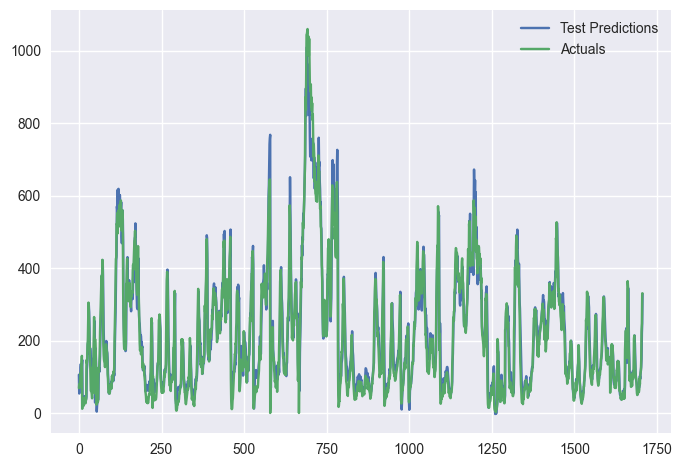

In [20]:
model = load_model('1H_Forecast/1H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(1,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D001_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D001_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)

### 2 hours forecast

In [25]:
%%time

Trainer(2,6,12,50)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 128)              35840     
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 8)                 1032      
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 10:46:13.301129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:46:13.491725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:46:13.509032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:46:13.811984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:46:13.830155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.9237 - mae: 0.6855 - mse: 0.9237 - mape: 168.5403

2023-02-10 10:46:19.346456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:46:19.489699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:46:19.501363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.43143, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 23s 127ms/step - loss: 0.9237 - mae: 0.6855 - mse: 0.9237 - mape: 168.5403 - val_loss: 0.4314 - val_mae: 0.5218 - val_mse: 0.4314 - val_mape: 130.1062
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.6259 - mae: 0.4876 - mse: 0.6259 - mape: 189.5260
Epoch 2: val_loss improved from 0.43143 to 0.31561, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 109ms/step - loss: 0.6259 - mae: 0.4876 - mse: 0.6259 - mape: 189.5260 - val_loss: 0.3156 - val_mae: 0.4304 - val_mse: 0.3156 - val_mape: 115.0249
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5203 - mae: 0.3785 - mse: 0.5203 - mape: 215.8077
Epoch 3: val_loss improved from 0.31561 to 0.27962, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.5203 - mae: 0.3785 - mse: 0.5203 - mape: 215.8077 - val_loss: 0.2796 - val_mae: 0.3992 - val_mse: 0.2796 - val_mape: 101.2097
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.4740 - mae: 0.3273 - mse: 0.4740 - mape: 246.3174
Epoch 4: val_loss improved from 0.27962 to 0.27875, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.4740 - mae: 0.3273 - mse: 0.4740 - mape: 246.3174 - val_loss: 0.2787 - val_mae: 0.3929 - val_mse: 0.2787 - val_mape: 112.8946
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.4505 - mae: 0.3017 - mse: 0.4505 - mape: 248.0886
Epoch 5: val_loss improved from 0.27875 to 0.25347, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.4505 - mae: 0.3017 - mse: 0.4505 - mape: 248.0886 - val_loss: 0.2535 - val_mae: 0.3681 - val_mse: 0.2535 - val_mape: 124.3033
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.4372 - mae: 0.2872 - mse: 0.4372 - mape: 242.5443
Epoch 6: val_loss improved from 0.25347 to 0.22925, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.4372 - mae: 0.2872 - mse: 0.4372 - mape: 242.5443 - val_loss: 0.2293 - val_mae: 0.3451 - val_mse: 0.2293 - val_mape: 129.7493
Epoch 7/50
160/161 [============================>.] - ETA: 0s - loss: 0.4284 - mae: 0.2778 - mse: 0.4284 - mape: 238.1678
Epoch 7: val_loss did not improve from 0.22925
161/161 [==============================] - 4s 26ms/step - loss: 0.4281 - mae: 0.2778 - mse: 0.4281 - mape: 238.2067 - val_loss: 0.2368 - val_mae: 0.3466 - val_mse: 0.2368 - val_mape: 132.4569
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.4207 - mae: 0.2733 - mse: 0.4207 - mape: 219.8759
Epoch 8: val_loss improved from 0.22925 to 0.22440, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.4207 - mae: 0.2733 - mse: 0.4207 - mape: 219.8759 - val_loss: 0.2244 - val_mae: 0.3333 - val_mse: 0.2244 - val_mape: 134.6745
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.4117 - mae: 0.2671 - mse: 0.4117 - mape: 214.8638
Epoch 9: val_loss improved from 0.22440 to 0.21113, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.4117 - mae: 0.2671 - mse: 0.4117 - mape: 214.8638 - val_loss: 0.2111 - val_mae: 0.3201 - val_mse: 0.2111 - val_mape: 134.2067
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.4047 - mae: 0.2624 - mse: 0.4047 - mape: 210.2908
Epoch 10: val_loss did not improve from 0.21113
161/161 [==============================] - 4s 26ms/step - loss: 0.4047 - mae: 0.2624 - mse: 0.4047 - mape: 210.2908 - val_loss: 0.2162 - val_mae: 0.3206 - val_mse: 0.2162 - val_mape: 133.3729
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.3974 - mae: 0.2543 - mse: 0.3974 - mape: 208.3389
Epoch 11: val_loss improved from 0.21113 to 0.20156, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.3974 - mae: 0.2543 - mse: 0.3974 - mape: 208.3389 - val_loss: 0.2016 - val_mae: 0.3079 - val_mse: 0.2016 - val_mape: 138.4781
Epoch 12/50
161/161 [==============================] - ETA: 0s - loss: 0.3916 - mae: 0.2509 - mse: 0.3916 - mape: 198.8157
Epoch 12: val_loss did not improve from 0.20156
161/161 [==============================] - 4s 25ms/step - loss: 0.3916 - mae: 0.2509 - mse: 0.3916 - mape: 198.8157 - val_loss: 0.2038 - val_mae: 0.3076 - val_mse: 0.2038 - val_mape: 132.3533
Epoch 13/50
160/161 [============================>.] - ETA: 0s - loss: 0.3853 - mae: 0.2442 - mse: 0.3853 - mape: 193.8635
Epoch 13: val_loss did not improve from 0.20156
161/161 [==============================] - 4s 27ms/step - loss: 0.3851 - mae: 0.2441 - mse: 0.3851 - mape: 193.7365 - val_loss: 0.2021 - val_mae: 0.3057 - val_mse: 0.2021 - val_mape: 133.3716
Epoch 14/50
160/161 [============================>.] - ETA: 0s - loss: 0.3803 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 19s 118ms/step - loss: 0.3800 - mae: 0.2445 - mse: 0.3800 - mape: 186.3699 - val_loss: 0.1929 - val_mae: 0.2987 - val_mse: 0.1929 - val_mape: 132.6841
Epoch 15/50
160/161 [============================>.] - ETA: 0s - loss: 0.3752 - mae: 0.2381 - mse: 0.3752 - mape: 184.6054
Epoch 15: val_loss did not improve from 0.19286
161/161 [==============================] - 4s 26ms/step - loss: 0.3749 - mae: 0.2380 - mse: 0.3749 - mape: 184.5515 - val_loss: 0.1976 - val_mae: 0.3005 - val_mse: 0.1976 - val_mape: 126.9003
Epoch 16/50
161/161 [==============================] - ETA: 0s - loss: 0.3695 - mae: 0.2350 - mse: 0.3695 - mape: 172.7942
Epoch 16: val_loss improved from 0.19286 to 0.18028, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 105ms/step - loss: 0.3695 - mae: 0.2350 - mse: 0.3695 - mape: 172.7942 - val_loss: 0.1803 - val_mae: 0.2892 - val_mse: 0.1803 - val_mape: 128.8077
Epoch 17/50
161/161 [==============================] - ETA: 0s - loss: 0.3652 - mae: 0.2320 - mse: 0.3652 - mape: 169.6180
Epoch 17: val_loss did not improve from 0.18028
161/161 [==============================] - 4s 26ms/step - loss: 0.3652 - mae: 0.2320 - mse: 0.3652 - mape: 169.6180 - val_loss: 0.1857 - val_mae: 0.2917 - val_mse: 0.1857 - val_mape: 132.8312
Epoch 18/50
160/161 [============================>.] - ETA: 0s - loss: 0.3611 - mae: 0.2315 - mse: 0.3611 - mape: 163.7881
Epoch 18: val_loss improved from 0.18028 to 0.17394, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.3608 - mae: 0.2314 - mse: 0.3608 - mape: 163.6983 - val_loss: 0.1739 - val_mae: 0.2885 - val_mse: 0.1739 - val_mape: 128.5845
Epoch 19/50
161/161 [==============================] - ETA: 0s - loss: 0.3583 - mae: 0.2303 - mse: 0.3583 - mape: 155.3726
Epoch 19: val_loss did not improve from 0.17394
161/161 [==============================] - 4s 26ms/step - loss: 0.3583 - mae: 0.2303 - mse: 0.3583 - mape: 155.3726 - val_loss: 0.1824 - val_mae: 0.2936 - val_mse: 0.1824 - val_mape: 135.3131
Epoch 20/50
161/161 [==============================] - ETA: 0s - loss: 0.3546 - mae: 0.2286 - mse: 0.3546 - mape: 167.4393
Epoch 20: val_loss did not improve from 0.17394
161/161 [==============================] - 4s 25ms/step - loss: 0.3546 - mae: 0.2286 - mse: 0.3546 - mape: 167.4393 - val_loss: 0.1857 - val_mae: 0.2942 - val_mse: 0.1857 - val_mape: 127.4477
Epoch 21/50
159/161 [============================>.] - ETA: 0s - loss: 0.3513 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 105ms/step - loss: 0.3508 - mae: 0.2260 - mse: 0.3508 - mape: 139.6536 - val_loss: 0.1732 - val_mae: 0.2863 - val_mse: 0.1732 - val_mape: 122.6017
Epoch 22/50
159/161 [============================>.] - ETA: 0s - loss: 0.3428 - mae: 0.2238 - mse: 0.3428 - mape: 156.2738
Epoch 22: val_loss did not improve from 0.17317
161/161 [==============================] - 4s 24ms/step - loss: 0.3487 - mae: 0.2254 - mse: 0.3487 - mape: 155.5930 - val_loss: 0.1855 - val_mae: 0.2930 - val_mse: 0.1855 - val_mape: 127.6395
Epoch 23/50
161/161 [==============================] - ETA: 0s - loss: 0.3451 - mae: 0.2233 - mse: 0.3451 - mape: 152.6007
Epoch 23: val_loss did not improve from 0.17317
161/161 [==============================] - 4s 25ms/step - loss: 0.3451 - mae: 0.2233 - mse: 0.3451 - mape: 152.6007 - val_loss: 0.1792 - val_mae: 0.2911 - val_mse: 0.1792 - val_mape: 126.8452
Epoch 24/50
160/161 [============================>.] - ETA: 0s - loss: 0.3448 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 114ms/step - loss: 0.2962 - mae: 0.2138 - mse: 0.2962 - mape: 133.3499 - val_loss: 0.1725 - val_mae: 0.2918 - val_mse: 0.1725 - val_mape: 121.6600
Epoch 43/50
161/161 [==============================] - ETA: 0s - loss: 0.2943 - mae: 0.2145 - mse: 0.2943 - mape: 118.6832
Epoch 43: val_loss did not improve from 0.17251
161/161 [==============================] - 4s 27ms/step - loss: 0.2943 - mae: 0.2145 - mse: 0.2943 - mape: 118.6832 - val_loss: 0.1822 - val_mae: 0.2991 - val_mse: 0.1822 - val_mape: 135.2317
Epoch 44/50
161/161 [==============================] - ETA: 0s - loss: 0.2931 - mae: 0.2117 - mse: 0.2931 - mape: 117.8447
Epoch 44: val_loss did not improve from 0.17251
161/161 [==============================] - 5s 30ms/step - loss: 0.2931 - mae: 0.2117 - mse: 0.2931 - mape: 117.8447 - val_loss: 0.1788 - val_mae: 0.2997 - val_mse: 0.1788 - val_mape: 118.0540
Epoch 45/50
160/161 [============================>.] - ETA: 0s - loss: 0.2910 - 

2023-02-10 10:52:54.042112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:52:54.270569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:52:54.293960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:52:54.600282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:52:54.619135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8578 - mae: 0.5888 - mse: 0.8578 - mape: 129.4890

2023-02-10 10:52:59.450507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:52:59.528754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:52:59.539048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.39495, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 22s 123ms/step - loss: 0.8578 - mae: 0.5888 - mse: 0.8578 - mape: 129.4890 - val_loss: 0.3949 - val_mae: 0.4857 - val_mse: 0.3949 - val_mape: 173.9013
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.5693 - mae: 0.3847 - mse: 0.5693 - mape: 206.7532
Epoch 2: val_loss improved from 0.39495 to 0.24372, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.5693 - mae: 0.3847 - mse: 0.5693 - mape: 206.7532 - val_loss: 0.2437 - val_mae: 0.3560 - val_mse: 0.2437 - val_mape: 167.9781
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.4939 - mae: 0.3209 - mse: 0.4939 - mape: 263.9260
Epoch 3: val_loss did not improve from 0.24372
161/161 [==============================] - 4s 27ms/step - loss: 0.4939 - mae: 0.3209 - mse: 0.4939 - mape: 263.9260 - val_loss: 0.2445 - val_mae: 0.3474 - val_mse: 0.2445 - val_mape: 163.5402
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.4718 - mae: 0.2976 - mse: 0.4718 - mape: 261.3398
Epoch 4: val_loss did not improve from 0.24372
161/161 [==============================] - 4s 26ms/step - loss: 0.4718 - mae: 0.2976 - mse: 0.4718 - mape: 261.3398 - val_loss: 0.2472 - val_mae: 0.3496 - val_mse: 0.2472 - val_mape: 154.5762
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.4570 - mae: 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.3748 - mae: 0.2346 - mse: 0.3748 - mape: 151.1204 - val_loss: 0.2425 - val_mae: 0.3249 - val_mse: 0.2425 - val_mape: 109.3207
Epoch 16/50
160/161 [============================>.] - ETA: 0s - loss: 0.3710 - mae: 0.2386 - mse: 0.3710 - mape: 149.3401
Epoch 16: val_loss did not improve from 0.24245
161/161 [==============================] - 4s 28ms/step - loss: 0.3708 - mae: 0.2386 - mse: 0.3708 - mape: 149.2665 - val_loss: 0.2840 - val_mae: 0.3567 - val_mse: 0.2840 - val_mape: 104.7424
Epoch 17/50
161/161 [==============================] - ETA: 0s - loss: 0.3652 - mae: 0.2320 - mse: 0.3652 - mape: 147.2257
Epoch 17: val_loss did not improve from 0.24245
161/161 [==============================] - 4s 26ms/step - loss: 0.3652 - mae: 0.2320 - mse: 0.3652 - mape: 147.2257 - val_loss: 0.2589 - val_mae: 0.3366 - val_mse: 0.2589 - val_mape: 111.4883
Epoch 18/50
160/161 [============================>.] - ETA: 0s - loss: 0.3608 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 19s 120ms/step - loss: 0.3373 - mae: 0.2234 - mse: 0.3373 - mape: 125.5285 - val_loss: 0.2252 - val_mae: 0.3158 - val_mse: 0.2252 - val_mape: 113.9590
Epoch 24/50
161/161 [==============================] - ETA: 0s - loss: 0.3338 - mae: 0.2255 - mse: 0.3338 - mape: 125.2407
Epoch 24: val_loss did not improve from 0.22521
161/161 [==============================] - 4s 26ms/step - loss: 0.3338 - mae: 0.2255 - mse: 0.3338 - mape: 125.2407 - val_loss: 0.2442 - val_mae: 0.3281 - val_mse: 0.2442 - val_mape: 116.1011
Epoch 25/50
161/161 [==============================] - ETA: 0s - loss: 0.3280 - mae: 0.2244 - mse: 0.3280 - mape: 127.1878
Epoch 25: val_loss improved from 0.22521 to 0.21971, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 113ms/step - loss: 0.3280 - mae: 0.2244 - mse: 0.3280 - mape: 127.1878 - val_loss: 0.2197 - val_mae: 0.3054 - val_mse: 0.2197 - val_mape: 122.2639
Epoch 26/50
161/161 [==============================] - ETA: 0s - loss: 0.3232 - mae: 0.2222 - mse: 0.3232 - mape: 134.1108
Epoch 26: val_loss did not improve from 0.21971
161/161 [==============================] - 4s 25ms/step - loss: 0.3232 - mae: 0.2222 - mse: 0.3232 - mape: 134.1108 - val_loss: 0.2486 - val_mae: 0.3261 - val_mse: 0.2486 - val_mape: 110.4111
Epoch 27/50
160/161 [============================>.] - ETA: 0s - loss: 0.3189 - mae: 0.2216 - mse: 0.3189 - mape: 120.8785
Epoch 27: val_loss did not improve from 0.21971
161/161 [==============================] - 4s 26ms/step - loss: 0.3187 - mae: 0.2216 - mse: 0.3187 - mape: 120.9079 - val_loss: 0.2387 - val_mae: 0.3201 - val_mse: 0.2387 - val_mape: 117.4358
Epoch 28/50
160/161 [============================>.] - ETA: 0s - loss: 0.3127 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 109ms/step - loss: 0.3018 - mae: 0.2197 - mse: 0.3018 - mape: 119.7957 - val_loss: 0.2119 - val_mae: 0.3090 - val_mse: 0.2119 - val_mape: 120.8628
Epoch 31/50
160/161 [============================>.] - ETA: 0s - loss: 0.2970 - mae: 0.2194 - mse: 0.2970 - mape: 119.7865
Epoch 31: val_loss did not improve from 0.21194
161/161 [==============================] - 4s 27ms/step - loss: 0.2968 - mae: 0.2194 - mse: 0.2968 - mape: 119.7303 - val_loss: 0.2245 - val_mae: 0.3156 - val_mse: 0.2245 - val_mape: 117.0324
Epoch 32/50
161/161 [==============================] - ETA: 0s - loss: 0.2914 - mae: 0.2174 - mse: 0.2914 - mape: 119.4023
Epoch 32: val_loss improved from 0.21194 to 0.20589, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.2914 - mae: 0.2174 - mse: 0.2914 - mape: 119.4023 - val_loss: 0.2059 - val_mae: 0.3073 - val_mse: 0.2059 - val_mape: 127.1770
Epoch 33/50
161/161 [==============================] - ETA: 0s - loss: 0.2860 - mae: 0.2176 - mse: 0.2860 - mape: 127.3372
Epoch 33: val_loss improved from 0.20589 to 0.20544, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 20s 127ms/step - loss: 0.2860 - mae: 0.2176 - mse: 0.2860 - mape: 127.3372 - val_loss: 0.2054 - val_mae: 0.2996 - val_mse: 0.2054 - val_mape: 124.0103
Epoch 34/50
161/161 [==============================] - ETA: 0s - loss: 0.2816 - mae: 0.2183 - mse: 0.2816 - mape: 126.4616
Epoch 34: val_loss did not improve from 0.20544
161/161 [==============================] - 4s 27ms/step - loss: 0.2816 - mae: 0.2183 - mse: 0.2816 - mape: 126.4616 - val_loss: 0.2322 - val_mae: 0.3140 - val_mse: 0.2322 - val_mape: 120.0800
Epoch 35/50
160/161 [============================>.] - ETA: 0s - loss: 0.2761 - mae: 0.2149 - mse: 0.2761 - mape: 119.0529
Epoch 35: val_loss did not improve from 0.20544
161/161 [==============================] - 4s 26ms/step - loss: 0.2760 - mae: 0.2148 - mse: 0.2760 - mape: 119.0040 - val_loss: 0.2240 - val_mae: 0.3075 - val_mse: 0.2240 - val_mape: 123.7467
Epoch 36/50
160/161 [============================>.] - ETA: 0s - loss: 0.2725 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.2627 - mae: 0.2126 - mse: 0.2627 - mape: 115.9454 - val_loss: 0.2035 - val_mae: 0.2977 - val_mse: 0.2035 - val_mape: 120.8394
Epoch 39/50
161/161 [==============================] - ETA: 0s - loss: 0.2591 - mae: 0.2119 - mse: 0.2591 - mape: 121.4535
Epoch 39: val_loss did not improve from 0.20348
161/161 [==============================] - 4s 27ms/step - loss: 0.2591 - mae: 0.2119 - mse: 0.2591 - mape: 121.4535 - val_loss: 0.2376 - val_mae: 0.3180 - val_mse: 0.2376 - val_mape: 123.3340
Epoch 40/50
159/161 [============================>.] - ETA: 0s - loss: 0.2554 - mae: 0.2109 - mse: 0.2554 - mape: 114.8806
Epoch 40: val_loss improved from 0.20348 to 0.20246, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 109ms/step - loss: 0.2542 - mae: 0.2107 - mse: 0.2542 - mape: 114.9038 - val_loss: 0.2025 - val_mae: 0.2998 - val_mse: 0.2025 - val_mape: 117.1467
Epoch 41/50
160/161 [============================>.] - ETA: 0s - loss: 0.2525 - mae: 0.2093 - mse: 0.2525 - mape: 114.5836
Epoch 41: val_loss did not improve from 0.20246
161/161 [==============================] - 4s 27ms/step - loss: 0.2524 - mae: 0.2093 - mse: 0.2524 - mape: 114.5238 - val_loss: 0.2154 - val_mae: 0.3089 - val_mse: 0.2154 - val_mape: 121.1503
Epoch 42/50
159/161 [============================>.] - ETA: 0s - loss: 0.2492 - mae: 0.2111 - mse: 0.2492 - mape: 117.3465
Epoch 42: val_loss improved from 0.20246 to 0.18948, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 113ms/step - loss: 0.2481 - mae: 0.2112 - mse: 0.2481 - mape: 118.8013 - val_loss: 0.1895 - val_mae: 0.2907 - val_mse: 0.1895 - val_mape: 126.0740
Epoch 43/50
159/161 [============================>.] - ETA: 0s - loss: 0.2452 - mae: 0.2090 - mse: 0.2452 - mape: 113.4482
Epoch 43: val_loss did not improve from 0.18948
161/161 [==============================] - 4s 25ms/step - loss: 0.2439 - mae: 0.2087 - mse: 0.2439 - mape: 112.9696 - val_loss: 0.2014 - val_mae: 0.2989 - val_mse: 0.2014 - val_mape: 118.1397
Epoch 44/50
161/161 [==============================] - ETA: 0s - loss: 0.2415 - mae: 0.2102 - mse: 0.2415 - mape: 117.4729
Epoch 44: val_loss did not improve from 0.18948
161/161 [==============================] - 4s 25ms/step - loss: 0.2415 - mae: 0.2102 - mse: 0.2415 - mape: 117.4729 - val_loss: 0.2207 - val_mae: 0.3076 - val_mse: 0.2207 - val_mape: 129.4517
Epoch 45/50
161/161 [==============================] - ETA: 0s - loss: 0.2390 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.2300 - mae: 0.2056 - mse: 0.2300 - mape: 117.6236 - val_loss: 0.1887 - val_mae: 0.2920 - val_mse: 0.1887 - val_mape: 118.4837
Epoch 49/50
159/161 [============================>.] - ETA: 0s - loss: 0.2274 - mae: 0.2040 - mse: 0.2274 - mape: 115.9899
Epoch 49: val_loss did not improve from 0.18873
161/161 [==============================] - 4s 26ms/step - loss: 0.2263 - mae: 0.2039 - mse: 0.2263 - mape: 115.7091 - val_loss: 0.1933 - val_mae: 0.2965 - val_mse: 0.1933 - val_mape: 119.3014
Epoch 50/50
161/161 [==============================] - ETA: 0s - loss: 0.2247 - mae: 0.2057 - mse: 0.2247 - mape: 114.8166
Epoch 50: val_loss did not improve from 0.18873
161/161 [==============================] - 4s 25ms/step - loss: 0.2247 - mae: 0.2057 - mse: 0.2247 - mape: 114.8166 - val_loss: 0.1938 - val_mae: 0.2968 - val_mse: 0.1938 - val_mape: 119.8891

-------------------------------------------------------------------------------

2023-02-10 10:59:22.253508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:59:22.465357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:59:22.488517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:59:22.847550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:59:22.876615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.7608 - mae: 0.5480 - mse: 0.7608 - mape: 162.7396

2023-02-10 10:59:27.901528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:59:27.975111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:59:27.985958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.43239, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 22s 125ms/step - loss: 0.7608 - mae: 0.5480 - mse: 0.7608 - mape: 162.7396 - val_loss: 0.4324 - val_mae: 0.4749 - val_mse: 0.4324 - val_mape: 144.7613
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.5353 - mae: 0.3630 - mse: 0.5353 - mape: 254.2194
Epoch 2: val_loss improved from 0.43239 to 0.31656, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 19s 115ms/step - loss: 0.5353 - mae: 0.3630 - mse: 0.5353 - mape: 254.2194 - val_loss: 0.3166 - val_mae: 0.4014 - val_mse: 0.3166 - val_mape: 153.1701
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5002 - mae: 0.3275 - mse: 0.5002 - mape: 292.6951
Epoch 3: val_loss improved from 0.31656 to 0.29152, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 114ms/step - loss: 0.5002 - mae: 0.3275 - mse: 0.5002 - mape: 292.6951 - val_loss: 0.2915 - val_mae: 0.3848 - val_mse: 0.2915 - val_mape: 146.9694
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.4816 - mae: 0.3154 - mse: 0.4816 - mape: 297.3832
Epoch 4: val_loss improved from 0.29152 to 0.29004, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.4816 - mae: 0.3154 - mse: 0.4816 - mape: 297.3832 - val_loss: 0.2900 - val_mae: 0.3855 - val_mse: 0.2900 - val_mape: 138.3553
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.4668 - mae: 0.3052 - mse: 0.4668 - mape: 282.7661
Epoch 5: val_loss improved from 0.29004 to 0.28000, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.4668 - mae: 0.3052 - mse: 0.4668 - mape: 282.7661 - val_loss: 0.2800 - val_mae: 0.3746 - val_mse: 0.2800 - val_mape: 136.0305
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.4515 - mae: 0.2934 - mse: 0.4515 - mape: 267.0350
Epoch 6: val_loss did not improve from 0.28000
161/161 [==============================] - 5s 30ms/step - loss: 0.4515 - mae: 0.2934 - mse: 0.4515 - mape: 267.0350 - val_loss: 0.2912 - val_mae: 0.3779 - val_mse: 0.2912 - val_mape: 128.2790
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.4390 - mae: 0.2856 - mse: 0.4390 - mape: 247.9721
Epoch 7: val_loss improved from 0.28000 to 0.25989, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.4390 - mae: 0.2856 - mse: 0.4390 - mape: 247.9721 - val_loss: 0.2599 - val_mae: 0.3517 - val_mse: 0.2599 - val_mape: 128.1232
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.4246 - mae: 0.2749 - mse: 0.4246 - mape: 239.8165
Epoch 8: val_loss did not improve from 0.25989
161/161 [==============================] - 4s 26ms/step - loss: 0.4246 - mae: 0.2749 - mse: 0.4246 - mape: 239.8165 - val_loss: 0.2659 - val_mae: 0.3554 - val_mse: 0.2659 - val_mape: 115.8197
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.4120 - mae: 0.2674 - mse: 0.4120 - mape: 225.5444
Epoch 9: val_loss did not improve from 0.25989
161/161 [==============================] - 4s 25ms/step - loss: 0.4120 - mae: 0.2674 - mse: 0.4120 - mape: 225.5444 - val_loss: 0.2752 - val_mae: 0.3560 - val_mse: 0.2752 - val_mape: 111.7706
Epoch 10/50
160/161 [============================>.] - ETA: 0s - loss: 0.3997 - mae:

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 17s 104ms/step - loss: 0.3995 - mae: 0.2573 - mse: 0.3995 - mape: 204.4842 - val_loss: 0.2568 - val_mae: 0.3423 - val_mse: 0.2568 - val_mape: 110.5789
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.3906 - mae: 0.2504 - mse: 0.3906 - mape: 203.7525
Epoch 11: val_loss did not improve from 0.25681
161/161 [==============================] - 5s 28ms/step - loss: 0.3906 - mae: 0.2504 - mse: 0.3906 - mape: 203.7525 - val_loss: 0.3042 - val_mae: 0.3710 - val_mse: 0.3042 - val_mape: 107.7693
Epoch 12/50
160/161 [============================>.] - ETA: 0s - loss: 0.3812 - mae: 0.2444 - mse: 0.3812 - mape: 175.5988
Epoch 12: val_loss did not improve from 0.25681
161/161 [==============================] - 4s 26ms/step - loss: 0.3814 - mae: 0.2446 - mse: 0.3814 - mape: 175.5574 - val_loss: 0.2628 - val_mae: 0.3418 - val_mse: 0.2628 - val_mape: 108.9783
Epoch 13/50
161/161 [==============================] - ETA: 0s - loss: 0.3732 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 19s 119ms/step - loss: 0.3687 - mae: 0.2395 - mse: 0.3687 - mape: 177.8713 - val_loss: 0.2451 - val_mae: 0.3271 - val_mse: 0.2451 - val_mape: 107.9197
Epoch 15/50
161/161 [==============================] - ETA: 0s - loss: 0.3638 - mae: 0.2373 - mse: 0.3638 - mape: 170.6055
Epoch 15: val_loss did not improve from 0.24507
161/161 [==============================] - 5s 27ms/step - loss: 0.3638 - mae: 0.2373 - mse: 0.3638 - mape: 170.6055 - val_loss: 0.3363 - val_mae: 0.3843 - val_mse: 0.3363 - val_mape: 103.9184
Epoch 16/50
160/161 [============================>.] - ETA: 0s - loss: 0.3591 - mae: 0.2337 - mse: 0.3591 - mape: 161.6868
Epoch 16: val_loss did not improve from 0.24507
161/161 [==============================] - 5s 33ms/step - loss: 0.3589 - mae: 0.2336 - mse: 0.3589 - mape: 161.6545 - val_loss: 0.2927 - val_mae: 0.3604 - val_mse: 0.2927 - val_mape: 100.8417
Epoch 17/50
160/161 [============================>.] - ETA: 0s - loss: 0.3567 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 113ms/step - loss: 0.2881 - mae: 0.2208 - mse: 0.2881 - mape: 128.4445 - val_loss: 0.2051 - val_mae: 0.2858 - val_mse: 0.2051 - val_mape: 106.6144
Epoch 33/50
160/161 [============================>.] - ETA: 0s - loss: 0.2830 - mae: 0.2177 - mse: 0.2830 - mape: 118.8335
Epoch 33: val_loss did not improve from 0.20509
161/161 [==============================] - 4s 26ms/step - loss: 0.2830 - mae: 0.2177 - mse: 0.2830 - mape: 118.8065 - val_loss: 0.2391 - val_mae: 0.3094 - val_mse: 0.2391 - val_mape: 102.7145
Epoch 34/50
160/161 [============================>.] - ETA: 0s - loss: 0.2780 - mae: 0.2176 - mse: 0.2780 - mape: 129.8703
Epoch 34: val_loss did not improve from 0.20509
161/161 [==============================] - 4s 27ms/step - loss: 0.2779 - mae: 0.2175 - mse: 0.2779 - mape: 129.8256 - val_loss: 0.2413 - val_mae: 0.3103 - val_mse: 0.2413 - val_mape: 97.2546
Epoch 35/50
161/161 [==============================] - ETA: 0s - loss: 0.2730 - m

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.2599 - mae: 0.2156 - mse: 0.2599 - mape: 130.3598 - val_loss: 0.2001 - val_mae: 0.2864 - val_mse: 0.2001 - val_mape: 105.5213
Epoch 39/50
161/161 [==============================] - ETA: 0s - loss: 0.2543 - mae: 0.2104 - mse: 0.2543 - mape: 123.2817
Epoch 39: val_loss did not improve from 0.20008
161/161 [==============================] - 5s 30ms/step - loss: 0.2543 - mae: 0.2104 - mse: 0.2543 - mape: 123.2817 - val_loss: 0.2009 - val_mae: 0.2832 - val_mse: 0.2009 - val_mape: 109.6337
Epoch 40/50
159/161 [============================>.] - ETA: 0s - loss: 0.2518 - mae: 0.2111 - mse: 0.2518 - mape: 126.9669
Epoch 40: val_loss improved from 0.20008 to 0.19519, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.2508 - mae: 0.2109 - mse: 0.2508 - mape: 126.7318 - val_loss: 0.1952 - val_mae: 0.2816 - val_mse: 0.1952 - val_mape: 112.1032
Epoch 41/50
160/161 [============================>.] - ETA: 0s - loss: 0.2476 - mae: 0.2091 - mse: 0.2476 - mape: 118.6956
Epoch 41: val_loss did not improve from 0.19519
161/161 [==============================] - 4s 27ms/step - loss: 0.2475 - mae: 0.2092 - mse: 0.2475 - mape: 118.6838 - val_loss: 0.2194 - val_mae: 0.2978 - val_mse: 0.2194 - val_mape: 107.3010
Epoch 42/50
159/161 [============================>.] - ETA: 0s - loss: 0.2450 - mae: 0.2126 - mse: 0.2450 - mape: 123.7556
Epoch 42: val_loss did not improve from 0.19519
161/161 [==============================] - 4s 26ms/step - loss: 0.2440 - mae: 0.2127 - mse: 0.2440 - mape: 123.7882 - val_loss: 0.2469 - val_mae: 0.3072 - val_mse: 0.2469 - val_mape: 122.1142
Epoch 43/50
161/161 [==============================] - ETA: 0s - loss: 0.2389 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 115ms/step - loss: 0.2389 - mae: 0.2053 - mse: 0.2389 - mape: 129.4143 - val_loss: 0.1930 - val_mae: 0.2792 - val_mse: 0.1930 - val_mape: 113.7183
Epoch 44/50
161/161 [==============================] - ETA: 0s - loss: 0.2369 - mae: 0.2098 - mse: 0.2369 - mape: 118.3458
Epoch 44: val_loss did not improve from 0.19302
161/161 [==============================] - 4s 26ms/step - loss: 0.2369 - mae: 0.2098 - mse: 0.2369 - mape: 118.3458 - val_loss: 0.2194 - val_mae: 0.2987 - val_mse: 0.2194 - val_mape: 97.3953
Epoch 45/50
159/161 [============================>.] - ETA: 0s - loss: 0.2339 - mae: 0.2075 - mse: 0.2339 - mape: 126.4641
Epoch 45: val_loss did not improve from 0.19302
161/161 [==============================] - 4s 25ms/step - loss: 0.2326 - mae: 0.2071 - mse: 0.2326 - mape: 125.8089 - val_loss: 0.2007 - val_mae: 0.2818 - val_mse: 0.2007 - val_mape: 97.1976
Epoch 46/50
160/161 [============================>.] - ETA: 0s - loss: 0.2302 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 17s 105ms/step - loss: 0.2226 - mae: 0.2048 - mse: 0.2226 - mape: 116.7328 - val_loss: 0.1857 - val_mae: 0.2726 - val_mse: 0.1857 - val_mape: 105.9842
Epoch 50/50
161/161 [==============================] - ETA: 0s - loss: 0.2194 - mae: 0.2002 - mse: 0.2194 - mape: 130.1257
Epoch 50: val_loss did not improve from 0.18575
161/161 [==============================] - 4s 25ms/step - loss: 0.2194 - mae: 0.2002 - mse: 0.2194 - mape: 130.1257 - val_loss: 0.1893 - val_mae: 0.2747 - val_mse: 0.1893 - val_mape: 101.5415

-----------------------------------------------------------------------------------------------------------

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_11 (Bidirecti  (None, 128)              35840     
 onal)                                                           
                                              

2023-02-10 11:05:59.031555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:05:59.251685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:05:59.284070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:05:59.650265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:05:59.667169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8689 - mae: 0.5741 - mse: 0.8689 - mape: 153.0158

2023-02-10 11:06:04.524215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:06:04.623246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:06:04.623340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.53576, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 22s 123ms/step - loss: 0.8689 - mae: 0.5741 - mse: 0.8689 - mape: 153.0158 - val_loss: 0.5358 - val_mae: 0.5663 - val_mse: 0.5358 - val_mape: 110.1455
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.5717 - mae: 0.3827 - mse: 0.5717 - mape: 252.7323
Epoch 2: val_loss improved from 0.53576 to 0.30343, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 114ms/step - loss: 0.5717 - mae: 0.3827 - mse: 0.5717 - mape: 252.7323 - val_loss: 0.3034 - val_mae: 0.4006 - val_mse: 0.3034 - val_mape: 143.8523
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5137 - mae: 0.3340 - mse: 0.5137 - mape: 310.8766
Epoch 3: val_loss improved from 0.30343 to 0.29820, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.5137 - mae: 0.3340 - mse: 0.5137 - mape: 310.8766 - val_loss: 0.2982 - val_mae: 0.3891 - val_mse: 0.2982 - val_mape: 143.2314
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.4939 - mae: 0.3189 - mse: 0.4939 - mape: 304.0009
Epoch 4: val_loss did not improve from 0.29820
161/161 [==============================] - 4s 27ms/step - loss: 0.4939 - mae: 0.3189 - mse: 0.4939 - mape: 304.0009 - val_loss: 0.3051 - val_mae: 0.3958 - val_mse: 0.3051 - val_mape: 135.3884
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.4743 - mae: 0.3067 - mse: 0.4743 - mape: 291.0598
Epoch 5: val_loss improved from 0.29820 to 0.27276, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.4743 - mae: 0.3067 - mse: 0.4743 - mape: 291.0598 - val_loss: 0.2728 - val_mae: 0.3741 - val_mse: 0.2728 - val_mape: 132.8826
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.4567 - mae: 0.2952 - mse: 0.4567 - mape: 285.1016
Epoch 6: val_loss did not improve from 0.27276
161/161 [==============================] - 5s 28ms/step - loss: 0.4567 - mae: 0.2952 - mse: 0.4567 - mape: 285.1016 - val_loss: 0.2762 - val_mae: 0.3732 - val_mse: 0.2762 - val_mape: 132.1969
Epoch 7/50
159/161 [============================>.] - ETA: 0s - loss: 0.4421 - mae: 0.2863 - mse: 0.4421 - mape: 272.0479
Epoch 7: val_loss improved from 0.27276 to 0.26986, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.4424 - mae: 0.2866 - mse: 0.4424 - mape: 270.5791 - val_loss: 0.2699 - val_mae: 0.3634 - val_mse: 0.2699 - val_mape: 133.1946
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.4278 - mae: 0.2786 - mse: 0.4278 - mape: 264.6616
Epoch 8: val_loss did not improve from 0.26986
161/161 [==============================] - 4s 26ms/step - loss: 0.4278 - mae: 0.2786 - mse: 0.4278 - mape: 264.6616 - val_loss: 0.2795 - val_mae: 0.3662 - val_mse: 0.2795 - val_mape: 126.3895
Epoch 9/50
160/161 [============================>.] - ETA: 0s - loss: 0.4161 - mae: 0.2687 - mse: 0.4161 - mape: 253.1205
Epoch 9: val_loss improved from 0.26986 to 0.25887, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 105ms/step - loss: 0.4160 - mae: 0.2686 - mse: 0.4160 - mape: 253.0731 - val_loss: 0.2589 - val_mae: 0.3496 - val_mse: 0.2589 - val_mape: 121.6467
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.4041 - mae: 0.2639 - mse: 0.4041 - mape: 247.6522
Epoch 10: val_loss did not improve from 0.25887
161/161 [==============================] - 4s 26ms/step - loss: 0.4041 - mae: 0.2639 - mse: 0.4041 - mape: 247.6522 - val_loss: 0.2846 - val_mae: 0.3639 - val_mse: 0.2846 - val_mape: 118.2723
Epoch 11/50
160/161 [============================>.] - ETA: 0s - loss: 0.3986 - mae: 0.2593 - mse: 0.3986 - mape: 233.5232
Epoch 11: val_loss did not improve from 0.25887
161/161 [==============================] - 4s 28ms/step - loss: 0.3985 - mae: 0.2593 - mse: 0.3985 - mape: 233.4797 - val_loss: 0.2851 - val_mae: 0.3578 - val_mse: 0.2851 - val_mape: 118.3730
Epoch 12/50
160/161 [============================>.] - ETA: 0s - loss: 0.3890 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.3052 - mae: 0.2274 - mse: 0.3052 - mape: 145.8572 - val_loss: 0.2377 - val_mae: 0.3138 - val_mse: 0.2377 - val_mape: 118.3772
Epoch 30/50
161/161 [==============================] - ETA: 0s - loss: 0.2999 - mae: 0.2229 - mse: 0.2999 - mape: 143.3775
Epoch 30: val_loss did not improve from 0.23770
161/161 [==============================] - 4s 27ms/step - loss: 0.2999 - mae: 0.2229 - mse: 0.2999 - mape: 143.3775 - val_loss: 0.2749 - val_mae: 0.3379 - val_mse: 0.2749 - val_mape: 109.8117
Epoch 31/50
159/161 [============================>.] - ETA: 0s - loss: 0.2977 - mae: 0.2256 - mse: 0.2977 - mape: 147.3050
Epoch 31: val_loss did not improve from 0.23770
161/161 [==============================] - 4s 26ms/step - loss: 0.2963 - mae: 0.2255 - mse: 0.2963 - mape: 146.7606 - val_loss: 0.2693 - val_mae: 0.3286 - val_mse: 0.2693 - val_mape: 123.4810
Epoch 32/50
161/161 [==============================] - ETA: 0s - loss: 0.2926 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 114ms/step - loss: 0.2926 - mae: 0.2233 - mse: 0.2926 - mape: 137.9082 - val_loss: 0.2204 - val_mae: 0.3089 - val_mse: 0.2204 - val_mape: 122.1283
Epoch 33/50
159/161 [============================>.] - ETA: 0s - loss: 0.2907 - mae: 0.2226 - mse: 0.2907 - mape: 149.2307
Epoch 33: val_loss improved from 0.22043 to 0.21632, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 20s 124ms/step - loss: 0.2895 - mae: 0.2226 - mse: 0.2895 - mape: 148.5505 - val_loss: 0.2163 - val_mae: 0.3039 - val_mse: 0.2163 - val_mape: 120.4121
Epoch 34/50
160/161 [============================>.] - ETA: 0s - loss: 0.2861 - mae: 0.2219 - mse: 0.2861 - mape: 143.3045
Epoch 34: val_loss did not improve from 0.21632
161/161 [==============================] - 5s 28ms/step - loss: 0.2861 - mae: 0.2219 - mse: 0.2861 - mape: 143.2787 - val_loss: 0.2361 - val_mae: 0.3137 - val_mse: 0.2361 - val_mape: 121.1975
Epoch 35/50
161/161 [==============================] - ETA: 0s - loss: 0.2818 - mae: 0.2190 - mse: 0.2818 - mape: 145.6171
Epoch 35: val_loss did not improve from 0.21632
161/161 [==============================] - 5s 30ms/step - loss: 0.2818 - mae: 0.2190 - mse: 0.2818 - mape: 145.6171 - val_loss: 0.2550 - val_mae: 0.3247 - val_mse: 0.2550 - val_mape: 123.2114
Epoch 36/50
160/161 [============================>.] - ETA: 0s - loss: 0.2789 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 20s 125ms/step - loss: 0.2749 - mae: 0.2189 - mse: 0.2749 - mape: 143.0975 - val_loss: 0.2077 - val_mae: 0.2982 - val_mse: 0.2077 - val_mape: 125.8298
Epoch 38/50
160/161 [============================>.] - ETA: 0s - loss: 0.2728 - mae: 0.2167 - mse: 0.2728 - mape: 130.7197
Epoch 38: val_loss did not improve from 0.20766
161/161 [==============================] - 5s 31ms/step - loss: 0.2728 - mae: 0.2168 - mse: 0.2728 - mape: 130.7019 - val_loss: 0.2505 - val_mae: 0.3211 - val_mse: 0.2505 - val_mape: 130.3816
Epoch 39/50
160/161 [============================>.] - ETA: 0s - loss: 0.2711 - mae: 0.2181 - mse: 0.2711 - mape: 136.1165
Epoch 39: val_loss did not improve from 0.20766
161/161 [==============================] - 5s 29ms/step - loss: 0.2711 - mae: 0.2181 - mse: 0.2711 - mape: 136.0941 - val_loss: 0.2446 - val_mae: 0.3144 - val_mse: 0.2446 - val_mape: 122.6661
Epoch 40/50
160/161 [============================>.] - ETA: 0s - loss: 0.2668 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 19s 117ms/step - loss: 0.2668 - mae: 0.2170 - mse: 0.2668 - mape: 139.4987 - val_loss: 0.2023 - val_mae: 0.2933 - val_mse: 0.2023 - val_mape: 118.8287
Epoch 41/50
161/161 [==============================] - ETA: 0s - loss: 0.2636 - mae: 0.2146 - mse: 0.2636 - mape: 141.2103
Epoch 41: val_loss did not improve from 0.20227
161/161 [==============================] - 5s 31ms/step - loss: 0.2636 - mae: 0.2146 - mse: 0.2636 - mape: 141.2103 - val_loss: 0.2061 - val_mae: 0.2937 - val_mse: 0.2061 - val_mape: 123.5104
Epoch 42/50
160/161 [============================>.] - ETA: 0s - loss: 0.2594 - mae: 0.2141 - mse: 0.2594 - mape: 140.8362
Epoch 42: val_loss did not improve from 0.20227
161/161 [==============================] - 4s 27ms/step - loss: 0.2594 - mae: 0.2141 - mse: 0.2594 - mape: 140.8108 - val_loss: 0.2305 - val_mae: 0.3108 - val_mse: 0.2305 - val_mape: 118.3114
Epoch 43/50
160/161 [============================>.] - ETA: 0s - loss: 0.2564 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 19s 121ms/step - loss: 0.2574 - mae: 0.2214 - mse: 0.2574 - mape: 130.3520 - val_loss: 0.1716 - val_mae: 0.2771 - val_mse: 0.1716 - val_mape: 128.2324
Epoch 45/50
160/161 [============================>.] - ETA: 0s - loss: 0.2516 - mae: 0.2128 - mse: 0.2516 - mape: 122.1899
Epoch 45: val_loss did not improve from 0.17157
161/161 [==============================] - 5s 28ms/step - loss: 0.2516 - mae: 0.2128 - mse: 0.2516 - mape: 122.1747 - val_loss: 0.2131 - val_mae: 0.2949 - val_mse: 0.2131 - val_mape: 126.2746
Epoch 46/50
161/161 [==============================] - ETA: 0s - loss: 0.2490 - mae: 0.2135 - mse: 0.2490 - mape: 131.6692
Epoch 46: val_loss did not improve from 0.17157
161/161 [==============================] - 4s 28ms/step - loss: 0.2490 - mae: 0.2135 - mse: 0.2490 - mape: 131.6692 - val_loss: 0.2293 - val_mae: 0.3067 - val_mse: 0.2293 - val_mape: 123.1643
Epoch 47/50
160/161 [============================>.] - ETA: 0s - loss: 0.2469 - 

2023-02-10 11:12:30.018315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:12:30.254097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:12:30.281835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:12:30.719677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:12:30.748023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.7615 - mae: 0.5318 - mse: 0.7615 - mape: 179.1732

2023-02-10 11:12:36.329886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:12:36.429814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:12:36.443389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.46010, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 24s 136ms/step - loss: 0.7615 - mae: 0.5318 - mse: 0.7615 - mape: 179.1732 - val_loss: 0.4601 - val_mae: 0.5128 - val_mse: 0.4601 - val_mape: 119.7501
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.5515 - mae: 0.3815 - mse: 0.5515 - mape: 309.9265
Epoch 2: val_loss improved from 0.46010 to 0.35957, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 19s 120ms/step - loss: 0.5515 - mae: 0.3815 - mse: 0.5515 - mape: 309.9265 - val_loss: 0.3596 - val_mae: 0.4381 - val_mse: 0.3596 - val_mape: 127.7066
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5134 - mae: 0.3505 - mse: 0.5134 - mape: 358.5528
Epoch 3: val_loss improved from 0.35957 to 0.33953, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 21s 133ms/step - loss: 0.5134 - mae: 0.3505 - mse: 0.5134 - mape: 358.5528 - val_loss: 0.3395 - val_mae: 0.4208 - val_mse: 0.3395 - val_mape: 128.7507
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.4922 - mae: 0.3334 - mse: 0.4922 - mape: 353.6995
Epoch 4: val_loss improved from 0.33953 to 0.31242, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 19s 119ms/step - loss: 0.4922 - mae: 0.3334 - mse: 0.4922 - mape: 353.6995 - val_loss: 0.3124 - val_mae: 0.4008 - val_mse: 0.3124 - val_mape: 133.4433
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.4728 - mae: 0.3181 - mse: 0.4728 - mape: 328.9678
Epoch 5: val_loss improved from 0.31242 to 0.30432, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 18s 109ms/step - loss: 0.4728 - mae: 0.3181 - mse: 0.4728 - mape: 328.9678 - val_loss: 0.3043 - val_mae: 0.3896 - val_mse: 0.3043 - val_mape: 135.8773
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.4556 - mae: 0.3099 - mse: 0.4556 - mape: 319.4384
Epoch 6: val_loss did not improve from 0.30432
161/161 [==============================] - 5s 28ms/step - loss: 0.4556 - mae: 0.3099 - mse: 0.4556 - mape: 319.4384 - val_loss: 0.3075 - val_mae: 0.3893 - val_mse: 0.3075 - val_mape: 135.3813
Epoch 7/50
160/161 [============================>.] - ETA: 0s - loss: 0.4392 - mae: 0.2947 - mse: 0.4392 - mape: 306.9259
Epoch 7: val_loss improved from 0.30432 to 0.27714, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 105ms/step - loss: 0.4391 - mae: 0.2947 - mse: 0.4391 - mape: 306.8693 - val_loss: 0.2771 - val_mae: 0.3679 - val_mse: 0.2771 - val_mape: 131.2808
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.4229 - mae: 0.2895 - mse: 0.4229 - mape: 277.6060
Epoch 8: val_loss did not improve from 0.27714
161/161 [==============================] - 4s 26ms/step - loss: 0.4229 - mae: 0.2895 - mse: 0.4229 - mape: 277.6060 - val_loss: 0.2854 - val_mae: 0.3691 - val_mse: 0.2854 - val_mape: 131.2941
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.4118 - mae: 0.2759 - mse: 0.4118 - mape: 258.2081
Epoch 9: val_loss did not improve from 0.27714
161/161 [==============================] - 4s 24ms/step - loss: 0.4118 - mae: 0.2759 - mse: 0.4118 - mape: 258.2081 - val_loss: 0.2882 - val_mae: 0.3652 - val_mse: 0.2882 - val_mape: 130.6460
Epoch 10/50
160/161 [============================>.] - ETA: 0s - loss: 0.4004 - mae:

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.4003 - mae: 0.2704 - mse: 0.4003 - mape: 244.1194 - val_loss: 0.2647 - val_mae: 0.3541 - val_mse: 0.2647 - val_mape: 121.1705
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.3912 - mae: 0.2633 - mse: 0.3912 - mape: 230.0496
Epoch 11: val_loss did not improve from 0.26474
161/161 [==============================] - 4s 25ms/step - loss: 0.3912 - mae: 0.2633 - mse: 0.3912 - mape: 230.0496 - val_loss: 0.3240 - val_mae: 0.3903 - val_mse: 0.3240 - val_mape: 111.4161
Epoch 12/50
161/161 [==============================] - ETA: 0s - loss: 0.3827 - mae: 0.2597 - mse: 0.3827 - mape: 213.3907
Epoch 12: val_loss did not improve from 0.26474
161/161 [==============================] - 4s 26ms/step - loss: 0.3827 - mae: 0.2597 - mse: 0.3827 - mape: 213.3907 - val_loss: 0.3369 - val_mae: 0.3894 - val_mse: 0.3369 - val_mape: 119.1621
Epoch 13/50
160/161 [============================>.] - ETA: 0s - loss: 0.3756 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 104ms/step - loss: 0.3337 - mae: 0.2390 - mse: 0.3337 - mape: 182.5273 - val_loss: 0.2590 - val_mae: 0.3367 - val_mse: 0.2590 - val_mape: 123.3390
Epoch 22/50
161/161 [==============================] - ETA: 0s - loss: 0.3271 - mae: 0.2371 - mse: 0.3271 - mape: 175.7410
Epoch 22: val_loss did not improve from 0.25901
161/161 [==============================] - 4s 25ms/step - loss: 0.3271 - mae: 0.2371 - mse: 0.3271 - mape: 175.7410 - val_loss: 0.3214 - val_mae: 0.3731 - val_mse: 0.3214 - val_mape: 143.8002
Epoch 23/50
160/161 [============================>.] - ETA: 0s - loss: 0.3253 - mae: 0.2382 - mse: 0.3253 - mape: 170.9751
Epoch 23: val_loss did not improve from 0.25901
161/161 [==============================] - 4s 24ms/step - loss: 0.3252 - mae: 0.2382 - mse: 0.3252 - mape: 170.9463 - val_loss: 0.2758 - val_mae: 0.3426 - val_mse: 0.2758 - val_mape: 134.1908
Epoch 24/50
160/161 [============================>.] - ETA: 0s - loss: 0.3169 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 18s 114ms/step - loss: 0.3089 - mae: 0.2315 - mse: 0.3089 - mape: 148.5198 - val_loss: 0.2367 - val_mae: 0.3185 - val_mse: 0.2367 - val_mape: 127.3027
Epoch 27/50
160/161 [============================>.] - ETA: 0s - loss: 0.3041 - mae: 0.2297 - mse: 0.3041 - mape: 152.8121
Epoch 27: val_loss did not improve from 0.23672
161/161 [==============================] - 4s 26ms/step - loss: 0.3041 - mae: 0.2297 - mse: 0.3041 - mape: 152.9200 - val_loss: 0.2626 - val_mae: 0.3362 - val_mse: 0.2626 - val_mape: 127.0320
Epoch 28/50
159/161 [============================>.] - ETA: 0s - loss: 0.3001 - mae: 0.2311 - mse: 0.3001 - mape: 151.9436
Epoch 28: val_loss did not improve from 0.23672
161/161 [==============================] - 4s 26ms/step - loss: 0.2983 - mae: 0.2304 - mse: 0.2983 - mape: 152.6328 - val_loss: 0.3079 - val_mae: 0.3582 - val_mse: 0.3079 - val_mape: 137.4989
Epoch 29/50
160/161 [============================>.] - ETA: 0s - loss: 0.2935 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.2704 - mae: 0.2211 - mse: 0.2704 - mape: 145.4925 - val_loss: 0.2282 - val_mae: 0.3113 - val_mse: 0.2282 - val_mape: 137.6684
Epoch 35/50
160/161 [============================>.] - ETA: 0s - loss: 0.2667 - mae: 0.2192 - mse: 0.2667 - mape: 143.8760
Epoch 35: val_loss did not improve from 0.22819
161/161 [==============================] - 4s 27ms/step - loss: 0.2667 - mae: 0.2192 - mse: 0.2667 - mape: 143.8519 - val_loss: 0.2445 - val_mae: 0.3195 - val_mse: 0.2445 - val_mape: 129.6154
Epoch 36/50
161/161 [==============================] - ETA: 0s - loss: 0.2622 - mae: 0.2183 - mse: 0.2622 - mape: 141.8815
Epoch 36: val_loss did not improve from 0.22819
161/161 [==============================] - 5s 30ms/step - loss: 0.2622 - mae: 0.2183 - mse: 0.2622 - mape: 141.8815 - val_loss: 0.2488 - val_mae: 0.3212 - val_mse: 0.2488 - val_mape: 144.0049
Epoch 37/50
161/161 [==============================] - ETA: 0s - loss: 0.2590 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 20s 127ms/step - loss: 0.2590 - mae: 0.2231 - mse: 0.2590 - mape: 122.4983 - val_loss: 0.2184 - val_mae: 0.3047 - val_mse: 0.2184 - val_mape: 137.2761
Epoch 38/50
161/161 [==============================] - ETA: 0s - loss: 0.2538 - mae: 0.2165 - mse: 0.2538 - mape: 140.1685
Epoch 38: val_loss did not improve from 0.21837
161/161 [==============================] - 5s 31ms/step - loss: 0.2538 - mae: 0.2165 - mse: 0.2538 - mape: 140.1685 - val_loss: 0.2618 - val_mae: 0.3298 - val_mse: 0.2618 - val_mape: 128.3694
Epoch 39/50
160/161 [============================>.] - ETA: 0s - loss: 0.2516 - mae: 0.2169 - mse: 0.2516 - mape: 136.9790
Epoch 39: val_loss did not improve from 0.21837
161/161 [==============================] - 5s 28ms/step - loss: 0.2516 - mae: 0.2168 - mse: 0.2516 - mape: 136.9534 - val_loss: 0.2224 - val_mae: 0.3083 - val_mse: 0.2224 - val_mape: 134.0708
Epoch 40/50
161/161 [==============================] - ETA: 0s - loss: 0.2476 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 20s 126ms/step - loss: 0.2409 - mae: 0.2128 - mse: 0.2409 - mape: 125.0753 - val_loss: 0.2098 - val_mae: 0.2981 - val_mse: 0.2098 - val_mape: 142.7984
Epoch 43/50
160/161 [============================>.] - ETA: 0s - loss: 0.2378 - mae: 0.2111 - mse: 0.2378 - mape: 129.7478
Epoch 43: val_loss did not improve from 0.20981
161/161 [==============================] - 6s 34ms/step - loss: 0.2377 - mae: 0.2111 - mse: 0.2377 - mape: 129.7911 - val_loss: 0.2399 - val_mae: 0.3154 - val_mse: 0.2399 - val_mape: 143.0089
Epoch 44/50
161/161 [==============================] - ETA: 0s - loss: 0.2352 - mae: 0.2103 - mse: 0.2352 - mape: 136.2312
Epoch 44: val_loss did not improve from 0.20981
161/161 [==============================] - 4s 27ms/step - loss: 0.2352 - mae: 0.2103 - mse: 0.2352 - mape: 136.2312 - val_loss: 0.2140 - val_mae: 0.3004 - val_mse: 0.2140 - val_mape: 137.0085
Epoch 45/50
159/161 [============================>.] - ETA: 0s - loss: 0.2327 - 

2023-02-10 11:18:59.385994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:18:59.617935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:18:59.646951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:19:00.142678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:19:00.167104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8093 - mae: 0.5375 - mse: 0.8093 - mape: 148.8406

2023-02-10 11:19:05.698033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:19:05.775230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:19:05.785742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.57573, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 24s 134ms/step - loss: 0.8093 - mae: 0.5375 - mse: 0.8093 - mape: 148.8406 - val_loss: 0.5757 - val_mae: 0.5566 - val_mse: 0.5757 - val_mape: 133.9520
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.5972 - mae: 0.3902 - mse: 0.5972 - mape: 282.4131
Epoch 2: val_loss improved from 0.57573 to 0.36636, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 18s 115ms/step - loss: 0.5972 - mae: 0.3902 - mse: 0.5972 - mape: 282.4131 - val_loss: 0.3664 - val_mae: 0.4331 - val_mse: 0.3664 - val_mape: 149.2646
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5397 - mae: 0.3502 - mse: 0.5397 - mape: 301.5310
Epoch 3: val_loss improved from 0.36636 to 0.32374, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 19s 119ms/step - loss: 0.5397 - mae: 0.3502 - mse: 0.5397 - mape: 301.5310 - val_loss: 0.3237 - val_mae: 0.4028 - val_mse: 0.3237 - val_mape: 151.4995
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5123 - mae: 0.3317 - mse: 0.5123 - mape: 281.0082
Epoch 4: val_loss improved from 0.32374 to 0.29668, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 19s 120ms/step - loss: 0.5123 - mae: 0.3317 - mse: 0.5123 - mape: 281.0082 - val_loss: 0.2967 - val_mae: 0.3823 - val_mse: 0.2967 - val_mape: 150.4013
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.4874 - mae: 0.3142 - mse: 0.4874 - mape: 261.5724
Epoch 5: val_loss improved from 0.29668 to 0.29472, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 21s 129ms/step - loss: 0.4874 - mae: 0.3142 - mse: 0.4874 - mape: 261.5724 - val_loss: 0.2947 - val_mae: 0.3782 - val_mse: 0.2947 - val_mape: 144.6633
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.4669 - mae: 0.3036 - mse: 0.4669 - mape: 236.6005
Epoch 6: val_loss improved from 0.29472 to 0.28549, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 19s 116ms/step - loss: 0.4669 - mae: 0.3036 - mse: 0.4669 - mape: 236.6005 - val_loss: 0.2855 - val_mae: 0.3683 - val_mse: 0.2855 - val_mape: 145.0207
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.4488 - mae: 0.2903 - mse: 0.4488 - mape: 220.9735
Epoch 7: val_loss did not improve from 0.28549
161/161 [==============================] - 6s 37ms/step - loss: 0.4488 - mae: 0.2903 - mse: 0.4488 - mape: 220.9735 - val_loss: 0.2907 - val_mae: 0.3721 - val_mse: 0.2907 - val_mape: 140.0560
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.4289 - mae: 0.2798 - mse: 0.4289 - mape: 207.9790
Epoch 8: val_loss did not improve from 0.28549
161/161 [==============================] - 6s 36ms/step - loss: 0.4289 - mae: 0.2798 - mse: 0.4289 - mape: 207.9790 - val_loss: 0.3186 - val_mae: 0.3842 - val_mse: 0.3186 - val_mape: 139.3663
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.4166 - mae: 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 21s 131ms/step - loss: 0.3303 - mae: 0.2308 - mse: 0.3303 - mape: 159.1180 - val_loss: 0.2650 - val_mae: 0.3358 - val_mse: 0.2650 - val_mape: 141.9577
Epoch 26/50
160/161 [============================>.] - ETA: 0s - loss: 0.3295 - mae: 0.2329 - mse: 0.3295 - mape: 158.0669
Epoch 26: val_loss did not improve from 0.26500
161/161 [==============================] - 5s 31ms/step - loss: 0.3295 - mae: 0.2329 - mse: 0.3295 - mape: 158.0505 - val_loss: 0.2810 - val_mae: 0.3486 - val_mse: 0.2810 - val_mape: 129.4704
Epoch 27/50
161/161 [==============================] - ETA: 0s - loss: 0.3249 - mae: 0.2296 - mse: 0.3249 - mape: 156.5891
Epoch 27: val_loss did not improve from 0.26500
161/161 [==============================] - 6s 35ms/step - loss: 0.3249 - mae: 0.2296 - mse: 0.3249 - mape: 156.5891 - val_loss: 0.2668 - val_mae: 0.3396 - val_mse: 0.2668 - val_mape: 128.9422
Epoch 28/50
161/161 [==============================] - ETA: 0s - loss: 0.3216 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 20s 126ms/step - loss: 0.3179 - mae: 0.2269 - mse: 0.3179 - mape: 150.3979 - val_loss: 0.2600 - val_mae: 0.3303 - val_mse: 0.2600 - val_mape: 138.4398
Epoch 30/50
161/161 [==============================] - ETA: 0s - loss: 0.3162 - mae: 0.2264 - mse: 0.3162 - mape: 154.0401
Epoch 30: val_loss did not improve from 0.25996
161/161 [==============================] - 4s 26ms/step - loss: 0.3162 - mae: 0.2264 - mse: 0.3162 - mape: 154.0401 - val_loss: 0.2606 - val_mae: 0.3318 - val_mse: 0.2606 - val_mape: 129.8536
Epoch 31/50
159/161 [============================>.] - ETA: 0s - loss: 0.3136 - mae: 0.2256 - mse: 0.3136 - mape: 142.2406
Epoch 31: val_loss did not improve from 0.25996
161/161 [==============================] - 4s 27ms/step - loss: 0.3119 - mae: 0.2251 - mse: 0.3119 - mape: 141.4815 - val_loss: 0.2617 - val_mae: 0.3309 - val_mse: 0.2617 - val_mape: 137.6144
Epoch 32/50
161/161 [==============================] - ETA: 0s - loss: 0.3092 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 22s 138ms/step - loss: 0.3092 - mae: 0.2234 - mse: 0.3092 - mape: 148.8205 - val_loss: 0.2554 - val_mae: 0.3262 - val_mse: 0.2554 - val_mape: 122.9228
Epoch 33/50
161/161 [==============================] - ETA: 0s - loss: 0.3052 - mae: 0.2208 - mse: 0.3052 - mape: 151.0398
Epoch 33: val_loss improved from 0.25538 to 0.24005, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 23s 141ms/step - loss: 0.3052 - mae: 0.2208 - mse: 0.3052 - mape: 151.0398 - val_loss: 0.2400 - val_mae: 0.3165 - val_mse: 0.2400 - val_mape: 131.0197
Epoch 34/50
161/161 [==============================] - ETA: 0s - loss: 0.3028 - mae: 0.2201 - mse: 0.3028 - mape: 124.8437
Epoch 34: val_loss did not improve from 0.24005
161/161 [==============================] - 6s 36ms/step - loss: 0.3028 - mae: 0.2201 - mse: 0.3028 - mape: 124.8437 - val_loss: 0.2529 - val_mae: 0.3269 - val_mse: 0.2529 - val_mape: 123.9477
Epoch 35/50
160/161 [============================>.] - ETA: 0s - loss: 0.2998 - mae: 0.2194 - mse: 0.2998 - mape: 145.5235
Epoch 35: val_loss did not improve from 0.24005
161/161 [==============================] - 6s 34ms/step - loss: 0.2998 - mae: 0.2194 - mse: 0.2998 - mape: 145.4992 - val_loss: 0.2514 - val_mae: 0.3234 - val_mse: 0.2514 - val_mape: 147.9487
Epoch 36/50
161/161 [==============================] - ETA: 0s - loss: 0.2947 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 22s 135ms/step - loss: 0.2879 - mae: 0.2147 - mse: 0.2879 - mape: 137.4522 - val_loss: 0.2106 - val_mae: 0.2990 - val_mse: 0.2106 - val_mape: 125.0352
Epoch 39/50
161/161 [==============================] - ETA: 0s - loss: 0.2860 - mae: 0.2153 - mse: 0.2860 - mape: 117.6230
Epoch 39: val_loss did not improve from 0.21058
161/161 [==============================] - 6s 36ms/step - loss: 0.2860 - mae: 0.2153 - mse: 0.2860 - mape: 117.6230 - val_loss: 0.2399 - val_mae: 0.3133 - val_mse: 0.2399 - val_mape: 135.0116
Epoch 40/50
160/161 [============================>.] - ETA: 0s - loss: 0.2813 - mae: 0.2121 - mse: 0.2813 - mape: 131.7002
Epoch 40: val_loss did not improve from 0.21058
161/161 [==============================] - 5s 34ms/step - loss: 0.2812 - mae: 0.2121 - mse: 0.2812 - mape: 131.6814 - val_loss: 0.2888 - val_mae: 0.3476 - val_mse: 0.2888 - val_mape: 138.0121
Epoch 41/50
161/161 [==============================] - ETA: 0s - loss: 0.2800 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 23s 142ms/step - loss: 0.2800 - mae: 0.2142 - mse: 0.2800 - mape: 112.8844 - val_loss: 0.2066 - val_mae: 0.2947 - val_mse: 0.2066 - val_mape: 127.4639
Epoch 42/50
161/161 [==============================] - ETA: 0s - loss: 0.2743 - mae: 0.2074 - mse: 0.2743 - mape: 123.1285
Epoch 42: val_loss did not improve from 0.20662
161/161 [==============================] - 6s 34ms/step - loss: 0.2743 - mae: 0.2074 - mse: 0.2743 - mape: 123.1285 - val_loss: 0.2336 - val_mae: 0.3113 - val_mse: 0.2336 - val_mape: 128.2579
Epoch 43/50
160/161 [============================>.] - ETA: 0s - loss: 0.2724 - mae: 0.2092 - mse: 0.2724 - mape: 114.4049
Epoch 43: val_loss improved from 0.20662 to 0.19885, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 22s 137ms/step - loss: 0.2724 - mae: 0.2092 - mse: 0.2724 - mape: 114.3881 - val_loss: 0.1989 - val_mae: 0.2919 - val_mse: 0.1989 - val_mape: 134.5054
Epoch 44/50
160/161 [============================>.] - ETA: 0s - loss: 0.2685 - mae: 0.2080 - mse: 0.2685 - mape: 112.1091
Epoch 44: val_loss did not improve from 0.19885
161/161 [==============================] - 4s 26ms/step - loss: 0.2686 - mae: 0.2081 - mse: 0.2686 - mape: 112.1095 - val_loss: 0.2278 - val_mae: 0.3047 - val_mse: 0.2278 - val_mape: 128.1699
Epoch 45/50
161/161 [==============================] - ETA: 0s - loss: 0.2665 - mae: 0.2089 - mse: 0.2665 - mape: 118.4183
Epoch 45: val_loss did not improve from 0.19885
161/161 [==============================] - 4s 27ms/step - loss: 0.2665 - mae: 0.2089 - mse: 0.2665 - mape: 118.4183 - val_loss: 0.2185 - val_mae: 0.2996 - val_mse: 0.2185 - val_mape: 132.9042
Epoch 46/50
160/161 [============================>.] - ETA: 0s - loss: 0.2619 - 

2023-02-10 11:26:35.007324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:26:35.191506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:26:35.192349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:26:35.653000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:26:35.671276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.9370 - mae: 0.6811 - mse: 0.9370 - mape: 161.1443

2023-02-10 11:26:41.000943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:26:41.090345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:26:41.104132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.46285, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 23s 130ms/step - loss: 0.9370 - mae: 0.6811 - mse: 0.9370 - mape: 161.1443 - val_loss: 0.4629 - val_mae: 0.5288 - val_mse: 0.4629 - val_mape: 140.8607
Epoch 2/50
159/160 [============================>.] - ETA: 0s - loss: 0.6621 - mae: 0.4945 - mse: 0.6621 - mape: 206.4691
Epoch 2: val_loss improved from 0.46285 to 0.37023, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 19s 121ms/step - loss: 0.6592 - mae: 0.4937 - mse: 0.6592 - mape: 205.7789 - val_loss: 0.3702 - val_mae: 0.4542 - val_mse: 0.3702 - val_mape: 130.8650
Epoch 3/50
158/160 [============================>.] - ETA: 0s - loss: 0.5592 - mae: 0.3938 - mse: 0.5592 - mape: 264.5980
Epoch 3: val_loss improved from 0.37023 to 0.36729, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 18s 111ms/step - loss: 0.5548 - mae: 0.3931 - mse: 0.5548 - mape: 262.5385 - val_loss: 0.3673 - val_mae: 0.4399 - val_mse: 0.3673 - val_mape: 143.7047
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.5053 - mae: 0.3484 - mse: 0.5053 - mape: 318.7599
Epoch 4: val_loss improved from 0.36729 to 0.32100, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 19s 117ms/step - loss: 0.5053 - mae: 0.3484 - mse: 0.5053 - mape: 318.7599 - val_loss: 0.3210 - val_mae: 0.4120 - val_mse: 0.3210 - val_mape: 152.7501
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.4762 - mae: 0.3250 - mse: 0.4762 - mape: 320.2233
Epoch 5: val_loss improved from 0.32100 to 0.30639, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 19s 116ms/step - loss: 0.4762 - mae: 0.3250 - mse: 0.4762 - mape: 320.2233 - val_loss: 0.3064 - val_mae: 0.3996 - val_mse: 0.3064 - val_mape: 148.8868
Epoch 6/50
159/160 [============================>.] - ETA: 0s - loss: 0.4573 - mae: 0.3143 - mse: 0.4573 - mape: 304.4996
Epoch 6: val_loss did not improve from 0.30639
160/160 [==============================] - 5s 29ms/step - loss: 0.4552 - mae: 0.3140 - mse: 0.4552 - mape: 302.9711 - val_loss: 0.3118 - val_mae: 0.4016 - val_mse: 0.3118 - val_mape: 142.8271
Epoch 7/50
158/160 [============================>.] - ETA: 0s - loss: 0.4415 - mae: 0.3071 - mse: 0.4415 - mape: 293.0176
Epoch 7: val_loss improved from 0.30639 to 0.28687, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 18s 116ms/step - loss: 0.4387 - mae: 0.3068 - mse: 0.4387 - mape: 290.3965 - val_loss: 0.2869 - val_mae: 0.3867 - val_mse: 0.2869 - val_mape: 141.7932
Epoch 8/50
158/160 [============================>.] - ETA: 0s - loss: 0.4276 - mae: 0.2937 - mse: 0.4276 - mape: 275.4551
Epoch 8: val_loss improved from 0.28687 to 0.27094, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 19s 120ms/step - loss: 0.4241 - mae: 0.2936 - mse: 0.4241 - mape: 274.7675 - val_loss: 0.2709 - val_mae: 0.3720 - val_mse: 0.2709 - val_mape: 143.9475
Epoch 9/50
158/160 [============================>.] - ETA: 0s - loss: 0.4147 - mae: 0.2882 - mse: 0.4147 - mape: 269.7448
Epoch 9: val_loss did not improve from 0.27094
160/160 [==============================] - 4s 27ms/step - loss: 0.4108 - mae: 0.2876 - mse: 0.4108 - mape: 267.1930 - val_loss: 0.2992 - val_mae: 0.3940 - val_mse: 0.2992 - val_mape: 133.0370
Epoch 10/50
158/160 [============================>.] - ETA: 0s - loss: 0.4047 - mae: 0.2838 - mse: 0.4047 - mape: 259.1014
Epoch 10: val_loss did not improve from 0.27094
160/160 [==============================] - 4s 27ms/step - loss: 0.4013 - mae: 0.2833 - mse: 0.4013 - mape: 259.3500 - val_loss: 0.2801 - val_mae: 0.3725 - val_mse: 0.2801 - val_mape: 137.3931
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.3926 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 18s 113ms/step - loss: 0.3854 - mae: 0.2744 - mse: 0.3854 - mape: 239.7194 - val_loss: 0.2487 - val_mae: 0.3472 - val_mse: 0.2487 - val_mape: 140.4866
Epoch 13/50
159/160 [============================>.] - ETA: 0s - loss: 0.3780 - mae: 0.2701 - mse: 0.3780 - mape: 243.7009
Epoch 13: val_loss did not improve from 0.24873
160/160 [==============================] - 4s 27ms/step - loss: 0.3762 - mae: 0.2699 - mse: 0.3762 - mape: 243.6341 - val_loss: 0.3044 - val_mae: 0.3834 - val_mse: 0.3044 - val_mape: 145.2423
Epoch 14/50
158/160 [============================>.] - ETA: 0s - loss: 0.3530 - mae: 0.2650 - mse: 0.3530 - mape: 237.6714
Epoch 14: val_loss did not improve from 0.24873
160/160 [==============================] - 5s 29ms/step - loss: 0.3700 - mae: 0.2668 - mse: 0.3700 - mape: 235.9060 - val_loss: 0.2586 - val_mae: 0.3528 - val_mse: 0.2586 - val_mape: 139.1449
Epoch 15/50
160/160 [==============================] - ETA: 0s - loss: 0.3633 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 21s 133ms/step - loss: 0.3431 - mae: 0.2553 - mse: 0.3431 - mape: 225.9784 - val_loss: 0.2444 - val_mae: 0.3421 - val_mse: 0.2444 - val_mape: 145.3240
Epoch 19/50
160/160 [==============================] - ETA: 0s - loss: 0.3358 - mae: 0.2526 - mse: 0.3358 - mape: 212.0239
Epoch 19: val_loss did not improve from 0.24437
160/160 [==============================] - 5s 34ms/step - loss: 0.3358 - mae: 0.2526 - mse: 0.3358 - mape: 212.0239 - val_loss: 0.2662 - val_mae: 0.3552 - val_mse: 0.2662 - val_mape: 151.3184
Epoch 20/50
160/160 [==============================] - ETA: 0s - loss: 0.3306 - mae: 0.2514 - mse: 0.3306 - mape: 206.4248
Epoch 20: val_loss improved from 0.24437 to 0.24032, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 22s 135ms/step - loss: 0.3306 - mae: 0.2514 - mse: 0.3306 - mape: 206.4248 - val_loss: 0.2403 - val_mae: 0.3383 - val_mse: 0.2403 - val_mape: 146.8681
Epoch 21/50
159/160 [============================>.] - ETA: 0s - loss: 0.3263 - mae: 0.2505 - mse: 0.3263 - mape: 204.3635
Epoch 21: val_loss did not improve from 0.24032
160/160 [==============================] - 5s 32ms/step - loss: 0.3246 - mae: 0.2500 - mse: 0.3246 - mape: 203.3848 - val_loss: 0.2477 - val_mae: 0.3439 - val_mse: 0.2477 - val_mape: 161.7661
Epoch 22/50
159/160 [============================>.] - ETA: 0s - loss: 0.3220 - mae: 0.2466 - mse: 0.3220 - mape: 218.4866
Epoch 22: val_loss improved from 0.24032 to 0.23577, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 22s 138ms/step - loss: 0.3207 - mae: 0.2464 - mse: 0.3207 - mape: 217.4632 - val_loss: 0.2358 - val_mae: 0.3397 - val_mse: 0.2358 - val_mape: 149.1606
Epoch 23/50
160/160 [==============================] - ETA: 0s - loss: 0.3115 - mae: 0.2443 - mse: 0.3115 - mape: 209.4425
Epoch 23: val_loss did not improve from 0.23577
160/160 [==============================] - 5s 32ms/step - loss: 0.3115 - mae: 0.2443 - mse: 0.3115 - mape: 209.4425 - val_loss: 0.2502 - val_mae: 0.3425 - val_mse: 0.2502 - val_mape: 151.9561
Epoch 24/50
160/160 [==============================] - ETA: 0s - loss: 0.3057 - mae: 0.2436 - mse: 0.3057 - mape: 216.9775
Epoch 24: val_loss did not improve from 0.23577
160/160 [==============================] - 5s 32ms/step - loss: 0.3057 - mae: 0.2436 - mse: 0.3057 - mape: 216.9775 - val_loss: 0.2436 - val_mae: 0.3446 - val_mse: 0.2436 - val_mape: 146.6196
Epoch 25/50
159/160 [============================>.] - ETA: 0s - loss: 0.3000 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 23s 144ms/step - loss: 0.2986 - mae: 0.2407 - mse: 0.2986 - mape: 195.4413 - val_loss: 0.2313 - val_mae: 0.3325 - val_mse: 0.2313 - val_mape: 154.4622
Epoch 26/50
159/160 [============================>.] - ETA: 0s - loss: 0.2935 - mae: 0.2376 - mse: 0.2935 - mape: 199.9308
Epoch 26: val_loss did not improve from 0.23127
160/160 [==============================] - 5s 33ms/step - loss: 0.2920 - mae: 0.2374 - mse: 0.2920 - mape: 198.9285 - val_loss: 0.2574 - val_mae: 0.3517 - val_mse: 0.2574 - val_mape: 150.2528
Epoch 27/50
159/160 [============================>.] - ETA: 0s - loss: 0.2848 - mae: 0.2340 - mse: 0.2848 - mape: 182.2752
Epoch 27: val_loss did not improve from 0.23127
160/160 [==============================] - 5s 32ms/step - loss: 0.2846 - mae: 0.2344 - mse: 0.2846 - mape: 188.1163 - val_loss: 0.2434 - val_mae: 0.3412 - val_mse: 0.2434 - val_mape: 154.9250
Epoch 28/50
159/160 [============================>.] - ETA: 0s - loss: 0.2828 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 20s 123ms/step - loss: 0.2814 - mae: 0.2340 - mse: 0.2814 - mape: 190.5090 - val_loss: 0.2294 - val_mae: 0.3299 - val_mse: 0.2294 - val_mape: 160.3739
Epoch 29/50
158/160 [============================>.] - ETA: 0s - loss: 0.2761 - mae: 0.2294 - mse: 0.2761 - mape: 200.2693
Epoch 29: val_loss improved from 0.22940 to 0.21589, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 21s 134ms/step - loss: 0.2737 - mae: 0.2292 - mse: 0.2737 - mape: 199.1021 - val_loss: 0.2159 - val_mae: 0.3213 - val_mse: 0.2159 - val_mape: 168.5704
Epoch 30/50
159/160 [============================>.] - ETA: 0s - loss: 0.2691 - mae: 0.2300 - mse: 0.2691 - mape: 191.3707
Epoch 30: val_loss did not improve from 0.21589
160/160 [==============================] - 4s 28ms/step - loss: 0.2683 - mae: 0.2302 - mse: 0.2683 - mape: 190.5528 - val_loss: 0.2286 - val_mae: 0.3296 - val_mse: 0.2286 - val_mape: 165.3501
Epoch 31/50
158/160 [============================>.] - ETA: 0s - loss: 0.2639 - mae: 0.2283 - mse: 0.2639 - mape: 180.7316
Epoch 31: val_loss did not improve from 0.21589
160/160 [==============================] - 5s 31ms/step - loss: 0.2618 - mae: 0.2283 - mse: 0.2618 - mape: 179.2311 - val_loss: 0.2239 - val_mae: 0.3237 - val_mse: 0.2239 - val_mape: 167.6454
Epoch 32/50
160/160 [==============================] - ETA: 0s - loss: 0.2580 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 19s 122ms/step - loss: 0.2456 - mae: 0.2176 - mse: 0.2456 - mape: 173.6784 - val_loss: 0.2136 - val_mae: 0.3160 - val_mse: 0.2136 - val_mape: 167.8946
Epoch 36/50
158/160 [============================>.] - ETA: 0s - loss: 0.2418 - mae: 0.2194 - mse: 0.2418 - mape: 182.3460
Epoch 36: val_loss improved from 0.21360 to 0.20691, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 20s 128ms/step - loss: 0.2401 - mae: 0.2195 - mse: 0.2401 - mape: 181.4516 - val_loss: 0.2069 - val_mae: 0.3186 - val_mse: 0.2069 - val_mape: 165.4099
Epoch 37/50
160/160 [==============================] - ETA: 0s - loss: 0.2368 - mae: 0.2185 - mse: 0.2368 - mape: 156.5142
Epoch 37: val_loss did not improve from 0.20691
160/160 [==============================] - 5s 30ms/step - loss: 0.2368 - mae: 0.2185 - mse: 0.2368 - mape: 156.5142 - val_loss: 0.2179 - val_mae: 0.3201 - val_mse: 0.2179 - val_mape: 173.8289
Epoch 38/50
158/160 [============================>.] - ETA: 0s - loss: 0.2339 - mae: 0.2153 - mse: 0.2339 - mape: 184.2852
Epoch 38: val_loss improved from 0.20691 to 0.20491, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 19s 122ms/step - loss: 0.2317 - mae: 0.2151 - mse: 0.2317 - mape: 182.5860 - val_loss: 0.2049 - val_mae: 0.3092 - val_mse: 0.2049 - val_mape: 172.9346
Epoch 39/50
160/160 [==============================] - ETA: 0s - loss: 0.2283 - mae: 0.2149 - mse: 0.2283 - mape: 162.2687
Epoch 39: val_loss did not improve from 0.20491
160/160 [==============================] - 4s 25ms/step - loss: 0.2283 - mae: 0.2149 - mse: 0.2283 - mape: 162.2687 - val_loss: 0.2138 - val_mae: 0.3170 - val_mse: 0.2138 - val_mape: 173.6713
Epoch 40/50
159/160 [============================>.] - ETA: 0s - loss: 0.2281 - mae: 0.2133 - mse: 0.2281 - mape: 170.1833
Epoch 40: val_loss improved from 0.20491 to 0.20298, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 107ms/step - loss: 0.2271 - mae: 0.2134 - mse: 0.2271 - mape: 171.3992 - val_loss: 0.2030 - val_mae: 0.3110 - val_mse: 0.2030 - val_mape: 181.9715
Epoch 41/50
159/160 [============================>.] - ETA: 0s - loss: 0.2247 - mae: 0.2115 - mse: 0.2247 - mape: 154.1175
Epoch 41: val_loss improved from 0.20298 to 0.19302, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 18s 110ms/step - loss: 0.2245 - mae: 0.2118 - mse: 0.2245 - mape: 153.9122 - val_loss: 0.1930 - val_mae: 0.2997 - val_mse: 0.1930 - val_mape: 177.4362
Epoch 42/50
158/160 [============================>.] - ETA: 0s - loss: 0.2246 - mae: 0.2097 - mse: 0.2246 - mape: 165.5540
Epoch 42: val_loss did not improve from 0.19302
160/160 [==============================] - 4s 25ms/step - loss: 0.2225 - mae: 0.2093 - mse: 0.2225 - mape: 164.8911 - val_loss: 0.1936 - val_mae: 0.2977 - val_mse: 0.1936 - val_mape: 170.0118
Epoch 43/50
160/160 [==============================] - ETA: 0s - loss: 0.2200 - mae: 0.2094 - mse: 0.2200 - mape: 168.8337
Epoch 43: val_loss did not improve from 0.19302
160/160 [==============================] - 3s 21ms/step - loss: 0.2200 - mae: 0.2094 - mse: 0.2200 - mape: 168.8337 - val_loss: 0.2105 - val_mae: 0.3144 - val_mse: 0.2105 - val_mape: 189.4697
Epoch 44/50
160/160 [==============================] - ETA: 0s - loss: 0.2182 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 18s 111ms/step - loss: 0.2182 - mae: 0.2090 - mse: 0.2182 - mape: 149.9372 - val_loss: 0.1849 - val_mae: 0.2920 - val_mse: 0.1849 - val_mape: 186.3907
Epoch 45/50
159/160 [============================>.] - ETA: 0s - loss: 0.2165 - mae: 0.2076 - mse: 0.2165 - mape: 151.3012
Epoch 45: val_loss did not improve from 0.18491
160/160 [==============================] - 4s 23ms/step - loss: 0.2157 - mae: 0.2074 - mse: 0.2157 - mape: 150.7161 - val_loss: 0.2103 - val_mae: 0.3083 - val_mse: 0.2103 - val_mape: 177.8011
Epoch 46/50
160/160 [==============================] - ETA: 0s - loss: 0.2137 - mae: 0.2062 - mse: 0.2137 - mape: 153.2647
Epoch 46: val_loss did not improve from 0.18491
160/160 [==============================] - 4s 25ms/step - loss: 0.2137 - mae: 0.2062 - mse: 0.2137 - mape: 153.2647 - val_loss: 0.1993 - val_mae: 0.3015 - val_mse: 0.1993 - val_mape: 177.1822
Epoch 47/50
159/160 [============================>.] - ETA: 0s - loss: 0.2106 - 

In [26]:
%%time

modelsEvaluator(2,6,12)

(5124, 6, 5) (5124,) (1708, 6, 5) (1708,) (1708, 6, 5) (1708,)
Loading: 2H_Forecast/2H_ForecastModel_6_SizeWindow/


2023-02-10 11:35:32.987474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:35:33.074938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:35:33.091875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 18ms/step - loss: 0.1750 - mae: 0.2601 - mse: 0.1750 - mape: 213.9221


2023-02-10 11:35:34.642437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:35:34.695253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:35:34.704713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 10ms/step
(5123, 7, 5) (5123,) (1708, 7, 5) (1708,) (1708, 7, 5) (1708,)
Loading: 2H_Forecast/2H_ForecastModel_7_SizeWindow/


2023-02-10 11:35:46.352452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:35:46.450082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:35:46.493792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 19ms/step - loss: 0.1603 - mae: 0.2571 - mse: 0.1603 - mape: 235.1423


2023-02-10 11:35:48.063513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:35:48.117556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:35:48.127237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 10ms/step
(5122, 8, 5) (5122,) (1708, 8, 5) (1708,) (1708, 8, 5) (1708,)
Loading: 2H_Forecast/2H_ForecastModel_8_SizeWindow/


2023-02-10 11:35:59.864680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:35:59.969858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:35:59.986634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 22ms/step - loss: 0.1485 - mae: 0.2476 - mse: 0.1485 - mape: 221.6855


2023-02-10 11:36:01.825791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:36:01.889770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:36:01.900927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 11ms/step
(5121, 9, 5) (5121,) (1708, 9, 5) (1708,) (1708, 9, 5) (1708,)
Loading: 2H_Forecast/2H_ForecastModel_9_SizeWindow/


2023-02-10 11:36:14.898225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:36:14.989779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:36:15.012234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 21ms/step - loss: 0.1756 - mae: 0.2706 - mse: 0.1756 - mape: 243.1419


2023-02-10 11:36:16.704636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:36:16.775412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:36:16.789507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 14ms/step
(5121, 10, 5) (5121,) (1707, 10, 5) (1707,) (1708, 10, 5) (1708,)
Loading: 2H_Forecast/2H_ForecastModel_10_SizeWindow/


2023-02-10 11:36:29.421628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:36:29.539309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:36:29.562099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 25ms/step - loss: 0.1840 - mae: 0.2841 - mse: 0.1840 - mape: 225.8994


2023-02-10 11:36:31.656931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:36:31.729244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:36:31.741048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 11ms/step
(5121, 11, 5) (5121,) (1707, 11, 5) (1707,) (1707, 11, 5) (1707,)
Loading: 2H_Forecast/2H_ForecastModel_11_SizeWindow/


2023-02-10 11:36:44.682900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:36:44.788186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:36:44.800500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 23ms/step - loss: 0.1758 - mae: 0.2727 - mse: 0.1758 - mape: 232.2835


2023-02-10 11:36:46.693298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:36:46.753138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:36:46.763459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 13ms/step
(5120, 12, 5) (5120,) (1707, 12, 5) (1707,) (1707, 12, 5) (1707,)
Loading: 2H_Forecast/2H_ForecastModel_12_SizeWindow/


2023-02-10 11:37:00.640369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:37:00.759029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:37:00.774773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 25ms/step - loss: 0.2081 - mae: 0.3041 - mse: 0.2081 - mape: 276.3183


2023-02-10 11:37:02.795563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:37:02.859296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:37:02.871904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 11ms/step
CPU times: user 1min 31s, sys: 8.55 s, total: 1min 40s
Wall time: 1min 41s


2023-02-10 11:37:14.765367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:37:14.830874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:37:14.841147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 14ms/step


,Test Predictions,Actuals
0,886.753113,68.766000
1,434.499176,79.580000
2,239.278732,69.918333
3,183.558594,78.193333
4,134.364517,99.771667
5,93.160240,110.829091
6,75.440788,94.683333
7,81.025002,104.376667
8,85.795967,134.989091
9,94.027031,157.801667


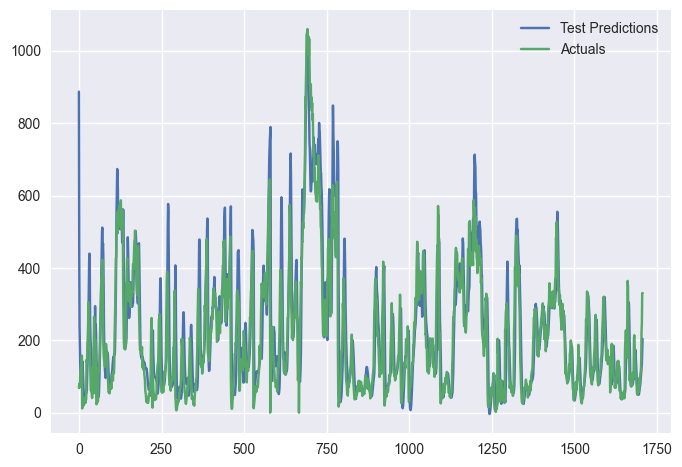

In [27]:
model = load_model('2H_Forecast/2H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(2,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D001_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D001_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)

### 3 hours forecast

In [28]:
%%time

Trainer(3,6,12,50)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_15 (Bidirecti  (None, 128)              35840     
 onal)                                                           
                                                                 
 dense_32 (Dense)            (None, 8)                 1032      
                                                                 
 dense_33 (Dense)            (None, 1)                 9         
                                                                 
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 11:37:19.096203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:37:19.373247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:37:19.408045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:37:20.028485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:37:20.054942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.7051 - mae: 0.4976 - mse: 0.7051 - mape: 129.3938

2023-02-10 11:37:25.990598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:37:26.089479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:37:26.104651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.37336, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 23s 125ms/step - loss: 0.7051 - mae: 0.4976 - mse: 0.7051 - mape: 129.3938 - val_loss: 0.3734 - val_mae: 0.4499 - val_mse: 0.3734 - val_mape: 151.6519
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.5331 - mae: 0.3529 - mse: 0.5331 - mape: 285.0568
Epoch 2: val_loss improved from 0.37336 to 0.29751, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.5331 - mae: 0.3529 - mse: 0.5331 - mape: 285.0568 - val_loss: 0.2975 - val_mae: 0.3902 - val_mse: 0.2975 - val_mape: 166.1871
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5120 - mae: 0.3358 - mse: 0.5120 - mape: 308.6757
Epoch 3: val_loss improved from 0.29751 to 0.28542, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.5120 - mae: 0.3358 - mse: 0.5120 - mape: 308.6757 - val_loss: 0.2854 - val_mae: 0.3813 - val_mse: 0.2854 - val_mape: 167.2493
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5025 - mae: 0.3260 - mse: 0.5025 - mape: 305.9499
Epoch 4: val_loss did not improve from 0.28542
161/161 [==============================] - 4s 27ms/step - loss: 0.5025 - mae: 0.3260 - mse: 0.5025 - mape: 305.9499 - val_loss: 0.2940 - val_mae: 0.3892 - val_mse: 0.2940 - val_mape: 165.8346
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.4954 - mae: 0.3243 - mse: 0.4954 - mape: 297.4297
Epoch 5: val_loss did not improve from 0.28542
161/161 [==============================] - 4s 24ms/step - loss: 0.4954 - mae: 0.3243 - mse: 0.4954 - mape: 297.4297 - val_loss: 0.2948 - val_mae: 0.3875 - val_mse: 0.2948 - val_mape: 162.4433
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.4887 - mae: 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.4691 - mae: 0.3076 - mse: 0.4691 - mape: 248.9604 - val_loss: 0.2816 - val_mae: 0.3718 - val_mse: 0.2816 - val_mape: 158.5182
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.4633 - mae: 0.3041 - mse: 0.4633 - mape: 253.9035
Epoch 10: val_loss improved from 0.28157 to 0.27583, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 109ms/step - loss: 0.4633 - mae: 0.3041 - mse: 0.4633 - mape: 253.9035 - val_loss: 0.2758 - val_mae: 0.3668 - val_mse: 0.2758 - val_mape: 153.5982
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.4560 - mae: 0.3021 - mse: 0.4560 - mape: 236.4070
Epoch 11: val_loss did not improve from 0.27583
161/161 [==============================] - 5s 34ms/step - loss: 0.4560 - mae: 0.3021 - mse: 0.4560 - mape: 236.4070 - val_loss: 0.2797 - val_mae: 0.3666 - val_mse: 0.2797 - val_mape: 152.7008
Epoch 12/50
161/161 [==============================] - ETA: 0s - loss: 0.4501 - mae: 0.2977 - mse: 0.4501 - mape: 223.3320
Epoch 12: val_loss did not improve from 0.27583
161/161 [==============================] - 5s 28ms/step - loss: 0.4501 - mae: 0.2977 - mse: 0.4501 - mape: 223.3320 - val_loss: 0.2770 - val_mae: 0.3632 - val_mse: 0.2770 - val_mape: 150.2084
Epoch 13/50
159/161 [============================>.] - ETA: 0s - loss: 0.4471 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 115ms/step - loss: 0.4323 - mae: 0.2876 - mse: 0.4323 - mape: 185.0425 - val_loss: 0.2693 - val_mae: 0.3496 - val_mse: 0.2693 - val_mape: 147.9747
Epoch 16/50
159/161 [============================>.] - ETA: 0s - loss: 0.4280 - mae: 0.2835 - mse: 0.4280 - mape: 194.3848
Epoch 16: val_loss did not improve from 0.26929
161/161 [==============================] - 4s 26ms/step - loss: 0.4259 - mae: 0.2833 - mse: 0.4259 - mape: 193.8824 - val_loss: 0.3027 - val_mae: 0.3749 - val_mse: 0.3027 - val_mape: 126.9863
Epoch 17/50
161/161 [==============================] - ETA: 0s - loss: 0.4196 - mae: 0.2817 - mse: 0.4196 - mape: 163.2236
Epoch 17: val_loss did not improve from 0.26929
161/161 [==============================] - 4s 26ms/step - loss: 0.4196 - mae: 0.2817 - mse: 0.4196 - mape: 163.2236 - val_loss: 0.3120 - val_mae: 0.3753 - val_mse: 0.3120 - val_mape: 128.7527
Epoch 18/50
161/161 [==============================] - ETA: 0s - loss: 0.4127 - 

159/161 [============================>.] - ETA: 0s - loss: 0.3245 - mae: 0.2512 - mse: 0.3245 - mape: 149.4487
Epoch 38: val_loss did not improve from 0.26929
161/161 [==============================] - 4s 25ms/step - loss: 0.3247 - mae: 0.2521 - mse: 0.3247 - mape: 149.1029 - val_loss: 0.2995 - val_mae: 0.3462 - val_mse: 0.2995 - val_mape: 143.4663
Epoch 39/50
161/161 [==============================] - ETA: 0s - loss: 0.3196 - mae: 0.2470 - mse: 0.3196 - mape: 151.6639
Epoch 39: val_loss did not improve from 0.26929
161/161 [==============================] - 4s 24ms/step - loss: 0.3196 - mae: 0.2470 - mse: 0.3196 - mape: 151.6639 - val_loss: 0.2906 - val_mae: 0.3418 - val_mse: 0.2906 - val_mape: 142.7183
Epoch 40/50
161/161 [==============================] - ETA: 0s - loss: 0.3165 - mae: 0.2481 - mse: 0.3165 - mape: 153.5474
Epoch 40: val_loss did not improve from 0.26929
161/161 [==============================] - 4s 24ms/step - loss: 0.3165 - mae: 0.2481 - mse: 0.3165 - mape: 153.5474

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 103ms/step - loss: 0.3137 - mae: 0.2481 - mse: 0.3137 - mape: 151.4749 - val_loss: 0.2684 - val_mae: 0.3337 - val_mse: 0.2684 - val_mape: 148.3124
Epoch 42/50
160/161 [============================>.] - ETA: 0s - loss: 0.3100 - mae: 0.2470 - mse: 0.3100 - mape: 157.7372
Epoch 42: val_loss did not improve from 0.26836
161/161 [==============================] - 4s 25ms/step - loss: 0.3098 - mae: 0.2470 - mse: 0.3098 - mape: 157.7909 - val_loss: 0.2904 - val_mae: 0.3461 - val_mse: 0.2904 - val_mape: 148.2137
Epoch 43/50
159/161 [============================>.] - ETA: 0s - loss: 0.3113 - mae: 0.2478 - mse: 0.3113 - mape: 151.1980
Epoch 43: val_loss did not improve from 0.26836
161/161 [==============================] - 4s 23ms/step - loss: 0.3098 - mae: 0.2475 - mse: 0.3098 - mape: 152.4564 - val_loss: 0.2846 - val_mae: 0.3420 - val_mse: 0.2846 - val_mape: 152.5528
Epoch 44/50
160/161 [============================>.] - ETA: 0s - loss: 0.3055 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.3053 - mae: 0.2474 - mse: 0.3053 - mape: 153.7634 - val_loss: 0.2632 - val_mae: 0.3327 - val_mse: 0.2632 - val_mape: 149.4181
Epoch 45/50
160/161 [============================>.] - ETA: 0s - loss: 0.3036 - mae: 0.2450 - mse: 0.3036 - mape: 150.3311
Epoch 45: val_loss did not improve from 0.26320
161/161 [==============================] - 4s 25ms/step - loss: 0.3036 - mae: 0.2451 - mse: 0.3036 - mape: 150.3760 - val_loss: 0.3047 - val_mae: 0.3516 - val_mse: 0.3047 - val_mape: 140.5792
Epoch 46/50
161/161 [==============================] - ETA: 0s - loss: 0.3019 - mae: 0.2459 - mse: 0.3019 - mape: 156.2961
Epoch 46: val_loss did not improve from 0.26320
161/161 [==============================] - 4s 23ms/step - loss: 0.3019 - mae: 0.2459 - mse: 0.3019 - mape: 156.2961 - val_loss: 0.2822 - val_mae: 0.3371 - val_mse: 0.2822 - val_mape: 147.9879
Epoch 47/50
161/161 [==============================] - ETA: 0s - loss: 0.2983 - 

2023-02-10 11:42:28.685854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:42:28.901975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:42:28.921556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:42:29.370444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:42:29.387394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.7696 - mae: 0.5528 - mse: 0.7696 - mape: 142.5238

2023-02-10 11:42:34.810938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:42:34.885067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:42:34.898204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.44266, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 22s 123ms/step - loss: 0.7696 - mae: 0.5528 - mse: 0.7696 - mape: 142.5238 - val_loss: 0.4427 - val_mae: 0.5164 - val_mse: 0.4427 - val_mape: 157.7717
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.5679 - mae: 0.3818 - mse: 0.5679 - mape: 270.8106
Epoch 2: val_loss improved from 0.44266 to 0.32414, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.5679 - mae: 0.3818 - mse: 0.5679 - mape: 270.8106 - val_loss: 0.3241 - val_mae: 0.4239 - val_mse: 0.3241 - val_mape: 145.8958
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5291 - mae: 0.3530 - mse: 0.5291 - mape: 294.5989
Epoch 3: val_loss did not improve from 0.32414
161/161 [==============================] - 4s 25ms/step - loss: 0.5291 - mae: 0.3530 - mse: 0.5291 - mape: 294.5989 - val_loss: 0.3264 - val_mae: 0.4179 - val_mse: 0.3264 - val_mape: 145.6168
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5121 - mae: 0.3366 - mse: 0.5121 - mape: 288.9650
Epoch 4: val_loss did not improve from 0.32414
161/161 [==============================] - 4s 24ms/step - loss: 0.5121 - mae: 0.3366 - mse: 0.5121 - mape: 288.9650 - val_loss: 0.3242 - val_mae: 0.4150 - val_mse: 0.3242 - val_mape: 139.7223
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5010 - mae: 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.5010 - mae: 0.3292 - mse: 0.5010 - mape: 274.8454 - val_loss: 0.3181 - val_mae: 0.4107 - val_mse: 0.3181 - val_mape: 134.3974
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.4907 - mae: 0.3220 - mse: 0.4907 - mape: 268.5391
Epoch 6: val_loss did not improve from 0.31809
161/161 [==============================] - 4s 25ms/step - loss: 0.4907 - mae: 0.3220 - mse: 0.4907 - mape: 268.5391 - val_loss: 0.3189 - val_mae: 0.4100 - val_mse: 0.3189 - val_mape: 131.1870
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.4815 - mae: 0.3173 - mse: 0.4815 - mape: 257.3848
Epoch 7: val_loss improved from 0.31809 to 0.29455, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.4815 - mae: 0.3173 - mse: 0.4815 - mape: 257.3848 - val_loss: 0.2945 - val_mae: 0.3937 - val_mse: 0.2945 - val_mape: 133.7156
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.4732 - mae: 0.3115 - mse: 0.4732 - mape: 259.8792
Epoch 8: val_loss did not improve from 0.29455
161/161 [==============================] - 4s 26ms/step - loss: 0.4732 - mae: 0.3115 - mse: 0.4732 - mape: 259.8792 - val_loss: 0.3123 - val_mae: 0.4027 - val_mse: 0.3123 - val_mape: 129.6532
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.4641 - mae: 0.3058 - mse: 0.4641 - mape: 251.7757
Epoch 9: val_loss did not improve from 0.29455
161/161 [==============================] - 4s 26ms/step - loss: 0.4641 - mae: 0.3058 - mse: 0.4641 - mape: 251.7757 - val_loss: 0.3452 - val_mae: 0.4184 - val_mse: 0.3452 - val_mape: 128.1623
Epoch 10/50
160/161 [============================>.] - ETA: 0s - loss: 0.4567 - mae:

161/161 [==============================] - ETA: 0s - loss: 0.3219 - mae: 0.2598 - mse: 0.3219 - mape: 167.3396
Epoch 30: val_loss did not improve from 0.29455
161/161 [==============================] - 4s 27ms/step - loss: 0.3219 - mae: 0.2598 - mse: 0.3219 - mape: 167.3396 - val_loss: 0.3584 - val_mae: 0.3943 - val_mse: 0.3584 - val_mape: 149.5812
Epoch 31/50
159/161 [============================>.] - ETA: 0s - loss: 0.3187 - mae: 0.2589 - mse: 0.3187 - mape: 149.2839
Epoch 31: val_loss did not improve from 0.29455
161/161 [==============================] - 4s 26ms/step - loss: 0.3176 - mae: 0.2590 - mse: 0.3176 - mape: 148.9124 - val_loss: 0.3270 - val_mae: 0.3746 - val_mse: 0.3270 - val_mape: 167.9613
Epoch 32/50
160/161 [============================>.] - ETA: 0s - loss: 0.3102 - mae: 0.2574 - mse: 0.3102 - mape: 144.6494
Epoch 32: val_loss did not improve from 0.29455
161/161 [==============================] - 4s 27ms/step - loss: 0.3131 - mae: 0.2583 - mse: 0.3131 - mape: 144.6718

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 22s 138ms/step - loss: 0.2739 - mae: 0.2496 - mse: 0.2739 - mape: 139.5650 - val_loss: 0.2825 - val_mae: 0.3544 - val_mse: 0.2825 - val_mape: 148.8067
Epoch 43/50
160/161 [============================>.] - ETA: 0s - loss: 0.2702 - mae: 0.2504 - mse: 0.2702 - mape: 141.4389
Epoch 43: val_loss did not improve from 0.28245
161/161 [==============================] - 5s 33ms/step - loss: 0.2705 - mae: 0.2507 - mse: 0.2705 - mape: 141.4886 - val_loss: 0.3271 - val_mae: 0.3774 - val_mse: 0.3271 - val_mape: 158.4505
Epoch 44/50
161/161 [==============================] - ETA: 0s - loss: 0.2675 - mae: 0.2513 - mse: 0.2675 - mape: 135.2840
Epoch 44: val_loss did not improve from 0.28245
161/161 [==============================] - 4s 27ms/step - loss: 0.2675 - mae: 0.2513 - mse: 0.2675 - mape: 135.2840 - val_loss: 0.2939 - val_mae: 0.3679 - val_mse: 0.2939 - val_mape: 173.5460
Epoch 45/50
161/161 [==============================] - ETA: 0s - loss: 0.2633 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 19s 121ms/step - loss: 0.2633 - mae: 0.2480 - mse: 0.2633 - mape: 143.3743 - val_loss: 0.2818 - val_mae: 0.3544 - val_mse: 0.2818 - val_mape: 153.6259
Epoch 46/50
161/161 [==============================] - ETA: 0s - loss: 0.2613 - mae: 0.2478 - mse: 0.2613 - mape: 138.7062
Epoch 46: val_loss did not improve from 0.28183
161/161 [==============================] - 4s 26ms/step - loss: 0.2613 - mae: 0.2478 - mse: 0.2613 - mape: 138.7062 - val_loss: 0.2917 - val_mae: 0.3631 - val_mse: 0.2917 - val_mape: 159.4483
Epoch 47/50
161/161 [==============================] - ETA: 0s - loss: 0.2578 - mae: 0.2465 - mse: 0.2578 - mape: 140.2888
Epoch 47: val_loss did not improve from 0.28183
161/161 [==============================] - 4s 25ms/step - loss: 0.2578 - mae: 0.2465 - mse: 0.2578 - mape: 140.2888 - val_loss: 0.2912 - val_mae: 0.3651 - val_mse: 0.2912 - val_mape: 162.2938
Epoch 48/50
159/161 [============================>.] - ETA: 0s - loss: 0.2565 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 114ms/step - loss: 0.2546 - mae: 0.2459 - mse: 0.2546 - mape: 135.6699 - val_loss: 0.2580 - val_mae: 0.3440 - val_mse: 0.2580 - val_mape: 159.3010
Epoch 50/50
160/161 [============================>.] - ETA: 0s - loss: 0.2521 - mae: 0.2442 - mse: 0.2521 - mape: 143.2963
Epoch 50: val_loss did not improve from 0.25802
161/161 [==============================] - 5s 29ms/step - loss: 0.2520 - mae: 0.2442 - mse: 0.2520 - mape: 143.2516 - val_loss: 0.2909 - val_mae: 0.3635 - val_mse: 0.2909 - val_mape: 164.2808

-----------------------------------------------------------------------------------------------------------

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_17 (Bidirecti  (None, 128)              35840     
 onal)                                                           
                                              

2023-02-10 11:47:48.596550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:47:49.403331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:47:49.541136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:47:50.239570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:47:50.276624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8321 - mae: 0.5747 - mse: 0.8321 - mape: 123.9316

2023-02-10 11:48:03.529560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:48:03.646943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:48:03.661180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.57210, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 36s 190ms/step - loss: 0.8321 - mae: 0.5747 - mse: 0.8321 - mape: 123.9316 - val_loss: 0.5721 - val_mae: 0.5773 - val_mse: 0.5721 - val_mape: 146.1113
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.6256 - mae: 0.4204 - mse: 0.6256 - mape: 232.6719
Epoch 2: val_loss improved from 0.57210 to 0.38920, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 109ms/step - loss: 0.6256 - mae: 0.4204 - mse: 0.6256 - mape: 232.6719 - val_loss: 0.3892 - val_mae: 0.4543 - val_mse: 0.3892 - val_mape: 148.5735
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5640 - mae: 0.3749 - mse: 0.5640 - mape: 317.3329
Epoch 3: val_loss improved from 0.38920 to 0.35223, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 25s 156ms/step - loss: 0.5640 - mae: 0.3749 - mse: 0.5640 - mape: 317.3329 - val_loss: 0.3522 - val_mae: 0.4289 - val_mse: 0.3522 - val_mape: 150.9664
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5446 - mae: 0.3605 - mse: 0.5446 - mape: 317.6968
Epoch 4: val_loss improved from 0.35223 to 0.33811, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 19s 119ms/step - loss: 0.5446 - mae: 0.3605 - mse: 0.5446 - mape: 317.6968 - val_loss: 0.3381 - val_mae: 0.4183 - val_mse: 0.3381 - val_mape: 153.5318
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5314 - mae: 0.3504 - mse: 0.5314 - mape: 320.8572
Epoch 5: val_loss improved from 0.33811 to 0.33196, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 23s 143ms/step - loss: 0.5314 - mae: 0.3504 - mse: 0.5314 - mape: 320.8572 - val_loss: 0.3320 - val_mae: 0.4139 - val_mse: 0.3320 - val_mape: 151.0178
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5194 - mae: 0.3411 - mse: 0.5194 - mape: 314.3257
Epoch 6: val_loss improved from 0.33196 to 0.32409, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 20s 124ms/step - loss: 0.5194 - mae: 0.3411 - mse: 0.5194 - mape: 314.3257 - val_loss: 0.3241 - val_mae: 0.4090 - val_mse: 0.3241 - val_mape: 147.8712
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.5099 - mae: 0.3386 - mse: 0.5099 - mape: 300.9970
Epoch 7: val_loss improved from 0.32409 to 0.32017, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.5099 - mae: 0.3386 - mse: 0.5099 - mape: 300.9970 - val_loss: 0.3202 - val_mae: 0.4057 - val_mse: 0.3202 - val_mape: 149.0081
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.4984 - mae: 0.3265 - mse: 0.4984 - mape: 279.5841
Epoch 8: val_loss improved from 0.32017 to 0.31759, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.4984 - mae: 0.3265 - mse: 0.4984 - mape: 279.5841 - val_loss: 0.3176 - val_mae: 0.4056 - val_mse: 0.3176 - val_mape: 146.1802
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.4875 - mae: 0.3204 - mse: 0.4875 - mape: 256.1107
Epoch 9: val_loss improved from 0.31759 to 0.30317, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.4875 - mae: 0.3204 - mse: 0.4875 - mape: 256.1107 - val_loss: 0.3032 - val_mae: 0.3914 - val_mse: 0.3032 - val_mape: 150.2427
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.4741 - mae: 0.3106 - mse: 0.4741 - mape: 240.1180
Epoch 10: val_loss improved from 0.30317 to 0.29656, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.4741 - mae: 0.3106 - mse: 0.4741 - mape: 240.1180 - val_loss: 0.2966 - val_mae: 0.3847 - val_mse: 0.2966 - val_mape: 149.0024
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.4624 - mae: 0.3004 - mse: 0.4624 - mape: 222.5240
Epoch 11: val_loss improved from 0.29656 to 0.28507, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 20s 121ms/step - loss: 0.4624 - mae: 0.3004 - mse: 0.4624 - mape: 222.5240 - val_loss: 0.2851 - val_mae: 0.3739 - val_mse: 0.2851 - val_mape: 143.9519
Epoch 12/50
159/161 [============================>.] - ETA: 0s - loss: 0.4525 - mae: 0.2960 - mse: 0.4525 - mape: 184.7864
Epoch 12: val_loss did not improve from 0.28507
161/161 [==============================] - 5s 28ms/step - loss: 0.4501 - mae: 0.2954 - mse: 0.4501 - mape: 184.0629 - val_loss: 0.2920 - val_mae: 0.3749 - val_mse: 0.2920 - val_mape: 142.2906
Epoch 13/50
160/161 [============================>.] - ETA: 0s - loss: 0.4427 - mae: 0.2898 - mse: 0.4427 - mape: 188.2847
Epoch 13: val_loss improved from 0.28507 to 0.28206, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.4426 - mae: 0.2898 - mse: 0.4426 - mape: 188.2599 - val_loss: 0.2821 - val_mae: 0.3672 - val_mse: 0.2821 - val_mape: 139.0507
Epoch 14/50
161/161 [==============================] - ETA: 0s - loss: 0.4358 - mae: 0.2853 - mse: 0.4358 - mape: 189.5838
Epoch 14: val_loss did not improve from 0.28206
161/161 [==============================] - 5s 29ms/step - loss: 0.4358 - mae: 0.2853 - mse: 0.4358 - mape: 189.5838 - val_loss: 0.2859 - val_mae: 0.3692 - val_mse: 0.2859 - val_mape: 137.1536
Epoch 15/50
160/161 [============================>.] - ETA: 0s - loss: 0.4293 - mae: 0.2822 - mse: 0.4293 - mape: 174.5448
Epoch 15: val_loss did not improve from 0.28206
161/161 [==============================] - 4s 26ms/step - loss: 0.4295 - mae: 0.2824 - mse: 0.4295 - mape: 174.5563 - val_loss: 0.3042 - val_mae: 0.3789 - val_mse: 0.3042 - val_mape: 139.1980
Epoch 16/50
161/161 [==============================] - ETA: 0s - loss: 0.4276 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 19s 121ms/step - loss: 0.4104 - mae: 0.2747 - mse: 0.4104 - mape: 177.3833 - val_loss: 0.2794 - val_mae: 0.3612 - val_mse: 0.2794 - val_mape: 138.7300
Epoch 20/50
161/161 [==============================] - ETA: 0s - loss: 0.4059 - mae: 0.2748 - mse: 0.4059 - mape: 183.2580
Epoch 20: val_loss did not improve from 0.27943
161/161 [==============================] - 4s 25ms/step - loss: 0.4059 - mae: 0.2748 - mse: 0.4059 - mape: 183.2580 - val_loss: 0.3248 - val_mae: 0.3827 - val_mse: 0.3248 - val_mape: 146.6220
Epoch 21/50
161/161 [==============================] - ETA: 0s - loss: 0.4018 - mae: 0.2752 - mse: 0.4018 - mape: 162.5746
Epoch 21: val_loss did not improve from 0.27943
161/161 [==============================] - 4s 24ms/step - loss: 0.4018 - mae: 0.2752 - mse: 0.4018 - mape: 162.5746 - val_loss: 0.3001 - val_mae: 0.3677 - val_mse: 0.3001 - val_mape: 143.1212
Epoch 22/50
160/161 [============================>.] - ETA: 0s - loss: 0.3970 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.3929 - mae: 0.2744 - mse: 0.3929 - mape: 172.1661 - val_loss: 0.2782 - val_mae: 0.3573 - val_mse: 0.2782 - val_mape: 143.0923
Epoch 24/50
161/161 [==============================] - ETA: 0s - loss: 0.3880 - mae: 0.2721 - mse: 0.3880 - mape: 173.8971
Epoch 24: val_loss improved from 0.27818 to 0.26461, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.3880 - mae: 0.2721 - mse: 0.3880 - mape: 173.8971 - val_loss: 0.2646 - val_mae: 0.3477 - val_mse: 0.2646 - val_mape: 145.9472
Epoch 25/50
160/161 [============================>.] - ETA: 0s - loss: 0.3817 - mae: 0.2705 - mse: 0.3817 - mape: 164.3975
Epoch 25: val_loss did not improve from 0.26461
161/161 [==============================] - 4s 26ms/step - loss: 0.3816 - mae: 0.2705 - mse: 0.3816 - mape: 164.3663 - val_loss: 0.2816 - val_mae: 0.3546 - val_mse: 0.2816 - val_mape: 146.0757
Epoch 26/50
160/161 [============================>.] - ETA: 0s - loss: 0.3755 - mae: 0.2694 - mse: 0.3755 - mape: 163.1443
Epoch 26: val_loss did not improve from 0.26461
161/161 [==============================] - 4s 26ms/step - loss: 0.3754 - mae: 0.2694 - mse: 0.3754 - mape: 163.1153 - val_loss: 0.2771 - val_mae: 0.3511 - val_mse: 0.2771 - val_mape: 145.1728
Epoch 27/50
160/161 [============================>.] - ETA: 0s - loss: 0.3689 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 17s 109ms/step - loss: 0.3456 - mae: 0.2624 - mse: 0.3456 - mape: 152.6496 - val_loss: 0.2607 - val_mae: 0.3440 - val_mse: 0.2607 - val_mape: 141.8643
Epoch 32/50
161/161 [==============================] - ETA: 0s - loss: 0.3400 - mae: 0.2623 - mse: 0.3400 - mape: 158.1161
Epoch 32: val_loss improved from 0.26066 to 0.24648, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 109ms/step - loss: 0.3400 - mae: 0.2623 - mse: 0.3400 - mape: 158.1161 - val_loss: 0.2465 - val_mae: 0.3372 - val_mse: 0.2465 - val_mape: 145.5561
Epoch 33/50
161/161 [==============================] - ETA: 0s - loss: 0.3355 - mae: 0.2601 - mse: 0.3355 - mape: 167.9681
Epoch 33: val_loss did not improve from 0.24648
161/161 [==============================] - 4s 26ms/step - loss: 0.3355 - mae: 0.2601 - mse: 0.3355 - mape: 167.9681 - val_loss: 0.2623 - val_mae: 0.3445 - val_mse: 0.2623 - val_mape: 148.1192
Epoch 34/50
160/161 [============================>.] - ETA: 0s - loss: 0.3291 - mae: 0.2588 - mse: 0.3291 - mape: 160.0060
Epoch 34: val_loss did not improve from 0.24648
161/161 [==============================] - 4s 25ms/step - loss: 0.3291 - mae: 0.2588 - mse: 0.3291 - mape: 159.9831 - val_loss: 0.2689 - val_mae: 0.3461 - val_mse: 0.2689 - val_mape: 153.6846
Epoch 35/50
160/161 [============================>.] - ETA: 0s - loss: 0.3245 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.3093 - mae: 0.2522 - mse: 0.3093 - mape: 156.4479 - val_loss: 0.2453 - val_mae: 0.3337 - val_mse: 0.2453 - val_mape: 147.3525
Epoch 39/50
160/161 [============================>.] - ETA: 0s - loss: 0.3048 - mae: 0.2516 - mse: 0.3048 - mape: 147.2681
Epoch 39: val_loss did not improve from 0.24526
161/161 [==============================] - 4s 26ms/step - loss: 0.3047 - mae: 0.2516 - mse: 0.3047 - mape: 147.2463 - val_loss: 0.2534 - val_mae: 0.3369 - val_mse: 0.2534 - val_mape: 147.7349
Epoch 40/50
159/161 [============================>.] - ETA: 0s - loss: 0.3009 - mae: 0.2499 - mse: 0.3009 - mape: 148.4727
Epoch 40: val_loss improved from 0.24526 to 0.23911, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 17s 104ms/step - loss: 0.3001 - mae: 0.2501 - mse: 0.3001 - mape: 148.2573 - val_loss: 0.2391 - val_mae: 0.3302 - val_mse: 0.2391 - val_mape: 149.6330
Epoch 41/50
161/161 [==============================] - ETA: 0s - loss: 0.2958 - mae: 0.2482 - mse: 0.2958 - mape: 147.4127
Epoch 41: val_loss did not improve from 0.23911
161/161 [==============================] - 4s 26ms/step - loss: 0.2958 - mae: 0.2482 - mse: 0.2958 - mape: 147.4127 - val_loss: 0.2559 - val_mae: 0.3386 - val_mse: 0.2559 - val_mape: 152.5396
Epoch 42/50
161/161 [==============================] - ETA: 0s - loss: 0.2918 - mae: 0.2492 - mse: 0.2918 - mape: 137.4108
Epoch 42: val_loss improved from 0.23911 to 0.23000, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.2918 - mae: 0.2492 - mse: 0.2918 - mape: 137.4108 - val_loss: 0.2300 - val_mae: 0.3244 - val_mse: 0.2300 - val_mape: 151.7622
Epoch 43/50
161/161 [==============================] - ETA: 0s - loss: 0.2874 - mae: 0.2463 - mse: 0.2874 - mape: 155.3434
Epoch 43: val_loss did not improve from 0.23000
161/161 [==============================] - 4s 26ms/step - loss: 0.2874 - mae: 0.2463 - mse: 0.2874 - mape: 155.3434 - val_loss: 0.2514 - val_mae: 0.3352 - val_mse: 0.2514 - val_mape: 160.1503
Epoch 44/50
160/161 [============================>.] - ETA: 0s - loss: 0.2830 - mae: 0.2437 - mse: 0.2830 - mape: 139.1772
Epoch 44: val_loss did not improve from 0.23000
161/161 [==============================] - 5s 29ms/step - loss: 0.2829 - mae: 0.2437 - mse: 0.2829 - mape: 139.1547 - val_loss: 0.2343 - val_mae: 0.3240 - val_mse: 0.2343 - val_mape: 147.7563
Epoch 45/50
161/161 [==============================] - ETA: 0s - loss: 0.2796 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.2643 - mae: 0.2400 - mse: 0.2643 - mape: 132.0115 - val_loss: 0.2181 - val_mae: 0.3100 - val_mse: 0.2181 - val_mape: 147.2782
Epoch 50/50
159/161 [============================>.] - ETA: 0s - loss: 0.2642 - mae: 0.2405 - mse: 0.2642 - mape: 129.0560
Epoch 50: val_loss did not improve from 0.21807
161/161 [==============================] - 4s 26ms/step - loss: 0.2631 - mae: 0.2404 - mse: 0.2631 - mape: 128.7214 - val_loss: 0.2467 - val_mae: 0.3238 - val_mse: 0.2467 - val_mape: 152.5531

-----------------------------------------------------------------------------------------------------------

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_18 (Bidirecti  (None, 128)              35840     
 onal)                                                           
                                              

2023-02-10 11:56:36.878582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:56:37.083190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:56:37.106285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:56:37.592278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:56:37.610334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.7627 - mae: 0.5474 - mse: 0.7627 - mape: 202.7474

2023-02-10 11:56:43.215589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:56:43.304459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:56:43.318983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.43276, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 24s 131ms/step - loss: 0.7627 - mae: 0.5474 - mse: 0.7627 - mape: 202.7474 - val_loss: 0.4328 - val_mae: 0.4904 - val_mse: 0.4328 - val_mape: 147.0930
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.5866 - mae: 0.3923 - mse: 0.5866 - mape: 295.6927
Epoch 2: val_loss improved from 0.43276 to 0.35915, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.5866 - mae: 0.3923 - mse: 0.5866 - mape: 295.6927 - val_loss: 0.3591 - val_mae: 0.4338 - val_mse: 0.3591 - val_mape: 161.7875
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5515 - mae: 0.3628 - mse: 0.5515 - mape: 331.1526
Epoch 3: val_loss improved from 0.35915 to 0.35312, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 114ms/step - loss: 0.5515 - mae: 0.3628 - mse: 0.5515 - mape: 331.1526 - val_loss: 0.3531 - val_mae: 0.4267 - val_mse: 0.3531 - val_mape: 152.3570
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5328 - mae: 0.3519 - mse: 0.5328 - mape: 319.4927
Epoch 4: val_loss improved from 0.35312 to 0.35119, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.5328 - mae: 0.3519 - mse: 0.5328 - mape: 319.4927 - val_loss: 0.3512 - val_mae: 0.4229 - val_mse: 0.3512 - val_mape: 150.7491
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5179 - mae: 0.3419 - mse: 0.5179 - mape: 307.1759
Epoch 5: val_loss improved from 0.35119 to 0.33605, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.5179 - mae: 0.3419 - mse: 0.5179 - mape: 307.1759 - val_loss: 0.3360 - val_mae: 0.4137 - val_mse: 0.3360 - val_mape: 150.5501
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5041 - mae: 0.3333 - mse: 0.5041 - mape: 292.3699
Epoch 6: val_loss did not improve from 0.33605
161/161 [==============================] - 4s 27ms/step - loss: 0.5041 - mae: 0.3333 - mse: 0.5041 - mape: 292.3699 - val_loss: 0.3622 - val_mae: 0.4246 - val_mse: 0.3622 - val_mape: 151.1292
Epoch 7/50
160/161 [============================>.] - ETA: 0s - loss: 0.4908 - mae: 0.3262 - mse: 0.4908 - mape: 282.6683
Epoch 7: val_loss did not improve from 0.33605
161/161 [==============================] - 4s 25ms/step - loss: 0.4907 - mae: 0.3262 - mse: 0.4907 - mape: 282.6173 - val_loss: 0.3491 - val_mae: 0.4183 - val_mse: 0.3491 - val_mape: 149.4672
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.4763 - mae: 

159/161 [============================>.] - ETA: 0s - loss: 0.3294 - mae: 0.2668 - mse: 0.3294 - mape: 183.4420
Epoch 28: val_loss did not improve from 0.33605
161/161 [==============================] - 4s 26ms/step - loss: 0.3437 - mae: 0.2679 - mse: 0.3437 - mape: 182.9461 - val_loss: 0.3753 - val_mae: 0.4064 - val_mse: 0.3753 - val_mape: 161.6682
Epoch 29/50
160/161 [============================>.] - ETA: 0s - loss: 0.3356 - mae: 0.2636 - mse: 0.3356 - mape: 184.3551
Epoch 29: val_loss did not improve from 0.33605
161/161 [==============================] - 5s 29ms/step - loss: 0.3355 - mae: 0.2636 - mse: 0.3355 - mape: 184.3504 - val_loss: 0.4295 - val_mae: 0.4341 - val_mse: 0.4295 - val_mape: 165.3008
Epoch 30/50
159/161 [============================>.] - ETA: 0s - loss: 0.3340 - mae: 0.2670 - mse: 0.3340 - mape: 183.9476
Epoch 30: val_loss did not improve from 0.33605
161/161 [==============================] - 4s 26ms/step - loss: 0.3333 - mae: 0.2673 - mse: 0.3333 - mape: 183.2749

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 20s 126ms/step - loss: 0.2920 - mae: 0.2535 - mse: 0.2920 - mape: 168.9372 - val_loss: 0.3342 - val_mae: 0.3844 - val_mse: 0.3342 - val_mape: 165.6998
Epoch 40/50
159/161 [============================>.] - ETA: 0s - loss: 0.2903 - mae: 0.2544 - mse: 0.2903 - mape: 171.4457
Epoch 40: val_loss did not improve from 0.33422
161/161 [==============================] - 4s 26ms/step - loss: 0.2889 - mae: 0.2540 - mse: 0.2889 - mape: 170.7897 - val_loss: 0.3482 - val_mae: 0.3889 - val_mse: 0.3482 - val_mape: 173.4612
Epoch 41/50
161/161 [==============================] - ETA: 0s - loss: 0.2859 - mae: 0.2549 - mse: 0.2859 - mape: 167.8830
Epoch 41: val_loss did not improve from 0.33422
161/161 [==============================] - 4s 27ms/step - loss: 0.2859 - mae: 0.2549 - mse: 0.2859 - mape: 167.8830 - val_loss: 0.3808 - val_mae: 0.4029 - val_mse: 0.3808 - val_mape: 176.3521
Epoch 42/50
160/161 [============================>.] - ETA: 0s - loss: 0.2828 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 19s 116ms/step - loss: 0.2828 - mae: 0.2522 - mse: 0.2828 - mape: 160.4972 - val_loss: 0.3176 - val_mae: 0.3750 - val_mse: 0.3176 - val_mape: 164.4516
Epoch 43/50
160/161 [============================>.] - ETA: 0s - loss: 0.2787 - mae: 0.2495 - mse: 0.2787 - mape: 154.9609
Epoch 43: val_loss did not improve from 0.31764
161/161 [==============================] - 6s 34ms/step - loss: 0.2787 - mae: 0.2495 - mse: 0.2787 - mape: 154.9680 - val_loss: 0.3551 - val_mae: 0.3933 - val_mse: 0.3551 - val_mape: 166.8547
Epoch 44/50
160/161 [============================>.] - ETA: 0s - loss: 0.2763 - mae: 0.2502 - mse: 0.2763 - mape: 160.1753
Epoch 44: val_loss did not improve from 0.31764
161/161 [==============================] - 6s 36ms/step - loss: 0.2763 - mae: 0.2502 - mse: 0.2763 - mape: 160.1510 - val_loss: 0.3546 - val_mae: 0.3913 - val_mse: 0.3546 - val_mape: 174.6748
Epoch 45/50
161/161 [==============================] - ETA: 0s - loss: 0.2728 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 19s 120ms/step - loss: 0.2667 - mae: 0.2470 - mse: 0.2667 - mape: 158.1223 - val_loss: 0.3167 - val_mae: 0.3697 - val_mse: 0.3167 - val_mape: 180.6559
Epoch 48/50
161/161 [==============================] - ETA: 0s - loss: 0.2663 - mae: 0.2468 - mse: 0.2663 - mape: 153.0881
Epoch 48: val_loss did not improve from 0.31673
161/161 [==============================] - 5s 32ms/step - loss: 0.2663 - mae: 0.2468 - mse: 0.2663 - mape: 153.0881 - val_loss: 0.3310 - val_mae: 0.3782 - val_mse: 0.3310 - val_mape: 177.5817
Epoch 49/50
160/161 [============================>.] - ETA: 0s - loss: 0.2624 - mae: 0.2458 - mse: 0.2624 - mape: 152.2999
Epoch 49: val_loss did not improve from 0.31673
161/161 [==============================] - 5s 30ms/step - loss: 0.2623 - mae: 0.2458 - mse: 0.2623 - mape: 152.2716 - val_loss: 0.3470 - val_mae: 0.3893 - val_mse: 0.3470 - val_mape: 176.4829
Epoch 50/50
160/161 [============================>.] - ETA: 0s - loss: 0.2585 - 

2023-02-10 12:02:22.254355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:02:22.487355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:02:22.528708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:02:23.054238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:02:23.082892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8130 - mae: 0.5732 - mse: 0.8130 - mape: 152.4044

2023-02-10 12:02:30.402686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:02:30.484077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:02:30.501419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.45916, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 26s 145ms/step - loss: 0.8130 - mae: 0.5732 - mse: 0.8130 - mape: 152.4044 - val_loss: 0.4592 - val_mae: 0.5077 - val_mse: 0.4592 - val_mape: 151.4369
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.6002 - mae: 0.4093 - mse: 0.6002 - mape: 287.6625
Epoch 2: val_loss improved from 0.45916 to 0.35740, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 20s 122ms/step - loss: 0.6002 - mae: 0.4093 - mse: 0.6002 - mape: 287.6625 - val_loss: 0.3574 - val_mae: 0.4246 - val_mse: 0.3574 - val_mape: 168.2791
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5555 - mae: 0.3726 - mse: 0.5555 - mape: 327.9157
Epoch 3: val_loss did not improve from 0.35740
161/161 [==============================] - 4s 27ms/step - loss: 0.5555 - mae: 0.3726 - mse: 0.5555 - mape: 327.9157 - val_loss: 0.3616 - val_mae: 0.4268 - val_mse: 0.3616 - val_mape: 166.9047
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5345 - mae: 0.3597 - mse: 0.5345 - mape: 330.6477
Epoch 4: val_loss did not improve from 0.35740
161/161 [==============================] - 4s 27ms/step - loss: 0.5345 - mae: 0.3597 - mse: 0.5345 - mape: 330.6477 - val_loss: 0.3678 - val_mae: 0.4294 - val_mse: 0.3678 - val_mape: 165.0981
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5170 - mae: 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.4854 - mae: 0.3273 - mse: 0.4854 - mape: 302.4123 - val_loss: 0.3472 - val_mae: 0.4159 - val_mse: 0.3472 - val_mape: 164.0332
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.4720 - mae: 0.3212 - mse: 0.4720 - mape: 290.8426
Epoch 8: val_loss did not improve from 0.34716
161/161 [==============================] - 5s 29ms/step - loss: 0.4720 - mae: 0.3212 - mse: 0.4720 - mape: 290.8426 - val_loss: 0.3566 - val_mae: 0.4205 - val_mse: 0.3566 - val_mape: 162.9613
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.4604 - mae: 0.3128 - mse: 0.4604 - mape: 282.2040
Epoch 9: val_loss did not improve from 0.34716
161/161 [==============================] - 4s 27ms/step - loss: 0.4604 - mae: 0.3128 - mse: 0.4604 - mape: 282.2040 - val_loss: 0.3752 - val_mae: 0.4323 - val_mse: 0.3752 - val_mape: 161.6808
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.4471 - mae:

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 19s 116ms/step - loss: 0.3465 - mae: 0.2746 - mse: 0.3465 - mape: 201.0307 - val_loss: 0.3423 - val_mae: 0.3861 - val_mse: 0.3423 - val_mape: 175.0103
Epoch 24/50
159/161 [============================>.] - ETA: 0s - loss: 0.3418 - mae: 0.2742 - mse: 0.3418 - mape: 194.8226
Epoch 24: val_loss did not improve from 0.34227
161/161 [==============================] - 4s 25ms/step - loss: 0.3410 - mae: 0.2745 - mse: 0.3410 - mape: 194.0049 - val_loss: 0.3587 - val_mae: 0.3942 - val_mse: 0.3587 - val_mape: 171.3815
Epoch 25/50
161/161 [==============================] - ETA: 0s - loss: 0.3341 - mae: 0.2753 - mse: 0.3341 - mape: 192.4644
Epoch 25: val_loss did not improve from 0.34227
161/161 [==============================] - 4s 25ms/step - loss: 0.3341 - mae: 0.2753 - mse: 0.3341 - mape: 192.4644 - val_loss: 0.3770 - val_mae: 0.3992 - val_mse: 0.3770 - val_mape: 184.1116
Epoch 26/50
160/161 [============================>.] - ETA: 0s - loss: 0.3271 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 19s 120ms/step - loss: 0.3053 - mae: 0.2625 - mse: 0.3053 - mape: 181.5961 - val_loss: 0.3198 - val_mae: 0.3712 - val_mse: 0.3198 - val_mape: 181.5861
Epoch 31/50
161/161 [==============================] - ETA: 0s - loss: 0.3019 - mae: 0.2621 - mse: 0.3019 - mape: 167.8062
Epoch 31: val_loss improved from 0.31979 to 0.30687, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 20s 121ms/step - loss: 0.3019 - mae: 0.2621 - mse: 0.3019 - mape: 167.8062 - val_loss: 0.3069 - val_mae: 0.3664 - val_mse: 0.3069 - val_mape: 192.4944
Epoch 32/50
161/161 [==============================] - ETA: 0s - loss: 0.2979 - mae: 0.2615 - mse: 0.2979 - mape: 175.0975
Epoch 32: val_loss did not improve from 0.30687
161/161 [==============================] - 5s 31ms/step - loss: 0.2979 - mae: 0.2615 - mse: 0.2979 - mape: 175.0975 - val_loss: 0.3490 - val_mae: 0.3845 - val_mse: 0.3490 - val_mape: 185.8273
Epoch 33/50
160/161 [============================>.] - ETA: 0s - loss: 0.2930 - mae: 0.2593 - mse: 0.2930 - mape: 160.1157
Epoch 33: val_loss did not improve from 0.30687
161/161 [==============================] - 5s 30ms/step - loss: 0.2929 - mae: 0.2592 - mse: 0.2929 - mape: 160.0846 - val_loss: 0.3309 - val_mae: 0.3801 - val_mse: 0.3309 - val_mape: 197.0033
Epoch 34/50
160/161 [============================>.] - ETA: 0s - loss: 0.2888 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.2719 - mae: 0.2510 - mse: 0.2719 - mape: 154.5164 - val_loss: 0.2885 - val_mae: 0.3669 - val_mse: 0.2885 - val_mape: 204.8889
Epoch 40/50
160/161 [============================>.] - ETA: 0s - loss: 0.2676 - mae: 0.2505 - mse: 0.2676 - mape: 141.9227
Epoch 40: val_loss did not improve from 0.28845
161/161 [==============================] - 5s 29ms/step - loss: 0.2677 - mae: 0.2506 - mse: 0.2677 - mape: 142.0622 - val_loss: 0.3300 - val_mae: 0.3695 - val_mse: 0.3300 - val_mape: 199.2255
Epoch 41/50
159/161 [============================>.] - ETA: 0s - loss: 0.2659 - mae: 0.2493 - mse: 0.2659 - mape: 143.7595
Epoch 41: val_loss improved from 0.28845 to 0.28673, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 19s 117ms/step - loss: 0.2671 - mae: 0.2496 - mse: 0.2671 - mape: 143.8918 - val_loss: 0.2867 - val_mae: 0.3570 - val_mse: 0.2867 - val_mape: 186.3501
Epoch 42/50
160/161 [============================>.] - ETA: 0s - loss: 0.2624 - mae: 0.2477 - mse: 0.2624 - mape: 147.5184
Epoch 42: val_loss did not improve from 0.28673
161/161 [==============================] - 5s 33ms/step - loss: 0.2623 - mae: 0.2477 - mse: 0.2623 - mape: 147.5002 - val_loss: 0.3172 - val_mae: 0.3675 - val_mse: 0.3172 - val_mape: 198.4838
Epoch 43/50
161/161 [==============================] - ETA: 0s - loss: 0.2578 - mae: 0.2482 - mse: 0.2578 - mape: 148.5227
Epoch 43: val_loss improved from 0.28673 to 0.28364, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 19s 116ms/step - loss: 0.2578 - mae: 0.2482 - mse: 0.2578 - mape: 148.5227 - val_loss: 0.2836 - val_mae: 0.3523 - val_mse: 0.2836 - val_mape: 198.5141
Epoch 44/50
159/161 [============================>.] - ETA: 0s - loss: 0.2581 - mae: 0.2462 - mse: 0.2581 - mape: 139.9034
Epoch 44: val_loss did not improve from 0.28364
161/161 [==============================] - 4s 26ms/step - loss: 0.2568 - mae: 0.2455 - mse: 0.2568 - mape: 139.7054 - val_loss: 0.2909 - val_mae: 0.3568 - val_mse: 0.2909 - val_mape: 202.1781
Epoch 45/50
161/161 [==============================] - ETA: 0s - loss: 0.2524 - mae: 0.2439 - mse: 0.2524 - mape: 138.1738
Epoch 45: val_loss did not improve from 0.28364
161/161 [==============================] - 4s 25ms/step - loss: 0.2524 - mae: 0.2439 - mse: 0.2524 - mape: 138.1738 - val_loss: 0.2997 - val_mae: 0.3577 - val_mse: 0.2997 - val_mape: 202.5722
Epoch 46/50
159/161 [============================>.] - ETA: 0s - loss: 0.2515 - 

2023-02-10 12:08:21.912232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:08:22.125617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:08:22.125808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:08:22.696616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:08:22.723338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


159/160 [============================>.] - ETA: 0s - loss: 0.8043 - mae: 0.5611 - mse: 0.8043 - mape: 178.9180

2023-02-10 12:08:28.893966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:08:28.989929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:08:29.004288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.54608, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 25s 140ms/step - loss: 0.8011 - mae: 0.5603 - mse: 0.8011 - mape: 178.3737 - val_loss: 0.5461 - val_mae: 0.5387 - val_mse: 0.5461 - val_mape: 153.7949
Epoch 2/50
158/160 [============================>.] - ETA: 0s - loss: 0.6148 - mae: 0.4112 - mse: 0.6148 - mape: 335.5876
Epoch 2: val_loss improved from 0.54608 to 0.42035, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 19s 119ms/step - loss: 0.6100 - mae: 0.4107 - mse: 0.6100 - mape: 332.8768 - val_loss: 0.4203 - val_mae: 0.4593 - val_mse: 0.4203 - val_mape: 157.5171
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.5712 - mae: 0.3803 - mse: 0.5712 - mape: 356.7267
Epoch 3: val_loss improved from 0.42035 to 0.39912, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 18s 114ms/step - loss: 0.5712 - mae: 0.3803 - mse: 0.5712 - mape: 356.7267 - val_loss: 0.3991 - val_mae: 0.4485 - val_mse: 0.3991 - val_mape: 155.8222
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.5485 - mae: 0.3626 - mse: 0.5485 - mape: 360.8671
Epoch 4: val_loss improved from 0.39912 to 0.39096, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 19s 122ms/step - loss: 0.5485 - mae: 0.3626 - mse: 0.5485 - mape: 360.8671 - val_loss: 0.3910 - val_mae: 0.4440 - val_mse: 0.3910 - val_mape: 152.9555
Epoch 5/50
159/160 [============================>.] - ETA: 0s - loss: 0.5314 - mae: 0.3575 - mse: 0.5314 - mape: 339.2477
Epoch 5: val_loss improved from 0.39096 to 0.38581, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 19s 117ms/step - loss: 0.5294 - mae: 0.3574 - mse: 0.5294 - mape: 337.5145 - val_loss: 0.3858 - val_mae: 0.4406 - val_mse: 0.3858 - val_mape: 153.8954
Epoch 6/50
159/160 [============================>.] - ETA: 0s - loss: 0.5140 - mae: 0.3462 - mse: 0.5140 - mape: 340.3680
Epoch 6: val_loss improved from 0.38581 to 0.37093, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 20s 122ms/step - loss: 0.5115 - mae: 0.3454 - mse: 0.5115 - mape: 339.3415 - val_loss: 0.3709 - val_mae: 0.4340 - val_mse: 0.3709 - val_mape: 151.8096
Epoch 7/50
159/160 [============================>.] - ETA: 0s - loss: 0.4956 - mae: 0.3355 - mse: 0.4956 - mape: 316.9034
Epoch 7: val_loss did not improve from 0.37093
160/160 [==============================] - 5s 28ms/step - loss: 0.4938 - mae: 0.3353 - mse: 0.4938 - mape: 315.9935 - val_loss: 0.3955 - val_mae: 0.4450 - val_mse: 0.3955 - val_mape: 149.4873
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.4788 - mae: 0.3316 - mse: 0.4788 - mape: 305.9674
Epoch 8: val_loss did not improve from 0.37093
160/160 [==============================] - 4s 28ms/step - loss: 0.4788 - mae: 0.3316 - mse: 0.4788 - mape: 305.9674 - val_loss: 0.3821 - val_mae: 0.4362 - val_mse: 0.3821 - val_mape: 155.4239
Epoch 9/50
159/160 [============================>.] - ETA: 0s - loss: 0.4685 - mae: 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 19s 119ms/step - loss: 0.4666 - mae: 0.3218 - mse: 0.4666 - mape: 260.8589 - val_loss: 0.3696 - val_mae: 0.4269 - val_mse: 0.3696 - val_mape: 152.0671
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.4526 - mae: 0.3150 - mse: 0.4526 - mape: 258.2273
Epoch 10: val_loss did not improve from 0.36959
160/160 [==============================] - 7s 42ms/step - loss: 0.4526 - mae: 0.3150 - mse: 0.4526 - mape: 258.2273 - val_loss: 0.3790 - val_mae: 0.4263 - val_mse: 0.3790 - val_mape: 153.0135
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.4405 - mae: 0.3110 - mse: 0.4405 - mape: 241.8098
Epoch 11: val_loss did not improve from 0.36959
160/160 [==============================] - 6s 39ms/step - loss: 0.4405 - mae: 0.3110 - mse: 0.4405 - mape: 241.8098 - val_loss: 0.3790 - val_mae: 0.4277 - val_mse: 0.3790 - val_mape: 151.0643
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 0.4306 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 18s 114ms/step - loss: 0.3818 - mae: 0.2901 - mse: 0.3818 - mape: 192.5376 - val_loss: 0.3657 - val_mae: 0.3999 - val_mse: 0.3657 - val_mape: 167.7580
Epoch 19/50
158/160 [============================>.] - ETA: 0s - loss: 0.3774 - mae: 0.2869 - mse: 0.3774 - mape: 198.4747
Epoch 19: val_loss did not improve from 0.36572
160/160 [==============================] - 4s 25ms/step - loss: 0.3744 - mae: 0.2866 - mse: 0.3744 - mape: 197.1694 - val_loss: 0.3824 - val_mae: 0.4102 - val_mse: 0.3824 - val_mape: 163.0375
Epoch 20/50
158/160 [============================>.] - ETA: 0s - loss: 0.3689 - mae: 0.2862 - mse: 0.3689 - mape: 205.3360
Epoch 20: val_loss did not improve from 0.36572
160/160 [==============================] - 4s 23ms/step - loss: 0.3661 - mae: 0.2861 - mse: 0.3661 - mape: 203.8281 - val_loss: 0.4040 - val_mae: 0.4210 - val_mse: 0.4040 - val_mape: 168.9392
Epoch 21/50
160/160 [==============================] - ETA: 0s - loss: 0.3605 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 18s 113ms/step - loss: 0.3061 - mae: 0.2638 - mse: 0.3061 - mape: 170.0422 - val_loss: 0.3494 - val_mae: 0.3857 - val_mse: 0.3494 - val_mape: 173.3915
Epoch 30/50
158/160 [============================>.] - ETA: 0s - loss: 0.3042 - mae: 0.2639 - mse: 0.3042 - mape: 178.7313
Epoch 30: val_loss did not improve from 0.34944
160/160 [==============================] - 4s 23ms/step - loss: 0.3016 - mae: 0.2636 - mse: 0.3016 - mape: 177.3881 - val_loss: 0.3719 - val_mae: 0.3973 - val_mse: 0.3719 - val_mape: 165.5003
Epoch 31/50
158/160 [============================>.] - ETA: 0s - loss: 0.2988 - mae: 0.2619 - mse: 0.2988 - mape: 175.4337
Epoch 31: val_loss did not improve from 0.34944
160/160 [==============================] - 4s 26ms/step - loss: 0.2965 - mae: 0.2616 - mse: 0.2965 - mape: 173.9298 - val_loss: 0.3566 - val_mae: 0.3882 - val_mse: 0.3566 - val_mape: 176.9915
Epoch 32/50
160/160 [==============================] - ETA: 0s - loss: 0.2929 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 105ms/step - loss: 0.2871 - mae: 0.2562 - mse: 0.2871 - mape: 170.6264 - val_loss: 0.3466 - val_mae: 0.3824 - val_mse: 0.3466 - val_mape: 194.0875
Epoch 34/50
160/160 [==============================] - ETA: 0s - loss: 0.2822 - mae: 0.2522 - mse: 0.2822 - mape: 167.0225
Epoch 34: val_loss improved from 0.34658 to 0.34630, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 18s 111ms/step - loss: 0.2822 - mae: 0.2522 - mse: 0.2822 - mape: 167.0225 - val_loss: 0.3463 - val_mae: 0.3821 - val_mse: 0.3463 - val_mape: 163.7440
Epoch 35/50
158/160 [============================>.] - ETA: 0s - loss: 0.2815 - mae: 0.2536 - mse: 0.2815 - mape: 147.3125
Epoch 35: val_loss did not improve from 0.34630
160/160 [==============================] - 4s 23ms/step - loss: 0.2790 - mae: 0.2532 - mse: 0.2790 - mape: 148.0206 - val_loss: 0.3724 - val_mae: 0.3929 - val_mse: 0.3724 - val_mape: 172.2728
Epoch 36/50
158/160 [============================>.] - ETA: 0s - loss: 0.2772 - mae: 0.2520 - mse: 0.2772 - mape: 155.4022
Epoch 36: val_loss did not improve from 0.34630
160/160 [==============================] - 4s 26ms/step - loss: 0.2759 - mae: 0.2520 - mse: 0.2759 - mape: 155.8004 - val_loss: 0.3613 - val_mae: 0.3863 - val_mse: 0.3613 - val_mape: 163.8733
Epoch 37/50
160/160 [==============================] - ETA: 0s - loss: 0.2705 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 18s 112ms/step - loss: 0.2579 - mae: 0.2426 - mse: 0.2579 - mape: 136.8304 - val_loss: 0.3346 - val_mae: 0.3683 - val_mse: 0.3346 - val_mape: 170.0350
Epoch 42/50
159/160 [============================>.] - ETA: 0s - loss: 0.2556 - mae: 0.2415 - mse: 0.2556 - mape: 138.9113
Epoch 42: val_loss improved from 0.33459 to 0.32537, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 18s 111ms/step - loss: 0.2544 - mae: 0.2411 - mse: 0.2544 - mape: 138.3189 - val_loss: 0.3254 - val_mae: 0.3639 - val_mse: 0.3254 - val_mape: 169.6666
Epoch 43/50
159/160 [============================>.] - ETA: 0s - loss: 0.2521 - mae: 0.2386 - mse: 0.2521 - mape: 130.9926
Epoch 43: val_loss did not improve from 0.32537
160/160 [==============================] - 4s 25ms/step - loss: 0.2512 - mae: 0.2383 - mse: 0.2512 - mape: 131.0137 - val_loss: 0.3522 - val_mae: 0.3758 - val_mse: 0.3522 - val_mape: 161.7311
Epoch 44/50
159/160 [============================>.] - ETA: 0s - loss: 0.2491 - mae: 0.2370 - mse: 0.2491 - mape: 125.8103
Epoch 44: val_loss improved from 0.32537 to 0.32233, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 18s 112ms/step - loss: 0.2485 - mae: 0.2372 - mse: 0.2485 - mape: 125.7237 - val_loss: 0.3223 - val_mae: 0.3614 - val_mse: 0.3223 - val_mape: 165.5947
Epoch 45/50
159/160 [============================>.] - ETA: 0s - loss: 0.2483 - mae: 0.2384 - mse: 0.2483 - mape: 126.1424
Epoch 45: val_loss did not improve from 0.32233
160/160 [==============================] - 4s 25ms/step - loss: 0.2471 - mae: 0.2380 - mse: 0.2471 - mape: 125.9002 - val_loss: 0.3233 - val_mae: 0.3608 - val_mse: 0.3233 - val_mape: 167.5403
Epoch 46/50
158/160 [============================>.] - ETA: 0s - loss: 0.2466 - mae: 0.2378 - mse: 0.2466 - mape: 134.5591
Epoch 46: val_loss did not improve from 0.32233
160/160 [==============================] - 4s 25ms/step - loss: 0.2446 - mae: 0.2374 - mse: 0.2446 - mape: 134.2991 - val_loss: 0.3563 - val_mae: 0.3739 - val_mse: 0.3563 - val_mape: 171.4500
Epoch 47/50
160/160 [==============================] - ETA: 0s - loss: 0.2422 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 18s 111ms/step - loss: 0.2384 - mae: 0.2334 - mse: 0.2384 - mape: 124.8699 - val_loss: 0.3057 - val_mae: 0.3520 - val_mse: 0.3057 - val_mape: 157.7581
Epoch 49/50
158/160 [============================>.] - ETA: 0s - loss: 0.2390 - mae: 0.2334 - mse: 0.2390 - mape: 125.7999
Epoch 49: val_loss did not improve from 0.30566
160/160 [==============================] - 4s 26ms/step - loss: 0.2379 - mae: 0.2333 - mse: 0.2379 - mape: 125.2374 - val_loss: 0.3166 - val_mae: 0.3554 - val_mse: 0.3166 - val_mape: 170.7474
Epoch 50/50
158/160 [============================>.] - ETA: 0s - loss: 0.2368 - mae: 0.2296 - mse: 0.2368 - mape: 133.4918
Epoch 50: val_loss did not improve from 0.30566
160/160 [==============================] - 4s 24ms/step - loss: 0.2356 - mae: 0.2299 - mse: 0.2356 - mape: 132.6351 - val_loss: 0.3492 - val_mae: 0.3701 - val_mse: 0.3492 - val_mape: 159.1736

-------------------------------------------------------------------------------

2023-02-10 12:15:28.874247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:15:29.135828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:15:29.176136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:15:29.677259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:15:29.697207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.8508 - mae: 0.5720 - mse: 0.8508 - mape: 161.4654

2023-02-10 12:15:36.994297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:15:37.125144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:15:37.163292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.74456, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 28s 151ms/step - loss: 0.8508 - mae: 0.5720 - mse: 0.8508 - mape: 161.4654 - val_loss: 0.7446 - val_mae: 0.6369 - val_mse: 0.7446 - val_mape: 112.5246
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.6446 - mae: 0.4266 - mse: 0.6446 - mape: 245.0387
Epoch 2: val_loss improved from 0.74456 to 0.47900, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 20s 126ms/step - loss: 0.6446 - mae: 0.4266 - mse: 0.6446 - mape: 245.0387 - val_loss: 0.4790 - val_mae: 0.4926 - val_mse: 0.4790 - val_mape: 119.4707
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.5789 - mae: 0.3821 - mse: 0.5789 - mape: 280.0403
Epoch 3: val_loss improved from 0.47900 to 0.39820, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 26s 161ms/step - loss: 0.5789 - mae: 0.3821 - mse: 0.5789 - mape: 280.0403 - val_loss: 0.3982 - val_mae: 0.4486 - val_mse: 0.3982 - val_mape: 119.7916
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.5410 - mae: 0.3618 - mse: 0.5410 - mape: 261.5546
Epoch 4: val_loss improved from 0.39820 to 0.38357, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 22s 138ms/step - loss: 0.5410 - mae: 0.3618 - mse: 0.5410 - mape: 261.5546 - val_loss: 0.3836 - val_mae: 0.4443 - val_mse: 0.3836 - val_mape: 118.0370
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.5107 - mae: 0.3395 - mse: 0.5107 - mape: 253.7710
Epoch 5: val_loss improved from 0.38357 to 0.35454, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 19s 116ms/step - loss: 0.5107 - mae: 0.3395 - mse: 0.5107 - mape: 253.7710 - val_loss: 0.3545 - val_mae: 0.4288 - val_mse: 0.3545 - val_mape: 122.2741
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.4892 - mae: 0.3273 - mse: 0.4892 - mape: 249.0721
Epoch 6: val_loss did not improve from 0.35454
160/160 [==============================] - 4s 27ms/step - loss: 0.4892 - mae: 0.3273 - mse: 0.4892 - mape: 249.0721 - val_loss: 0.3752 - val_mae: 0.4413 - val_mse: 0.3752 - val_mape: 122.5001
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.4743 - mae: 0.3165 - mse: 0.4743 - mape: 248.7920
Epoch 7: val_loss improved from 0.35454 to 0.33877, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 20s 124ms/step - loss: 0.4743 - mae: 0.3165 - mse: 0.4743 - mape: 248.7920 - val_loss: 0.3388 - val_mae: 0.4184 - val_mse: 0.3388 - val_mape: 120.7252
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.4625 - mae: 0.3105 - mse: 0.4625 - mape: 248.1770
Epoch 8: val_loss did not improve from 0.33877
160/160 [==============================] - 5s 28ms/step - loss: 0.4625 - mae: 0.3105 - mse: 0.4625 - mape: 248.1770 - val_loss: 0.3808 - val_mae: 0.4376 - val_mse: 0.3808 - val_mape: 130.0405
Epoch 9/50
159/160 [============================>.] - ETA: 0s - loss: 0.4542 - mae: 0.3055 - mse: 0.4542 - mape: 241.9963
Epoch 9: val_loss did not improve from 0.33877
160/160 [==============================] - 5s 31ms/step - loss: 0.4528 - mae: 0.3057 - mse: 0.4528 - mape: 241.3490 - val_loss: 0.3970 - val_mae: 0.4461 - val_mse: 0.3970 - val_mape: 131.1773
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.4439 - mae:

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 18s 111ms/step - loss: 0.3579 - mae: 0.2683 - mse: 0.3579 - mape: 184.3392 - val_loss: 0.3127 - val_mae: 0.3734 - val_mse: 0.3127 - val_mape: 144.0063
Epoch 26/50
160/160 [==============================] - ETA: 0s - loss: 0.3523 - mae: 0.2654 - mse: 0.3523 - mape: 184.1762
Epoch 26: val_loss improved from 0.31272 to 0.30400, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 20s 123ms/step - loss: 0.3523 - mae: 0.2654 - mse: 0.3523 - mape: 184.1762 - val_loss: 0.3040 - val_mae: 0.3687 - val_mse: 0.3040 - val_mape: 140.8984
Epoch 27/50
158/160 [============================>.] - ETA: 0s - loss: 0.3501 - mae: 0.2640 - mse: 0.3501 - mape: 189.0426
Epoch 27: val_loss did not improve from 0.30400
160/160 [==============================] - 4s 27ms/step - loss: 0.3475 - mae: 0.2641 - mse: 0.3475 - mape: 188.5867 - val_loss: 0.3160 - val_mae: 0.3710 - val_mse: 0.3160 - val_mape: 157.6470
Epoch 28/50
159/160 [============================>.] - ETA: 0s - loss: 0.3447 - mae: 0.2640 - mse: 0.3447 - mape: 193.0157
Epoch 28: val_loss improved from 0.30400 to 0.29921, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 18s 112ms/step - loss: 0.3432 - mae: 0.2638 - mse: 0.3432 - mape: 192.8604 - val_loss: 0.2992 - val_mae: 0.3648 - val_mse: 0.2992 - val_mape: 144.7450
Epoch 29/50
159/160 [============================>.] - ETA: 0s - loss: 0.3393 - mae: 0.2593 - mse: 0.3393 - mape: 174.0852
Epoch 29: val_loss improved from 0.29921 to 0.28952, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 18s 114ms/step - loss: 0.3380 - mae: 0.2591 - mse: 0.3380 - mape: 173.3143 - val_loss: 0.2895 - val_mae: 0.3573 - val_mse: 0.2895 - val_mape: 148.9263
Epoch 30/50
160/160 [==============================] - ETA: 0s - loss: 0.3322 - mae: 0.2559 - mse: 0.3322 - mape: 173.1010
Epoch 30: val_loss did not improve from 0.28952
160/160 [==============================] - 4s 28ms/step - loss: 0.3322 - mae: 0.2559 - mse: 0.3322 - mape: 173.1010 - val_loss: 0.3188 - val_mae: 0.3719 - val_mse: 0.3188 - val_mape: 147.4679
Epoch 31/50
158/160 [============================>.] - ETA: 0s - loss: 0.3311 - mae: 0.2558 - mse: 0.3311 - mape: 154.9395
Epoch 31: val_loss improved from 0.28952 to 0.28797, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 109ms/step - loss: 0.3280 - mae: 0.2551 - mse: 0.3280 - mape: 158.9513 - val_loss: 0.2880 - val_mae: 0.3544 - val_mse: 0.2880 - val_mape: 155.5456
Epoch 32/50
160/160 [==============================] - ETA: 0s - loss: 0.3230 - mae: 0.2515 - mse: 0.3230 - mape: 150.6033
Epoch 32: val_loss did not improve from 0.28797
160/160 [==============================] - 5s 29ms/step - loss: 0.3230 - mae: 0.2515 - mse: 0.3230 - mape: 150.6033 - val_loss: 0.3284 - val_mae: 0.3714 - val_mse: 0.3284 - val_mape: 160.9775
Epoch 33/50
159/160 [============================>.] - ETA: 0s - loss: 0.3210 - mae: 0.2532 - mse: 0.3210 - mape: 146.8924
Epoch 33: val_loss improved from 0.28797 to 0.27765, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 18s 115ms/step - loss: 0.3199 - mae: 0.2530 - mse: 0.3199 - mape: 147.1519 - val_loss: 0.2776 - val_mae: 0.3474 - val_mse: 0.2776 - val_mape: 147.6709
Epoch 34/50
160/160 [==============================] - ETA: 0s - loss: 0.3151 - mae: 0.2498 - mse: 0.3151 - mape: 139.1885
Epoch 34: val_loss did not improve from 0.27765
160/160 [==============================] - 4s 26ms/step - loss: 0.3151 - mae: 0.2498 - mse: 0.3151 - mape: 139.1885 - val_loss: 0.2803 - val_mae: 0.3492 - val_mse: 0.2803 - val_mape: 149.7283
Epoch 35/50
160/160 [==============================] - ETA: 0s - loss: 0.3119 - mae: 0.2483 - mse: 0.3119 - mape: 135.0310
Epoch 35: val_loss did not improve from 0.27765
160/160 [==============================] - 4s 28ms/step - loss: 0.3119 - mae: 0.2483 - mse: 0.3119 - mape: 135.0310 - val_loss: 0.2958 - val_mae: 0.3532 - val_mse: 0.2958 - val_mape: 161.3185
Epoch 36/50
160/160 [==============================] - ETA: 0s - loss: 0.3063 - 

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 18s 111ms/step - loss: 0.3026 - mae: 0.2439 - mse: 0.3026 - mape: 134.5251 - val_loss: 0.2570 - val_mae: 0.3354 - val_mse: 0.2570 - val_mape: 149.3416
Epoch 38/50
159/160 [============================>.] - ETA: 0s - loss: 0.3010 - mae: 0.2411 - mse: 0.3010 - mape: 133.0128
Epoch 38: val_loss did not improve from 0.25702
160/160 [==============================] - 5s 28ms/step - loss: 0.2996 - mae: 0.2407 - mse: 0.2996 - mape: 132.4333 - val_loss: 0.2906 - val_mae: 0.3491 - val_mse: 0.2906 - val_mape: 149.3220
Epoch 39/50
158/160 [============================>.] - ETA: 0s - loss: 0.2993 - mae: 0.2448 - mse: 0.2993 - mape: 129.6536
Epoch 39: val_loss did not improve from 0.25702
160/160 [==============================] - 4s 27ms/step - loss: 0.2967 - mae: 0.2445 - mse: 0.2967 - mape: 131.0507 - val_loss: 0.2902 - val_mae: 0.3481 - val_mse: 0.2902 - val_mape: 140.1695
Epoch 40/50
159/160 [============================>.] - ETA: 0s - loss: 0.2929 - 

In [29]:
%%time

modelsEvaluator(3,6,12)

(5123, 6, 5) (5123,) (1708, 6, 5) (1708,) (1708, 6, 5) (1708,)
Loading: 3H_Forecast/3H_ForecastModel_6_SizeWindow/


2023-02-10 12:22:44.896944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:22:45.025344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:22:45.040006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 25ms/step - loss: 0.2602 - mae: 0.3304 - mse: 0.2602 - mape: 310.7074


2023-02-10 12:22:47.254990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:22:47.339303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:22:47.351013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 13ms/step
(5122, 7, 5) (5122,) (1708, 7, 5) (1708,) (1708, 7, 5) (1708,)
Loading: 3H_Forecast/3H_ForecastModel_7_SizeWindow/


2023-02-10 12:23:02.467616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:02.609273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:02.624866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 23ms/step - loss: 0.2588 - mae: 0.3402 - mse: 0.2588 - mape: 305.6725


2023-02-10 12:23:04.682477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:04.739113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:04.749826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 14ms/step
(5121, 8, 5) (5121,) (1708, 8, 5) (1708,) (1708, 8, 5) (1708,)
Loading: 3H_Forecast/3H_ForecastModel_8_SizeWindow/


2023-02-10 12:23:18.898130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:19.032508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:19.049322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 26ms/step - loss: 0.2323 - mae: 0.3189 - mse: 0.2323 - mape: 281.4576


2023-02-10 12:23:21.160698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:21.221411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:21.234199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 13ms/step
(5121, 9, 5) (5121,) (1707, 9, 5) (1707,) (1708, 9, 5) (1708,)
Loading: 3H_Forecast/3H_ForecastModel_9_SizeWindow/


2023-02-10 12:23:34.597851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:34.700988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:34.716523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 21ms/step - loss: 0.2417 - mae: 0.3387 - mse: 0.2417 - mape: 269.0069


2023-02-10 12:23:36.490509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:36.544772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:36.554395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 11ms/step
(5121, 10, 5) (5121,) (1707, 10, 5) (1707,) (1707, 10, 5) (1707,)
Loading: 3H_Forecast/3H_ForecastModel_10_SizeWindow/


2023-02-10 12:23:51.163746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:51.285045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:51.300993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 24ms/step - loss: 0.2932 - mae: 0.3625 - mse: 0.2932 - mape: 272.0296


2023-02-10 12:23:53.226180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:53.285477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:53.295471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 10ms/step
(5120, 11, 5) (5120,) (1707, 11, 5) (1707,) (1707, 11, 5) (1707,)
Loading: 3H_Forecast/3H_ForecastModel_11_SizeWindow/


2023-02-10 12:24:06.227039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:24:06.358608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:24:06.382986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 24ms/step - loss: 0.2853 - mae: 0.3420 - mse: 0.2853 - mape: 284.9453


2023-02-10 12:24:08.361851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:24:08.421438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:24:08.432848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 11ms/step
(5119, 12, 5) (5119,) (1707, 12, 5) (1707,) (1707, 12, 5) (1707,)
Loading: 3H_Forecast/3H_ForecastModel_12_SizeWindow/


2023-02-10 12:24:21.037781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:24:21.164306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:24:21.178671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 22ms/step - loss: 0.2370 - mae: 0.3304 - mse: 0.2370 - mape: 266.0344


2023-02-10 12:24:23.283628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:24:23.340687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:24:23.362116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 15ms/step
CPU times: user 1min 35s, sys: 12.4 s, total: 1min 47s
Wall time: 1min 52s


2023-02-10 12:24:37.482154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:24:37.543619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:24:37.554669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 12ms/step


,Test Predictions,Actuals
0,475.593323,68.766000
1,632.432495,79.580000
2,372.466461,69.918333
3,168.801300,78.193333
4,55.993324,99.771667
5,6.939873,110.829091
6,1.850349,94.683333
7,25.805428,104.376667
8,55.886086,134.989091
9,75.255745,157.801667


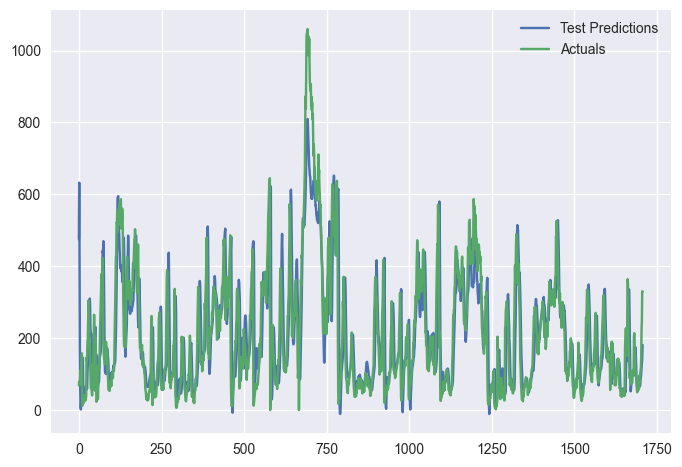

In [30]:
model = load_model('3H_Forecast/3H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(3,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D001_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D001_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)

### 4 hours forecast

In [31]:
%%time

Trainer(4,6,12,50)

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_22 (Bidirecti  (None, 128)              35840     
 onal)                                                           
                                                                 
 dense_46 (Dense)            (None, 8)                 1032      
                                                                 
 dense_47 (Dense)            (None, 1)                 9         
                                                                 
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 12:24:40.400031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:24:40.598391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:24:40.619527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:24:41.185236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:24:41.203537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8443 - mae: 0.5833 - mse: 0.8443 - mape: 134.2066

2023-02-10 12:24:46.773111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:24:46.852303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:24:46.864938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.71191, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 24s 133ms/step - loss: 0.8443 - mae: 0.5833 - mse: 0.8443 - mape: 134.2066 - val_loss: 0.7119 - val_mae: 0.6389 - val_mse: 0.7119 - val_mape: 126.5746
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.6246 - mae: 0.4304 - mse: 0.6246 - mape: 250.3642
Epoch 2: val_loss improved from 0.71191 to 0.44289, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 103ms/step - loss: 0.6246 - mae: 0.4304 - mse: 0.6246 - mape: 250.3642 - val_loss: 0.4429 - val_mae: 0.4861 - val_mse: 0.4429 - val_mape: 148.8469
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5627 - mae: 0.3804 - mse: 0.5627 - mape: 307.7245
Epoch 3: val_loss improved from 0.44289 to 0.36752, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.5627 - mae: 0.3804 - mse: 0.5627 - mape: 307.7245 - val_loss: 0.3675 - val_mae: 0.4383 - val_mse: 0.3675 - val_mape: 158.1103
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5491 - mae: 0.3673 - mse: 0.5491 - mape: 333.9505
Epoch 4: val_loss improved from 0.36752 to 0.35626, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 19s 118ms/step - loss: 0.5491 - mae: 0.3673 - mse: 0.5491 - mape: 333.9505 - val_loss: 0.3563 - val_mae: 0.4315 - val_mse: 0.3563 - val_mape: 153.9842
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5426 - mae: 0.3670 - mse: 0.5426 - mape: 330.8118
Epoch 5: val_loss did not improve from 0.35626
161/161 [==============================] - 6s 34ms/step - loss: 0.5426 - mae: 0.3670 - mse: 0.5426 - mape: 330.8118 - val_loss: 0.3583 - val_mae: 0.4313 - val_mse: 0.3583 - val_mape: 154.1398
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5362 - mae: 0.3596 - mse: 0.5362 - mape: 330.5377
Epoch 6: val_loss did not improve from 0.35626
161/161 [==============================] - 6s 35ms/step - loss: 0.5362 - mae: 0.3596 - mse: 0.5362 - mape: 330.5377 - val_loss: 0.3611 - val_mae: 0.4342 - val_mse: 0.3611 - val_mape: 146.1113
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.5311 - mae: 

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.5137 - mae: 0.3487 - mse: 0.5137 - mape: 312.8578 - val_loss: 0.3551 - val_mae: 0.4281 - val_mse: 0.3551 - val_mape: 137.4656
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.5084 - mae: 0.3500 - mse: 0.5084 - mape: 304.3063
Epoch 11: val_loss did not improve from 0.35513
161/161 [==============================] - 4s 25ms/step - loss: 0.5084 - mae: 0.3500 - mse: 0.5084 - mape: 304.3063 - val_loss: 0.3695 - val_mae: 0.4349 - val_mse: 0.3695 - val_mape: 136.6140
Epoch 12/50
161/161 [==============================] - ETA: 0s - loss: 0.5035 - mae: 0.3463 - mse: 0.5035 - mape: 303.7788
Epoch 12: val_loss did not improve from 0.35513
161/161 [==============================] - 4s 25ms/step - loss: 0.5035 - mae: 0.3463 - mse: 0.5035 - mape: 303.7788 - val_loss: 0.3643 - val_mae: 0.4304 - val_mse: 0.3643 - val_mape: 140.0681
Epoch 13/50
161/161 [==============================] - ETA: 0s - loss: 0.4984 - 

161/161 [==============================] - ETA: 0s - loss: 0.3929 - mae: 0.3069 - mse: 0.3929 - mape: 244.0657
Epoch 33: val_loss did not improve from 0.35513
161/161 [==============================] - 4s 23ms/step - loss: 0.3929 - mae: 0.3069 - mse: 0.3929 - mape: 244.0657 - val_loss: 0.3780 - val_mae: 0.4190 - val_mse: 0.3780 - val_mape: 175.7404
Epoch 34/50
161/161 [==============================] - ETA: 0s - loss: 0.3885 - mae: 0.3048 - mse: 0.3885 - mape: 232.2537
Epoch 34: val_loss did not improve from 0.35513
161/161 [==============================] - 4s 22ms/step - loss: 0.3885 - mae: 0.3048 - mse: 0.3885 - mape: 232.2537 - val_loss: 0.3900 - val_mae: 0.4244 - val_mse: 0.3900 - val_mape: 178.8783
Epoch 35/50
161/161 [==============================] - ETA: 0s - loss: 0.3835 - mae: 0.3045 - mse: 0.3835 - mape: 230.5712
Epoch 35: val_loss did not improve from 0.35513
161/161 [==============================] - 4s 25ms/step - loss: 0.3835 - mae: 0.3045 - mse: 0.3835 - mape: 230.5712

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 113ms/step - loss: 0.3608 - mae: 0.2966 - mse: 0.3608 - mape: 219.0401 - val_loss: 0.3534 - val_mae: 0.4105 - val_mse: 0.3534 - val_mape: 172.8634
Epoch 42/50
161/161 [==============================] - ETA: 0s - loss: 0.3580 - mae: 0.2959 - mse: 0.3580 - mape: 220.3679
Epoch 42: val_loss did not improve from 0.35339
161/161 [==============================] - 4s 26ms/step - loss: 0.3580 - mae: 0.2959 - mse: 0.3580 - mape: 220.3679 - val_loss: 0.3681 - val_mae: 0.4246 - val_mse: 0.3681 - val_mape: 178.9841
Epoch 43/50
160/161 [============================>.] - ETA: 0s - loss: 0.3559 - mae: 0.2967 - mse: 0.3559 - mape: 214.0468
Epoch 43: val_loss did not improve from 0.35339
161/161 [==============================] - 4s 25ms/step - loss: 0.3558 - mae: 0.2966 - mse: 0.3558 - mape: 214.0061 - val_loss: 0.3651 - val_mae: 0.4288 - val_mse: 0.3651 - val_mape: 181.1867
Epoch 44/50
161/161 [==============================] - ETA: 0s - loss: 0.3512 - 

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.3490 - mae: 0.2943 - mse: 0.3490 - mape: 208.2605 - val_loss: 0.3469 - val_mae: 0.4147 - val_mse: 0.3469 - val_mape: 185.5530
Epoch 46/50
160/161 [============================>.] - ETA: 0s - loss: 0.3451 - mae: 0.2930 - mse: 0.3451 - mape: 212.4060
Epoch 46: val_loss did not improve from 0.34687
161/161 [==============================] - 4s 25ms/step - loss: 0.3450 - mae: 0.2929 - mse: 0.3450 - mape: 212.3292 - val_loss: 0.3641 - val_mae: 0.4214 - val_mse: 0.3641 - val_mape: 178.4057
Epoch 47/50
161/161 [==============================] - ETA: 0s - loss: 0.3412 - mae: 0.2935 - mse: 0.3412 - mape: 213.5554
Epoch 47: val_loss did not improve from 0.34687
161/161 [==============================] - 4s 25ms/step - loss: 0.3412 - mae: 0.2935 - mse: 0.3412 - mape: 213.5554 - val_loss: 0.3740 - val_mae: 0.4282 - val_mse: 0.3740 - val_mape: 187.1839
Epoch 48/50
159/161 [============================>.] - ETA: 0s - loss: 0.3402 - 

2023-02-10 12:29:53.325747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:29:53.588751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:29:53.619922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:29:54.140878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:29:54.162311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 1.0071 - mae: 0.7009 - mse: 1.0071 - mape: 150.4413

2023-02-10 12:30:00.051200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:30:00.133317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:30:00.146700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.44635, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 24s 130ms/step - loss: 1.0071 - mae: 0.7009 - mse: 1.0071 - mape: 150.4413 - val_loss: 0.4463 - val_mae: 0.5145 - val_mse: 0.4463 - val_mape: 131.5260
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.6335 - mae: 0.4515 - mse: 0.6335 - mape: 226.1966
Epoch 2: val_loss improved from 0.44635 to 0.37521, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.6335 - mae: 0.4515 - mse: 0.6335 - mape: 226.1966 - val_loss: 0.3752 - val_mae: 0.4516 - val_mse: 0.3752 - val_mape: 150.9600
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5737 - mae: 0.3955 - mse: 0.5737 - mape: 273.7530
Epoch 3: val_loss improved from 0.37521 to 0.37410, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.5737 - mae: 0.3955 - mse: 0.5737 - mape: 273.7530 - val_loss: 0.3741 - val_mae: 0.4428 - val_mse: 0.3741 - val_mape: 155.5741
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5502 - mae: 0.3751 - mse: 0.5502 - mape: 293.4584
Epoch 4: val_loss improved from 0.37410 to 0.37388, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.5502 - mae: 0.3751 - mse: 0.5502 - mape: 293.4584 - val_loss: 0.3739 - val_mae: 0.4374 - val_mse: 0.3739 - val_mape: 154.3511
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5364 - mae: 0.3680 - mse: 0.5364 - mape: 296.9221
Epoch 5: val_loss improved from 0.37388 to 0.37079, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.5364 - mae: 0.3680 - mse: 0.5364 - mape: 296.9221 - val_loss: 0.3708 - val_mae: 0.4346 - val_mse: 0.3708 - val_mape: 155.9512
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5225 - mae: 0.3600 - mse: 0.5225 - mape: 294.9264
Epoch 6: val_loss did not improve from 0.37079
161/161 [==============================] - 4s 26ms/step - loss: 0.5225 - mae: 0.3600 - mse: 0.5225 - mape: 294.9264 - val_loss: 0.3757 - val_mae: 0.4358 - val_mse: 0.3757 - val_mape: 154.9200
Epoch 7/50
160/161 [============================>.] - ETA: 0s - loss: 0.5118 - mae: 0.3574 - mse: 0.5118 - mape: 289.7505
Epoch 7: val_loss did not improve from 0.37079
161/161 [==============================] - 4s 25ms/step - loss: 0.5117 - mae: 0.3573 - mse: 0.5117 - mape: 289.7041 - val_loss: 0.3729 - val_mae: 0.4337 - val_mse: 0.3729 - val_mape: 154.3552
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.5001 - mae: 

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 105ms/step - loss: 0.4792 - mae: 0.3429 - mse: 0.4792 - mape: 261.0832 - val_loss: 0.3521 - val_mae: 0.4180 - val_mse: 0.3521 - val_mape: 159.5744
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.4693 - mae: 0.3386 - mse: 0.4693 - mape: 260.9707
Epoch 11: val_loss did not improve from 0.35213
161/161 [==============================] - 4s 26ms/step - loss: 0.4693 - mae: 0.3386 - mse: 0.4693 - mape: 260.9707 - val_loss: 0.3657 - val_mae: 0.4244 - val_mse: 0.3657 - val_mape: 156.0167
Epoch 12/50
161/161 [==============================] - ETA: 0s - loss: 0.4595 - mae: 0.3345 - mse: 0.4595 - mape: 243.0626
Epoch 12: val_loss did not improve from 0.35213
161/161 [==============================] - 4s 25ms/step - loss: 0.4595 - mae: 0.3345 - mse: 0.4595 - mape: 243.0626 - val_loss: 0.3612 - val_mae: 0.4231 - val_mse: 0.3612 - val_mape: 152.5171
Epoch 13/50
161/161 [==============================] - ETA: 0s - loss: 0.4469 - 

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.3673 - mae: 0.3062 - mse: 0.3673 - mape: 226.2046 - val_loss: 0.3157 - val_mae: 0.3988 - val_mse: 0.3157 - val_mape: 170.5504
Epoch 24/50
160/161 [============================>.] - ETA: 0s - loss: 0.3627 - mae: 0.3104 - mse: 0.3627 - mape: 221.8313
Epoch 24: val_loss did not improve from 0.31566
161/161 [==============================] - 4s 26ms/step - loss: 0.3626 - mae: 0.3104 - mse: 0.3626 - mape: 221.7957 - val_loss: 0.3317 - val_mae: 0.4085 - val_mse: 0.3317 - val_mape: 190.3549
Epoch 25/50
160/161 [============================>.] - ETA: 0s - loss: 0.3551 - mae: 0.3055 - mse: 0.3551 - mape: 219.1687
Epoch 25: val_loss did not improve from 0.31566
161/161 [==============================] - 4s 25ms/step - loss: 0.3550 - mae: 0.3055 - mse: 0.3550 - mape: 219.1286 - val_loss: 0.3782 - val_mae: 0.4267 - val_mse: 0.3782 - val_mape: 183.8182
Epoch 26/50
159/161 [============================>.] - ETA: 0s - loss: 0.3514 - 

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.3128 - mae: 0.2960 - mse: 0.3128 - mape: 208.3418 - val_loss: 0.3114 - val_mae: 0.3905 - val_mse: 0.3114 - val_mape: 198.0904
Epoch 35/50
160/161 [============================>.] - ETA: 0s - loss: 0.3087 - mae: 0.2935 - mse: 0.3087 - mape: 202.0553
Epoch 35: val_loss did not improve from 0.31139
161/161 [==============================] - 4s 26ms/step - loss: 0.3086 - mae: 0.2935 - mse: 0.3086 - mape: 202.0171 - val_loss: 0.3220 - val_mae: 0.3935 - val_mse: 0.3220 - val_mape: 205.9943
Epoch 36/50
160/161 [============================>.] - ETA: 0s - loss: 0.3056 - mae: 0.2943 - mse: 0.3056 - mape: 195.2628
Epoch 36: val_loss did not improve from 0.31139
161/161 [==============================] - 4s 25ms/step - loss: 0.3055 - mae: 0.2942 - mse: 0.3055 - mape: 195.2252 - val_loss: 0.3173 - val_mae: 0.3894 - val_mse: 0.3173 - val_mape: 204.0286
Epoch 37/50
160/161 [============================>.] - ETA: 0s - loss: 0.3020 - 

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.3020 - mae: 0.2937 - mse: 0.3020 - mape: 211.0207 - val_loss: 0.2968 - val_mae: 0.3792 - val_mse: 0.2968 - val_mape: 205.1469
Epoch 38/50
161/161 [==============================] - ETA: 0s - loss: 0.2988 - mae: 0.2904 - mse: 0.2988 - mape: 184.8359
Epoch 38: val_loss did not improve from 0.29684
161/161 [==============================] - 4s 26ms/step - loss: 0.2988 - mae: 0.2904 - mse: 0.2988 - mape: 184.8359 - val_loss: 0.3090 - val_mae: 0.3859 - val_mse: 0.3090 - val_mape: 193.2868
Epoch 39/50
160/161 [============================>.] - ETA: 0s - loss: 0.2960 - mae: 0.2911 - mse: 0.2960 - mape: 190.8756
Epoch 39: val_loss improved from 0.29684 to 0.28805, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.2960 - mae: 0.2912 - mse: 0.2960 - mape: 190.8443 - val_loss: 0.2881 - val_mae: 0.3747 - val_mse: 0.2881 - val_mape: 195.4298
Epoch 40/50
159/161 [============================>.] - ETA: 0s - loss: 0.2929 - mae: 0.2883 - mse: 0.2929 - mape: 210.0887
Epoch 40: val_loss did not improve from 0.28805
161/161 [==============================] - 4s 25ms/step - loss: 0.2927 - mae: 0.2886 - mse: 0.2927 - mape: 209.3010 - val_loss: 0.2940 - val_mae: 0.3799 - val_mse: 0.2940 - val_mape: 201.8442
Epoch 41/50
160/161 [============================>.] - ETA: 0s - loss: 0.2915 - mae: 0.2871 - mse: 0.2915 - mape: 201.3257
Epoch 41: val_loss did not improve from 0.28805
161/161 [==============================] - 4s 25ms/step - loss: 0.2915 - mae: 0.2871 - mse: 0.2915 - mape: 201.3105 - val_loss: 0.2949 - val_mae: 0.3830 - val_mse: 0.2949 - val_mape: 202.8774
Epoch 42/50
159/161 [============================>.] - ETA: 0s - loss: 0.2905 - 

2023-02-10 12:35:36.090213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:35:36.327665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:35:36.355285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:35:37.008553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:35:37.026843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8649 - mae: 0.6156 - mse: 0.8649 - mape: 175.1294

2023-02-10 12:35:43.061337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:35:43.143619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:35:43.166551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.57797, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 25s 136ms/step - loss: 0.8649 - mae: 0.6156 - mse: 0.8649 - mape: 175.1294 - val_loss: 0.5780 - val_mae: 0.5701 - val_mse: 0.5780 - val_mape: 142.6525
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.6224 - mae: 0.4385 - mse: 0.6224 - mape: 258.9230
Epoch 2: val_loss improved from 0.57797 to 0.44037, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 112ms/step - loss: 0.6224 - mae: 0.4385 - mse: 0.6224 - mape: 258.9230 - val_loss: 0.4404 - val_mae: 0.4923 - val_mse: 0.4404 - val_mape: 149.9491
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5812 - mae: 0.3980 - mse: 0.5812 - mape: 300.3082
Epoch 3: val_loss improved from 0.44037 to 0.43463, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 19s 118ms/step - loss: 0.5812 - mae: 0.3980 - mse: 0.5812 - mape: 300.3082 - val_loss: 0.4346 - val_mae: 0.4843 - val_mse: 0.4346 - val_mape: 146.9099
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5654 - mae: 0.3846 - mse: 0.5654 - mape: 342.6599
Epoch 4: val_loss improved from 0.43463 to 0.41240, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.5654 - mae: 0.3846 - mse: 0.5654 - mape: 342.6599 - val_loss: 0.4124 - val_mae: 0.4714 - val_mse: 0.4124 - val_mape: 142.8455
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5514 - mae: 0.3772 - mse: 0.5514 - mape: 347.3224
Epoch 5: val_loss did not improve from 0.41240
161/161 [==============================] - 4s 26ms/step - loss: 0.5514 - mae: 0.3772 - mse: 0.5514 - mape: 347.3224 - val_loss: 0.4232 - val_mae: 0.4751 - val_mse: 0.4232 - val_mape: 135.5275
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5380 - mae: 0.3695 - mse: 0.5380 - mape: 322.5255
Epoch 6: val_loss did not improve from 0.41240
161/161 [==============================] - 4s 26ms/step - loss: 0.5380 - mae: 0.3695 - mse: 0.5380 - mape: 322.5255 - val_loss: 0.4228 - val_mae: 0.4723 - val_mse: 0.4228 - val_mape: 133.1696
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.5267 - mae: 

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 17s 109ms/step - loss: 0.5267 - mae: 0.3635 - mse: 0.5267 - mape: 317.8217 - val_loss: 0.4121 - val_mae: 0.4649 - val_mse: 0.4121 - val_mape: 132.6726
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.5140 - mae: 0.3567 - mse: 0.5140 - mape: 316.4890
Epoch 8: val_loss did not improve from 0.41208
161/161 [==============================] - 4s 27ms/step - loss: 0.5140 - mae: 0.3567 - mse: 0.5140 - mape: 316.4890 - val_loss: 0.4395 - val_mae: 0.4772 - val_mse: 0.4395 - val_mape: 129.4327
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.5034 - mae: 0.3515 - mse: 0.5034 - mape: 314.8356
Epoch 9: val_loss did not improve from 0.41208
161/161 [==============================] - 4s 25ms/step - loss: 0.5034 - mae: 0.3515 - mse: 0.5034 - mape: 314.8356 - val_loss: 0.4274 - val_mae: 0.4707 - val_mse: 0.4274 - val_mape: 128.0484
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.4918 - mae:

159/161 [============================>.] - ETA: 0s - loss: 0.3723 - mae: 0.3103 - mse: 0.3723 - mape: 259.9107
Epoch 30: val_loss did not improve from 0.41208
161/161 [==============================] - 5s 29ms/step - loss: 0.3716 - mae: 0.3105 - mse: 0.3716 - mape: 258.8851 - val_loss: 0.4373 - val_mae: 0.4609 - val_mse: 0.4373 - val_mape: 160.0141
Epoch 31/50
160/161 [============================>.] - ETA: 0s - loss: 0.3666 - mae: 0.3096 - mse: 0.3666 - mape: 260.8930
Epoch 31: val_loss did not improve from 0.41208
161/161 [==============================] - 5s 28ms/step - loss: 0.3666 - mae: 0.3095 - mse: 0.3666 - mape: 260.8432 - val_loss: 0.4397 - val_mae: 0.4612 - val_mse: 0.4397 - val_mape: 163.8364
Epoch 32/50
159/161 [============================>.] - ETA: 0s - loss: 0.3040 - mae: 0.3030 - mse: 0.3040 - mape: 255.3270
Epoch 32: val_loss did not improve from 0.41208
161/161 [==============================] - 4s 27ms/step - loss: 0.3609 - mae: 0.3063 - mse: 0.3609 - mape: 256.5206

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 19s 120ms/step - loss: 0.3282 - mae: 0.2994 - mse: 0.3282 - mape: 235.0466 - val_loss: 0.4116 - val_mae: 0.4420 - val_mse: 0.4116 - val_mape: 171.0004
Epoch 40/50
160/161 [============================>.] - ETA: 0s - loss: 0.3252 - mae: 0.2989 - mse: 0.3252 - mape: 247.4602
Epoch 40: val_loss improved from 0.41161 to 0.41140, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 20s 124ms/step - loss: 0.3252 - mae: 0.2989 - mse: 0.3252 - mape: 247.4137 - val_loss: 0.4114 - val_mae: 0.4430 - val_mse: 0.4114 - val_mape: 169.9767
Epoch 41/50
160/161 [============================>.] - ETA: 0s - loss: 0.3217 - mae: 0.2996 - mse: 0.3217 - mape: 251.9086
Epoch 41: val_loss did not improve from 0.41140
161/161 [==============================] - 5s 30ms/step - loss: 0.3217 - mae: 0.2996 - mse: 0.3217 - mape: 251.8611 - val_loss: 0.4296 - val_mae: 0.4527 - val_mse: 0.4296 - val_mape: 171.6870
Epoch 42/50
160/161 [============================>.] - ETA: 0s - loss: 0.3176 - mae: 0.2955 - mse: 0.3176 - mape: 238.3897
Epoch 42: val_loss did not improve from 0.41140
161/161 [==============================] - 4s 26ms/step - loss: 0.3176 - mae: 0.2955 - mse: 0.3176 - mape: 238.3559 - val_loss: 0.4288 - val_mae: 0.4474 - val_mse: 0.4288 - val_mape: 183.7503
Epoch 43/50
160/161 [============================>.] - ETA: 0s - loss: 0.3144 - 

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 113ms/step - loss: 0.3145 - mae: 0.2950 - mse: 0.3145 - mape: 243.2029 - val_loss: 0.4047 - val_mae: 0.4364 - val_mse: 0.4047 - val_mape: 176.9708
Epoch 44/50
161/161 [==============================] - ETA: 0s - loss: 0.3146 - mae: 0.2962 - mse: 0.3146 - mape: 202.9081
Epoch 44: val_loss did not improve from 0.40472
161/161 [==============================] - 4s 26ms/step - loss: 0.3146 - mae: 0.2962 - mse: 0.3146 - mape: 202.9081 - val_loss: 0.4071 - val_mae: 0.4361 - val_mse: 0.4071 - val_mape: 187.0114
Epoch 45/50
160/161 [============================>.] - ETA: 0s - loss: 0.3079 - mae: 0.2933 - mse: 0.3079 - mape: 245.6708
Epoch 45: val_loss improved from 0.40472 to 0.40462, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.3078 - mae: 0.2933 - mse: 0.3078 - mape: 245.6287 - val_loss: 0.4046 - val_mae: 0.4343 - val_mse: 0.4046 - val_mape: 182.6313
Epoch 46/50
160/161 [============================>.] - ETA: 0s - loss: 0.3045 - mae: 0.2902 - mse: 0.3045 - mape: 225.3618
Epoch 46: val_loss did not improve from 0.40462
161/161 [==============================] - 4s 26ms/step - loss: 0.3045 - mae: 0.2903 - mse: 0.3045 - mape: 225.3243 - val_loss: 0.4374 - val_mae: 0.4512 - val_mse: 0.4374 - val_mape: 176.2699
Epoch 47/50
159/161 [============================>.] - ETA: 0s - loss: 0.3039 - mae: 0.2909 - mse: 0.3039 - mape: 241.3095
Epoch 47: val_loss did not improve from 0.40462
161/161 [==============================] - 4s 27ms/step - loss: 0.3024 - mae: 0.2903 - mse: 0.3024 - mape: 240.1819 - val_loss: 0.4444 - val_mae: 0.4550 - val_mse: 0.4444 - val_mape: 173.5802
Epoch 48/50
160/161 [============================>.] - ETA: 0s - loss: 0.3004 - 

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 20s 127ms/step - loss: 0.3004 - mae: 0.2892 - mse: 0.3004 - mape: 237.4566 - val_loss: 0.3989 - val_mae: 0.4314 - val_mse: 0.3989 - val_mape: 178.4260
Epoch 49/50
160/161 [============================>.] - ETA: 0s - loss: 0.2981 - mae: 0.2917 - mse: 0.2981 - mape: 229.9999
Epoch 49: val_loss did not improve from 0.39895
161/161 [==============================] - 4s 27ms/step - loss: 0.2981 - mae: 0.2917 - mse: 0.2981 - mape: 229.9623 - val_loss: 0.4174 - val_mae: 0.4406 - val_mse: 0.4174 - val_mape: 176.5744
Epoch 50/50
159/161 [============================>.] - ETA: 0s - loss: 0.2956 - mae: 0.2856 - mse: 0.2956 - mape: 233.7818
Epoch 50: val_loss did not improve from 0.39895
161/161 [==============================] - 4s 26ms/step - loss: 0.2949 - mae: 0.2858 - mse: 0.2949 - mape: 232.7247 - val_loss: 0.4262 - val_mae: 0.4460 - val_mse: 0.4262 - val_mape: 180.2779

-------------------------------------------------------------------------------

2023-02-10 12:41:46.525815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:41:46.766474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:41:46.821531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:41:47.373190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:41:47.394020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.7781 - mae: 0.5244 - mse: 0.7781 - mape: 211.8153

2023-02-10 12:41:54.246103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:41:54.332846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:41:54.333269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.49401, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 27s 153ms/step - loss: 0.7781 - mae: 0.5244 - mse: 0.7781 - mape: 211.8153 - val_loss: 0.4940 - val_mae: 0.5171 - val_mse: 0.4940 - val_mape: 154.1992
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.6227 - mae: 0.4128 - mse: 0.6227 - mape: 305.9807
Epoch 2: val_loss improved from 0.49401 to 0.40877, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 21s 131ms/step - loss: 0.6227 - mae: 0.4128 - mse: 0.6227 - mape: 305.9807 - val_loss: 0.4088 - val_mae: 0.4646 - val_mse: 0.4088 - val_mape: 158.0884
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5942 - mae: 0.3918 - mse: 0.5942 - mape: 324.6615
Epoch 3: val_loss improved from 0.40877 to 0.39872, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 19s 119ms/step - loss: 0.5942 - mae: 0.3918 - mse: 0.5942 - mape: 324.6615 - val_loss: 0.3987 - val_mae: 0.4560 - val_mse: 0.3987 - val_mape: 160.0124
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5769 - mae: 0.3853 - mse: 0.5769 - mape: 317.5285
Epoch 4: val_loss improved from 0.39872 to 0.39062, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 21s 133ms/step - loss: 0.5769 - mae: 0.3853 - mse: 0.5769 - mape: 317.5285 - val_loss: 0.3906 - val_mae: 0.4530 - val_mse: 0.3906 - val_mape: 156.6219
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5627 - mae: 0.3788 - mse: 0.5627 - mape: 309.1287
Epoch 5: val_loss did not improve from 0.39062
161/161 [==============================] - 6s 35ms/step - loss: 0.5627 - mae: 0.3788 - mse: 0.5627 - mape: 309.1287 - val_loss: 0.4072 - val_mae: 0.4617 - val_mse: 0.4072 - val_mape: 156.6874
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5477 - mae: 0.3677 - mse: 0.5477 - mape: 301.8969
Epoch 6: val_loss did not improve from 0.39062
161/161 [==============================] - 5s 33ms/step - loss: 0.5477 - mae: 0.3677 - mse: 0.5477 - mape: 301.8969 - val_loss: 0.4082 - val_mae: 0.4661 - val_mse: 0.4082 - val_mape: 156.8342
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.5319 - mae: 

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 18s 113ms/step - loss: 0.5180 - mae: 0.3528 - mse: 0.5180 - mape: 296.9626 - val_loss: 0.3623 - val_mae: 0.4388 - val_mse: 0.3623 - val_mape: 150.3268
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.5078 - mae: 0.3458 - mse: 0.5078 - mape: 289.6522
Epoch 9: val_loss did not improve from 0.36232
161/161 [==============================] - 6s 38ms/step - loss: 0.5078 - mae: 0.3458 - mse: 0.5078 - mape: 289.6522 - val_loss: 0.3769 - val_mae: 0.4456 - val_mse: 0.3769 - val_mape: 155.4443
Epoch 10/50
160/161 [============================>.] - ETA: 0s - loss: 0.4967 - mae: 0.3417 - mse: 0.4967 - mape: 291.9584
Epoch 10: val_loss improved from 0.36232 to 0.35972, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 24s 151ms/step - loss: 0.4967 - mae: 0.3416 - mse: 0.4967 - mape: 291.9033 - val_loss: 0.3597 - val_mae: 0.4329 - val_mse: 0.3597 - val_mape: 158.2384
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.4879 - mae: 0.3384 - mse: 0.4879 - mape: 277.7747
Epoch 11: val_loss improved from 0.35972 to 0.33062, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 21s 131ms/step - loss: 0.4879 - mae: 0.3384 - mse: 0.4879 - mape: 277.7747 - val_loss: 0.3306 - val_mae: 0.4154 - val_mse: 0.3306 - val_mape: 163.0718
Epoch 12/50
161/161 [==============================] - ETA: 0s - loss: 0.4794 - mae: 0.3322 - mse: 0.4794 - mape: 276.7822
Epoch 12: val_loss did not improve from 0.33062
161/161 [==============================] - 5s 30ms/step - loss: 0.4794 - mae: 0.3322 - mse: 0.4794 - mape: 276.7822 - val_loss: 0.3771 - val_mae: 0.4369 - val_mse: 0.3771 - val_mape: 172.3785
Epoch 13/50
159/161 [============================>.] - ETA: 0s - loss: 0.4734 - mae: 0.3305 - mse: 0.4734 - mape: 286.5463
Epoch 13: val_loss did not improve from 0.33062
161/161 [==============================] - 4s 27ms/step - loss: 0.4718 - mae: 0.3302 - mse: 0.4718 - mape: 285.2655 - val_loss: 0.3767 - val_mae: 0.4414 - val_mse: 0.3767 - val_mape: 159.7899
Epoch 14/50
161/161 [==============================] - ETA: 0s - loss: 0.4642 - 

161/161 [==============================] - ETA: 0s - loss: 0.3458 - mae: 0.2969 - mse: 0.3458 - mape: 217.8302
Epoch 34: val_loss did not improve from 0.33062
161/161 [==============================] - 5s 32ms/step - loss: 0.3458 - mae: 0.2969 - mse: 0.3458 - mape: 217.8302 - val_loss: 0.3531 - val_mae: 0.4050 - val_mse: 0.3531 - val_mape: 183.7116
Epoch 35/50
161/161 [==============================] - ETA: 0s - loss: 0.3414 - mae: 0.2946 - mse: 0.3414 - mape: 200.5136
Epoch 35: val_loss did not improve from 0.33062
161/161 [==============================] - 5s 30ms/step - loss: 0.3414 - mae: 0.2946 - mse: 0.3414 - mape: 200.5136 - val_loss: 0.3564 - val_mae: 0.4072 - val_mse: 0.3564 - val_mape: 184.8724
Epoch 36/50
160/161 [============================>.] - ETA: 0s - loss: 0.3396 - mae: 0.2953 - mse: 0.3396 - mape: 197.1473
Epoch 36: val_loss did not improve from 0.33062
161/161 [==============================] - 5s 30ms/step - loss: 0.3397 - mae: 0.2954 - mse: 0.3397 - mape: 197.1175

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 23s 146ms/step - loss: 0.3139 - mae: 0.2846 - mse: 0.3139 - mape: 187.4553 - val_loss: 0.3246 - val_mae: 0.3877 - val_mse: 0.3246 - val_mape: 181.4900
Epoch 44/50
161/161 [==============================] - ETA: 0s - loss: 0.3096 - mae: 0.2820 - mse: 0.3096 - mape: 187.0261
Epoch 44: val_loss did not improve from 0.32455
161/161 [==============================] - 5s 29ms/step - loss: 0.3096 - mae: 0.2820 - mse: 0.3096 - mape: 187.0261 - val_loss: 0.3492 - val_mae: 0.4016 - val_mse: 0.3492 - val_mape: 186.4795
Epoch 45/50
159/161 [============================>.] - ETA: 0s - loss: 0.3111 - mae: 0.2853 - mse: 0.3111 - mape: 191.2168
Epoch 45: val_loss did not improve from 0.32455
161/161 [==============================] - 4s 28ms/step - loss: 0.3098 - mae: 0.2849 - mse: 0.3098 - mape: 191.2121 - val_loss: 0.3653 - val_mae: 0.4069 - val_mse: 0.3653 - val_mape: 185.6839
Epoch 46/50
161/161 [==============================] - ETA: 0s - loss: 0.3040 - 

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.2976 - mae: 0.2779 - mse: 0.2976 - mape: 187.5709 - val_loss: 0.3203 - val_mae: 0.3863 - val_mse: 0.3203 - val_mape: 197.3653
Epoch 50/50
161/161 [==============================] - ETA: 0s - loss: 0.2931 - mae: 0.2764 - mse: 0.2931 - mape: 181.2869
Epoch 50: val_loss did not improve from 0.32025
161/161 [==============================] - 5s 31ms/step - loss: 0.2931 - mae: 0.2764 - mse: 0.2931 - mape: 181.2869 - val_loss: 0.3394 - val_mae: 0.3953 - val_mse: 0.3394 - val_mape: 202.9296

-----------------------------------------------------------------------------------------------------------

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_26 (Bidirecti  (None, 128)              35840     
 onal)                                                           
                                              

2023-02-10 12:48:14.768392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:48:14.982971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:48:14.983014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:48:15.973619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:48:16.008908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


159/160 [============================>.] - ETA: 0s - loss: 0.8685 - mae: 0.5940 - mse: 0.8685 - mape: 232.1223

2023-02-10 12:48:23.171453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:48:23.263483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:48:23.301138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.77425, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 23s 126ms/step - loss: 0.8661 - mae: 0.5935 - mse: 0.8661 - mape: 231.0907 - val_loss: 0.7742 - val_mae: 0.6633 - val_mse: 0.7742 - val_mape: 134.4256
Epoch 2/50
158/160 [============================>.] - ETA: 0s - loss: 0.6814 - mae: 0.4464 - mse: 0.6814 - mape: 341.1891
Epoch 2: val_loss improved from 0.77425 to 0.51403, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 17s 104ms/step - loss: 0.6771 - mae: 0.4464 - mse: 0.6771 - mape: 338.0095 - val_loss: 0.5140 - val_mae: 0.5241 - val_mse: 0.5140 - val_mape: 138.8350
Epoch 3/50
158/160 [============================>.] - ETA: 0s - loss: 0.6039 - mae: 0.4078 - mse: 0.6039 - mape: 402.1100
Epoch 3: val_loss improved from 0.51403 to 0.44261, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 16s 103ms/step - loss: 0.5999 - mae: 0.4073 - mse: 0.5999 - mape: 398.5929 - val_loss: 0.4426 - val_mae: 0.4851 - val_mse: 0.4426 - val_mape: 144.1945
Epoch 4/50
158/160 [============================>.] - ETA: 0s - loss: 0.5836 - mae: 0.3908 - mse: 0.5836 - mape: 395.3268
Epoch 4: val_loss improved from 0.44261 to 0.41465, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 17s 107ms/step - loss: 0.5790 - mae: 0.3904 - mse: 0.5790 - mape: 391.6937 - val_loss: 0.4147 - val_mae: 0.4682 - val_mse: 0.4147 - val_mape: 146.8223
Epoch 5/50
158/160 [============================>.] - ETA: 0s - loss: 0.5627 - mae: 0.3812 - mse: 0.5627 - mape: 388.8709
Epoch 5: val_loss improved from 0.41465 to 0.40945, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 17s 109ms/step - loss: 0.5634 - mae: 0.3820 - mse: 0.5634 - mape: 385.0282 - val_loss: 0.4095 - val_mae: 0.4647 - val_mse: 0.4095 - val_mape: 145.4052
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.5486 - mae: 0.3735 - mse: 0.5486 - mape: 372.1252
Epoch 6: val_loss did not improve from 0.40945
160/160 [==============================] - 4s 22ms/step - loss: 0.5486 - mae: 0.3735 - mse: 0.5486 - mape: 372.1252 - val_loss: 0.4152 - val_mae: 0.4670 - val_mse: 0.4152 - val_mape: 142.5129
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.5344 - mae: 0.3653 - mse: 0.5344 - mape: 354.7960
Epoch 7: val_loss did not improve from 0.40945
160/160 [==============================] - 3s 22ms/step - loss: 0.5344 - mae: 0.3653 - mse: 0.5344 - mape: 354.7960 - val_loss: 0.4279 - val_mae: 0.4713 - val_mse: 0.4279 - val_mape: 139.9162
Epoch 8/50
159/160 [============================>.] - ETA: 0s - loss: 0.5223 - mae: 

158/160 [============================>.] - ETA: 0s - loss: 0.3888 - mae: 0.3058 - mse: 0.3888 - mape: 264.4279
Epoch 28: val_loss did not improve from 0.40945
160/160 [==============================] - 4s 22ms/step - loss: 0.3906 - mae: 0.3072 - mse: 0.3906 - mape: 262.9351 - val_loss: 0.4327 - val_mae: 0.4386 - val_mse: 0.4327 - val_mape: 196.3713
Epoch 29/50
160/160 [==============================] - ETA: 0s - loss: 0.3865 - mae: 0.3059 - mse: 0.3865 - mape: 259.3397
Epoch 29: val_loss did not improve from 0.40945
160/160 [==============================] - 3s 20ms/step - loss: 0.3865 - mae: 0.3059 - mse: 0.3865 - mape: 259.3397 - val_loss: 0.4876 - val_mae: 0.4593 - val_mse: 0.4876 - val_mape: 196.7606
Epoch 30/50
160/160 [==============================] - ETA: 0s - loss: 0.3817 - mae: 0.3037 - mse: 0.3817 - mape: 256.6454
Epoch 30: val_loss did not improve from 0.40945
160/160 [==============================] - 4s 27ms/step - loss: 0.3817 - mae: 0.3037 - mse: 0.3817 - mape: 256.6454


-----------------------------------------------------------------------------------------------------------

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_27 (Bidirecti  (None, 128)              35840     
 onal)                                                           
                                                                 
 dense_56 (Dense)            (None, 8)                 1032      
                                                                 
 dense_57 (Dense)            (None, 1)                 9         
                                                                 
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 12:52:28.965900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:52:29.183355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:52:29.227738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:52:29.959733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:52:29.982414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.9296 - mae: 0.6366 - mse: 0.9296 - mape: 136.1035

2023-02-10 12:52:36.709884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:52:36.793954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:52:36.809556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.59157, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 25s 141ms/step - loss: 0.9296 - mae: 0.6366 - mse: 0.9296 - mape: 136.1035 - val_loss: 0.5916 - val_mae: 0.5779 - val_mse: 0.5916 - val_mape: 125.6264
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.6566 - mae: 0.4401 - mse: 0.6566 - mape: 305.3383
Epoch 2: val_loss improved from 0.59157 to 0.43280, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 107ms/step - loss: 0.6566 - mae: 0.4401 - mse: 0.6566 - mape: 305.3383 - val_loss: 0.4328 - val_mae: 0.4698 - val_mse: 0.4328 - val_mape: 152.7885
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.6052 - mae: 0.4045 - mse: 0.6052 - mape: 343.8163
Epoch 3: val_loss did not improve from 0.43280
160/160 [==============================] - 4s 25ms/step - loss: 0.6052 - mae: 0.4045 - mse: 0.6052 - mape: 343.8163 - val_loss: 0.4337 - val_mae: 0.4624 - val_mse: 0.4337 - val_mape: 155.1116
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.5764 - mae: 0.3832 - mse: 0.5764 - mape: 332.5686
Epoch 4: val_loss did not improve from 0.43280
160/160 [==============================] - 3s 22ms/step - loss: 0.5764 - mae: 0.3832 - mse: 0.5764 - mape: 332.5686 - val_loss: 0.4343 - val_mae: 0.4674 - val_mse: 0.4343 - val_mape: 151.3017
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.5521 - mae: 

158/160 [============================>.] - ETA: 0s - loss: 0.3758 - mae: 0.3084 - mse: 0.3758 - mape: 248.3817
Epoch 25: val_loss did not improve from 0.43280
160/160 [==============================] - 4s 22ms/step - loss: 0.3732 - mae: 0.3082 - mse: 0.3732 - mape: 247.0147 - val_loss: 0.5319 - val_mae: 0.4918 - val_mse: 0.5319 - val_mape: 206.5620
Epoch 26/50
160/160 [==============================] - ETA: 0s - loss: 0.3674 - mae: 0.3055 - mse: 0.3674 - mape: 247.3224
Epoch 26: val_loss did not improve from 0.43280
160/160 [==============================] - 4s 22ms/step - loss: 0.3674 - mae: 0.3055 - mse: 0.3674 - mape: 247.3224 - val_loss: 0.4416 - val_mae: 0.4557 - val_mse: 0.4416 - val_mape: 206.8273
Epoch 27/50
160/160 [==============================] - ETA: 0s - loss: 0.3607 - mae: 0.3032 - mse: 0.3607 - mape: 240.9815
Epoch 27: val_loss did not improve from 0.43280
160/160 [==============================] - 3s 21ms/step - loss: 0.3607 - mae: 0.3032 - mse: 0.3607 - mape: 240.9815

Epoch 48/50
159/160 [============================>.] - ETA: 0s - loss: 0.2824 - mae: 0.2686 - mse: 0.2824 - mape: 167.3399
Epoch 48: val_loss did not improve from 0.43280
160/160 [==============================] - 4s 24ms/step - loss: 0.2816 - mae: 0.2687 - mse: 0.2816 - mape: 174.9334 - val_loss: 0.4755 - val_mae: 0.4749 - val_mse: 0.4755 - val_mape: 261.8931
Epoch 49/50
159/160 [============================>.] - ETA: 0s - loss: 0.2789 - mae: 0.2721 - mse: 0.2789 - mape: 169.7047
Epoch 49: val_loss did not improve from 0.43280
160/160 [==============================] - 4s 24ms/step - loss: 0.2777 - mae: 0.2716 - mse: 0.2777 - mape: 169.9362 - val_loss: 0.4891 - val_mae: 0.4787 - val_mse: 0.4891 - val_mape: 253.7990
Epoch 50/50
160/160 [==============================] - ETA: 0s - loss: 0.2768 - mae: 0.2675 - mse: 0.2768 - mape: 179.9002
Epoch 50: val_loss did not improve from 0.43280
160/160 [==============================] - 4s 24ms/step - loss: 0.2768 - mae: 0.2675 - mse: 0.2768 - ma

2023-02-10 12:56:16.421672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:56:16.678346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:56:16.740672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:56:17.442729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:56:17.461151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.8700 - mae: 0.6387 - mse: 0.8700 - mape: 182.8190

2023-02-10 12:56:24.833284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:56:24.924608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:56:24.943871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.51726, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 26s 143ms/step - loss: 0.8700 - mae: 0.6387 - mse: 0.8700 - mape: 182.8190 - val_loss: 0.5173 - val_mae: 0.5442 - val_mse: 0.5173 - val_mape: 121.1939
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.6938 - mae: 0.4976 - mse: 0.6938 - mape: 259.5493
Epoch 2: val_loss improved from 0.51726 to 0.49946, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 16s 103ms/step - loss: 0.6938 - mae: 0.4976 - mse: 0.6938 - mape: 259.5493 - val_loss: 0.4995 - val_mae: 0.5293 - val_mse: 0.4995 - val_mape: 120.5458
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.6322 - mae: 0.4273 - mse: 0.6322 - mape: 298.8881
Epoch 3: val_loss improved from 0.49946 to 0.49449, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 107ms/step - loss: 0.6322 - mae: 0.4273 - mse: 0.6322 - mape: 298.8881 - val_loss: 0.4945 - val_mae: 0.5261 - val_mse: 0.4945 - val_mape: 118.6722
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.5917 - mae: 0.4043 - mse: 0.5917 - mape: 353.2914
Epoch 4: val_loss improved from 0.49449 to 0.46979, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 106ms/step - loss: 0.5917 - mae: 0.4043 - mse: 0.5917 - mape: 353.2914 - val_loss: 0.4698 - val_mae: 0.5131 - val_mse: 0.4698 - val_mape: 121.0593
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.5628 - mae: 0.3869 - mse: 0.5628 - mape: 360.7296
Epoch 5: val_loss did not improve from 0.46979
160/160 [==============================] - 4s 24ms/step - loss: 0.5628 - mae: 0.3869 - mse: 0.5628 - mape: 360.7296 - val_loss: 0.4777 - val_mae: 0.5141 - val_mse: 0.4777 - val_mape: 125.0527
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.5406 - mae: 0.3752 - mse: 0.5406 - mape: 356.3185
Epoch 6: val_loss improved from 0.46979 to 0.46900, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 16s 103ms/step - loss: 0.5406 - mae: 0.3752 - mse: 0.5406 - mape: 356.3185 - val_loss: 0.4690 - val_mae: 0.5116 - val_mse: 0.4690 - val_mape: 125.2758
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.5218 - mae: 0.3672 - mse: 0.5218 - mape: 353.7649
Epoch 7: val_loss did not improve from 0.46900
160/160 [==============================] - 4s 25ms/step - loss: 0.5218 - mae: 0.3672 - mse: 0.5218 - mape: 353.7649 - val_loss: 0.4819 - val_mae: 0.5155 - val_mse: 0.4819 - val_mape: 133.4648
Epoch 8/50
159/160 [============================>.] - ETA: 0s - loss: 0.5059 - mae: 0.3599 - mse: 0.5059 - mape: 339.9748
Epoch 8: val_loss improved from 0.46900 to 0.43839, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 106ms/step - loss: 0.5035 - mae: 0.3591 - mse: 0.5035 - mape: 338.2993 - val_loss: 0.4384 - val_mae: 0.4864 - val_mse: 0.4384 - val_mape: 138.4987
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.4872 - mae: 0.3532 - mse: 0.4872 - mape: 294.0472
Epoch 9: val_loss did not improve from 0.43839
160/160 [==============================] - 4s 26ms/step - loss: 0.4872 - mae: 0.3532 - mse: 0.4872 - mape: 294.0472 - val_loss: 0.4818 - val_mae: 0.5084 - val_mse: 0.4818 - val_mape: 142.3970
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.4707 - mae: 0.3492 - mse: 0.4707 - mape: 286.7341
Epoch 10: val_loss did not improve from 0.43839
160/160 [==============================] - 4s 25ms/step - loss: 0.4707 - mae: 0.3492 - mse: 0.4707 - mape: 286.7341 - val_loss: 0.4660 - val_mae: 0.4995 - val_mse: 0.4660 - val_mape: 158.5848
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.4597 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 16s 102ms/step - loss: 0.3922 - mae: 0.3256 - mse: 0.3922 - mape: 246.3802 - val_loss: 0.4279 - val_mae: 0.4674 - val_mse: 0.4279 - val_mape: 177.7551
Epoch 18/50
159/160 [============================>.] - ETA: 0s - loss: 0.3828 - mae: 0.3194 - mse: 0.3828 - mape: 243.7415
Epoch 18: val_loss improved from 0.42790 to 0.42495, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 106ms/step - loss: 0.3814 - mae: 0.3190 - mse: 0.3814 - mape: 242.6620 - val_loss: 0.4250 - val_mae: 0.4652 - val_mse: 0.4250 - val_mape: 173.7063
Epoch 19/50
160/160 [==============================] - ETA: 0s - loss: 0.3716 - mae: 0.3204 - mse: 0.3716 - mape: 203.1814
Epoch 19: val_loss improved from 0.42495 to 0.40991, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 16s 102ms/step - loss: 0.3716 - mae: 0.3204 - mse: 0.3716 - mape: 203.1814 - val_loss: 0.4099 - val_mae: 0.4549 - val_mse: 0.4099 - val_mape: 176.4261
Epoch 20/50
160/160 [==============================] - ETA: 0s - loss: 0.3630 - mae: 0.3149 - mse: 0.3630 - mape: 218.4113
Epoch 20: val_loss did not improve from 0.40991
160/160 [==============================] - 4s 24ms/step - loss: 0.3630 - mae: 0.3149 - mse: 0.3630 - mape: 218.4113 - val_loss: 0.4257 - val_mae: 0.4677 - val_mse: 0.4257 - val_mape: 187.7372
Epoch 21/50
160/160 [==============================] - ETA: 0s - loss: 0.3538 - mae: 0.3108 - mse: 0.3538 - mape: 197.4954
Epoch 21: val_loss did not improve from 0.40991
160/160 [==============================] - 4s 23ms/step - loss: 0.3538 - mae: 0.3108 - mse: 0.3538 - mape: 197.4954 - val_loss: 0.4231 - val_mae: 0.4637 - val_mse: 0.4231 - val_mape: 185.9615
Epoch 22/50
160/160 [==============================] - ETA: 0s - loss: 0.3468 - 

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 16s 102ms/step - loss: 0.3468 - mae: 0.3125 - mse: 0.3468 - mape: 199.2305 - val_loss: 0.4082 - val_mae: 0.4561 - val_mse: 0.4082 - val_mape: 195.1158
Epoch 23/50
160/160 [==============================] - ETA: 0s - loss: 0.3389 - mae: 0.3042 - mse: 0.3389 - mape: 203.1304
Epoch 23: val_loss improved from 0.40823 to 0.38476, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 103ms/step - loss: 0.3389 - mae: 0.3042 - mse: 0.3389 - mape: 203.1304 - val_loss: 0.3848 - val_mae: 0.4426 - val_mse: 0.3848 - val_mape: 189.6312
Epoch 24/50
159/160 [============================>.] - ETA: 0s - loss: 0.3336 - mae: 0.3087 - mse: 0.3336 - mape: 215.8085
Epoch 24: val_loss did not improve from 0.38476
160/160 [==============================] - 6s 37ms/step - loss: 0.3337 - mae: 0.3092 - mse: 0.3337 - mape: 214.9276 - val_loss: 0.3901 - val_mae: 0.4496 - val_mse: 0.3901 - val_mape: 199.3400
Epoch 25/50
159/160 [============================>.] - ETA: 0s - loss: 0.3292 - mae: 0.3024 - mse: 0.3292 - mape: 201.8958
Epoch 25: val_loss improved from 0.38476 to 0.37352, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 18s 116ms/step - loss: 0.3282 - mae: 0.3024 - mse: 0.3282 - mape: 201.3179 - val_loss: 0.3735 - val_mae: 0.4409 - val_mse: 0.3735 - val_mape: 201.6175
Epoch 26/50
159/160 [============================>.] - ETA: 0s - loss: 0.3231 - mae: 0.2982 - mse: 0.3231 - mape: 213.9594
Epoch 26: val_loss did not improve from 0.37352
160/160 [==============================] - 4s 26ms/step - loss: 0.3223 - mae: 0.2981 - mse: 0.3223 - mape: 213.0788 - val_loss: 0.3788 - val_mae: 0.4414 - val_mse: 0.3788 - val_mape: 192.3026
Epoch 27/50
158/160 [============================>.] - ETA: 0s - loss: 0.3201 - mae: 0.3000 - mse: 0.3201 - mape: 192.2641
Epoch 27: val_loss did not improve from 0.37352
160/160 [==============================] - 4s 24ms/step - loss: 0.3177 - mae: 0.2994 - mse: 0.3177 - mape: 190.5849 - val_loss: 0.3974 - val_mae: 0.4479 - val_mse: 0.3974 - val_mape: 196.9880
Epoch 28/50
160/160 [==============================] - ETA: 0s - loss: 0.3133 - 

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 109ms/step - loss: 0.3052 - mae: 0.2922 - mse: 0.3052 - mape: 193.8798 - val_loss: 0.3705 - val_mae: 0.4339 - val_mse: 0.3705 - val_mape: 190.0364
Epoch 31/50
158/160 [============================>.] - ETA: 0s - loss: 0.3023 - mae: 0.2900 - mse: 0.3023 - mape: 183.1598
Epoch 31: val_loss improved from 0.37054 to 0.35433, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 18s 111ms/step - loss: 0.3009 - mae: 0.2902 - mse: 0.3009 - mape: 181.7343 - val_loss: 0.3543 - val_mae: 0.4256 - val_mse: 0.3543 - val_mape: 195.5278
Epoch 32/50
160/160 [==============================] - ETA: 0s - loss: 0.2970 - mae: 0.2860 - mse: 0.2970 - mape: 180.1487
Epoch 32: val_loss improved from 0.35433 to 0.35206, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 107ms/step - loss: 0.2970 - mae: 0.2860 - mse: 0.2970 - mape: 180.1487 - val_loss: 0.3521 - val_mae: 0.4200 - val_mse: 0.3521 - val_mape: 192.3817
Epoch 33/50
160/160 [==============================] - ETA: 0s - loss: 0.2951 - mae: 0.2901 - mse: 0.2951 - mape: 181.9218
Epoch 33: val_loss did not improve from 0.35206
160/160 [==============================] - 4s 23ms/step - loss: 0.2951 - mae: 0.2901 - mse: 0.2951 - mape: 181.9218 - val_loss: 0.3560 - val_mae: 0.4259 - val_mse: 0.3560 - val_mape: 200.9618
Epoch 34/50
159/160 [============================>.] - ETA: 0s - loss: 0.2927 - mae: 0.2855 - mse: 0.2927 - mape: 180.4419
Epoch 34: val_loss did not improve from 0.35206
160/160 [==============================] - 4s 23ms/step - loss: 0.2917 - mae: 0.2853 - mse: 0.2917 - mape: 179.6064 - val_loss: 0.3795 - val_mae: 0.4349 - val_mse: 0.3795 - val_mape: 200.6849
Epoch 35/50
160/160 [==============================] - ETA: 0s - loss: 0.2917 - 

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 18s 111ms/step - loss: 0.2863 - mae: 0.2825 - mse: 0.2863 - mape: 184.9408 - val_loss: 0.3423 - val_mae: 0.4134 - val_mse: 0.3423 - val_mape: 205.6340
Epoch 37/50
160/160 [==============================] - ETA: 0s - loss: 0.2824 - mae: 0.2796 - mse: 0.2824 - mape: 182.1164
Epoch 37: val_loss did not improve from 0.34234
160/160 [==============================] - 4s 24ms/step - loss: 0.2824 - mae: 0.2796 - mse: 0.2824 - mape: 182.1164 - val_loss: 0.3461 - val_mae: 0.4145 - val_mse: 0.3461 - val_mape: 195.3967
Epoch 38/50
159/160 [============================>.] - ETA: 0s - loss: 0.2816 - mae: 0.2772 - mse: 0.2816 - mape: 158.1528
Epoch 38: val_loss did not improve from 0.34234
160/160 [==============================] - 4s 22ms/step - loss: 0.2808 - mae: 0.2773 - mse: 0.2808 - mape: 158.0985 - val_loss: 0.3467 - val_mae: 0.4142 - val_mse: 0.3467 - val_mape: 202.6724
Epoch 39/50
160/160 [==============================] - ETA: 0s - loss: 0.2794 - 

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 16s 100ms/step - loss: 0.2761 - mae: 0.2764 - mse: 0.2761 - mape: 175.8560 - val_loss: 0.3334 - val_mae: 0.4101 - val_mse: 0.3334 - val_mape: 203.6431
Epoch 41/50
160/160 [==============================] - ETA: 0s - loss: 0.2755 - mae: 0.2735 - mse: 0.2755 - mape: 178.4013
Epoch 41: val_loss did not improve from 0.33337
160/160 [==============================] - 5s 28ms/step - loss: 0.2755 - mae: 0.2735 - mse: 0.2755 - mape: 178.4013 - val_loss: 0.3409 - val_mae: 0.4107 - val_mse: 0.3409 - val_mape: 201.3696
Epoch 42/50
160/160 [==============================] - ETA: 0s - loss: 0.2741 - mae: 0.2747 - mse: 0.2741 - mape: 191.7678
Epoch 42: val_loss did not improve from 0.33337
160/160 [==============================] - 4s 25ms/step - loss: 0.2741 - mae: 0.2747 - mse: 0.2741 - mape: 191.7678 - val_loss: 0.3448 - val_mae: 0.4114 - val_mse: 0.3448 - val_mape: 203.3740
Epoch 43/50
158/160 [============================>.] - ETA: 0s - loss: 0.2723 - 

In [32]:
%%time

modelsEvaluator(4,6,12)

(5122, 6, 5) (5122,) (1708, 6, 5) (1708,) (1708, 6, 5) (1708,)
Loading: 4H_Forecast/4H_ForecastModel_6_SizeWindow/


2023-02-10 13:03:35.645785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:03:35.778810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:03:35.799291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 30ms/step - loss: 0.3358 - mae: 0.3947 - mse: 0.3358 - mape: 302.4286


2023-02-10 13:03:38.189526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:03:38.248410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:03:38.258709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 15ms/step
(5121, 7, 5) (5121,) (1708, 7, 5) (1708,) (1708, 7, 5) (1708,)
Loading: 4H_Forecast/4H_ForecastModel_7_SizeWindow/


2023-02-10 13:03:50.781723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:03:50.958404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:03:50.971184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 28ms/step - loss: 0.3543 - mae: 0.4178 - mse: 0.3543 - mape: 349.0762


2023-02-10 13:03:54.862107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:03:54.930723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:03:54.942730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 15ms/step
(5121, 8, 5) (5121,) (1707, 8, 5) (1707,) (1708, 8, 5) (1708,)
Loading: 4H_Forecast/4H_ForecastModel_8_SizeWindow/


2023-02-10 13:04:07.843557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:04:07.971874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:04:08.000336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 33ms/step - loss: 0.3405 - mae: 0.4063 - mse: 0.3405 - mape: 306.8152


2023-02-10 13:04:10.662824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:04:10.721851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:04:10.732865: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 16ms/step
(5121, 9, 5) (5121,) (1707, 9, 5) (1707,) (1707, 9, 5) (1707,)
Loading: 4H_Forecast/4H_ForecastModel_9_SizeWindow/


2023-02-10 13:04:23.700378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:04:23.845941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:04:23.859895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 30ms/step - loss: 0.3117 - mae: 0.3932 - mse: 0.3117 - mape: 301.9465


2023-02-10 13:04:26.410918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:04:26.466955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:04:26.476917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 16ms/step
(5120, 10, 5) (5120,) (1707, 10, 5) (1707,) (1707, 10, 5) (1707,)
Loading: 4H_Forecast/4H_ForecastModel_10_SizeWindow/


2023-02-10 13:04:39.403734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:04:39.500586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:04:39.570785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 35ms/step - loss: 0.3645 - mae: 0.4496 - mse: 0.3645 - mape: 369.3587


2023-02-10 13:04:43.969063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:04:44.052442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:04:44.071490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 19ms/step
(5119, 11, 5) (5119,) (1707, 11, 5) (1707,) (1707, 11, 5) (1707,)
Loading: 4H_Forecast/4H_ForecastModel_11_SizeWindow/


2023-02-10 13:04:57.512814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:04:57.623998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:04:57.642895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 30ms/step - loss: 0.3699 - mae: 0.4771 - mse: 0.3699 - mape: 316.6767


2023-02-10 13:05:00.025135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:05:00.084725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:05:00.096257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 14ms/step
(5118, 12, 5) (5118,) (1707, 12, 5) (1707,) (1707, 12, 5) (1707,)
Loading: 4H_Forecast/4H_ForecastModel_12_SizeWindow/


2023-02-10 13:05:12.555556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:05:12.697196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:05:12.713252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 30ms/step - loss: 0.3488 - mae: 0.4124 - mse: 0.3488 - mape: 305.0991


2023-02-10 13:05:15.170992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:05:15.240716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:05:15.240814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 17ms/step
CPU times: user 1min 38s, sys: 10.7 s, total: 1min 49s
Wall time: 1min 52s


2023-02-10 13:05:29.368375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:05:29.448961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:05:29.460975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 21ms/step


,Test Predictions,Actuals
0,209.790909,68.766000
1,348.396301,79.580000
2,510.258942,69.918333
3,287.168457,78.193333
4,237.814178,99.771667
5,197.250443,110.829091
6,167.495544,94.683333
7,140.639847,104.376667
8,124.808846,134.989091
9,118.338005,157.801667


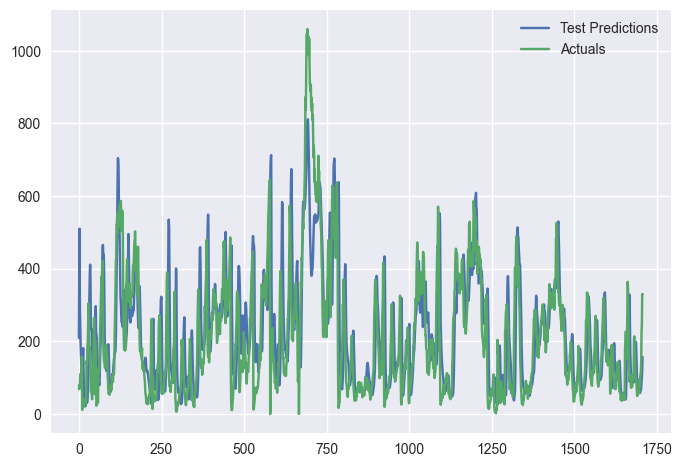

In [33]:
model = load_model('4H_Forecast/4H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(4,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D001_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D001_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)

### 5 hours forecast

In [34]:
%%time

Trainer(5,6,12,50)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_29 (Bidirecti  (None, 128)              35840     
 onal)                                                           
                                                                 
 dense_60 (Dense)            (None, 8)                 1032      
                                                                 
 dense_61 (Dense)            (None, 1)                 9         
                                                                 
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 13:05:33.068179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:05:33.274300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:05:33.301216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:05:34.083646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:05:34.102774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8833 - mae: 0.6111 - mse: 0.8833 - mape: 175.5892

2023-02-10 13:05:41.546920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:05:41.646317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:05:41.659544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.65907, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 26s 144ms/step - loss: 0.8833 - mae: 0.6111 - mse: 0.8833 - mape: 175.5892 - val_loss: 0.6591 - val_mae: 0.6233 - val_mse: 0.6591 - val_mape: 123.8395
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.6733 - mae: 0.4663 - mse: 0.6733 - mape: 282.0804
Epoch 2: val_loss improved from 0.65907 to 0.47641, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.6733 - mae: 0.4663 - mse: 0.6733 - mape: 282.0804 - val_loss: 0.4764 - val_mae: 0.5126 - val_mse: 0.4764 - val_mape: 143.0249
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.6069 - mae: 0.4141 - mse: 0.6069 - mape: 336.4731
Epoch 3: val_loss improved from 0.47641 to 0.43242, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.6069 - mae: 0.4141 - mse: 0.6069 - mape: 336.4731 - val_loss: 0.4324 - val_mae: 0.4804 - val_mse: 0.4324 - val_mape: 147.9491
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5914 - mae: 0.4024 - mse: 0.5914 - mape: 366.3614
Epoch 4: val_loss improved from 0.43242 to 0.42993, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 114ms/step - loss: 0.5914 - mae: 0.4024 - mse: 0.5914 - mape: 366.3614 - val_loss: 0.4299 - val_mae: 0.4774 - val_mse: 0.4299 - val_mape: 147.2709
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5818 - mae: 0.3974 - mse: 0.5818 - mape: 370.4945
Epoch 5: val_loss improved from 0.42993 to 0.42707, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.5818 - mae: 0.3974 - mse: 0.5818 - mape: 370.4945 - val_loss: 0.4271 - val_mae: 0.4765 - val_mse: 0.4271 - val_mape: 141.4037
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5741 - mae: 0.3879 - mse: 0.5741 - mape: 362.2621
Epoch 6: val_loss improved from 0.42707 to 0.41976, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.5741 - mae: 0.3879 - mse: 0.5741 - mape: 362.2621 - val_loss: 0.4198 - val_mae: 0.4709 - val_mse: 0.4198 - val_mape: 136.8459
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.5683 - mae: 0.3889 - mse: 0.5683 - mape: 341.7702
Epoch 7: val_loss improved from 0.41976 to 0.41454, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.5683 - mae: 0.3889 - mse: 0.5683 - mape: 341.7702 - val_loss: 0.4145 - val_mae: 0.4659 - val_mse: 0.4145 - val_mape: 135.2722
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.5606 - mae: 0.3841 - mse: 0.5606 - mape: 331.2079
Epoch 8: val_loss improved from 0.41454 to 0.41382, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 16s 100ms/step - loss: 0.5606 - mae: 0.3841 - mse: 0.5606 - mape: 331.2079 - val_loss: 0.4138 - val_mae: 0.4639 - val_mse: 0.4138 - val_mape: 134.6883
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.5539 - mae: 0.3793 - mse: 0.5539 - mape: 330.1656
Epoch 9: val_loss improved from 0.41382 to 0.41001, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.5539 - mae: 0.3793 - mse: 0.5539 - mape: 330.1656 - val_loss: 0.4100 - val_mae: 0.4582 - val_mse: 0.4100 - val_mape: 137.4183
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.5463 - mae: 0.3747 - mse: 0.5463 - mape: 322.6324
Epoch 10: val_loss did not improve from 0.41001
161/161 [==============================] - 4s 23ms/step - loss: 0.5463 - mae: 0.3747 - mse: 0.5463 - mape: 322.6324 - val_loss: 0.4129 - val_mae: 0.4597 - val_mse: 0.4129 - val_mape: 134.8116
Epoch 11/50
160/161 [============================>.] - ETA: 0s - loss: 0.5389 - mae: 0.3733 - mse: 0.5389 - mape: 333.8877
Epoch 11: val_loss did not improve from 0.41001
161/161 [==============================] - 4s 26ms/step - loss: 0.5389 - mae: 0.3733 - mse: 0.5389 - mape: 333.8392 - val_loss: 0.4115 - val_mae: 0.4573 - val_mse: 0.4115 - val_mape: 136.1464
Epoch 12/50
160/161 [============================>.] - ETA: 0s - loss: 0.5315 - 

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 104ms/step - loss: 0.4509 - mae: 0.3410 - mse: 0.4509 - mape: 271.9014 - val_loss: 0.4034 - val_mae: 0.4393 - val_mse: 0.4034 - val_mape: 162.1839
Epoch 27/50
160/161 [============================>.] - ETA: 0s - loss: 0.4480 - mae: 0.3382 - mse: 0.4480 - mape: 270.2881
Epoch 27: val_loss did not improve from 0.40335
161/161 [==============================] - 4s 26ms/step - loss: 0.4479 - mae: 0.3381 - mse: 0.4479 - mape: 270.2431 - val_loss: 0.4483 - val_mae: 0.4618 - val_mse: 0.4483 - val_mape: 157.9191
Epoch 28/50
160/161 [============================>.] - ETA: 0s - loss: 0.4434 - mae: 0.3351 - mse: 0.4434 - mape: 278.5698
Epoch 28: val_loss did not improve from 0.40335
161/161 [==============================] - 4s 24ms/step - loss: 0.4433 - mae: 0.3350 - mse: 0.4433 - mape: 278.5188 - val_loss: 0.4450 - val_mae: 0.4616 - val_mse: 0.4450 - val_mape: 159.1495
Epoch 29/50
159/161 [============================>.] - ETA: 0s - loss: 0.4425 - 

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 21s 131ms/step - loss: 0.4200 - mae: 0.3293 - mse: 0.4200 - mape: 269.5690 - val_loss: 0.3990 - val_mae: 0.4378 - val_mse: 0.3990 - val_mape: 180.1978
Epoch 36/50
160/161 [============================>.] - ETA: 0s - loss: 0.4181 - mae: 0.3285 - mse: 0.4181 - mape: 257.1163
Epoch 36: val_loss did not improve from 0.39902
161/161 [==============================] - 5s 29ms/step - loss: 0.4180 - mae: 0.3284 - mse: 0.4180 - mape: 257.0672 - val_loss: 0.4172 - val_mae: 0.4460 - val_mse: 0.4172 - val_mape: 180.7338
Epoch 37/50
159/161 [============================>.] - ETA: 0s - loss: 0.4174 - mae: 0.3293 - mse: 0.4174 - mape: 268.3770
Epoch 37: val_loss did not improve from 0.39902
161/161 [==============================] - 5s 28ms/step - loss: 0.4152 - mae: 0.3285 - mse: 0.4152 - mape: 267.3257 - val_loss: 0.4236 - val_mae: 0.4510 - val_mse: 0.4236 - val_mape: 173.9815
Epoch 38/50
161/161 [==============================] - ETA: 0s - loss: 0.4123 - 

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.4094 - mae: 0.3276 - mse: 0.4094 - mape: 264.9883 - val_loss: 0.3673 - val_mae: 0.4261 - val_mse: 0.3673 - val_mape: 177.8970
Epoch 40/50
161/161 [==============================] - ETA: 0s - loss: 0.4056 - mae: 0.3281 - mse: 0.4056 - mape: 263.3914
Epoch 40: val_loss did not improve from 0.36730
161/161 [==============================] - 5s 33ms/step - loss: 0.4056 - mae: 0.3281 - mse: 0.4056 - mape: 263.3914 - val_loss: 0.4415 - val_mae: 0.4603 - val_mse: 0.4415 - val_mape: 177.0347
Epoch 41/50
161/161 [==============================] - ETA: 0s - loss: 0.4056 - mae: 0.3262 - mse: 0.4056 - mape: 245.1928
Epoch 41: val_loss did not improve from 0.36730
161/161 [==============================] - 6s 34ms/step - loss: 0.4056 - mae: 0.3262 - mse: 0.4056 - mape: 245.1928 - val_loss: 0.4177 - val_mae: 0.4468 - val_mse: 0.4177 - val_mape: 186.7121
Epoch 42/50
160/161 [============================>.] - ETA: 0s - loss: 0.4010 - 

2023-02-10 13:11:49.245554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:11:49.488085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:11:49.536766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:11:50.321672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:11:50.340026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.9318 - mae: 0.6799 - mse: 0.9318 - mape: 192.1549

2023-02-10 13:11:56.832972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:11:56.914188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:11:56.915856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.45368, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 25s 130ms/step - loss: 0.9318 - mae: 0.6799 - mse: 0.9318 - mape: 192.1549 - val_loss: 0.4537 - val_mae: 0.4958 - val_mse: 0.4537 - val_mape: 139.2051
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.7912 - mae: 0.5838 - mse: 0.7912 - mape: 288.4920
Epoch 2: val_loss improved from 0.45368 to 0.41793, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 18s 110ms/step - loss: 0.7912 - mae: 0.5838 - mse: 0.7912 - mape: 288.4920 - val_loss: 0.4179 - val_mae: 0.4651 - val_mse: 0.4179 - val_mape: 158.2970
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.6222 - mae: 0.4488 - mse: 0.6222 - mape: 320.1397
Epoch 3: val_loss did not improve from 0.41793
161/161 [==============================] - 6s 35ms/step - loss: 0.6222 - mae: 0.4488 - mse: 0.6222 - mape: 320.1397 - val_loss: 0.4269 - val_mae: 0.4737 - val_mse: 0.4269 - val_mape: 163.5536
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5841 - mae: 0.4041 - mse: 0.5841 - mape: 324.4612
Epoch 4: val_loss did not improve from 0.41793
161/161 [==============================] - 5s 28ms/step - loss: 0.5841 - mae: 0.4041 - mse: 0.5841 - mape: 324.4612 - val_loss: 0.4210 - val_mae: 0.4699 - val_mse: 0.4210 - val_mape: 162.7275
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5698 - mae: 

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 16s 101ms/step - loss: 0.4009 - mae: 0.3448 - mse: 0.4009 - mape: 272.3598 - val_loss: 0.4156 - val_mae: 0.4610 - val_mse: 0.4156 - val_mape: 181.6945
Epoch 22/50
159/161 [============================>.] - ETA: 0s - loss: 0.3943 - mae: 0.3469 - mse: 0.3943 - mape: 279.9665
Epoch 22: val_loss did not improve from 0.41562
161/161 [==============================] - 4s 22ms/step - loss: 0.3923 - mae: 0.3462 - mse: 0.3923 - mape: 278.6149 - val_loss: 0.4282 - val_mae: 0.4668 - val_mse: 0.4282 - val_mape: 193.5012
Epoch 23/50
161/161 [==============================] - ETA: 0s - loss: 0.3845 - mae: 0.3413 - mse: 0.3845 - mape: 268.1195
Epoch 23: val_loss improved from 0.41562 to 0.41160, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 16s 101ms/step - loss: 0.3845 - mae: 0.3413 - mse: 0.3845 - mape: 268.1195 - val_loss: 0.4116 - val_mae: 0.4566 - val_mse: 0.4116 - val_mape: 188.3122
Epoch 24/50
161/161 [==============================] - ETA: 0s - loss: 0.3787 - mae: 0.3414 - mse: 0.3787 - mape: 281.7751
Epoch 24: val_loss improved from 0.41160 to 0.40192, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 104ms/step - loss: 0.3787 - mae: 0.3414 - mse: 0.3787 - mape: 281.7751 - val_loss: 0.4019 - val_mae: 0.4586 - val_mse: 0.4019 - val_mape: 195.9576
Epoch 25/50
161/161 [==============================] - ETA: 0s - loss: 0.3725 - mae: 0.3379 - mse: 0.3725 - mape: 274.9550
Epoch 25: val_loss did not improve from 0.40192
161/161 [==============================] - 4s 24ms/step - loss: 0.3725 - mae: 0.3379 - mse: 0.3725 - mape: 274.9550 - val_loss: 0.4173 - val_mae: 0.4647 - val_mse: 0.4173 - val_mape: 196.7954
Epoch 26/50
159/161 [============================>.] - ETA: 0s - loss: 0.3633 - mae: 0.3365 - mse: 0.3633 - mape: 266.3596
Epoch 26: val_loss improved from 0.40192 to 0.40109, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 16s 99ms/step - loss: 0.3665 - mae: 0.3373 - mse: 0.3665 - mape: 265.1745 - val_loss: 0.4011 - val_mae: 0.4567 - val_mse: 0.4011 - val_mape: 197.3408
Epoch 27/50
159/161 [============================>.] - ETA: 0s - loss: 0.3618 - mae: 0.3354 - mse: 0.3618 - mape: 272.4811
Epoch 27: val_loss did not improve from 0.40109
161/161 [==============================] - 4s 22ms/step - loss: 0.3612 - mae: 0.3357 - mse: 0.3612 - mape: 274.1039 - val_loss: 0.4142 - val_mae: 0.4595 - val_mse: 0.4142 - val_mape: 201.9151
Epoch 28/50
160/161 [============================>.] - ETA: 0s - loss: 0.3592 - mae: 0.3351 - mse: 0.3592 - mape: 290.4240
Epoch 28: val_loss did not improve from 0.40109
161/161 [==============================] - 3s 21ms/step - loss: 0.3592 - mae: 0.3351 - mse: 0.3592 - mape: 290.3803 - val_loss: 0.4106 - val_mae: 0.4599 - val_mse: 0.4106 - val_mape: 203.4465
Epoch 29/50
160/161 [============================>.] - ETA: 0s - loss: 0.3515 - m

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 16s 102ms/step - loss: 0.3514 - mae: 0.3320 - mse: 0.3514 - mape: 271.4784 - val_loss: 0.3978 - val_mae: 0.4546 - val_mse: 0.3978 - val_mape: 197.1954
Epoch 30/50
161/161 [==============================] - ETA: 0s - loss: 0.3491 - mae: 0.3328 - mse: 0.3491 - mape: 270.7206
Epoch 30: val_loss improved from 0.39778 to 0.39526, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 16s 98ms/step - loss: 0.3491 - mae: 0.3328 - mse: 0.3491 - mape: 270.7206 - val_loss: 0.3953 - val_mae: 0.4557 - val_mse: 0.3953 - val_mape: 204.9439
Epoch 31/50
161/161 [==============================] - ETA: 0s - loss: 0.3441 - mae: 0.3294 - mse: 0.3441 - mape: 256.8978
Epoch 31: val_loss improved from 0.39526 to 0.38499, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 16s 101ms/step - loss: 0.3441 - mae: 0.3294 - mse: 0.3441 - mape: 256.8978 - val_loss: 0.3850 - val_mae: 0.4470 - val_mse: 0.3850 - val_mape: 197.8798
Epoch 32/50
161/161 [==============================] - ETA: 0s - loss: 0.3421 - mae: 0.3279 - mse: 0.3421 - mape: 270.7149
Epoch 32: val_loss did not improve from 0.38499
161/161 [==============================] - 4s 22ms/step - loss: 0.3421 - mae: 0.3279 - mse: 0.3421 - mape: 270.7149 - val_loss: 0.4027 - val_mae: 0.4593 - val_mse: 0.4027 - val_mape: 206.4571
Epoch 33/50
161/161 [==============================] - ETA: 0s - loss: 0.3383 - mae: 0.3307 - mse: 0.3383 - mape: 258.6866
Epoch 33: val_loss improved from 0.38499 to 0.37032, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 777s 5s/step - loss: 0.3383 - mae: 0.3307 - mse: 0.3383 - mape: 258.6866 - val_loss: 0.3703 - val_mae: 0.4444 - val_mse: 0.3703 - val_mape: 210.4960
Epoch 34/50
161/161 [==============================] - ETA: 0s - loss: 0.3361 - mae: 0.3255 - mse: 0.3361 - mape: 267.9542
Epoch 34: val_loss did not improve from 0.37032
161/161 [==============================] - 4s 22ms/step - loss: 0.3361 - mae: 0.3255 - mse: 0.3361 - mape: 267.9542 - val_loss: 0.3885 - val_mae: 0.4469 - val_mse: 0.3885 - val_mape: 210.6426
Epoch 35/50
160/161 [============================>.] - ETA: 0s - loss: 0.3334 - mae: 0.3249 - mse: 0.3334 - mape: 272.6054
Epoch 35: val_loss did not improve from 0.37032
161/161 [==============================] - 4s 24ms/step - loss: 0.3333 - mae: 0.3248 - mse: 0.3333 - mape: 272.5587 - val_loss: 0.3846 - val_mae: 0.4427 - val_mse: 0.3846 - val_mape: 206.5641
Epoch 36/50
161/161 [==============================] - ETA: 0s - loss: 0.3305 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 105ms/step - loss: 0.3225 - mae: 0.3199 - mse: 0.3225 - mape: 252.7225 - val_loss: 0.3532 - val_mae: 0.4344 - val_mse: 0.3532 - val_mape: 217.3104
Epoch 42/50
159/161 [============================>.] - ETA: 0s - loss: 0.3191 - mae: 0.3176 - mse: 0.3191 - mape: 256.2871
Epoch 42: val_loss did not improve from 0.35317
161/161 [==============================] - 4s 25ms/step - loss: 0.3216 - mae: 0.3183 - mse: 0.3216 - mape: 256.0034 - val_loss: 0.3537 - val_mae: 0.4332 - val_mse: 0.3537 - val_mape: 210.4950
Epoch 43/50
160/161 [============================>.] - ETA: 0s - loss: 0.3205 - mae: 0.3205 - mse: 0.3205 - mape: 257.9756
Epoch 43: val_loss did not improve from 0.35317
161/161 [==============================] - 4s 22ms/step - loss: 0.3205 - mae: 0.3205 - mse: 0.3205 - mape: 257.9315 - val_loss: 0.3669 - val_mae: 0.4365 - val_mse: 0.3669 - val_mape: 213.9814
Epoch 44/50
160/161 [============================>.] - ETA: 0s - loss: 0.3191 - 

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 16s 98ms/step - loss: 0.3142 - mae: 0.3142 - mse: 0.3142 - mape: 254.5503 - val_loss: 0.3449 - val_mae: 0.4268 - val_mse: 0.3449 - val_mape: 219.4597
Epoch 50/50
160/161 [============================>.] - ETA: 0s - loss: 0.3121 - mae: 0.3138 - mse: 0.3121 - mape: 247.8020
Epoch 50: val_loss improved from 0.34494 to 0.34177, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 16s 97ms/step - loss: 0.3125 - mae: 0.3140 - mse: 0.3125 - mape: 247.7669 - val_loss: 0.3418 - val_mae: 0.4242 - val_mse: 0.3418 - val_mape: 220.5469

-----------------------------------------------------------------------------------------------------------

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_31 (Bidirecti  (None, 128)              35840     
 onal)                                                           
                                                                 
 dense_64 (Dense)            (None, 8)                 1032      
                                                                 
 dense_65 (Dense)            (None, 1)                 9         
                                                                 
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
__________

2023-02-10 13:30:31.895212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:30:32.243142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:30:32.291031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:30:33.081567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:30:33.101687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8748 - mae: 0.6249 - mse: 0.8748 - mape: 167.9031

2023-02-10 13:30:40.533607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:30:40.625988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:30:40.647040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.47215, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 27s 147ms/step - loss: 0.8748 - mae: 0.6249 - mse: 0.8748 - mape: 167.9031 - val_loss: 0.4722 - val_mae: 0.5128 - val_mse: 0.4722 - val_mape: 137.2559
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.6421 - mae: 0.4343 - mse: 0.6421 - mape: 342.6757
Epoch 2: val_loss improved from 0.47215 to 0.45002, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 18s 109ms/step - loss: 0.6421 - mae: 0.4343 - mse: 0.6421 - mape: 342.6757 - val_loss: 0.4500 - val_mae: 0.4849 - val_mse: 0.4500 - val_mape: 152.1778
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.6138 - mae: 0.4130 - mse: 0.6138 - mape: 356.9878
Epoch 3: val_loss improved from 0.45002 to 0.44988, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.6138 - mae: 0.4130 - mse: 0.6138 - mape: 356.9878 - val_loss: 0.4499 - val_mae: 0.4855 - val_mse: 0.4499 - val_mape: 150.4340
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5940 - mae: 0.4050 - mse: 0.5940 - mape: 361.6657
Epoch 4: val_loss did not improve from 0.44988
161/161 [==============================] - 4s 26ms/step - loss: 0.5940 - mae: 0.4050 - mse: 0.5940 - mape: 361.6657 - val_loss: 0.4793 - val_mae: 0.4986 - val_mse: 0.4793 - val_mape: 144.3617
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5749 - mae: 0.3962 - mse: 0.5749 - mape: 354.9198
Epoch 5: val_loss did not improve from 0.44988
161/161 [==============================] - 4s 27ms/step - loss: 0.5749 - mae: 0.3962 - mse: 0.5749 - mape: 354.9198 - val_loss: 0.5035 - val_mae: 0.5126 - val_mse: 0.5035 - val_mape: 146.0351
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5584 - mae: 

161/161 [==============================] - ETA: 0s - loss: 0.3726 - mae: 0.3393 - mse: 0.3726 - mape: 266.4417
Epoch 26: val_loss did not improve from 0.44988
161/161 [==============================] - 4s 26ms/step - loss: 0.3726 - mae: 0.3393 - mse: 0.3726 - mape: 266.4417 - val_loss: 0.4517 - val_mae: 0.4713 - val_mse: 0.4517 - val_mape: 196.9622
Epoch 27/50
159/161 [============================>.] - ETA: 0s - loss: 0.3691 - mae: 0.3360 - mse: 0.3691 - mape: 272.4857
Epoch 27: val_loss did not improve from 0.44988
161/161 [==============================] - 4s 24ms/step - loss: 0.3686 - mae: 0.3359 - mse: 0.3686 - mape: 272.6473 - val_loss: 0.4797 - val_mae: 0.4841 - val_mse: 0.4797 - val_mape: 207.2510
Epoch 28/50
161/161 [==============================] - ETA: 0s - loss: 0.3644 - mae: 0.3343 - mse: 0.3644 - mape: 265.2442
Epoch 28: val_loss did not improve from 0.44988
161/161 [==============================] - 4s 27ms/step - loss: 0.3644 - mae: 0.3343 - mse: 0.3644 - mape: 265.2442

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 17s 108ms/step - loss: 0.3518 - mae: 0.3295 - mse: 0.3518 - mape: 261.8827 - val_loss: 0.4284 - val_mae: 0.4600 - val_mse: 0.4284 - val_mape: 206.0291
Epoch 32/50
160/161 [============================>.] - ETA: 0s - loss: 0.3508 - mae: 0.3293 - mse: 0.3508 - mape: 290.3338
Epoch 32: val_loss did not improve from 0.42838
161/161 [==============================] - 4s 27ms/step - loss: 0.3507 - mae: 0.3293 - mse: 0.3507 - mape: 290.3430 - val_loss: 0.4774 - val_mae: 0.4852 - val_mse: 0.4774 - val_mape: 202.7712
Epoch 33/50
161/161 [==============================] - ETA: 0s - loss: 0.3462 - mae: 0.3287 - mse: 0.3462 - mape: 264.4521
Epoch 33: val_loss did not improve from 0.42838
161/161 [==============================] - 4s 25ms/step - loss: 0.3462 - mae: 0.3287 - mse: 0.3462 - mape: 264.4521 - val_loss: 0.4418 - val_mae: 0.4651 - val_mse: 0.4418 - val_mape: 220.0345
Epoch 34/50
159/161 [============================>.] - ETA: 0s - loss: 0.3428 - 

2023-02-10 13:35:05.058376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:35:05.250529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:35:05.251570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:35:05.937831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:35:05.956079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


159/160 [============================>.] - ETA: 0s - loss: 0.8706 - mae: 0.6074 - mse: 0.8706 - mape: 230.2135

2023-02-10 13:35:14.297930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:35:14.407457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:35:14.419159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.57098, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 26s 146ms/step - loss: 0.8666 - mae: 0.6060 - mse: 0.8666 - mape: 229.2212 - val_loss: 0.5710 - val_mae: 0.5609 - val_mse: 0.5710 - val_mape: 126.7146
Epoch 2/50
159/160 [============================>.] - ETA: 0s - loss: 0.6641 - mae: 0.4429 - mse: 0.6641 - mape: 336.1333
Epoch 2: val_loss improved from 0.57098 to 0.46137, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 19s 118ms/step - loss: 0.6617 - mae: 0.4424 - mse: 0.6617 - mape: 338.2185 - val_loss: 0.4614 - val_mae: 0.4927 - val_mse: 0.4614 - val_mape: 145.2087
Epoch 3/50
158/160 [============================>.] - ETA: 0s - loss: 0.6319 - mae: 0.4206 - mse: 0.6319 - mape: 369.5604
Epoch 3: val_loss improved from 0.46137 to 0.45624, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 17s 105ms/step - loss: 0.6305 - mae: 0.4207 - mse: 0.6305 - mape: 366.9798 - val_loss: 0.4562 - val_mae: 0.4901 - val_mse: 0.4562 - val_mape: 142.9487
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.6101 - mae: 0.4102 - mse: 0.6101 - mape: 365.9733
Epoch 4: val_loss improved from 0.45624 to 0.45223, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 17s 105ms/step - loss: 0.6101 - mae: 0.4102 - mse: 0.6101 - mape: 365.9733 - val_loss: 0.4522 - val_mae: 0.4876 - val_mse: 0.4522 - val_mape: 138.9260
Epoch 5/50
159/160 [============================>.] - ETA: 0s - loss: 0.5951 - mae: 0.3998 - mse: 0.5951 - mape: 352.9892
Epoch 5: val_loss did not improve from 0.45223
160/160 [==============================] - 4s 23ms/step - loss: 0.5935 - mae: 0.4001 - mse: 0.5935 - mape: 351.4051 - val_loss: 0.4618 - val_mae: 0.4948 - val_mse: 0.4618 - val_mape: 134.8053
Epoch 6/50
158/160 [============================>.] - ETA: 0s - loss: 0.5843 - mae: 0.4026 - mse: 0.5843 - mape: 345.6512
Epoch 6: val_loss improved from 0.45223 to 0.44720, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 17s 109ms/step - loss: 0.5789 - mae: 0.4011 - mse: 0.5789 - mape: 342.8477 - val_loss: 0.4472 - val_mae: 0.4861 - val_mse: 0.4472 - val_mape: 133.8856
Epoch 7/50
158/160 [============================>.] - ETA: 0s - loss: 0.5674 - mae: 0.3900 - mse: 0.5674 - mape: 335.0370
Epoch 7: val_loss did not improve from 0.44720
160/160 [==============================] - 4s 24ms/step - loss: 0.5626 - mae: 0.3895 - mse: 0.5626 - mape: 332.4497 - val_loss: 0.4655 - val_mae: 0.4940 - val_mse: 0.4655 - val_mape: 135.9038
Epoch 8/50
158/160 [============================>.] - ETA: 0s - loss: 0.5506 - mae: 0.3846 - mse: 0.5506 - mape: 330.4465
Epoch 8: val_loss did not improve from 0.44720
160/160 [==============================] - 4s 23ms/step - loss: 0.5462 - mae: 0.3839 - mse: 0.5462 - mape: 327.8084 - val_loss: 0.4488 - val_mae: 0.4841 - val_mse: 0.4488 - val_mape: 137.8849
Epoch 9/50
158/160 [============================>.] - ETA: 0s - loss: 0.5343 - mae: 

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 16s 100ms/step - loss: 0.3887 - mae: 0.3400 - mse: 0.3887 - mape: 277.8825 - val_loss: 0.4447 - val_mae: 0.4703 - val_mse: 0.4447 - val_mape: 184.9020
Epoch 26/50
160/160 [==============================] - ETA: 0s - loss: 0.3836 - mae: 0.3366 - mse: 0.3836 - mape: 279.6611
Epoch 26: val_loss did not improve from 0.44467
160/160 [==============================] - 4s 24ms/step - loss: 0.3836 - mae: 0.3366 - mse: 0.3836 - mape: 279.6611 - val_loss: 0.4590 - val_mae: 0.4753 - val_mse: 0.4590 - val_mape: 189.5120
Epoch 27/50
160/160 [==============================] - ETA: 0s - loss: 0.3767 - mae: 0.3336 - mse: 0.3767 - mape: 262.6725
Epoch 27: val_loss improved from 0.44467 to 0.44356, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 17s 107ms/step - loss: 0.3767 - mae: 0.3336 - mse: 0.3767 - mape: 262.6725 - val_loss: 0.4436 - val_mae: 0.4676 - val_mse: 0.4436 - val_mape: 198.2430
Epoch 28/50
160/160 [==============================] - ETA: 0s - loss: 0.3721 - mae: 0.3354 - mse: 0.3721 - mape: 276.4885
Epoch 28: val_loss did not improve from 0.44356
160/160 [==============================] - 4s 24ms/step - loss: 0.3721 - mae: 0.3354 - mse: 0.3721 - mape: 276.4885 - val_loss: 0.4642 - val_mae: 0.4794 - val_mse: 0.4642 - val_mape: 186.4426
Epoch 29/50
160/160 [==============================] - ETA: 0s - loss: 0.3673 - mae: 0.3334 - mse: 0.3673 - mape: 268.1599
Epoch 29: val_loss improved from 0.44356 to 0.43154, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 17s 105ms/step - loss: 0.3673 - mae: 0.3334 - mse: 0.3673 - mape: 268.1599 - val_loss: 0.4315 - val_mae: 0.4627 - val_mse: 0.4315 - val_mape: 203.2589
Epoch 30/50
158/160 [============================>.] - ETA: 0s - loss: 0.3642 - mae: 0.3317 - mse: 0.3642 - mape: 275.7793
Epoch 30: val_loss improved from 0.43154 to 0.42845, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 17s 106ms/step - loss: 0.3627 - mae: 0.3318 - mse: 0.3627 - mape: 273.5018 - val_loss: 0.4284 - val_mae: 0.4610 - val_mse: 0.4284 - val_mape: 203.3833
Epoch 31/50
158/160 [============================>.] - ETA: 0s - loss: 0.3590 - mae: 0.3290 - mse: 0.3590 - mape: 266.3101
Epoch 31: val_loss did not improve from 0.42845
160/160 [==============================] - 4s 24ms/step - loss: 0.3566 - mae: 0.3286 - mse: 0.3566 - mape: 263.7404 - val_loss: 0.4445 - val_mae: 0.4679 - val_mse: 0.4445 - val_mape: 200.2684
Epoch 32/50
160/160 [==============================] - ETA: 0s - loss: 0.3526 - mae: 0.3281 - mse: 0.3526 - mape: 268.4091
Epoch 32: val_loss did not improve from 0.42845
160/160 [==============================] - 3s 21ms/step - loss: 0.3526 - mae: 0.3281 - mse: 0.3526 - mape: 268.4091 - val_loss: 0.4404 - val_mae: 0.4653 - val_mse: 0.4404 - val_mape: 208.7534
Epoch 33/50
158/160 [============================>.] - ETA: 0s - loss: 0.3492 - 

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 17s 106ms/step - loss: 0.3172 - mae: 0.3154 - mse: 0.3172 - mape: 249.9920 - val_loss: 0.4284 - val_mae: 0.4588 - val_mse: 0.4284 - val_mape: 224.9222
Epoch 43/50
160/160 [==============================] - ETA: 0s - loss: 0.3146 - mae: 0.3108 - mse: 0.3146 - mape: 251.4806
Epoch 43: val_loss did not improve from 0.42837
160/160 [==============================] - 4s 25ms/step - loss: 0.3146 - mae: 0.3108 - mse: 0.3146 - mape: 251.4806 - val_loss: 0.4565 - val_mae: 0.4716 - val_mse: 0.4565 - val_mape: 221.1849
Epoch 44/50
158/160 [============================>.] - ETA: 0s - loss: 0.3155 - mae: 0.3156 - mse: 0.3155 - mape: 245.0130
Epoch 44: val_loss did not improve from 0.42837
160/160 [==============================] - 4s 24ms/step - loss: 0.3137 - mae: 0.3153 - mse: 0.3137 - mape: 243.7468 - val_loss: 0.4331 - val_mae: 0.4582 - val_mse: 0.4331 - val_mape: 230.4867
Epoch 45/50
159/160 [============================>.] - ETA: 0s - loss: 0.2553 - 

2023-02-10 13:40:35.798370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:40:36.011800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:40:36.061367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:40:36.975788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:40:36.996649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.9007 - mae: 0.5660 - mse: 0.9007 - mape: 254.6503

2023-02-10 13:40:44.581550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:40:44.670478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:40:44.681519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.94033, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 27s 138ms/step - loss: 0.9007 - mae: 0.5660 - mse: 0.9007 - mape: 254.6503 - val_loss: 0.9403 - val_mae: 0.7417 - val_mse: 0.9403 - val_mape: 127.2562
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.8436 - mae: 0.5268 - mse: 0.8436 - mape: 254.0663
Epoch 2: val_loss improved from 0.94033 to 0.89459, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 17s 106ms/step - loss: 0.8436 - mae: 0.5268 - mse: 0.8436 - mape: 254.0663 - val_loss: 0.8946 - val_mae: 0.7147 - val_mse: 0.8946 - val_mape: 123.8379
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.8127 - mae: 0.5116 - mse: 0.8127 - mape: 253.6154
Epoch 3: val_loss improved from 0.89459 to 0.84716, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 17s 105ms/step - loss: 0.8127 - mae: 0.5116 - mse: 0.8127 - mape: 253.6154 - val_loss: 0.8472 - val_mae: 0.6922 - val_mse: 0.8472 - val_mape: 121.0417
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.7774 - mae: 0.4952 - mse: 0.7774 - mape: 253.9138
Epoch 4: val_loss improved from 0.84716 to 0.77585, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 16s 101ms/step - loss: 0.7774 - mae: 0.4952 - mse: 0.7774 - mape: 253.9138 - val_loss: 0.7758 - val_mae: 0.6564 - val_mse: 0.7758 - val_mape: 121.6719
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.7269 - mae: 0.4696 - mse: 0.7269 - mape: 250.7649
Epoch 5: val_loss improved from 0.77585 to 0.69220, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 18s 110ms/step - loss: 0.7269 - mae: 0.4696 - mse: 0.7269 - mape: 250.7649 - val_loss: 0.6922 - val_mae: 0.6173 - val_mse: 0.6922 - val_mape: 124.8929
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.6701 - mae: 0.4434 - mse: 0.6701 - mape: 275.1778
Epoch 6: val_loss improved from 0.69220 to 0.58051, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 17s 109ms/step - loss: 0.6701 - mae: 0.4434 - mse: 0.6701 - mape: 275.1778 - val_loss: 0.5805 - val_mae: 0.5609 - val_mse: 0.5805 - val_mape: 131.1749
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.6225 - mae: 0.4148 - mse: 0.6225 - mape: 291.5943
Epoch 7: val_loss improved from 0.58051 to 0.50742, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 18s 114ms/step - loss: 0.6225 - mae: 0.4148 - mse: 0.6225 - mape: 291.5943 - val_loss: 0.5074 - val_mae: 0.5154 - val_mse: 0.5074 - val_mape: 134.1305
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.5957 - mae: 0.3931 - mse: 0.5957 - mape: 304.0890
Epoch 8: val_loss improved from 0.50742 to 0.46717, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 17s 107ms/step - loss: 0.5957 - mae: 0.3931 - mse: 0.5957 - mape: 304.0890 - val_loss: 0.4672 - val_mae: 0.4925 - val_mse: 0.4672 - val_mape: 134.9294
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.5773 - mae: 0.3829 - mse: 0.5773 - mape: 285.3515
Epoch 9: val_loss improved from 0.46717 to 0.44973, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 18s 112ms/step - loss: 0.5773 - mae: 0.3829 - mse: 0.5773 - mape: 285.3515 - val_loss: 0.4497 - val_mae: 0.4817 - val_mse: 0.4497 - val_mape: 138.5352
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.5658 - mae: 0.3743 - mse: 0.5658 - mape: 286.3954
Epoch 10: val_loss improved from 0.44973 to 0.43350, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 16s 102ms/step - loss: 0.5658 - mae: 0.3743 - mse: 0.5658 - mape: 286.3954 - val_loss: 0.4335 - val_mae: 0.4727 - val_mse: 0.4335 - val_mape: 142.6360
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.5567 - mae: 0.3702 - mse: 0.5567 - mape: 279.6852
Epoch 11: val_loss improved from 0.43350 to 0.42123, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 16s 102ms/step - loss: 0.5567 - mae: 0.3702 - mse: 0.5567 - mape: 279.6852 - val_loss: 0.4212 - val_mae: 0.4618 - val_mse: 0.4212 - val_mape: 151.2168
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 0.5502 - mae: 0.3650 - mse: 0.5502 - mape: 276.3121
Epoch 12: val_loss did not improve from 0.42123
160/160 [==============================] - 4s 24ms/step - loss: 0.5502 - mae: 0.3650 - mse: 0.5502 - mape: 276.3121 - val_loss: 0.4653 - val_mae: 0.4922 - val_mse: 0.4653 - val_mape: 144.8600
Epoch 13/50
160/160 [==============================] - ETA: 0s - loss: 0.5437 - mae: 0.3627 - mse: 0.5437 - mape: 279.2876
Epoch 13: val_loss did not improve from 0.42123
160/160 [==============================] - 4s 27ms/step - loss: 0.5437 - mae: 0.3627 - mse: 0.5437 - mape: 279.2876 - val_loss: 0.4343 - val_mae: 0.4728 - val_mse: 0.4343 - val_mape: 150.6154
Epoch 14/50
160/160 [==============================] - ETA: 0s - loss: 0.5406 - 

159/160 [============================>.] - ETA: 0s - loss: 0.4684 - mae: 0.3309 - mse: 0.4684 - mape: 244.6583
Epoch 34: val_loss did not improve from 0.42123
160/160 [==============================] - 4s 23ms/step - loss: 0.4672 - mae: 0.3307 - mse: 0.4672 - mape: 243.9648 - val_loss: 0.4513 - val_mae: 0.4762 - val_mse: 0.4513 - val_mape: 197.9712
Epoch 35/50
160/160 [==============================] - ETA: 0s - loss: 0.4643 - mae: 0.3298 - mse: 0.4643 - mape: 244.8658
Epoch 35: val_loss did not improve from 0.42123
160/160 [==============================] - 4s 23ms/step - loss: 0.4643 - mae: 0.3298 - mse: 0.4643 - mape: 244.8658 - val_loss: 0.4575 - val_mae: 0.4771 - val_mse: 0.4575 - val_mape: 202.9941
Epoch 36/50
160/160 [==============================] - ETA: 0s - loss: 0.4608 - mae: 0.3290 - mse: 0.4608 - mape: 246.8800
Epoch 36: val_loss did not improve from 0.42123
160/160 [==============================] - 4s 22ms/step - loss: 0.4608 - mae: 0.3290 - mse: 0.4608 - mape: 246.8800

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 17s 107ms/step - loss: 0.4225 - mae: 0.3125 - mse: 0.4225 - mape: 217.1458 - val_loss: 0.4137 - val_mae: 0.4599 - val_mse: 0.4137 - val_mape: 213.7815
Epoch 48/50
160/160 [==============================] - ETA: 0s - loss: 0.4198 - mae: 0.3137 - mse: 0.4198 - mape: 221.5122
Epoch 48: val_loss did not improve from 0.41369
160/160 [==============================] - 4s 24ms/step - loss: 0.4198 - mae: 0.3137 - mse: 0.4198 - mape: 221.5122 - val_loss: 0.4425 - val_mae: 0.4742 - val_mse: 0.4425 - val_mape: 208.9202
Epoch 49/50
160/160 [==============================] - ETA: 0s - loss: 0.4177 - mae: 0.3123 - mse: 0.4177 - mape: 210.1982
Epoch 49: val_loss did not improve from 0.41369
160/160 [==============================] - 4s 24ms/step - loss: 0.4177 - mae: 0.3123 - mse: 0.4177 - mape: 210.1982 - val_loss: 0.4367 - val_mae: 0.4698 - val_mse: 0.4367 - val_mape: 215.0363
Epoch 50/50
160/160 [==============================] - ETA: 0s - loss: 0.4129 - 

2023-02-10 13:46:34.934997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:46:35.168837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:46:35.223864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:46:35.972698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:46:35.991352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.8052 - mae: 0.5605 - mse: 0.8052 - mape: 163.7418

2023-02-10 13:46:42.864168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:46:42.934150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:46:42.949406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.61290, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 25s 137ms/step - loss: 0.8052 - mae: 0.5605 - mse: 0.8052 - mape: 163.7418 - val_loss: 0.6129 - val_mae: 0.5720 - val_mse: 0.6129 - val_mape: 123.2509
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.6779 - mae: 0.4613 - mse: 0.6779 - mape: 329.0441
Epoch 2: val_loss improved from 0.61290 to 0.58608, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 18s 110ms/step - loss: 0.6779 - mae: 0.4613 - mse: 0.6779 - mape: 329.0441 - val_loss: 0.5861 - val_mae: 0.5534 - val_mse: 0.5861 - val_mape: 130.8578
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.6363 - mae: 0.4335 - mse: 0.6363 - mape: 356.3843
Epoch 3: val_loss improved from 0.58608 to 0.56217, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 108ms/step - loss: 0.6363 - mae: 0.4335 - mse: 0.6363 - mape: 356.3843 - val_loss: 0.5622 - val_mae: 0.5453 - val_mse: 0.5622 - val_mape: 128.7049
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.6087 - mae: 0.4182 - mse: 0.6087 - mape: 370.9971
Epoch 4: val_loss improved from 0.56217 to 0.52984, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 109ms/step - loss: 0.6087 - mae: 0.4182 - mse: 0.6087 - mape: 370.9971 - val_loss: 0.5298 - val_mae: 0.5308 - val_mse: 0.5298 - val_mape: 131.2567
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.5863 - mae: 0.4072 - mse: 0.5863 - mape: 366.3132
Epoch 5: val_loss improved from 0.52984 to 0.51428, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 108ms/step - loss: 0.5863 - mae: 0.4072 - mse: 0.5863 - mape: 366.3132 - val_loss: 0.5143 - val_mae: 0.5217 - val_mse: 0.5143 - val_mape: 137.8673
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.5668 - mae: 0.4021 - mse: 0.5668 - mape: 359.6274
Epoch 6: val_loss improved from 0.51428 to 0.47602, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 109ms/step - loss: 0.5668 - mae: 0.4021 - mse: 0.5668 - mape: 359.6274 - val_loss: 0.4760 - val_mae: 0.5025 - val_mse: 0.4760 - val_mape: 148.3458
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.5463 - mae: 0.3880 - mse: 0.5463 - mape: 357.2975
Epoch 7: val_loss improved from 0.47602 to 0.46008, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 109ms/step - loss: 0.5463 - mae: 0.3880 - mse: 0.5463 - mape: 357.2975 - val_loss: 0.4601 - val_mae: 0.4920 - val_mse: 0.4601 - val_mape: 152.3446
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.5301 - mae: 0.3831 - mse: 0.5301 - mape: 347.6334
Epoch 8: val_loss did not improve from 0.46008
160/160 [==============================] - 4s 26ms/step - loss: 0.5301 - mae: 0.3831 - mse: 0.5301 - mape: 347.6334 - val_loss: 0.4682 - val_mae: 0.4958 - val_mse: 0.4682 - val_mape: 157.4541
Epoch 9/50
159/160 [============================>.] - ETA: 0s - loss: 0.5150 - mae: 0.3814 - mse: 0.5150 - mape: 336.3785
Epoch 9: val_loss did not improve from 0.46008
160/160 [==============================] - 4s 24ms/step - loss: 0.5131 - mae: 0.3810 - mse: 0.5131 - mape: 334.7577 - val_loss: 0.4611 - val_mae: 0.4908 - val_mse: 0.4611 - val_mape: 158.7544
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.4985 - mae:

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 108ms/step - loss: 0.4830 - mae: 0.3669 - mse: 0.4830 - mape: 332.1642 - val_loss: 0.4524 - val_mae: 0.4850 - val_mse: 0.4524 - val_mape: 167.7287
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 0.4696 - mae: 0.3633 - mse: 0.4696 - mape: 323.6917
Epoch 12: val_loss did not improve from 0.45244
160/160 [==============================] - 4s 26ms/step - loss: 0.4696 - mae: 0.3633 - mse: 0.4696 - mape: 323.6917 - val_loss: 0.4701 - val_mae: 0.4944 - val_mse: 0.4701 - val_mape: 166.8711
Epoch 13/50
159/160 [============================>.] - ETA: 0s - loss: 0.4576 - mae: 0.3620 - mse: 0.4576 - mape: 303.4294
Epoch 13: val_loss did not improve from 0.45244
160/160 [==============================] - 4s 26ms/step - loss: 0.4564 - mae: 0.3619 - mse: 0.4564 - mape: 302.2875 - val_loss: 0.4580 - val_mae: 0.4862 - val_mse: 0.4580 - val_mape: 173.3481
Epoch 14/50
160/160 [==============================] - ETA: 0s - loss: 0.4407 - 

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 18s 114ms/step - loss: 0.4407 - mae: 0.3532 - mse: 0.4407 - mape: 292.5418 - val_loss: 0.4406 - val_mae: 0.4790 - val_mse: 0.4406 - val_mape: 167.7501
Epoch 15/50
160/160 [==============================] - ETA: 0s - loss: 0.4323 - mae: 0.3609 - mse: 0.4323 - mape: 304.7291
Epoch 15: val_loss improved from 0.44062 to 0.43509, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 105ms/step - loss: 0.4323 - mae: 0.3609 - mse: 0.4323 - mape: 304.7291 - val_loss: 0.4351 - val_mae: 0.4742 - val_mse: 0.4351 - val_mape: 173.3928
Epoch 16/50
159/160 [============================>.] - ETA: 0s - loss: 0.4225 - mae: 0.3500 - mse: 0.4225 - mape: 292.5749
Epoch 16: val_loss did not improve from 0.43509
160/160 [==============================] - 4s 25ms/step - loss: 0.4209 - mae: 0.3498 - mse: 0.4209 - mape: 291.6470 - val_loss: 0.4449 - val_mae: 0.4787 - val_mse: 0.4449 - val_mape: 170.9031
Epoch 17/50
160/160 [==============================] - ETA: 0s - loss: 0.4126 - mae: 0.3524 - mse: 0.4126 - mape: 303.0121
Epoch 17: val_loss did not improve from 0.43509
160/160 [==============================] - 4s 23ms/step - loss: 0.4126 - mae: 0.3524 - mse: 0.4126 - mape: 303.0121 - val_loss: 0.4468 - val_mae: 0.4781 - val_mse: 0.4468 - val_mape: 177.2193
Epoch 18/50
160/160 [==============================] - ETA: 0s - loss: 0.3993 - 

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 104ms/step - loss: 0.3502 - mae: 0.3318 - mse: 0.3502 - mape: 271.0623 - val_loss: 0.4250 - val_mae: 0.4626 - val_mse: 0.4250 - val_mape: 187.1130
Epoch 26/50
160/160 [==============================] - ETA: 0s - loss: 0.3453 - mae: 0.3305 - mse: 0.3453 - mape: 243.2898
Epoch 26: val_loss did not improve from 0.42496
160/160 [==============================] - 4s 27ms/step - loss: 0.3453 - mae: 0.3305 - mse: 0.3453 - mape: 243.2898 - val_loss: 0.4369 - val_mae: 0.4674 - val_mse: 0.4369 - val_mape: 187.0255
Epoch 27/50
160/160 [==============================] - ETA: 0s - loss: 0.3396 - mae: 0.3271 - mse: 0.3396 - mape: 254.1756
Epoch 27: val_loss did not improve from 0.42496
160/160 [==============================] - 4s 26ms/step - loss: 0.3396 - mae: 0.3271 - mse: 0.3396 - mape: 254.1756 - val_loss: 0.4401 - val_mae: 0.4709 - val_mse: 0.4401 - val_mape: 183.7876
Epoch 28/50
160/160 [==============================] - ETA: 0s - loss: 0.3351 - 

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 18s 113ms/step - loss: 0.3257 - mae: 0.3226 - mse: 0.3257 - mape: 252.4760 - val_loss: 0.4231 - val_mae: 0.4608 - val_mse: 0.4231 - val_mape: 190.3285
Epoch 33/50
160/160 [==============================] - ETA: 0s - loss: 0.3221 - mae: 0.3186 - mse: 0.3221 - mape: 255.9731
Epoch 33: val_loss did not improve from 0.42309
160/160 [==============================] - 4s 27ms/step - loss: 0.3221 - mae: 0.3186 - mse: 0.3221 - mape: 255.9731 - val_loss: 0.4484 - val_mae: 0.4746 - val_mse: 0.4484 - val_mape: 188.9653
Epoch 34/50
158/160 [============================>.] - ETA: 0s - loss: 0.2599 - mae: 0.3093 - mse: 0.2599 - mape: 250.0629
Epoch 34: val_loss did not improve from 0.42309
160/160 [==============================] - 4s 25ms/step - loss: 0.3164 - mae: 0.3121 - mse: 0.3164 - mape: 247.9868 - val_loss: 0.4380 - val_mae: 0.4709 - val_mse: 0.4380 - val_mape: 189.7586
Epoch 35/50
160/160 [==============================] - ETA: 0s - loss: 0.3170 - 

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 107ms/step - loss: 0.3170 - mae: 0.3175 - mse: 0.3170 - mape: 262.0992 - val_loss: 0.3991 - val_mae: 0.4476 - val_mse: 0.3991 - val_mape: 193.9346
Epoch 36/50
160/160 [==============================] - ETA: 0s - loss: 0.3140 - mae: 0.3127 - mse: 0.3140 - mape: 247.7546
Epoch 36: val_loss did not improve from 0.39908
160/160 [==============================] - 5s 28ms/step - loss: 0.3140 - mae: 0.3127 - mse: 0.3140 - mape: 247.7546 - val_loss: 0.4644 - val_mae: 0.4837 - val_mse: 0.4644 - val_mape: 187.0093
Epoch 37/50
158/160 [============================>.] - ETA: 0s - loss: 0.3139 - mae: 0.3134 - mse: 0.3139 - mape: 254.0674
Epoch 37: val_loss did not improve from 0.39908
160/160 [==============================] - 4s 24ms/step - loss: 0.3114 - mae: 0.3125 - mse: 0.3114 - mape: 252.3260 - val_loss: 0.4366 - val_mae: 0.4683 - val_mse: 0.4366 - val_mape: 190.5385
Epoch 38/50
160/160 [==============================] - ETA: 0s - loss: 0.3099 - 

2023-02-10 13:52:55.044443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:52:55.327042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:52:55.366494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:52:56.213493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:52:56.247452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.8686 - mae: 0.6378 - mse: 0.8686 - mape: 176.2529

2023-02-10 13:53:03.333017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:53:03.410786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 13:53:03.437703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.60447, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 25s 135ms/step - loss: 0.8686 - mae: 0.6378 - mse: 0.8686 - mape: 176.2529 - val_loss: 0.6045 - val_mae: 0.5980 - val_mse: 0.6045 - val_mape: 135.3065
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.7009 - mae: 0.5002 - mse: 0.7009 - mape: 219.2131
Epoch 2: val_loss improved from 0.60447 to 0.53331, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 106ms/step - loss: 0.7009 - mae: 0.5002 - mse: 0.7009 - mape: 219.2131 - val_loss: 0.5333 - val_mae: 0.5523 - val_mse: 0.5333 - val_mape: 142.5173
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.6551 - mae: 0.4516 - mse: 0.6551 - mape: 293.0363
Epoch 3: val_loss improved from 0.53331 to 0.51278, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 106ms/step - loss: 0.6551 - mae: 0.4516 - mse: 0.6551 - mape: 293.0363 - val_loss: 0.5128 - val_mae: 0.5379 - val_mse: 0.5128 - val_mape: 152.7661
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.6270 - mae: 0.4313 - mse: 0.6270 - mape: 354.1930
Epoch 4: val_loss improved from 0.51278 to 0.48882, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 16s 99ms/step - loss: 0.6270 - mae: 0.4313 - mse: 0.6270 - mape: 354.1930 - val_loss: 0.4888 - val_mae: 0.5214 - val_mse: 0.4888 - val_mape: 157.2847
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.6026 - mae: 0.4208 - mse: 0.6026 - mape: 371.3966
Epoch 5: val_loss improved from 0.48882 to 0.45993, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 105ms/step - loss: 0.6026 - mae: 0.4208 - mse: 0.6026 - mape: 371.3966 - val_loss: 0.4599 - val_mae: 0.5047 - val_mse: 0.4599 - val_mape: 158.9471
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.5818 - mae: 0.4102 - mse: 0.5818 - mape: 382.7387
Epoch 6: val_loss improved from 0.45993 to 0.45320, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 16s 101ms/step - loss: 0.5818 - mae: 0.4102 - mse: 0.5818 - mape: 382.7387 - val_loss: 0.4532 - val_mae: 0.5010 - val_mse: 0.4532 - val_mape: 155.1826
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.5649 - mae: 0.4042 - mse: 0.5649 - mape: 372.9740
Epoch 7: val_loss did not improve from 0.45320
160/160 [==============================] - 4s 25ms/step - loss: 0.5649 - mae: 0.4042 - mse: 0.5649 - mape: 372.9740 - val_loss: 0.4553 - val_mae: 0.4990 - val_mse: 0.4553 - val_mape: 151.9119
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.5473 - mae: 0.3981 - mse: 0.5473 - mape: 369.0530
Epoch 8: val_loss did not improve from 0.45320
160/160 [==============================] - 4s 23ms/step - loss: 0.5473 - mae: 0.3981 - mse: 0.5473 - mape: 369.0530 - val_loss: 0.4609 - val_mae: 0.5082 - val_mse: 0.4609 - val_mape: 149.5023
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.5316 - mae: 

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 105ms/step - loss: 0.5316 - mae: 0.3932 - mse: 0.5316 - mape: 358.7343 - val_loss: 0.4390 - val_mae: 0.4900 - val_mse: 0.4390 - val_mape: 157.4959
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.5161 - mae: 0.3888 - mse: 0.5161 - mape: 360.6283
Epoch 10: val_loss did not improve from 0.43896
160/160 [==============================] - 4s 25ms/step - loss: 0.5161 - mae: 0.3888 - mse: 0.5161 - mape: 360.6283 - val_loss: 0.4535 - val_mae: 0.4988 - val_mse: 0.4535 - val_mape: 152.8145
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.5012 - mae: 0.3842 - mse: 0.5012 - mape: 347.3832
Epoch 11: val_loss improved from 0.43896 to 0.43461, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 16s 101ms/step - loss: 0.5012 - mae: 0.3842 - mse: 0.5012 - mape: 347.3832 - val_loss: 0.4346 - val_mae: 0.4842 - val_mse: 0.4346 - val_mape: 158.8329
Epoch 12/50
159/160 [============================>.] - ETA: 0s - loss: 0.4881 - mae: 0.3795 - mse: 0.4881 - mape: 338.6466
Epoch 12: val_loss did not improve from 0.43461
160/160 [==============================] - 4s 24ms/step - loss: 0.4865 - mae: 0.3794 - mse: 0.4865 - mape: 337.1226 - val_loss: 0.4459 - val_mae: 0.4876 - val_mse: 0.4459 - val_mape: 161.8712
Epoch 13/50
160/160 [==============================] - ETA: 0s - loss: 0.4722 - mae: 0.3737 - mse: 0.4722 - mape: 332.6508
Epoch 13: val_loss did not improve from 0.43461
160/160 [==============================] - 4s 24ms/step - loss: 0.4722 - mae: 0.3737 - mse: 0.4722 - mape: 332.6508 - val_loss: 0.4417 - val_mae: 0.4846 - val_mse: 0.4417 - val_mape: 164.0900
Epoch 14/50
160/160 [==============================] - ETA: 0s - loss: 0.4587 - 

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 16s 103ms/step - loss: 0.4587 - mae: 0.3713 - mse: 0.4587 - mape: 327.3542 - val_loss: 0.4288 - val_mae: 0.4791 - val_mse: 0.4288 - val_mape: 167.1292
Epoch 15/50
160/160 [==============================] - ETA: 0s - loss: 0.4482 - mae: 0.3680 - mse: 0.4482 - mape: 317.9066
Epoch 15: val_loss did not improve from 0.42884
160/160 [==============================] - 4s 24ms/step - loss: 0.4482 - mae: 0.3680 - mse: 0.4482 - mape: 317.9066 - val_loss: 0.4420 - val_mae: 0.4837 - val_mse: 0.4420 - val_mape: 169.1214
Epoch 16/50
160/160 [==============================] - ETA: 0s - loss: 0.4387 - mae: 0.3635 - mse: 0.4387 - mape: 307.6959
Epoch 16: val_loss improved from 0.42884 to 0.42522, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 16s 103ms/step - loss: 0.4387 - mae: 0.3635 - mse: 0.4387 - mape: 307.6959 - val_loss: 0.4252 - val_mae: 0.4732 - val_mse: 0.4252 - val_mape: 170.8718
Epoch 17/50
160/160 [==============================] - ETA: 0s - loss: 0.4264 - mae: 0.3623 - mse: 0.4264 - mape: 306.8649
Epoch 17: val_loss improved from 0.42522 to 0.42329, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 103ms/step - loss: 0.4264 - mae: 0.3623 - mse: 0.4264 - mape: 306.8649 - val_loss: 0.4233 - val_mae: 0.4702 - val_mse: 0.4233 - val_mape: 178.1680
Epoch 18/50
160/160 [==============================] - ETA: 0s - loss: 0.4175 - mae: 0.3587 - mse: 0.4175 - mape: 303.9217
Epoch 18: val_loss did not improve from 0.42329
160/160 [==============================] - 4s 24ms/step - loss: 0.4175 - mae: 0.3587 - mse: 0.4175 - mape: 303.9217 - val_loss: 0.4415 - val_mae: 0.4824 - val_mse: 0.4415 - val_mape: 175.0292
Epoch 19/50
160/160 [==============================] - ETA: 0s - loss: 0.4099 - mae: 0.3566 - mse: 0.4099 - mape: 292.0770
Epoch 19: val_loss did not improve from 0.42329
160/160 [==============================] - 4s 23ms/step - loss: 0.4099 - mae: 0.3566 - mse: 0.4099 - mape: 292.0770 - val_loss: 0.4241 - val_mae: 0.4696 - val_mse: 0.4241 - val_mape: 180.6747
Epoch 20/50
160/160 [==============================] - ETA: 0s - loss: 0.3998 - 

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 16s 102ms/step - loss: 0.3845 - mae: 0.3456 - mse: 0.3845 - mape: 277.3697 - val_loss: 0.4217 - val_mae: 0.4599 - val_mse: 0.4217 - val_mape: 183.7674
Epoch 23/50
160/160 [==============================] - ETA: 0s - loss: 0.3777 - mae: 0.3445 - mse: 0.3777 - mape: 264.2473
Epoch 23: val_loss improved from 0.42169 to 0.41553, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 104ms/step - loss: 0.3777 - mae: 0.3445 - mse: 0.3777 - mape: 264.2473 - val_loss: 0.4155 - val_mae: 0.4617 - val_mse: 0.4155 - val_mape: 187.6802
Epoch 24/50
159/160 [============================>.] - ETA: 0s - loss: 0.3717 - mae: 0.3410 - mse: 0.3717 - mape: 280.6551
Epoch 24: val_loss did not improve from 0.41553
160/160 [==============================] - 4s 24ms/step - loss: 0.3711 - mae: 0.3412 - mse: 0.3711 - mape: 279.3817 - val_loss: 0.4196 - val_mae: 0.4570 - val_mse: 0.4196 - val_mape: 191.5379
Epoch 25/50
160/160 [==============================] - ETA: 0s - loss: 0.3646 - mae: 0.3394 - mse: 0.3646 - mape: 267.0317
Epoch 25: val_loss improved from 0.41553 to 0.39864, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 104ms/step - loss: 0.3646 - mae: 0.3394 - mse: 0.3646 - mape: 267.0317 - val_loss: 0.3986 - val_mae: 0.4505 - val_mse: 0.3986 - val_mape: 186.4126
Epoch 26/50
160/160 [==============================] - ETA: 0s - loss: 0.3580 - mae: 0.3348 - mse: 0.3580 - mape: 255.2401
Epoch 26: val_loss improved from 0.39864 to 0.39008, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 16s 99ms/step - loss: 0.3580 - mae: 0.3348 - mse: 0.3580 - mape: 255.2401 - val_loss: 0.3901 - val_mae: 0.4453 - val_mse: 0.3901 - val_mape: 195.4608
Epoch 27/50
159/160 [============================>.] - ETA: 0s - loss: 0.3566 - mae: 0.3373 - mse: 0.3566 - mape: 259.5927
Epoch 27: val_loss did not improve from 0.39008
160/160 [==============================] - 4s 25ms/step - loss: 0.3551 - mae: 0.3368 - mse: 0.3551 - mape: 258.6239 - val_loss: 0.3906 - val_mae: 0.4436 - val_mse: 0.3906 - val_mape: 197.1004
Epoch 28/50
160/160 [==============================] - ETA: 0s - loss: 0.3498 - mae: 0.3333 - mse: 0.3498 - mape: 261.6566
Epoch 28: val_loss did not improve from 0.39008
160/160 [==============================] - 4s 25ms/step - loss: 0.3498 - mae: 0.3333 - mse: 0.3498 - mape: 261.6566 - val_loss: 0.4001 - val_mae: 0.4473 - val_mse: 0.4001 - val_mape: 195.8421
Epoch 29/50
159/160 [============================>.] - ETA: 0s - loss: 0.3438 - m

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 107ms/step - loss: 0.3292 - mae: 0.3240 - mse: 0.3292 - mape: 248.0827 - val_loss: 0.3899 - val_mae: 0.4405 - val_mse: 0.3899 - val_mape: 191.8123
Epoch 34/50
160/160 [==============================] - ETA: 0s - loss: 0.3264 - mae: 0.3198 - mse: 0.3264 - mape: 231.1178
Epoch 34: val_loss did not improve from 0.38994
160/160 [==============================] - 4s 24ms/step - loss: 0.3264 - mae: 0.3198 - mse: 0.3264 - mape: 231.1178 - val_loss: 0.4179 - val_mae: 0.4485 - val_mse: 0.4179 - val_mape: 190.9010
Epoch 35/50
159/160 [============================>.] - ETA: 0s - loss: 0.3229 - mae: 0.3192 - mse: 0.3229 - mape: 248.9772
Epoch 35: val_loss did not improve from 0.38994
160/160 [==============================] - 4s 24ms/step - loss: 0.3219 - mae: 0.3191 - mse: 0.3219 - mape: 248.3146 - val_loss: 0.3987 - val_mae: 0.4383 - val_mse: 0.3987 - val_mape: 194.7452
Epoch 36/50
158/160 [============================>.] - ETA: 0s - loss: 0.3215 - 

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 109ms/step - loss: 0.3134 - mae: 0.3108 - mse: 0.3134 - mape: 238.0672 - val_loss: 0.3884 - val_mae: 0.4371 - val_mse: 0.3884 - val_mape: 192.1999
Epoch 40/50
159/160 [============================>.] - ETA: 0s - loss: 0.3135 - mae: 0.3113 - mse: 0.3135 - mape: 216.5990
Epoch 40: val_loss did not improve from 0.38843
160/160 [==============================] - 4s 24ms/step - loss: 0.3134 - mae: 0.3117 - mse: 0.3134 - mape: 216.3041 - val_loss: 0.3916 - val_mae: 0.4392 - val_mse: 0.3916 - val_mape: 193.0719
Epoch 41/50
158/160 [============================>.] - ETA: 0s - loss: 0.3109 - mae: 0.3098 - mse: 0.3109 - mape: 232.2383
Epoch 41: val_loss improved from 0.38843 to 0.38090, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 105ms/step - loss: 0.3094 - mae: 0.3094 - mse: 0.3094 - mape: 230.5081 - val_loss: 0.3809 - val_mae: 0.4311 - val_mse: 0.3809 - val_mape: 199.0144
Epoch 42/50
159/160 [============================>.] - ETA: 0s - loss: 0.3055 - mae: 0.3051 - mse: 0.3055 - mape: 221.7910
Epoch 42: val_loss did not improve from 0.38090
160/160 [==============================] - 4s 24ms/step - loss: 0.3048 - mae: 0.3050 - mse: 0.3048 - mape: 226.9569 - val_loss: 0.3902 - val_mae: 0.4342 - val_mse: 0.3902 - val_mape: 196.0487
Epoch 43/50
158/160 [============================>.] - ETA: 0s - loss: 0.3065 - mae: 0.3035 - mse: 0.3065 - mape: 224.0296
Epoch 43: val_loss did not improve from 0.38090
160/160 [==============================] - 4s 24ms/step - loss: 0.3053 - mae: 0.3038 - mse: 0.3053 - mape: 222.5647 - val_loss: 0.3923 - val_mae: 0.4363 - val_mse: 0.3923 - val_mape: 195.5286
Epoch 44/50
160/160 [==============================] - ETA: 0s - loss: 0.3011 - 

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 106ms/step - loss: 0.2960 - mae: 0.2969 - mse: 0.2960 - mape: 211.6576 - val_loss: 0.3792 - val_mae: 0.4279 - val_mse: 0.3792 - val_mape: 198.6122
Epoch 48/50
160/160 [==============================] - ETA: 0s - loss: 0.2931 - mae: 0.2956 - mse: 0.2931 - mape: 216.7525
Epoch 48: val_loss did not improve from 0.37918
160/160 [==============================] - 4s 24ms/step - loss: 0.2931 - mae: 0.2956 - mse: 0.2931 - mape: 216.7525 - val_loss: 0.4028 - val_mae: 0.4358 - val_mse: 0.4028 - val_mape: 199.8704
Epoch 49/50
160/160 [==============================] - ETA: 0s - loss: 0.2920 - mae: 0.2958 - mse: 0.2920 - mape: 210.0454
Epoch 49: val_loss did not improve from 0.37918
160/160 [==============================] - 4s 24ms/step - loss: 0.2920 - mae: 0.2958 - mse: 0.2920 - mape: 210.0454 - val_loss: 0.4190 - val_mae: 0.4488 - val_mse: 0.4190 - val_mape: 193.1981
Epoch 50/50
158/160 [============================>.] - ETA: 0s - loss: 0.2911 - 

In [35]:
%%time

modelsEvaluator(5,6,12)

(5121, 6, 5) (5121,) (1708, 6, 5) (1708,) (1708, 6, 5) (1708,)
Loading: 5H_Forecast/5H_ForecastModel_6_SizeWindow/


2023-02-10 14:00:27.463107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:00:27.598241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:00:27.612397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 30ms/step - loss: 0.3796 - mae: 0.4407 - mse: 0.3796 - mape: 341.4668


2023-02-10 14:00:30.189171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:00:30.244155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:00:30.254875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 16ms/step
(5121, 7, 5) (5121,) (1707, 7, 5) (1707,) (1708, 7, 5) (1708,)
Loading: 5H_Forecast/5H_ForecastModel_7_SizeWindow/


2023-02-10 14:00:43.088805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:00:43.251324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:00:43.263910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 28ms/step - loss: 0.3917 - mae: 0.4440 - mse: 0.3917 - mape: 318.9982


2023-02-10 14:00:45.876013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:00:45.927590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:00:45.937208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 15ms/step
(5121, 8, 5) (5121,) (1707, 8, 5) (1707,) (1707, 8, 5) (1707,)
Loading: 5H_Forecast/5H_ForecastModel_8_SizeWindow/


2023-02-10 14:00:58.196409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:00:58.331871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:00:58.342717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 30ms/step - loss: 0.3788 - mae: 0.4452 - mse: 0.3788 - mape: 344.1407


2023-02-10 14:01:00.879429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:01:00.932419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:01:00.960342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 14ms/step
(5120, 9, 5) (5120,) (1707, 9, 5) (1707,) (1707, 9, 5) (1707,)
Loading: 5H_Forecast/5H_ForecastModel_9_SizeWindow/


2023-02-10 14:01:14.059328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:01:14.197920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:01:14.212568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 30ms/step - loss: 0.3992 - mae: 0.4589 - mse: 0.3992 - mape: 316.5234


2023-02-10 14:01:16.718571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:01:16.779534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:01:16.790774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 15ms/step
(5119, 10, 5) (5119,) (1707, 10, 5) (1707,) (1707, 10, 5) (1707,)
Loading: 5H_Forecast/5H_ForecastModel_10_SizeWindow/


2023-02-10 14:01:28.542822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:01:28.666774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:01:28.688268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 29ms/step - loss: 0.3817 - mae: 0.4542 - mse: 0.3817 - mape: 361.0975


2023-02-10 14:01:31.145648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:01:31.222878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:01:31.232857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 15ms/step
(5118, 11, 5) (5118,) (1707, 11, 5) (1707,) (1707, 11, 5) (1707,)
Loading: 5H_Forecast/5H_ForecastModel_11_SizeWindow/


2023-02-10 14:01:43.363330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:01:43.505126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:01:43.517217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 30ms/step - loss: 0.3422 - mae: 0.4271 - mse: 0.3422 - mape: 319.6325


2023-02-10 14:01:46.034549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:01:46.092233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:01:46.101943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 15ms/step
(5118, 12, 5) (5118,) (1706, 12, 5) (1706,) (1707, 12, 5) (1707,)
Loading: 5H_Forecast/5H_ForecastModel_12_SizeWindow/


2023-02-10 14:01:58.524714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:01:58.662302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:01:58.683808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 31ms/step - loss: 0.3635 - mae: 0.4414 - mse: 0.3635 - mape: 336.4331


2023-02-10 14:02:01.285822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:02:01.345941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:02:01.355934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 15ms/step
CPU times: user 1min 38s, sys: 9.62 s, total: 1min 47s
Wall time: 1min 46s


2023-02-10 14:02:14.553894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:02:14.617867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:02:14.628307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 17ms/step


,Test Predictions,Actuals
0,233.989944,68.766000
1,230.824051,79.580000
2,326.180237,69.918333
3,411.997101,78.193333
4,267.863373,99.771667
5,225.675735,110.829091
6,183.067841,94.683333
7,145.851532,104.376667
8,115.346352,134.989091
9,106.224709,157.801667


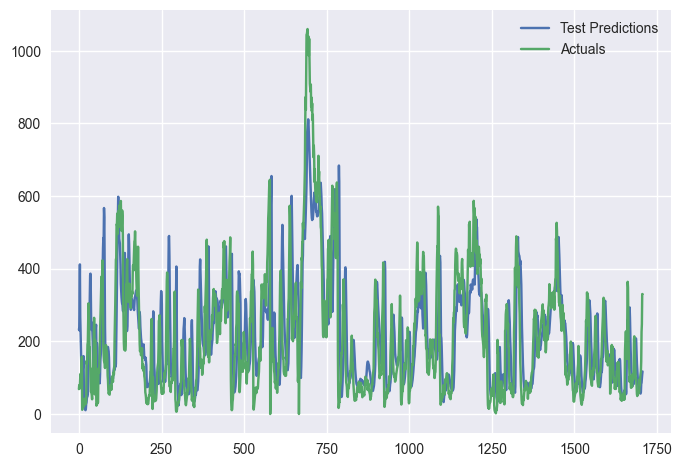

In [36]:
model = load_model('5H_Forecast/5H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(5,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D001_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D001_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)

### 6 hours forecast

In [37]:
%%time

Trainer(6,6,12,50)

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_36 (Bidirecti  (None, 128)              35840     
 onal)                                                           
                                                                 
 dense_74 (Dense)            (None, 8)                 1032      
                                                                 
 dense_75 (Dense)            (None, 1)                 9         
                                                                 
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 14:02:17.819357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:02:18.030381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:02:18.053229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:02:18.817414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:02:18.836570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8432 - mae: 0.5605 - mse: 0.8432 - mape: 216.5373

2023-02-10 14:02:25.605942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:02:25.688175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:02:25.699898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.61289, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 25s 137ms/step - loss: 0.8432 - mae: 0.5605 - mse: 0.8432 - mape: 216.5373 - val_loss: 0.6129 - val_mae: 0.5905 - val_mse: 0.6129 - val_mape: 156.3649
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.6736 - mae: 0.4604 - mse: 0.6736 - mape: 314.0645
Epoch 2: val_loss improved from 0.61289 to 0.46634, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 18s 111ms/step - loss: 0.6736 - mae: 0.4604 - mse: 0.6736 - mape: 314.0645 - val_loss: 0.4663 - val_mae: 0.5013 - val_mse: 0.4663 - val_mape: 164.8685
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.6290 - mae: 0.4263 - mse: 0.6290 - mape: 357.0257
Epoch 3: val_loss improved from 0.46634 to 0.44542, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 17s 103ms/step - loss: 0.6290 - mae: 0.4263 - mse: 0.6290 - mape: 357.0257 - val_loss: 0.4454 - val_mae: 0.4887 - val_mse: 0.4454 - val_mape: 159.1863
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.6166 - mae: 0.4211 - mse: 0.6166 - mape: 383.1025
Epoch 4: val_loss did not improve from 0.44542
161/161 [==============================] - 4s 25ms/step - loss: 0.6166 - mae: 0.4211 - mse: 0.6166 - mape: 383.1025 - val_loss: 0.4552 - val_mae: 0.4903 - val_mse: 0.4552 - val_mape: 157.8721
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.6059 - mae: 0.4148 - mse: 0.6059 - mape: 371.7298
Epoch 5: val_loss did not improve from 0.44542
161/161 [==============================] - 4s 24ms/step - loss: 0.6059 - mae: 0.4148 - mse: 0.6059 - mape: 371.7298 - val_loss: 0.4694 - val_mae: 0.5000 - val_mse: 0.4694 - val_mape: 152.1411
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5969 - mae: 

160/161 [============================>.] - ETA: 0s - loss: 0.4714 - mae: 0.3654 - mse: 0.4714 - mape: 353.6489
Epoch 26: val_loss did not improve from 0.44542
161/161 [==============================] - 4s 23ms/step - loss: 0.4713 - mae: 0.3653 - mse: 0.4713 - mape: 353.5832 - val_loss: 0.5805 - val_mae: 0.5251 - val_mse: 0.5805 - val_mape: 190.3485
Epoch 27/50
159/161 [============================>.] - ETA: 0s - loss: 0.4689 - mae: 0.3636 - mse: 0.4689 - mape: 343.6637
Epoch 27: val_loss did not improve from 0.44542
161/161 [==============================] - 4s 23ms/step - loss: 0.4677 - mae: 0.3638 - mse: 0.4677 - mape: 341.9459 - val_loss: 0.5822 - val_mae: 0.5257 - val_mse: 0.5822 - val_mape: 189.2399
Epoch 28/50
160/161 [============================>.] - ETA: 0s - loss: 0.4643 - mae: 0.3621 - mse: 0.4643 - mape: 353.7959
Epoch 28: val_loss did not improve from 0.44542
161/161 [==============================] - 4s 23ms/step - loss: 0.4642 - mae: 0.3622 - mse: 0.4642 - mape: 353.7354

Epoch 49/50
160/161 [============================>.] - ETA: 0s - loss: 0.4089 - mae: 0.3460 - mse: 0.4089 - mape: 316.8604
Epoch 49: val_loss did not improve from 0.44542
161/161 [==============================] - 4s 23ms/step - loss: 0.4089 - mae: 0.3460 - mse: 0.4089 - mape: 316.7998 - val_loss: 0.5608 - val_mae: 0.5141 - val_mse: 0.5608 - val_mape: 206.7953
Epoch 50/50
159/161 [============================>.] - ETA: 0s - loss: 0.4070 - mae: 0.3486 - mse: 0.4070 - mape: 337.1041
Epoch 50: val_loss did not improve from 0.44542
161/161 [==============================] - 4s 22ms/step - loss: 0.4059 - mae: 0.3487 - mse: 0.4059 - mape: 335.9177 - val_loss: 0.5717 - val_mae: 0.5168 - val_mse: 0.5717 - val_mape: 213.6365

-----------------------------------------------------------------------------------------------------------

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirect

2023-02-10 14:06:11.517938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:06:11.768377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:06:11.829317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:06:12.669410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:06:12.687117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 1.0056 - mae: 0.7181 - mse: 1.0056 - mape: 146.2599

2023-02-10 14:06:20.079071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:06:20.174706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:06:20.191645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.75865, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 25s 135ms/step - loss: 1.0056 - mae: 0.7181 - mse: 1.0056 - mape: 146.2599 - val_loss: 0.7587 - val_mae: 0.6796 - val_mse: 0.7587 - val_mape: 130.3931
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.7546 - mae: 0.5662 - mse: 0.7546 - mape: 195.9120
Epoch 2: val_loss improved from 0.75865 to 0.56975, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.7546 - mae: 0.5662 - mse: 0.7546 - mape: 195.9120 - val_loss: 0.5697 - val_mae: 0.5712 - val_mse: 0.5697 - val_mape: 137.1922
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.6654 - mae: 0.4784 - mse: 0.6654 - mape: 244.2723
Epoch 3: val_loss improved from 0.56975 to 0.55678, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 107ms/step - loss: 0.6654 - mae: 0.4784 - mse: 0.6654 - mape: 244.2723 - val_loss: 0.5568 - val_mae: 0.5556 - val_mse: 0.5568 - val_mape: 145.0748
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.6308 - mae: 0.4447 - mse: 0.6308 - mape: 310.6989
Epoch 4: val_loss improved from 0.55678 to 0.55229, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 103ms/step - loss: 0.6308 - mae: 0.4447 - mse: 0.6308 - mape: 310.6989 - val_loss: 0.5523 - val_mae: 0.5489 - val_mse: 0.5523 - val_mape: 150.8400
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.6093 - mae: 0.4321 - mse: 0.6093 - mape: 330.8828
Epoch 5: val_loss improved from 0.55229 to 0.54254, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 104ms/step - loss: 0.6093 - mae: 0.4321 - mse: 0.6093 - mape: 330.8828 - val_loss: 0.5425 - val_mae: 0.5419 - val_mse: 0.5425 - val_mape: 150.7293
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5920 - mae: 0.4240 - mse: 0.5920 - mape: 364.5710
Epoch 6: val_loss did not improve from 0.54254
161/161 [==============================] - 4s 24ms/step - loss: 0.5920 - mae: 0.4240 - mse: 0.5920 - mape: 364.5710 - val_loss: 0.5491 - val_mae: 0.5452 - val_mse: 0.5491 - val_mape: 146.9484
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.5771 - mae: 0.4165 - mse: 0.5771 - mape: 366.5475
Epoch 7: val_loss improved from 0.54254 to 0.54177, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 103ms/step - loss: 0.5771 - mae: 0.4165 - mse: 0.5771 - mape: 366.5475 - val_loss: 0.5418 - val_mae: 0.5403 - val_mse: 0.5418 - val_mape: 146.5276
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.5654 - mae: 0.4130 - mse: 0.5654 - mape: 365.7329
Epoch 8: val_loss improved from 0.54177 to 0.54011, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 16s 102ms/step - loss: 0.5654 - mae: 0.4130 - mse: 0.5654 - mape: 365.7329 - val_loss: 0.5401 - val_mae: 0.5388 - val_mse: 0.5401 - val_mape: 143.8356
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.5507 - mae: 0.4088 - mse: 0.5507 - mape: 369.3582
Epoch 9: val_loss did not improve from 0.54011
161/161 [==============================] - 4s 24ms/step - loss: 0.5507 - mae: 0.4088 - mse: 0.5507 - mape: 369.3582 - val_loss: 0.5511 - val_mae: 0.5446 - val_mse: 0.5511 - val_mape: 143.5233
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.5394 - mae: 0.4057 - mse: 0.5394 - mape: 366.2665
Epoch 10: val_loss did not improve from 0.54011
161/161 [==============================] - 4s 24ms/step - loss: 0.5394 - mae: 0.4057 - mse: 0.5394 - mape: 366.2665 - val_loss: 0.5570 - val_mae: 0.5493 - val_mse: 0.5570 - val_mape: 142.6166
Epoch 11/50
160/161 [============================>.] - ETA: 0s - loss: 0.5271 - ma

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 106ms/step - loss: 0.5054 - mae: 0.3970 - mse: 0.5054 - mape: 348.6570 - val_loss: 0.5357 - val_mae: 0.5347 - val_mse: 0.5357 - val_mape: 152.3661
Epoch 14/50
161/161 [==============================] - ETA: 0s - loss: 0.4967 - mae: 0.3956 - mse: 0.4967 - mape: 358.7210
Epoch 14: val_loss did not improve from 0.53569
161/161 [==============================] - 4s 24ms/step - loss: 0.4967 - mae: 0.3956 - mse: 0.4967 - mape: 358.7210 - val_loss: 0.5453 - val_mae: 0.5394 - val_mse: 0.5453 - val_mape: 152.8794
Epoch 15/50
161/161 [==============================] - ETA: 0s - loss: 0.4881 - mae: 0.3923 - mse: 0.4881 - mape: 346.8492
Epoch 15: val_loss improved from 0.53569 to 0.53160, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 104ms/step - loss: 0.4881 - mae: 0.3923 - mse: 0.4881 - mape: 346.8492 - val_loss: 0.5316 - val_mae: 0.5304 - val_mse: 0.5316 - val_mape: 154.8948
Epoch 16/50
161/161 [==============================] - ETA: 0s - loss: 0.4792 - mae: 0.3914 - mse: 0.4792 - mape: 343.4213
Epoch 16: val_loss did not improve from 0.53160
161/161 [==============================] - 4s 24ms/step - loss: 0.4792 - mae: 0.3914 - mse: 0.4792 - mape: 343.4213 - val_loss: 0.5457 - val_mae: 0.5364 - val_mse: 0.5457 - val_mape: 151.4032
Epoch 17/50
159/161 [============================>.] - ETA: 0s - loss: 0.4731 - mae: 0.3892 - mse: 0.4731 - mape: 341.4932
Epoch 17: val_loss did not improve from 0.53160
161/161 [==============================] - 4s 23ms/step - loss: 0.4718 - mae: 0.3889 - mse: 0.4718 - mape: 339.9810 - val_loss: 0.5443 - val_mae: 0.5343 - val_mse: 0.5443 - val_mape: 152.5800
Epoch 18/50
160/161 [============================>.] - ETA: 0s - loss: 0.4631 - 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 16s 100ms/step - loss: 0.4561 - mae: 0.3839 - mse: 0.4561 - mape: 339.2181 - val_loss: 0.5292 - val_mae: 0.5278 - val_mse: 0.5292 - val_mape: 160.5555
Epoch 20/50
160/161 [============================>.] - ETA: 0s - loss: 0.4494 - mae: 0.3813 - mse: 0.4494 - mape: 334.2839
Epoch 20: val_loss did not improve from 0.52924
161/161 [==============================] - 4s 24ms/step - loss: 0.4493 - mae: 0.3813 - mse: 0.4493 - mape: 334.2347 - val_loss: 0.5616 - val_mae: 0.5413 - val_mse: 0.5616 - val_mape: 162.3224
Epoch 21/50
161/161 [==============================] - ETA: 0s - loss: 0.4438 - mae: 0.3805 - mse: 0.4438 - mape: 335.5580
Epoch 21: val_loss did not improve from 0.52924
161/161 [==============================] - 4s 24ms/step - loss: 0.4438 - mae: 0.3805 - mse: 0.4438 - mape: 335.5580 - val_loss: 0.5349 - val_mae: 0.5307 - val_mse: 0.5349 - val_mape: 155.5282
Epoch 22/50
160/161 [============================>.] - ETA: 0s - loss: 0.4377 - 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 104ms/step - loss: 0.4376 - mae: 0.3804 - mse: 0.4376 - mape: 331.0285 - val_loss: 0.5257 - val_mae: 0.5226 - val_mse: 0.5257 - val_mape: 169.5695
Epoch 23/50
161/161 [==============================] - ETA: 0s - loss: 0.4324 - mae: 0.3784 - mse: 0.4324 - mape: 340.1184
Epoch 23: val_loss did not improve from 0.52573
161/161 [==============================] - 4s 24ms/step - loss: 0.4324 - mae: 0.3784 - mse: 0.4324 - mape: 340.1184 - val_loss: 0.5423 - val_mae: 0.5303 - val_mse: 0.5423 - val_mape: 172.6365
Epoch 24/50
159/161 [============================>.] - ETA: 0s - loss: 0.4273 - mae: 0.3760 - mse: 0.4273 - mape: 330.9236
Epoch 24: val_loss did not improve from 0.52573
161/161 [==============================] - 4s 23ms/step - loss: 0.4260 - mae: 0.3758 - mse: 0.4260 - mape: 329.2515 - val_loss: 0.5449 - val_mae: 0.5311 - val_mse: 0.5449 - val_mape: 171.3841
Epoch 25/50
161/161 [==============================] - ETA: 0s - loss: 0.4199 - 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 16s 98ms/step - loss: 0.4199 - mae: 0.3741 - mse: 0.4199 - mape: 330.8670 - val_loss: 0.5175 - val_mae: 0.5162 - val_mse: 0.5175 - val_mape: 181.2317
Epoch 26/50
161/161 [==============================] - ETA: 0s - loss: 0.4174 - mae: 0.3728 - mse: 0.4174 - mape: 332.0368
Epoch 26: val_loss improved from 0.51748 to 0.51421, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 16s 102ms/step - loss: 0.4174 - mae: 0.3728 - mse: 0.4174 - mape: 332.0368 - val_loss: 0.5142 - val_mae: 0.5136 - val_mse: 0.5142 - val_mape: 185.3376
Epoch 27/50
160/161 [============================>.] - ETA: 0s - loss: 0.4099 - mae: 0.3720 - mse: 0.4099 - mape: 325.2260
Epoch 27: val_loss improved from 0.51421 to 0.50163, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 16s 102ms/step - loss: 0.4099 - mae: 0.3720 - mse: 0.4099 - mape: 325.1766 - val_loss: 0.5016 - val_mae: 0.5052 - val_mse: 0.5016 - val_mape: 186.2942
Epoch 28/50
160/161 [============================>.] - ETA: 0s - loss: 0.4056 - mae: 0.3688 - mse: 0.4056 - mape: 321.8055
Epoch 28: val_loss improved from 0.50163 to 0.49797, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 16s 97ms/step - loss: 0.4056 - mae: 0.3688 - mse: 0.4056 - mape: 321.7542 - val_loss: 0.4980 - val_mae: 0.5080 - val_mse: 0.4980 - val_mape: 183.9696
Epoch 29/50
160/161 [============================>.] - ETA: 0s - loss: 0.4019 - mae: 0.3686 - mse: 0.4019 - mape: 336.3676
Epoch 29: val_loss improved from 0.49797 to 0.47977, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 16s 102ms/step - loss: 0.4019 - mae: 0.3685 - mse: 0.4019 - mape: 336.3029 - val_loss: 0.4798 - val_mae: 0.4972 - val_mse: 0.4798 - val_mape: 181.7028
Epoch 30/50
159/161 [============================>.] - ETA: 0s - loss: 0.3943 - mae: 0.3630 - mse: 0.3943 - mape: 336.1406
Epoch 30: val_loss did not improve from 0.47977
161/161 [==============================] - 4s 24ms/step - loss: 0.3973 - mae: 0.3646 - mse: 0.3973 - mape: 337.3733 - val_loss: 0.5094 - val_mae: 0.5113 - val_mse: 0.5094 - val_mape: 183.9429
Epoch 31/50
161/161 [==============================] - ETA: 0s - loss: 0.3925 - mae: 0.3642 - mse: 0.3925 - mape: 321.8517
Epoch 31: val_loss did not improve from 0.47977
161/161 [==============================] - 4s 26ms/step - loss: 0.3925 - mae: 0.3642 - mse: 0.3925 - mape: 321.8517 - val_loss: 0.4881 - val_mae: 0.5043 - val_mse: 0.4881 - val_mape: 173.3316
Epoch 32/50
160/161 [============================>.] - ETA: 0s - loss: 0.3897 - 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 16s 103ms/step - loss: 0.3787 - mae: 0.3595 - mse: 0.3787 - mape: 316.0021 - val_loss: 0.4711 - val_mae: 0.4901 - val_mse: 0.4711 - val_mape: 196.3018
Epoch 36/50
161/161 [==============================] - ETA: 0s - loss: 0.3767 - mae: 0.3577 - mse: 0.3767 - mape: 316.6783
Epoch 36: val_loss did not improve from 0.47112
161/161 [==============================] - 4s 23ms/step - loss: 0.3767 - mae: 0.3577 - mse: 0.3767 - mape: 316.6783 - val_loss: 0.4860 - val_mae: 0.4951 - val_mse: 0.4860 - val_mape: 207.5816
Epoch 37/50
161/161 [==============================] - ETA: 0s - loss: 0.3727 - mae: 0.3573 - mse: 0.3727 - mape: 319.6866
Epoch 37: val_loss did not improve from 0.47112
161/161 [==============================] - 4s 23ms/step - loss: 0.3727 - mae: 0.3573 - mse: 0.3727 - mape: 319.6866 - val_loss: 0.4745 - val_mae: 0.4925 - val_mse: 0.4745 - val_mape: 203.4575
Epoch 38/50
161/161 [==============================] - ETA: 0s - loss: 0.3710 - 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 105ms/step - loss: 0.3584 - mae: 0.3482 - mse: 0.3584 - mape: 313.2703 - val_loss: 0.4695 - val_mae: 0.4855 - val_mse: 0.4695 - val_mape: 210.7645
Epoch 45/50
159/161 [============================>.] - ETA: 0s - loss: 0.3575 - mae: 0.3475 - mse: 0.3575 - mape: 304.1166
Epoch 45: val_loss did not improve from 0.46953
161/161 [==============================] - 4s 24ms/step - loss: 0.3564 - mae: 0.3476 - mse: 0.3564 - mape: 303.2832 - val_loss: 0.4731 - val_mae: 0.4852 - val_mse: 0.4731 - val_mape: 222.0700
Epoch 46/50
159/161 [============================>.] - ETA: 0s - loss: 0.3563 - mae: 0.3471 - mse: 0.3563 - mape: 308.5863
Epoch 46: val_loss improved from 0.46953 to 0.46485, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 17s 105ms/step - loss: 0.3552 - mae: 0.3470 - mse: 0.3552 - mape: 307.9233 - val_loss: 0.4649 - val_mae: 0.4824 - val_mse: 0.4649 - val_mape: 219.1604
Epoch 47/50
159/161 [============================>.] - ETA: 0s - loss: 0.3537 - mae: 0.3459 - mse: 0.3537 - mape: 307.6797
Epoch 47: val_loss did not improve from 0.46485
161/161 [==============================] - 4s 24ms/step - loss: 0.3536 - mae: 0.3462 - mse: 0.3536 - mape: 306.4874 - val_loss: 0.4795 - val_mae: 0.4872 - val_mse: 0.4795 - val_mape: 221.1090
Epoch 48/50
160/161 [============================>.] - ETA: 0s - loss: 0.3521 - mae: 0.3439 - mse: 0.3521 - mape: 302.8739
Epoch 48: val_loss improved from 0.46485 to 0.45132, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 16s 102ms/step - loss: 0.3520 - mae: 0.3438 - mse: 0.3520 - mape: 302.8165 - val_loss: 0.4513 - val_mae: 0.4716 - val_mse: 0.4513 - val_mape: 222.6623
Epoch 49/50
159/161 [============================>.] - ETA: 0s - loss: 0.3504 - mae: 0.3428 - mse: 0.3504 - mape: 307.9680
Epoch 49: val_loss did not improve from 0.45132
161/161 [==============================] - 4s 23ms/step - loss: 0.3500 - mae: 0.3430 - mse: 0.3500 - mape: 312.7199 - val_loss: 0.4634 - val_mae: 0.4774 - val_mse: 0.4634 - val_mape: 223.5671
Epoch 50/50
160/161 [============================>.] - ETA: 0s - loss: 0.3489 - mae: 0.3426 - mse: 0.3489 - mape: 305.9308
Epoch 50: val_loss did not improve from 0.45132
161/161 [==============================] - 3s 22ms/step - loss: 0.3488 - mae: 0.3426 - mse: 0.3488 - mape: 305.8917 - val_loss: 0.4948 - val_mae: 0.4919 - val_mse: 0.4948 - val_mape: 220.7832

-------------------------------------------------------------------------------

2023-02-10 14:13:45.352077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:13:45.510520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:13:45.510632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:13:46.313270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:13:46.330726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.9467 - mae: 0.6693 - mse: 0.9467 - mape: 201.8373

2023-02-10 14:13:52.564168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:13:52.652502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:13:52.665142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.62742, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 24s 132ms/step - loss: 0.9467 - mae: 0.6693 - mse: 0.9467 - mape: 201.8373 - val_loss: 0.6274 - val_mae: 0.6113 - val_mse: 0.6274 - val_mape: 149.9766
Epoch 2/50
159/160 [============================>.] - ETA: 0s - loss: 0.6954 - mae: 0.4797 - mse: 0.6954 - mape: 330.1261
Epoch 2: val_loss improved from 0.62742 to 0.53949, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 17s 103ms/step - loss: 0.6974 - mae: 0.4801 - mse: 0.6974 - mape: 329.4694 - val_loss: 0.5395 - val_mae: 0.5544 - val_mse: 0.5395 - val_mape: 152.9507
Epoch 3/50
159/160 [============================>.] - ETA: 0s - loss: 0.6656 - mae: 0.4492 - mse: 0.6656 - mape: 379.2956
Epoch 3: val_loss improved from 0.53949 to 0.51439, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 16s 102ms/step - loss: 0.6623 - mae: 0.4482 - mse: 0.6623 - mape: 378.4395 - val_loss: 0.5144 - val_mae: 0.5356 - val_mse: 0.5144 - val_mape: 146.5796
Epoch 4/50
159/160 [============================>.] - ETA: 0s - loss: 0.6427 - mae: 0.4372 - mse: 0.6427 - mape: 385.3760
Epoch 4: val_loss improved from 0.51439 to 0.50788, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 17s 104ms/step - loss: 0.6409 - mae: 0.4371 - mse: 0.6409 - mape: 383.7887 - val_loss: 0.5079 - val_mae: 0.5289 - val_mse: 0.5079 - val_mape: 137.0997
Epoch 5/50
159/160 [============================>.] - ETA: 0s - loss: 0.6270 - mae: 0.4274 - mse: 0.6270 - mape: 378.4919
Epoch 5: val_loss improved from 0.50788 to 0.50559, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 16s 98ms/step - loss: 0.6248 - mae: 0.4272 - mse: 0.6248 - mape: 377.6060 - val_loss: 0.5056 - val_mae: 0.5258 - val_mse: 0.5056 - val_mape: 135.8853
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.6111 - mae: 0.4244 - mse: 0.6111 - mape: 377.4621
Epoch 6: val_loss did not improve from 0.50559
160/160 [==============================] - 4s 25ms/step - loss: 0.6111 - mae: 0.4244 - mse: 0.6111 - mape: 377.4621 - val_loss: 0.5123 - val_mae: 0.5271 - val_mse: 0.5123 - val_mape: 134.5325
Epoch 7/50
158/160 [============================>.] - ETA: 0s - loss: 0.6026 - mae: 0.4167 - mse: 0.6026 - mape: 376.2581
Epoch 7: val_loss did not improve from 0.50559
160/160 [==============================] - 4s 25ms/step - loss: 0.5984 - mae: 0.4166 - mse: 0.5984 - mape: 375.3966 - val_loss: 0.5077 - val_mae: 0.5243 - val_mse: 0.5077 - val_mape: 135.2810
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.5860 - mae: 0

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 16s 102ms/step - loss: 0.5860 - mae: 0.4147 - mse: 0.5860 - mape: 375.1620 - val_loss: 0.5051 - val_mae: 0.5237 - val_mse: 0.5051 - val_mape: 135.9998
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.5730 - mae: 0.4091 - mse: 0.5730 - mape: 375.1895
Epoch 9: val_loss did not improve from 0.50511
160/160 [==============================] - 4s 22ms/step - loss: 0.5730 - mae: 0.4091 - mse: 0.5730 - mape: 375.1895 - val_loss: 0.5134 - val_mae: 0.5263 - val_mse: 0.5134 - val_mape: 137.9269
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.5613 - mae: 0.4047 - mse: 0.5613 - mape: 367.8608
Epoch 10: val_loss did not improve from 0.50511
160/160 [==============================] - 3s 22ms/step - loss: 0.5613 - mae: 0.4047 - mse: 0.5613 - mape: 367.8608 - val_loss: 0.5231 - val_mae: 0.5303 - val_mse: 0.5231 - val_mape: 139.7284
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.5499 - ma

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 16s 103ms/step - loss: 0.4529 - mae: 0.3781 - mse: 0.4529 - mape: 344.0383 - val_loss: 0.4910 - val_mae: 0.5092 - val_mse: 0.4910 - val_mape: 176.1747
Epoch 23/50
160/160 [==============================] - ETA: 0s - loss: 0.4464 - mae: 0.3735 - mse: 0.4464 - mape: 323.9456
Epoch 23: val_loss did not improve from 0.49098
160/160 [==============================] - 3s 22ms/step - loss: 0.4464 - mae: 0.3735 - mse: 0.4464 - mape: 323.9456 - val_loss: 0.5083 - val_mae: 0.5142 - val_mse: 0.5083 - val_mape: 175.1524
Epoch 24/50
160/160 [==============================] - ETA: 0s - loss: 0.4405 - mae: 0.3739 - mse: 0.4405 - mape: 333.3415
Epoch 24: val_loss did not improve from 0.49098
160/160 [==============================] - 3s 22ms/step - loss: 0.4405 - mae: 0.3739 - mse: 0.4405 - mape: 333.3415 - val_loss: 0.5444 - val_mae: 0.5242 - val_mse: 0.5444 - val_mape: 178.5050
Epoch 25/50
159/160 [============================>.] - ETA: 0s - loss: 0.4346 - 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 16s 98ms/step - loss: 0.4166 - mae: 0.3660 - mse: 0.4166 - mape: 319.7827 - val_loss: 0.4781 - val_mae: 0.4983 - val_mse: 0.4781 - val_mape: 188.6624
Epoch 29/50
159/160 [============================>.] - ETA: 0s - loss: 0.4118 - mae: 0.3660 - mse: 0.4118 - mape: 324.9286
Epoch 29: val_loss did not improve from 0.47814
160/160 [==============================] - 4s 22ms/step - loss: 0.4100 - mae: 0.3655 - mse: 0.4100 - mape: 323.2959 - val_loss: 0.4829 - val_mae: 0.4952 - val_mse: 0.4829 - val_mape: 185.6334
Epoch 30/50
160/160 [==============================] - ETA: 0s - loss: 0.4042 - mae: 0.3631 - mse: 0.4042 - mape: 317.8990
Epoch 30: val_loss did not improve from 0.47814
160/160 [==============================] - 4s 22ms/step - loss: 0.4042 - mae: 0.3631 - mse: 0.4042 - mape: 317.8990 - val_loss: 0.4953 - val_mae: 0.5018 - val_mse: 0.4953 - val_mape: 184.9816
Epoch 31/50
160/160 [==============================] - ETA: 0s - loss: 0.3998 - m

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_39 (Bidirecti  (None, 128)              35840     
 onal)                                                           
                                                                 
 dense_80 (Dense)            (None, 8)                 1032      
                                                                 
 dense_81 (Dense)            (None, 1)                 9         
                                                                 
Total params: 36,881
Trainable params: 36,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 14:18:31.279352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:18:31.534305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:18:31.601188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:18:32.442123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:18:32.459885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.8334 - mae: 0.5858 - mse: 0.8334 - mape: 197.8345

2023-02-10 14:18:39.568281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:18:39.654440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:18:39.666350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.53034, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 25s 137ms/step - loss: 0.8334 - mae: 0.5858 - mse: 0.8334 - mape: 197.8345 - val_loss: 0.5303 - val_mae: 0.5492 - val_mse: 0.5303 - val_mape: 145.9914
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.6726 - mae: 0.4608 - mse: 0.6726 - mape: 299.7447
Epoch 2: val_loss improved from 0.53034 to 0.48070, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 18s 110ms/step - loss: 0.6726 - mae: 0.4608 - mse: 0.6726 - mape: 299.7447 - val_loss: 0.4807 - val_mae: 0.5105 - val_mse: 0.4807 - val_mape: 155.3250
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.6438 - mae: 0.4366 - mse: 0.6438 - mape: 341.2758
Epoch 3: val_loss improved from 0.48070 to 0.46517, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 17s 106ms/step - loss: 0.6438 - mae: 0.4366 - mse: 0.6438 - mape: 341.2758 - val_loss: 0.4652 - val_mae: 0.5051 - val_mse: 0.4652 - val_mape: 154.7204
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.6257 - mae: 0.4311 - mse: 0.6257 - mape: 343.2903
Epoch 4: val_loss did not improve from 0.46517
160/160 [==============================] - 4s 26ms/step - loss: 0.6257 - mae: 0.4311 - mse: 0.6257 - mape: 343.2903 - val_loss: 0.4677 - val_mae: 0.5052 - val_mse: 0.4677 - val_mape: 153.5424
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.6102 - mae: 0.4218 - mse: 0.6102 - mape: 347.8138
Epoch 5: val_loss did not improve from 0.46517
160/160 [==============================] - 4s 24ms/step - loss: 0.6102 - mae: 0.4218 - mse: 0.6102 - mape: 347.8138 - val_loss: 0.4863 - val_mae: 0.5155 - val_mse: 0.4863 - val_mape: 144.3649
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.5971 - mae: 

158/160 [============================>.] - ETA: 0s - loss: 0.4226 - mae: 0.3745 - mse: 0.4226 - mape: 304.2281
Epoch 26: val_loss improved from 0.46517 to 0.45424, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 17s 107ms/step - loss: 0.4227 - mae: 0.3751 - mse: 0.4227 - mape: 301.7696 - val_loss: 0.4542 - val_mae: 0.4916 - val_mse: 0.4542 - val_mape: 193.8623
Epoch 27/50
159/160 [============================>.] - ETA: 0s - loss: 0.4207 - mae: 0.3738 - mse: 0.4207 - mape: 283.4658
Epoch 27: val_loss improved from 0.45424 to 0.44653, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 16s 101ms/step - loss: 0.4195 - mae: 0.3737 - mse: 0.4195 - mape: 282.5738 - val_loss: 0.4465 - val_mae: 0.4891 - val_mse: 0.4465 - val_mape: 204.5826
Epoch 28/50
160/160 [==============================] - ETA: 0s - loss: 0.4134 - mae: 0.3724 - mse: 0.4134 - mape: 299.7270
Epoch 28: val_loss did not improve from 0.44653
160/160 [==============================] - 4s 24ms/step - loss: 0.4134 - mae: 0.3724 - mse: 0.4134 - mape: 299.7270 - val_loss: 0.4502 - val_mae: 0.4895 - val_mse: 0.4502 - val_mape: 199.5331
Epoch 29/50
160/160 [==============================] - ETA: 0s - loss: 0.4100 - mae: 0.3704 - mse: 0.4100 - mape: 282.7077
Epoch 29: val_loss improved from 0.44653 to 0.44297, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 17s 104ms/step - loss: 0.4100 - mae: 0.3704 - mse: 0.4100 - mape: 282.7077 - val_loss: 0.4430 - val_mae: 0.4870 - val_mse: 0.4430 - val_mape: 199.8342
Epoch 30/50
159/160 [============================>.] - ETA: 0s - loss: 0.4072 - mae: 0.3704 - mse: 0.4072 - mape: 294.1273
Epoch 30: val_loss did not improve from 0.44297
160/160 [==============================] - 4s 23ms/step - loss: 0.4057 - mae: 0.3699 - mse: 0.4057 - mape: 294.4280 - val_loss: 0.4478 - val_mae: 0.4858 - val_mse: 0.4478 - val_mape: 207.4715
Epoch 31/50
160/160 [==============================] - ETA: 0s - loss: 0.4025 - mae: 0.3683 - mse: 0.4025 - mape: 290.4365
Epoch 31: val_loss did not improve from 0.44297
160/160 [==============================] - 4s 23ms/step - loss: 0.4025 - mae: 0.3683 - mse: 0.4025 - mape: 290.4365 - val_loss: 0.4584 - val_mae: 0.4952 - val_mse: 0.4584 - val_mape: 205.1230
Epoch 32/50
159/160 [============================>.] - ETA: 0s - loss: 0.3941 - 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 17s 106ms/step - loss: 0.3994 - mae: 0.3685 - mse: 0.3994 - mape: 275.2137 - val_loss: 0.4267 - val_mae: 0.4742 - val_mse: 0.4267 - val_mape: 209.2557
Epoch 33/50
160/160 [==============================] - ETA: 0s - loss: 0.3967 - mae: 0.3660 - mse: 0.3967 - mape: 292.3716
Epoch 33: val_loss did not improve from 0.42667
160/160 [==============================] - 4s 22ms/step - loss: 0.3967 - mae: 0.3660 - mse: 0.3967 - mape: 292.3716 - val_loss: 0.4466 - val_mae: 0.4870 - val_mse: 0.4466 - val_mape: 202.2798
Epoch 34/50
160/160 [==============================] - ETA: 0s - loss: 0.3922 - mae: 0.3636 - mse: 0.3922 - mape: 282.7995
Epoch 34: val_loss did not improve from 0.42667
160/160 [==============================] - 4s 22ms/step - loss: 0.3922 - mae: 0.3636 - mse: 0.3922 - mape: 282.7995 - val_loss: 0.4558 - val_mae: 0.4937 - val_mse: 0.4558 - val_mape: 206.5108
Epoch 35/50
158/160 [============================>.] - ETA: 0s - loss: 0.3941 - 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 16s 101ms/step - loss: 0.3757 - mae: 0.3585 - mse: 0.3757 - mape: 269.1039 - val_loss: 0.4229 - val_mae: 0.4718 - val_mse: 0.4229 - val_mape: 208.4235
Epoch 41/50
160/160 [==============================] - ETA: 0s - loss: 0.3728 - mae: 0.3571 - mse: 0.3728 - mape: 274.0257
Epoch 41: val_loss did not improve from 0.42292
160/160 [==============================] - 4s 23ms/step - loss: 0.3728 - mae: 0.3571 - mse: 0.3728 - mape: 274.0257 - val_loss: 0.4381 - val_mae: 0.4775 - val_mse: 0.4381 - val_mape: 211.6844
Epoch 42/50
159/160 [============================>.] - ETA: 0s - loss: 0.3700 - mae: 0.3550 - mse: 0.3700 - mape: 274.2069
Epoch 42: val_loss did not improve from 0.42292
160/160 [==============================] - 4s 23ms/step - loss: 0.3704 - mae: 0.3554 - mse: 0.3704 - mape: 272.8678 - val_loss: 0.4703 - val_mae: 0.4980 - val_mse: 0.4703 - val_mape: 201.0768
Epoch 43/50
160/160 [==============================] - ETA: 0s - loss: 0.3678 - 

2023-02-10 14:23:32.632693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:23:32.928900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:23:32.986924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:23:33.842596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:23:33.866921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.8911 - mae: 0.6133 - mse: 0.8911 - mape: 169.3507

2023-02-10 14:23:41.067055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:23:41.145885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:23:41.160250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.69277, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 25s 137ms/step - loss: 0.8911 - mae: 0.6133 - mse: 0.8911 - mape: 169.3507 - val_loss: 0.6928 - val_mae: 0.6315 - val_mse: 0.6928 - val_mape: 122.6089
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.6946 - mae: 0.4712 - mse: 0.6946 - mape: 385.6301
Epoch 2: val_loss improved from 0.69277 to 0.57292, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 18s 112ms/step - loss: 0.6946 - mae: 0.4712 - mse: 0.6946 - mape: 385.6301 - val_loss: 0.5729 - val_mae: 0.5628 - val_mse: 0.5729 - val_mape: 136.6024
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.6595 - mae: 0.4486 - mse: 0.6595 - mape: 410.7419
Epoch 3: val_loss improved from 0.57292 to 0.54536, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 17s 106ms/step - loss: 0.6595 - mae: 0.4486 - mse: 0.6595 - mape: 410.7419 - val_loss: 0.5454 - val_mae: 0.5466 - val_mse: 0.5454 - val_mape: 134.4989
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.6365 - mae: 0.4369 - mse: 0.6365 - mape: 400.3211
Epoch 4: val_loss did not improve from 0.54536
160/160 [==============================] - 4s 26ms/step - loss: 0.6365 - mae: 0.4369 - mse: 0.6365 - mape: 400.3211 - val_loss: 0.5512 - val_mae: 0.5517 - val_mse: 0.5512 - val_mape: 128.9482
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.6165 - mae: 0.4293 - mse: 0.6165 - mape: 395.2753
Epoch 5: val_loss improved from 0.54536 to 0.54197, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 17s 106ms/step - loss: 0.6165 - mae: 0.4293 - mse: 0.6165 - mape: 395.2753 - val_loss: 0.5420 - val_mae: 0.5477 - val_mse: 0.5420 - val_mape: 126.2452
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.5988 - mae: 0.4234 - mse: 0.5988 - mape: 390.6698
Epoch 6: val_loss improved from 0.54197 to 0.53180, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 16s 102ms/step - loss: 0.5988 - mae: 0.4234 - mse: 0.5988 - mape: 390.6698 - val_loss: 0.5318 - val_mae: 0.5371 - val_mse: 0.5318 - val_mape: 130.8671
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.5815 - mae: 0.4169 - mse: 0.5815 - mape: 382.0088
Epoch 7: val_loss did not improve from 0.53180
160/160 [==============================] - 4s 25ms/step - loss: 0.5815 - mae: 0.4169 - mse: 0.5815 - mape: 382.0088 - val_loss: 0.5368 - val_mae: 0.5418 - val_mse: 0.5368 - val_mape: 129.6649
Epoch 8/50
159/160 [============================>.] - ETA: 0s - loss: 0.5683 - mae: 0.4093 - mse: 0.5683 - mape: 371.2248
Epoch 8: val_loss did not improve from 0.53180
160/160 [==============================] - 4s 25ms/step - loss: 0.5663 - mae: 0.4095 - mse: 0.5663 - mape: 369.7768 - val_loss: 0.5623 - val_mae: 0.5524 - val_mse: 0.5623 - val_mape: 127.7821
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.5524 - mae: 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 17s 104ms/step - loss: 0.5524 - mae: 0.4095 - mse: 0.5524 - mape: 361.1544 - val_loss: 0.5242 - val_mae: 0.5260 - val_mse: 0.5242 - val_mape: 136.4267
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.5379 - mae: 0.4008 - mse: 0.5379 - mape: 353.2723
Epoch 10: val_loss did not improve from 0.52424
160/160 [==============================] - 4s 26ms/step - loss: 0.5379 - mae: 0.4008 - mse: 0.5379 - mape: 353.2723 - val_loss: 0.5538 - val_mae: 0.5475 - val_mse: 0.5538 - val_mape: 130.6761
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.5245 - mae: 0.3985 - mse: 0.5245 - mape: 347.8968
Epoch 11: val_loss did not improve from 0.52424
160/160 [==============================] - 4s 24ms/step - loss: 0.5245 - mae: 0.3985 - mse: 0.5245 - mape: 347.8968 - val_loss: 0.5437 - val_mae: 0.5348 - val_mse: 0.5437 - val_mape: 140.5836
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 0.5114 - 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 17s 105ms/step - loss: 0.4436 - mae: 0.3796 - mse: 0.4436 - mape: 321.6634 - val_loss: 0.4830 - val_mae: 0.5030 - val_mse: 0.4830 - val_mape: 149.3408
Epoch 21/50
160/160 [==============================] - ETA: 0s - loss: 0.4385 - mae: 0.3755 - mse: 0.4385 - mape: 306.3489
Epoch 21: val_loss did not improve from 0.48298
160/160 [==============================] - 4s 25ms/step - loss: 0.4385 - mae: 0.3755 - mse: 0.4385 - mape: 306.3489 - val_loss: 0.4968 - val_mae: 0.5106 - val_mse: 0.4968 - val_mape: 149.0791
Epoch 22/50
160/160 [==============================] - ETA: 0s - loss: 0.4313 - mae: 0.3723 - mse: 0.4313 - mape: 322.1126
Epoch 22: val_loss did not improve from 0.48298
160/160 [==============================] - 4s 24ms/step - loss: 0.4313 - mae: 0.3723 - mse: 0.4313 - mape: 322.1126 - val_loss: 0.5200 - val_mae: 0.5170 - val_mse: 0.5200 - val_mape: 149.2148
Epoch 23/50
158/160 [============================>.] - ETA: 0s - loss: 0.4160 - 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 16s 98ms/step - loss: 0.3999 - mae: 0.3629 - mse: 0.3999 - mape: 310.0108 - val_loss: 0.4829 - val_mae: 0.5016 - val_mse: 0.4829 - val_mape: 154.6458
Epoch 29/50
159/160 [============================>.] - ETA: 0s - loss: 0.3956 - mae: 0.3615 - mse: 0.3956 - mape: 297.9716
Epoch 29: val_loss did not improve from 0.48294
160/160 [==============================] - 4s 24ms/step - loss: 0.3952 - mae: 0.3616 - mse: 0.3952 - mape: 296.7456 - val_loss: 0.4897 - val_mae: 0.5067 - val_mse: 0.4897 - val_mape: 157.1429
Epoch 30/50
159/160 [============================>.] - ETA: 0s - loss: 0.3907 - mae: 0.3579 - mse: 0.3907 - mape: 299.1364
Epoch 30: val_loss did not improve from 0.48294
160/160 [==============================] - 4s 23ms/step - loss: 0.3895 - mae: 0.3577 - mse: 0.3895 - mape: 298.6947 - val_loss: 0.4838 - val_mae: 0.5003 - val_mse: 0.4838 - val_mape: 155.6569
Epoch 31/50
160/160 [==============================] - ETA: 0s - loss: 0.3866 - m

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 16s 102ms/step - loss: 0.3866 - mae: 0.3606 - mse: 0.3866 - mape: 303.4242 - val_loss: 0.4812 - val_mae: 0.5024 - val_mse: 0.4812 - val_mape: 153.4922
Epoch 32/50
159/160 [============================>.] - ETA: 0s - loss: 0.3841 - mae: 0.3589 - mse: 0.3841 - mape: 305.8911
Epoch 32: val_loss did not improve from 0.48125
160/160 [==============================] - 4s 24ms/step - loss: 0.3827 - mae: 0.3585 - mse: 0.3827 - mape: 304.5353 - val_loss: 0.4883 - val_mae: 0.5035 - val_mse: 0.4883 - val_mape: 157.5461
Epoch 33/50
159/160 [============================>.] - ETA: 0s - loss: 0.3806 - mae: 0.3536 - mse: 0.3806 - mape: 306.9873
Epoch 33: val_loss improved from 0.48125 to 0.45999, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 16s 100ms/step - loss: 0.3805 - mae: 0.3539 - mse: 0.3805 - mape: 305.6481 - val_loss: 0.4600 - val_mae: 0.4882 - val_mse: 0.4600 - val_mape: 161.4293
Epoch 34/50
159/160 [============================>.] - ETA: 0s - loss: 0.3761 - mae: 0.3561 - mse: 0.3761 - mape: 306.6587
Epoch 34: val_loss did not improve from 0.45999
160/160 [==============================] - 4s 24ms/step - loss: 0.3756 - mae: 0.3565 - mse: 0.3756 - mape: 306.0340 - val_loss: 0.4919 - val_mae: 0.5055 - val_mse: 0.4919 - val_mape: 158.0636
Epoch 35/50
160/160 [==============================] - ETA: 0s - loss: 0.3733 - mae: 0.3518 - mse: 0.3733 - mape: 305.0209
Epoch 35: val_loss did not improve from 0.45999
160/160 [==============================] - 4s 23ms/step - loss: 0.3733 - mae: 0.3518 - mse: 0.3733 - mape: 305.0209 - val_loss: 0.4761 - val_mae: 0.4961 - val_mse: 0.4761 - val_mape: 160.4410
Epoch 36/50
160/160 [==============================] - ETA: 0s - loss: 0.3678 - 

2023-02-10 14:29:03.930836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:29:04.234309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:29:04.304596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:29:05.392921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:29:05.421733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 1.0494 - mae: 0.7294 - mse: 1.0494 - mape: 159.8655

2023-02-10 14:29:13.150683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:29:13.236002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:29:13.248182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.59500, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 27s 145ms/step - loss: 1.0494 - mae: 0.7294 - mse: 1.0494 - mape: 159.8655 - val_loss: 0.5950 - val_mae: 0.5675 - val_mse: 0.5950 - val_mape: 139.3763
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.7845 - mae: 0.5589 - mse: 0.7845 - mape: 331.8979
Epoch 2: val_loss improved from 0.59500 to 0.55846, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 108ms/step - loss: 0.7845 - mae: 0.5589 - mse: 0.7845 - mape: 331.8979 - val_loss: 0.5585 - val_mae: 0.5483 - val_mse: 0.5585 - val_mape: 166.7981
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.6820 - mae: 0.4616 - mse: 0.6820 - mape: 398.7059
Epoch 3: val_loss improved from 0.55846 to 0.55329, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 105ms/step - loss: 0.6820 - mae: 0.4616 - mse: 0.6820 - mape: 398.7059 - val_loss: 0.5533 - val_mae: 0.5471 - val_mse: 0.5533 - val_mape: 153.2331
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.6629 - mae: 0.4439 - mse: 0.6629 - mape: 394.5457
Epoch 4: val_loss improved from 0.55329 to 0.54766, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 104ms/step - loss: 0.6629 - mae: 0.4439 - mse: 0.6629 - mape: 394.5457 - val_loss: 0.5477 - val_mae: 0.5443 - val_mse: 0.5477 - val_mape: 151.7243
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.6465 - mae: 0.4400 - mse: 0.6465 - mape: 387.7118
Epoch 5: val_loss improved from 0.54766 to 0.52918, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 107ms/step - loss: 0.6465 - mae: 0.4400 - mse: 0.6465 - mape: 387.7118 - val_loss: 0.5292 - val_mae: 0.5342 - val_mse: 0.5292 - val_mape: 152.1015
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.6320 - mae: 0.4299 - mse: 0.6320 - mape: 388.1261
Epoch 6: val_loss improved from 0.52918 to 0.52580, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 104ms/step - loss: 0.6320 - mae: 0.4299 - mse: 0.6320 - mape: 388.1261 - val_loss: 0.5258 - val_mae: 0.5319 - val_mse: 0.5258 - val_mape: 145.3337
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.6188 - mae: 0.4223 - mse: 0.6188 - mape: 376.9730
Epoch 7: val_loss improved from 0.52580 to 0.52154, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 104ms/step - loss: 0.6188 - mae: 0.4223 - mse: 0.6188 - mape: 376.9730 - val_loss: 0.5215 - val_mae: 0.5284 - val_mse: 0.5215 - val_mape: 143.8122
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.6052 - mae: 0.4198 - mse: 0.6052 - mape: 377.4121
Epoch 8: val_loss improved from 0.52154 to 0.51809, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 16s 102ms/step - loss: 0.6052 - mae: 0.4198 - mse: 0.6052 - mape: 377.4121 - val_loss: 0.5181 - val_mae: 0.5265 - val_mse: 0.5181 - val_mape: 140.6568
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.5936 - mae: 0.4105 - mse: 0.5936 - mape: 371.0261
Epoch 9: val_loss improved from 0.51809 to 0.50495, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 17s 104ms/step - loss: 0.5936 - mae: 0.4105 - mse: 0.5936 - mape: 371.0261 - val_loss: 0.5050 - val_mae: 0.5208 - val_mse: 0.5050 - val_mape: 137.2538
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.5817 - mae: 0.4065 - mse: 0.5817 - mape: 366.5053
Epoch 10: val_loss did not improve from 0.50495
160/160 [==============================] - 4s 25ms/step - loss: 0.5817 - mae: 0.4065 - mse: 0.5817 - mape: 366.5053 - val_loss: 0.5166 - val_mae: 0.5258 - val_mse: 0.5166 - val_mape: 133.9826
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.5702 - mae: 0.4016 - mse: 0.5702 - mape: 348.4959
Epoch 11: val_loss improved from 0.50495 to 0.49549, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 16s 103ms/step - loss: 0.5702 - mae: 0.4016 - mse: 0.5702 - mape: 348.4959 - val_loss: 0.4955 - val_mae: 0.5146 - val_mse: 0.4955 - val_mape: 135.4691
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 0.5587 - mae: 0.3978 - mse: 0.5587 - mape: 324.2803
Epoch 12: val_loss improved from 0.49549 to 0.48375, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 16s 102ms/step - loss: 0.5587 - mae: 0.3978 - mse: 0.5587 - mape: 324.2803 - val_loss: 0.4837 - val_mae: 0.5086 - val_mse: 0.4837 - val_mape: 136.2200
Epoch 13/50
160/160 [==============================] - ETA: 0s - loss: 0.5469 - mae: 0.3929 - mse: 0.5469 - mape: 338.3552
Epoch 13: val_loss did not improve from 0.48375
160/160 [==============================] - 4s 24ms/step - loss: 0.5469 - mae: 0.3929 - mse: 0.5469 - mape: 338.3552 - val_loss: 0.4843 - val_mae: 0.5099 - val_mse: 0.4843 - val_mape: 135.4650
Epoch 14/50
160/160 [==============================] - ETA: 0s - loss: 0.5333 - mae: 0.3905 - mse: 0.5333 - mape: 335.8588
Epoch 14: val_loss did not improve from 0.48375
160/160 [==============================] - 4s 24ms/step - loss: 0.5333 - mae: 0.3905 - mse: 0.5333 - mape: 335.8588 - val_loss: 0.5024 - val_mae: 0.5162 - val_mse: 0.5024 - val_mape: 136.8206
Epoch 15/50
160/160 [==============================] - ETA: 0s - loss: 0.5182 - 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 16s 102ms/step - loss: 0.4823 - mae: 0.3795 - mse: 0.4823 - mape: 327.1503 - val_loss: 0.4682 - val_mae: 0.4973 - val_mse: 0.4682 - val_mape: 146.4650
Epoch 19/50
160/160 [==============================] - ETA: 0s - loss: 0.4686 - mae: 0.3791 - mse: 0.4686 - mape: 318.2183
Epoch 19: val_loss did not improve from 0.46823
160/160 [==============================] - 4s 24ms/step - loss: 0.4686 - mae: 0.3791 - mse: 0.4686 - mape: 318.2183 - val_loss: 0.4907 - val_mae: 0.5065 - val_mse: 0.4907 - val_mape: 148.0375
Epoch 20/50
159/160 [============================>.] - ETA: 0s - loss: 0.4599 - mae: 0.3771 - mse: 0.4599 - mape: 315.8985
Epoch 20: val_loss did not improve from 0.46823
160/160 [==============================] - 4s 23ms/step - loss: 0.4577 - mae: 0.3761 - mse: 0.4577 - mape: 314.7487 - val_loss: 0.4806 - val_mae: 0.5005 - val_mse: 0.4806 - val_mape: 147.1601
Epoch 21/50
160/160 [==============================] - ETA: 0s - loss: 0.4474 - 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 16s 103ms/step - loss: 0.3432 - mae: 0.3390 - mse: 0.3432 - mape: 286.5147 - val_loss: 0.4612 - val_mae: 0.4793 - val_mse: 0.4612 - val_mape: 187.0121
Epoch 39/50
160/160 [==============================] - ETA: 0s - loss: 0.3426 - mae: 0.3382 - mse: 0.3426 - mape: 294.7043
Epoch 39: val_loss did not improve from 0.46125
160/160 [==============================] - 4s 24ms/step - loss: 0.3426 - mae: 0.3382 - mse: 0.3426 - mape: 294.7043 - val_loss: 0.4689 - val_mae: 0.4814 - val_mse: 0.4689 - val_mape: 190.7671
Epoch 40/50
160/160 [==============================] - ETA: 0s - loss: 0.3396 - mae: 0.3355 - mse: 0.3396 - mape: 288.1183
Epoch 40: val_loss did not improve from 0.46125
160/160 [==============================] - 4s 23ms/step - loss: 0.3396 - mae: 0.3355 - mse: 0.3396 - mape: 288.1183 - val_loss: 0.4731 - val_mae: 0.4838 - val_mse: 0.4731 - val_mape: 189.6085
Epoch 41/50
159/160 [============================>.] - ETA: 0s - loss: 0.3384 - 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 18s 110ms/step - loss: 0.3235 - mae: 0.3261 - mse: 0.3235 - mape: 266.5861 - val_loss: 0.4571 - val_mae: 0.4739 - val_mse: 0.4571 - val_mape: 224.6639
Epoch 49/50
160/160 [==============================] - ETA: 0s - loss: 0.3208 - mae: 0.3224 - mse: 0.3208 - mape: 300.3928
Epoch 49: val_loss did not improve from 0.45708
160/160 [==============================] - 4s 25ms/step - loss: 0.3208 - mae: 0.3224 - mse: 0.3208 - mape: 300.3928 - val_loss: 0.4841 - val_mae: 0.4853 - val_mse: 0.4841 - val_mape: 226.3871
Epoch 50/50
159/160 [============================>.] - ETA: 0s - loss: 0.3192 - mae: 0.3201 - mse: 0.3192 - mape: 302.1861
Epoch 50: val_loss did not improve from 0.45708
160/160 [==============================] - 4s 25ms/step - loss: 0.3185 - mae: 0.3202 - mse: 0.3185 - mape: 301.1828 - val_loss: 0.4846 - val_mae: 0.4843 - val_mse: 0.4846 - val_mape: 225.0756

-------------------------------------------------------------------------------

2023-02-10 14:35:23.509871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:35:23.783353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:35:23.834289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:35:24.695233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:35:24.722827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.8056 - mae: 0.5667 - mse: 0.8056 - mape: 191.6908

2023-02-10 14:35:32.196509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:35:32.295839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:35:32.309086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.53365, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 26s 138ms/step - loss: 0.8056 - mae: 0.5667 - mse: 0.8056 - mape: 191.6908 - val_loss: 0.5336 - val_mae: 0.5301 - val_mse: 0.5336 - val_mape: 162.7346
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.6878 - mae: 0.4743 - mse: 0.6878 - mape: 340.2794
Epoch 2: val_loss improved from 0.53365 to 0.50817, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 109ms/step - loss: 0.6878 - mae: 0.4743 - mse: 0.6878 - mape: 340.2794 - val_loss: 0.5082 - val_mae: 0.5167 - val_mse: 0.5082 - val_mape: 167.0714
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.6580 - mae: 0.4488 - mse: 0.6580 - mape: 379.3663
Epoch 3: val_loss improved from 0.50817 to 0.49921, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 18s 110ms/step - loss: 0.6580 - mae: 0.4488 - mse: 0.6580 - mape: 379.3663 - val_loss: 0.4992 - val_mae: 0.5156 - val_mse: 0.4992 - val_mape: 160.0327
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.6388 - mae: 0.4384 - mse: 0.6388 - mape: 393.8050
Epoch 4: val_loss did not improve from 0.49921
160/160 [==============================] - 4s 27ms/step - loss: 0.6388 - mae: 0.4384 - mse: 0.6388 - mape: 393.8050 - val_loss: 0.4998 - val_mae: 0.5193 - val_mse: 0.4998 - val_mape: 154.6054
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.6224 - mae: 0.4300 - mse: 0.6224 - mape: 378.5093
Epoch 5: val_loss improved from 0.49921 to 0.49286, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 18s 113ms/step - loss: 0.6224 - mae: 0.4300 - mse: 0.6224 - mape: 378.5093 - val_loss: 0.4929 - val_mae: 0.5148 - val_mse: 0.4929 - val_mape: 149.6813
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.6077 - mae: 0.4248 - mse: 0.6077 - mape: 372.0421
Epoch 6: val_loss improved from 0.49286 to 0.49201, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 108ms/step - loss: 0.6077 - mae: 0.4248 - mse: 0.6077 - mape: 372.0421 - val_loss: 0.4920 - val_mae: 0.5141 - val_mse: 0.4920 - val_mape: 146.8017
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.5947 - mae: 0.4170 - mse: 0.5947 - mape: 379.9622
Epoch 7: val_loss improved from 0.49201 to 0.48688, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 108ms/step - loss: 0.5947 - mae: 0.4170 - mse: 0.5947 - mape: 379.9622 - val_loss: 0.4869 - val_mae: 0.5158 - val_mse: 0.4869 - val_mape: 144.5869
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.5801 - mae: 0.4113 - mse: 0.5801 - mape: 371.6094
Epoch 8: val_loss did not improve from 0.48688
160/160 [==============================] - 4s 26ms/step - loss: 0.5801 - mae: 0.4113 - mse: 0.5801 - mape: 371.6094 - val_loss: 0.5076 - val_mae: 0.5208 - val_mse: 0.5076 - val_mape: 146.9503
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.5686 - mae: 0.4074 - mse: 0.5686 - mape: 366.0622
Epoch 9: val_loss did not improve from 0.48688
160/160 [==============================] - 4s 25ms/step - loss: 0.5686 - mae: 0.4074 - mse: 0.5686 - mape: 366.0622 - val_loss: 0.5024 - val_mae: 0.5213 - val_mse: 0.5024 - val_mape: 148.0973
Epoch 10/50
159/160 [============================>.] - ETA: 0s - loss: 0.5593 - mae:

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 104ms/step - loss: 0.4267 - mae: 0.3674 - mse: 0.4267 - mape: 310.0172 - val_loss: 0.4842 - val_mae: 0.5129 - val_mse: 0.4842 - val_mape: 181.5264
Epoch 24/50
160/160 [==============================] - ETA: 0s - loss: 0.4202 - mae: 0.3653 - mse: 0.4202 - mape: 324.1251
Epoch 24: val_loss did not improve from 0.48419
160/160 [==============================] - 4s 24ms/step - loss: 0.4202 - mae: 0.3653 - mse: 0.4202 - mape: 324.1251 - val_loss: 0.4856 - val_mae: 0.5142 - val_mse: 0.4856 - val_mape: 182.2000
Epoch 25/50
160/160 [==============================] - ETA: 0s - loss: 0.4079 - mae: 0.3614 - mse: 0.4079 - mape: 310.4241
Epoch 25: val_loss did not improve from 0.48419
160/160 [==============================] - 4s 23ms/step - loss: 0.4079 - mae: 0.3614 - mse: 0.4079 - mape: 310.4241 - val_loss: 0.4929 - val_mae: 0.5161 - val_mse: 0.4929 - val_mape: 179.9350
Epoch 26/50
159/160 [============================>.] - ETA: 0s - loss: 0.4036 - 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 18s 110ms/step - loss: 0.4029 - mae: 0.3609 - mse: 0.4029 - mape: 318.1979 - val_loss: 0.4614 - val_mae: 0.4953 - val_mse: 0.4614 - val_mape: 194.1984
Epoch 27/50
160/160 [==============================] - ETA: 0s - loss: 0.3955 - mae: 0.3573 - mse: 0.3955 - mape: 311.8816
Epoch 27: val_loss did not improve from 0.46139
160/160 [==============================] - 4s 27ms/step - loss: 0.3955 - mae: 0.3573 - mse: 0.3955 - mape: 311.8816 - val_loss: 0.4844 - val_mae: 0.5084 - val_mse: 0.4844 - val_mape: 190.7000
Epoch 28/50
158/160 [============================>.] - ETA: 0s - loss: 0.3920 - mae: 0.3557 - mse: 0.3920 - mape: 307.8082
Epoch 28: val_loss did not improve from 0.46139
160/160 [==============================] - 4s 26ms/step - loss: 0.3890 - mae: 0.3549 - mse: 0.3890 - mape: 305.3722 - val_loss: 0.4856 - val_mae: 0.5060 - val_mse: 0.4856 - val_mape: 190.8227
Epoch 29/50
159/160 [============================>.] - ETA: 0s - loss: 0.3808 - 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 105ms/step - loss: 0.3611 - mae: 0.3455 - mse: 0.3611 - mape: 309.5684 - val_loss: 0.4561 - val_mae: 0.4942 - val_mse: 0.4561 - val_mape: 192.0184
Epoch 34/50
160/160 [==============================] - ETA: 0s - loss: 0.3547 - mae: 0.3441 - mse: 0.3547 - mape: 301.8766
Epoch 34: val_loss did not improve from 0.45605
160/160 [==============================] - 4s 25ms/step - loss: 0.3547 - mae: 0.3441 - mse: 0.3547 - mape: 301.8766 - val_loss: 0.4702 - val_mae: 0.4997 - val_mse: 0.4702 - val_mape: 197.6872
Epoch 35/50
159/160 [============================>.] - ETA: 0s - loss: 0.3539 - mae: 0.3432 - mse: 0.3539 - mape: 313.2047
Epoch 35: val_loss did not improve from 0.45605
160/160 [==============================] - 4s 23ms/step - loss: 0.3523 - mae: 0.3425 - mse: 0.3523 - mape: 312.1780 - val_loss: 0.4879 - val_mae: 0.5090 - val_mse: 0.4879 - val_mape: 195.4674
Epoch 36/50
159/160 [============================>.] - ETA: 0s - loss: 0.3494 - 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 108ms/step - loss: 0.3274 - mae: 0.3276 - mse: 0.3274 - mape: 301.0984 - val_loss: 0.4516 - val_mae: 0.4880 - val_mse: 0.4516 - val_mape: 203.0240
Epoch 44/50
160/160 [==============================] - ETA: 0s - loss: 0.3249 - mae: 0.3263 - mse: 0.3249 - mape: 286.0597
Epoch 44: val_loss did not improve from 0.45164
160/160 [==============================] - 4s 25ms/step - loss: 0.3249 - mae: 0.3263 - mse: 0.3249 - mape: 286.0597 - val_loss: 0.4563 - val_mae: 0.4923 - val_mse: 0.4563 - val_mape: 200.5651
Epoch 45/50
159/160 [============================>.] - ETA: 0s - loss: 0.3249 - mae: 0.3242 - mse: 0.3249 - mape: 295.8582
Epoch 45: val_loss did not improve from 0.45164
160/160 [==============================] - 4s 22ms/step - loss: 0.3242 - mae: 0.3240 - mse: 0.3242 - mape: 294.5626 - val_loss: 0.4665 - val_mae: 0.4970 - val_mse: 0.4665 - val_mape: 198.9056
Epoch 46/50
160/160 [==============================] - ETA: 0s - loss: 0.3203 - 

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 17s 107ms/step - loss: 0.3203 - mae: 0.3222 - mse: 0.3203 - mape: 285.7135 - val_loss: 0.4506 - val_mae: 0.4889 - val_mse: 0.4506 - val_mape: 205.2841
Epoch 47/50
160/160 [==============================] - ETA: 0s - loss: 0.3197 - mae: 0.3241 - mse: 0.3197 - mape: 271.5538
Epoch 47: val_loss did not improve from 0.45058
160/160 [==============================] - 4s 25ms/step - loss: 0.3197 - mae: 0.3241 - mse: 0.3197 - mape: 271.5538 - val_loss: 0.4513 - val_mae: 0.4889 - val_mse: 0.4513 - val_mape: 206.5171
Epoch 48/50
158/160 [============================>.] - ETA: 0s - loss: 0.3177 - mae: 0.3189 - mse: 0.3177 - mape: 282.5175
Epoch 48: val_loss did not improve from 0.45058
160/160 [==============================] - 4s 25ms/step - loss: 0.3162 - mae: 0.3192 - mse: 0.3162 - mape: 280.3553 - val_loss: 0.4555 - val_mae: 0.4893 - val_mse: 0.4555 - val_mape: 203.6730
Epoch 49/50
160/160 [==============================] - ETA: 0s - loss: 0.3165 - 

In [38]:
%%time

modelsEvaluator(6,6,12)

(5121, 6, 5) (5121,) (1707, 6, 5) (1707,) (1708, 6, 5) (1708,)
Loading: 6H_Forecast/6H_ForecastModel_6_SizeWindow/


2023-02-10 14:41:22.933771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:41:23.078731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:41:23.094885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 39ms/step - loss: 0.4130 - mae: 0.4959 - mse: 0.4130 - mape: 338.7591


2023-02-10 14:41:26.251207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:41:26.325247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:41:26.337076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 16ms/step
(5121, 7, 5) (5121,) (1707, 7, 5) (1707,) (1707, 7, 5) (1707,)
Loading: 6H_Forecast/6H_ForecastModel_7_SizeWindow/


2023-02-10 14:41:39.285289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:41:39.418829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:41:39.432745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 5s 40ms/step - loss: 0.4564 - mae: 0.4904 - mse: 0.4564 - mape: 358.7417


2023-02-10 14:41:42.639619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:41:42.782990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:41:42.794829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 17ms/step
(5120, 8, 5) (5120,) (1707, 8, 5) (1707,) (1707, 8, 5) (1707,)
Loading: 6H_Forecast/6H_ForecastModel_8_SizeWindow/


2023-02-10 14:41:55.470774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:41:55.591635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:41:55.604840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 30ms/step - loss: 0.4737 - mae: 0.4979 - mse: 0.4737 - mape: 333.9875


2023-02-10 14:41:58.163822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:41:58.217112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:41:58.228045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 16ms/step
(5119, 9, 5) (5119,) (1707, 9, 5) (1707,) (1707, 9, 5) (1707,)
Loading: 6H_Forecast/6H_ForecastModel_9_SizeWindow/


2023-02-10 14:42:10.191486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:42:10.342666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:42:10.356391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 32ms/step - loss: 0.4721 - mae: 0.5012 - mse: 0.4721 - mape: 364.5933


2023-02-10 14:42:13.073754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:42:13.137129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:42:13.146906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 16ms/step
(5118, 10, 5) (5118,) (1707, 10, 5) (1707,) (1707, 10, 5) (1707,)
Loading: 6H_Forecast/6H_ForecastModel_10_SizeWindow/


2023-02-10 14:42:26.077819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:42:26.213844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:42:26.235360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 30ms/step - loss: 0.4997 - mae: 0.5143 - mse: 0.4997 - mape: 365.3498


2023-02-10 14:42:28.845282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:42:28.900113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:42:28.910154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 16ms/step
(5118, 11, 5) (5118,) (1706, 11, 5) (1706,) (1707, 11, 5) (1707,)
Loading: 6H_Forecast/6H_ForecastModel_11_SizeWindow/


2023-02-10 14:42:40.723884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:42:40.853806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:42:40.876465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 3s 40ms/step - loss: 0.4316 - mae: 0.4686 - mse: 0.4316 - mape: 368.1423


2023-02-10 14:42:44.072369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:42:44.130466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:42:44.140819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 20ms/step
(5118, 12, 5) (5118,) (1706, 12, 5) (1706,) (1706, 12, 5) (1706,)
Loading: 6H_Forecast/6H_ForecastModel_12_SizeWindow/


2023-02-10 14:42:58.116502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:42:58.318637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:42:58.332473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 42ms/step - loss: 0.5471 - mae: 0.5271 - mse: 0.5471 - mape: 426.5000


2023-02-10 14:43:01.916314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:43:01.970886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:43:01.981567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 2s 18ms/step
CPU times: user 1min 42s, sys: 11 s, total: 1min 53s
Wall time: 1min 53s


2023-02-10 14:43:18.148323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:43:18.261169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 14:43:18.286090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 4s 18ms/step


,Test Predictions,Actuals
0,114.964836,79.580000
1,109.583412,69.918333
2,138.134171,78.193333
3,212.692581,99.771667
4,142.800186,110.829091
5,111.446159,94.683333
6,118.238213,104.376667
7,144.104218,134.989091
8,176.182526,157.801667
9,149.921921,11.770833


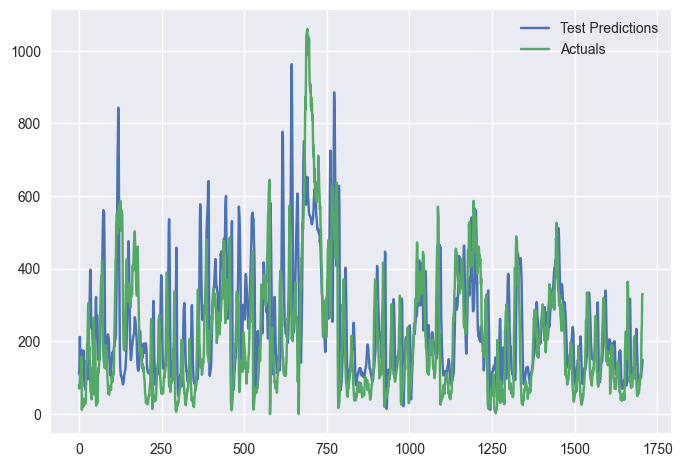

In [39]:
model = load_model('6H_Forecast/6H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(6,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D001_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D001_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)